In [0]:
!mkdir /root/.kaggle
!mv /content/kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json 

In [3]:
!kaggle competitions download -c ammi-bootcamp-kaggle-competition

 95% 11.0M/11.6M [00:00<00:00, 114MB/s]
100% 11.6M/11.6M [00:00<00:00, 107MB/s]
 41% 10.0M/24.2M [00:00<00:00, 49.4MB/s]
100% 24.2M/24.2M [00:00<00:00, 80.4MB/s]
  0% 0.00/720k [00:00<?, ?B/s]
100% 720k/720k [00:00<00:00, 94.6MB/s]


In [4]:
!unzip /content/test.csv.zip
!unzip /content/train.csv.zip

Archive:  /content/test.csv.zip
  inflating: test.csv                
Archive:  /content/train.csv.zip
  inflating: train.csv               


In [2]:
test_path = './test.csv'
train_path = './train.csv'

In [3]:
import tensorflow as tf

import tensorflow_datasets as tfds
from tensorflow.keras import datasets, preprocessing, models, layers
from tensorflow import keras
from tensorflow.keras import layers


import pandas as pd
import numpy as np

In [4]:
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [0]:
train_data.head()

In [5]:
#Fetch out required columns from data
train_data = train_data[['description', 'points', 'price', 'province', 'variety', 'winery', 'id', 'country', 'region_1', 'region_2', 'designation']]
test_data = test_data[['description', 'points', 'price', 'province', 'variety', 'winery', 'id', 'country', 'region_1', 'region_2', 'designation']]

In [6]:
values = {'country':'US', 'province':'California', 'variety':'PINOT NOIR', 'region_1':'_', 'region_2':'_', 'designation':'_'}

In [7]:
#Fill in missing columns
train_data.fillna(value=values, inplace=True)
test_data.fillna(value=values, inplace=True)

In [0]:
train_data.head()

In [0]:
train_data.info()

# Make sense of description information

In [8]:
import re

def strip_special_chars(st):
    my_pattern = '[A-Za-z0-9./ ]+'
    return (''.join(re.findall(my_pattern, st))).lower()

def split_out(x):
    #strip_special_chars(x)
    x = x.split(' ')
    x = np.asarray(x)
    
    return x
    

In [9]:
#Fetch out description text
train_description_data = train_data['description']
test_description_data = test_data['description']


#strip special characters and convert to lower case
train_description_data = train_description_data.map(strip_special_chars)
test_description_data = test_description_data.map(strip_special_chars)


In [0]:
print(test_description_data[1101])
print(train_description_data[12231])

In [10]:
complete_text = pd.concat([train_description_data, test_description_data])
complete_text.describe()

count                                                258210
unique                                               156622
top       this is your quintessential simple quaff among...
freq                                                      6
Name: description, dtype: object

In [11]:
#Create a vocabulary from the description text 

tokenizer = tfds.features.text.Tokenizer()

vocabulary_set = set()

for text in complete_text:
  some_tokens = tokenizer.tokenize(text)
  vocabulary_set.update(some_tokens)

vocab_size = len(vocabulary_set)
vocab_size


54245

In [0]:
vocabulary_set

In [12]:
#Instantiate an encoder on the vocabulary set
description_encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)

In [13]:
def description_encode(raw_text):
  encoded_text = description_encoder.encode(raw_text)
  return encoded_text

#test_description_data = test_description_data.map(encode)
#train_description_data = train_description_data.map(encode)


In [0]:
test_description_data[0]

In [0]:
#Pad each encoded text sequence to a maximum length of 200
LEN_WORDS = 200
train_description_data = preprocessing.sequence.pad_sequences(train_description_data, maxlen=LEN_WORDS)
test_description_data = preprocessing.sequence.pad_sequences(test_description_data, maxlen=LEN_WORDS)

#Encoding Categorical Features

In [14]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [15]:
#Dictionary of Encoders for each Categorical Column

encoders = {}

for i in ['province', 'variety', 'winery', 'country', 'region_1', 'region_2', 'designation']:
  complete_column = pd.concat([train_data[i], test_data[i]])
  encoders[i] = LabelEncoder().fit(complete_column)
                              
complete_points_column = pd.concat([train_data['points'], test_data['points']]).values.reshape(-1,1)

#Points Scaler
points_scaler = StandardScaler().fit(complete_points_column)

#Defining Model Architecture

In [16]:
from tensorflow import keras

In [17]:
complete_dataset = pd.concat([train_data, test_data])
complete_dataset.nunique()

description    156630
points         258210
price             387
province          483
variety           745
winery          18158
id             136499
country            48
region_1         1308
region_2           19
designation     44390
dtype: int64

In [18]:
#Model Architecture

cat_counts = {'country':48, 'winery': 18158, 'variety':745, 'province':483, 'region_1':1308, 'region_2':19, 'designation':44390 }

description_input = keras.Input(shape=(None,), name='description')
country_input = keras.Input(shape=(1,), name='country')
province_input = keras.Input(shape=(1,), name='province')
winery_input = keras.Input(shape=(1,), name='winery')
variety_input = keras.Input(shape=(1,), name='variety')
points_input = keras.Input(shape=(1,), name='points')
region_1_input = keras.Input(shape=(1,), name='region_1')
region_2_input = keras.Input(shape=(1,), name='region_2')
designation_input = keras.Input(shape=(1,), name='designation')

#Embed Sparse Input
country_features = keras.layers.Embedding(cat_counts['country'], 3)(country_input)
country_features = keras.layers.Reshape(target_shape=(3,))(country_features)

province_features = keras.layers.Embedding(cat_counts['province'], 5)(province_input)
province_features = keras.layers.Reshape(target_shape=(5,))(province_features)

winery_features = keras.layers.Embedding(cat_counts['winery'], 12)(winery_input)
winery_features = keras.layers.Reshape(target_shape=(12,))(winery_features)

variety_features = keras.layers.Embedding(cat_counts['variety'], 6)(variety_input)
variety_features = keras.layers.Reshape(target_shape=(6,))(variety_features)

region_1_features = keras.layers.Embedding(cat_counts['region_1'], 6)(region_1_input)
region_1_features = keras.layers.Reshape(target_shape=(6,))(region_1_features)

region_2_features = keras.layers.Embedding(cat_counts['region_2'], 3)(region_2_input)
region_2_features = keras.layers.Reshape(target_shape=(3,))(region_2_features)

designation_features = keras.layers.Embedding(cat_counts['designation'], 16)(designation_input)
designation_features = keras.layers.Reshape(target_shape=(16,))(designation_features)



description_features = keras.layers.Embedding(vocab_size+1, 64)(description_input)
#points_features = keras.layers.Reshape(target_shape=(1, 1))(points_input)

#Reduce Sequence of embedded words in description to a 128 dimensional vector
description_features = keras.layers.LSTM(128)(description_features)
#description_features = keras.layers.Reshape(target_shape=(128))(description_features)

#Merge all features together
x = keras.layers.concatenate([country_features, province_features, winery_features, variety_features, description_features, region_1_features, region_2_features, designation_features, points_input])
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
output = keras.layers.Dense(1, activation='linear', name='price')(x)

def create_model():
  model = keras.Model(inputs=[country_input, province_input, winery_input, variety_input, description_input, region_1_input, region_2_input, designation_input, points_input], outputs=output)
  return model

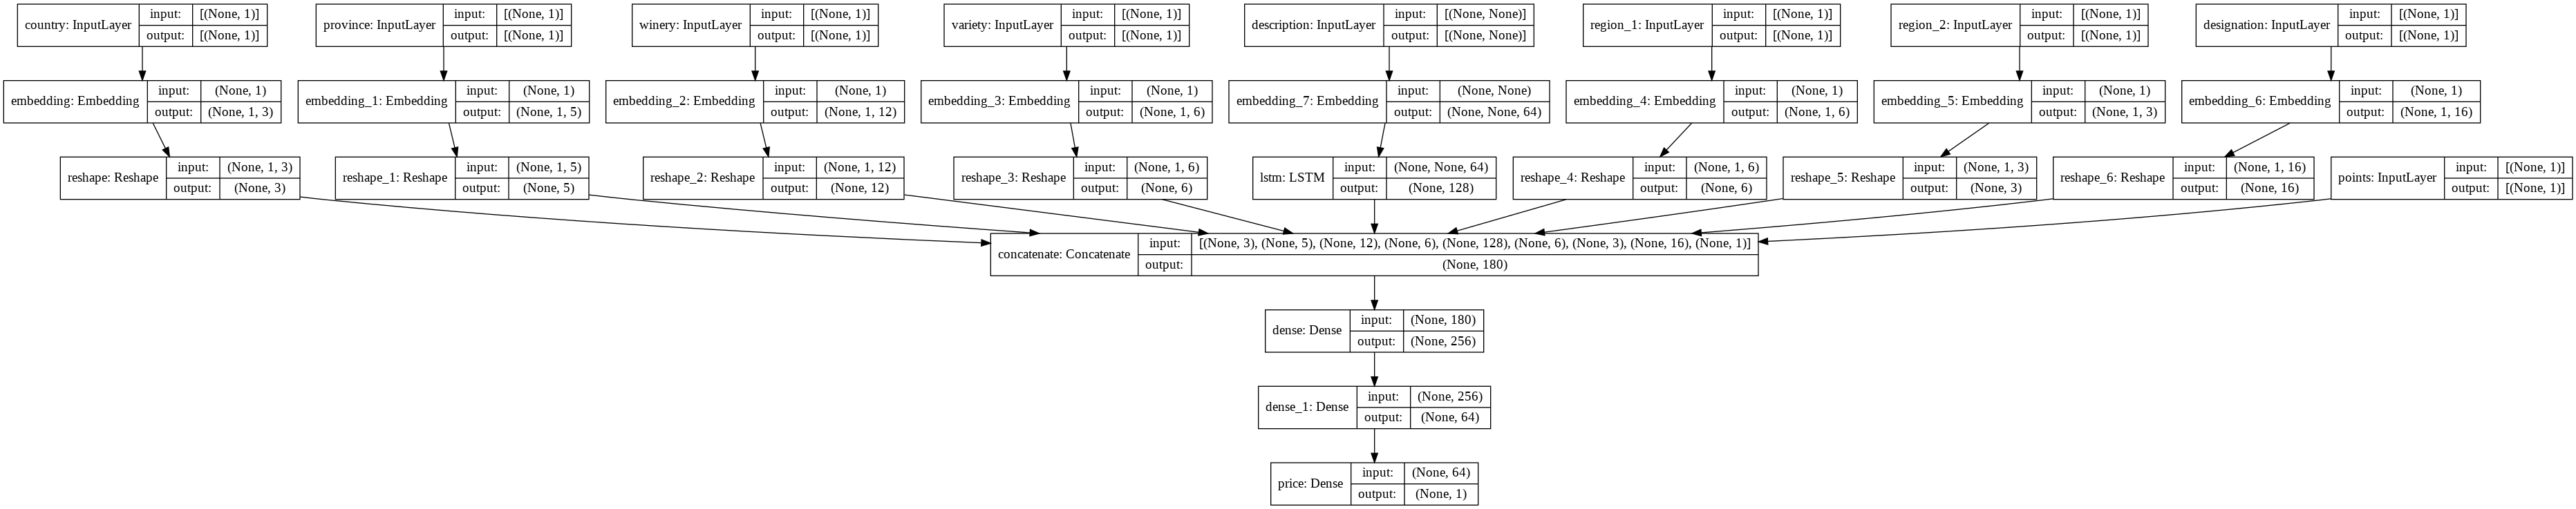

In [29]:
model = create_model()
keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
country (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
province (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
winery (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
variety (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

In [19]:
#Process input data
_train_data = train_data.sample(frac=0.9,random_state=0)
val_data = train_data.drop(_train_data.index)

def process_data(df):
  input_dictionary = {}
  label_dictionary = {}
  
  features = ['country', 'province', 'variety', 'winery', 'region_1', 'region_2', 'designation']
  for i in features:
    input_dictionary[i] = (encoders[i].transform(df[i])).reshape(-1,1)
  
  description_data = df['description'].map(strip_special_chars)
  input_dictionary['description'] = (description_data.map(description_encode))#.values.reshape(-1,1)
  input_dictionary['description'] = preprocessing.sequence.pad_sequences(input_dictionary['description'], maxlen=200)
  input_dictionary['description'] = map(lambda x: np.asarray(x), input_dictionary['description'])
  input_dictionary['description'] = np.asarray(list(input_dictionary['description']))
  input_dictionary['points'] = points_scaler.transform(df['points'].values.reshape(-1,1))
  
  label_dictionary['price'] = df['price'].values
  
  return input_dictionary, label_dictionary
  

In [20]:
#Splitting data
x_train, y_train = process_data(_train_data)
x_val, y_val = process_data(val_data)

x_test, y_test = process_data(test_data)

In [28]:
type(y_train['price'])

numpy.ndarray

In [29]:
#Training
import os

checkpoint_path = "./cp3-{epoch:04d}-.hdf5"
#checkpoint_dir = os.path.dirname(checkpoint_path)


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]

latest_chkpnt = './cp3-0002-.hdf5'

model = create_model()
#if latest_chkpnt:
model.load_weights(latest_chkpnt)
  

model.compile(optimizer=keras.optimizers.Adagrad(learning_rate=0.01), loss='MSE', metrics=['mse'])

train_history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=100,
                    callbacks=callbacks,
                    validation_data=(x_val, y_val))


Train on 157500 samples, validate on 17500 samples
Epoch 1/100


  5888/157500 [>.............................] - ETA: 5:13:26 - loss: 69.5146 - mse: 69.51 - ETA: 2:51:54 - loss: 417.1366 - mse: 417.13 - ETA: 2:04:26 - loss: 294.3956 - mse: 294.39 - ETA: 1:40:45 - loss: 243.6201 - mse: 243.62 - ETA: 1:26:30 - loss: 255.4133 - mse: 255.41 - ETA: 1:17:00 - loss: 309.9467 - mse: 309.94 - ETA: 1:10:13 - loss: 275.1186 - mse: 275.11 - ETA: 1:04:52 - loss: 250.4681 - mse: 250.46 - ETA: 1:00:44 - loss: 236.0261 - mse: 236.02 - ETA: 57:21 - loss: 220.1995 - mse: 220.1995 - ETA: 54:37 - loss: 205.5777 - mse: 205.57 - ETA: 52:22 - loss: 195.5864 - mse: 195.58 - ETA: 50:17 - loss: 208.1795 - mse: 208.17 - ETA: 48:34 - loss: 204.2254 - mse: 204.22 - ETA: 47:12 - loss: 194.6152 - mse: 194.61 - ETA: 45:58 - loss: 191.8465 - mse: 191.84 - ETA: 44:50 - loss: 190.3488 - mse: 190.34 - ETA: 43:47 - loss: 181.8520 - mse: 181.85 - ETA: 43:02 - loss: 174.8808 - mse: 174.88 - ETA: 42:16 - loss: 167.4849 - mse: 167.48 - ETA: 41:33 - loss: 161.9818 - mse: 161.98 - ETA: 40:5

 17792/157500 [==>...........................] - ETA: 26:30 - loss: 304.9269 - mse: 304.92 - ETA: 26:29 - loss: 304.3932 - mse: 304.39 - ETA: 26:29 - loss: 303.9889 - mse: 303.98 - ETA: 26:28 - loss: 303.4201 - mse: 303.42 - ETA: 26:27 - loss: 302.7554 - mse: 302.75 - ETA: 26:26 - loss: 302.6586 - mse: 302.65 - ETA: 26:25 - loss: 302.3899 - mse: 302.38 - ETA: 26:24 - loss: 306.9066 - mse: 306.90 - ETA: 26:23 - loss: 331.7002 - mse: 331.70 - ETA: 26:23 - loss: 333.6098 - mse: 333.60 - ETA: 26:22 - loss: 333.9743 - mse: 333.97 - ETA: 26:21 - loss: 333.2967 - mse: 333.29 - ETA: 26:20 - loss: 332.5400 - mse: 332.54 - ETA: 26:19 - loss: 334.4998 - mse: 334.49 - ETA: 26:19 - loss: 334.4877 - mse: 334.48 - ETA: 26:18 - loss: 333.8610 - mse: 333.86 - ETA: 26:17 - loss: 334.1512 - mse: 334.15 - ETA: 26:16 - loss: 333.8398 - mse: 333.83 - ETA: 26:15 - loss: 333.2968 - mse: 333.29 - ETA: 26:15 - loss: 332.8950 - mse: 332.89 - ETA: 26:14 - loss: 332.2336 - mse: 332.23 - ETA: 26:13 - loss: 331.8520

 23744/157500 [===>..........................] - ETA: 24:29 - loss: 277.0906 - mse: 277.09 - ETA: 24:29 - loss: 276.7138 - mse: 276.71 - ETA: 24:29 - loss: 276.5825 - mse: 276.58 - ETA: 24:28 - loss: 276.2375 - mse: 276.23 - ETA: 24:28 - loss: 275.9666 - mse: 275.96 - ETA: 24:27 - loss: 275.6593 - mse: 275.65 - ETA: 24:26 - loss: 275.7787 - mse: 275.77 - ETA: 24:26 - loss: 275.4064 - mse: 275.40 - ETA: 24:25 - loss: 275.0831 - mse: 275.08 - ETA: 24:25 - loss: 276.3115 - mse: 276.31 - ETA: 24:24 - loss: 275.8911 - mse: 275.89 - ETA: 24:24 - loss: 275.4485 - mse: 275.44 - ETA: 24:23 - loss: 276.2159 - mse: 276.21 - ETA: 24:23 - loss: 276.1202 - mse: 276.12 - ETA: 24:22 - loss: 275.7623 - mse: 275.76 - ETA: 24:22 - loss: 275.7846 - mse: 275.78 - ETA: 24:21 - loss: 275.5432 - mse: 275.54 - ETA: 24:20 - loss: 275.2285 - mse: 275.22 - ETA: 24:20 - loss: 275.3888 - mse: 275.38 - ETA: 24:19 - loss: 275.1578 - mse: 275.15 - ETA: 24:18 - loss: 274.7498 - mse: 274.74 - ETA: 24:18 - loss: 274.5862

 29696/157500 [====>.........................] - ETA: 23:07 - loss: 275.8816 - mse: 275.88 - ETA: 23:07 - loss: 275.6058 - mse: 275.60 - ETA: 23:07 - loss: 275.2789 - mse: 275.27 - ETA: 23:06 - loss: 274.9398 - mse: 274.93 - ETA: 23:06 - loss: 274.8500 - mse: 274.85 - ETA: 23:06 - loss: 274.5633 - mse: 274.56 - ETA: 23:05 - loss: 274.3143 - mse: 274.31 - ETA: 23:05 - loss: 274.3658 - mse: 274.36 - ETA: 23:04 - loss: 274.0213 - mse: 274.02 - ETA: 23:04 - loss: 273.9976 - mse: 273.99 - ETA: 23:04 - loss: 273.7398 - mse: 273.73 - ETA: 23:03 - loss: 273.4442 - mse: 273.44 - ETA: 23:03 - loss: 273.1195 - mse: 273.11 - ETA: 23:02 - loss: 272.8108 - mse: 272.81 - ETA: 23:02 - loss: 272.5563 - mse: 272.55 - ETA: 23:01 - loss: 272.3011 - mse: 272.30 - ETA: 23:01 - loss: 272.1121 - mse: 272.11 - ETA: 23:01 - loss: 271.7942 - mse: 271.79 - ETA: 23:00 - loss: 271.4831 - mse: 271.48 - ETA: 23:00 - loss: 271.2914 - mse: 271.29 - ETA: 23:00 - loss: 271.0581 - mse: 271.05 - ETA: 22:59 - loss: 270.7822

 35648/157500 [=====>........................] - ETA: 21:59 - loss: 271.1806 - mse: 271.18 - ETA: 21:58 - loss: 270.9720 - mse: 270.97 - ETA: 21:58 - loss: 270.8132 - mse: 270.81 - ETA: 21:57 - loss: 270.5883 - mse: 270.58 - ETA: 21:57 - loss: 270.5530 - mse: 270.55 - ETA: 21:57 - loss: 270.3293 - mse: 270.32 - ETA: 21:56 - loss: 270.2313 - mse: 270.23 - ETA: 21:56 - loss: 270.0542 - mse: 270.05 - ETA: 21:56 - loss: 269.8021 - mse: 269.80 - ETA: 21:55 - loss: 269.6890 - mse: 269.68 - ETA: 21:55 - loss: 269.4520 - mse: 269.45 - ETA: 21:54 - loss: 269.3420 - mse: 269.34 - ETA: 21:54 - loss: 273.8114 - mse: 273.81 - ETA: 21:54 - loss: 273.6278 - mse: 273.62 - ETA: 21:53 - loss: 273.3679 - mse: 273.36 - ETA: 21:53 - loss: 273.5982 - mse: 273.59 - ETA: 21:53 - loss: 273.3479 - mse: 273.34 - ETA: 21:52 - loss: 273.0872 - mse: 273.08 - ETA: 21:52 - loss: 272.8259 - mse: 272.82 - ETA: 21:51 - loss: 272.5949 - mse: 272.59 - ETA: 21:51 - loss: 272.4515 - mse: 272.45 - ETA: 21:51 - loss: 272.1942

 41600/157500 [======>.......................] - ETA: 20:47 - loss: 279.2998 - mse: 279.29 - ETA: 20:46 - loss: 279.0882 - mse: 279.08 - ETA: 20:46 - loss: 279.0374 - mse: 279.03 - ETA: 20:46 - loss: 278.8243 - mse: 278.82 - ETA: 20:45 - loss: 278.6284 - mse: 278.62 - ETA: 20:45 - loss: 278.4801 - mse: 278.48 - ETA: 20:44 - loss: 278.2579 - mse: 278.25 - ETA: 20:44 - loss: 278.2069 - mse: 278.20 - ETA: 20:43 - loss: 278.1937 - mse: 278.19 - ETA: 20:43 - loss: 277.9952 - mse: 277.99 - ETA: 20:43 - loss: 277.7946 - mse: 277.79 - ETA: 20:42 - loss: 277.5849 - mse: 277.58 - ETA: 20:42 - loss: 277.4859 - mse: 277.48 - ETA: 20:41 - loss: 277.3087 - mse: 277.30 - ETA: 20:41 - loss: 277.0905 - mse: 277.09 - ETA: 20:41 - loss: 277.0449 - mse: 277.04 - ETA: 20:40 - loss: 276.8416 - mse: 276.84 - ETA: 20:40 - loss: 276.7007 - mse: 276.70 - ETA: 20:40 - loss: 276.4913 - mse: 276.49 - ETA: 20:39 - loss: 276.2859 - mse: 276.28 - ETA: 20:39 - loss: 276.3171 - mse: 276.31 - ETA: 20:38 - loss: 276.1071

 47552/157500 [========>.....................] - ETA: 19:43 - loss: 257.1351 - mse: 257.13 - ETA: 19:43 - loss: 256.9640 - mse: 256.96 - ETA: 19:43 - loss: 256.8443 - mse: 256.84 - ETA: 19:43 - loss: 256.6809 - mse: 256.68 - ETA: 19:43 - loss: 256.6455 - mse: 256.64 - ETA: 19:42 - loss: 256.5905 - mse: 256.59 - ETA: 19:42 - loss: 256.4391 - mse: 256.43 - ETA: 19:42 - loss: 256.2704 - mse: 256.27 - ETA: 19:42 - loss: 256.1739 - mse: 256.17 - ETA: 19:41 - loss: 256.0972 - mse: 256.09 - ETA: 19:41 - loss: 256.0041 - mse: 256.00 - ETA: 19:41 - loss: 255.9507 - mse: 255.95 - ETA: 19:40 - loss: 255.8037 - mse: 255.80 - ETA: 19:40 - loss: 255.7555 - mse: 255.75 - ETA: 19:40 - loss: 255.5971 - mse: 255.59 - ETA: 19:39 - loss: 255.4337 - mse: 255.43 - ETA: 19:39 - loss: 255.2912 - mse: 255.29 - ETA: 19:39 - loss: 255.1232 - mse: 255.12 - ETA: 19:38 - loss: 254.9947 - mse: 254.99 - ETA: 19:38 - loss: 255.2358 - mse: 255.23 - ETA: 19:38 - loss: 255.2973 - mse: 255.29 - ETA: 19:37 - loss: 255.3484

 53504/157500 [=========>....................] - ETA: 18:45 - loss: 322.0441 - mse: 322.04 - ETA: 18:45 - loss: 321.8496 - mse: 321.84 - ETA: 18:44 - loss: 321.6596 - mse: 321.65 - ETA: 18:44 - loss: 321.5006 - mse: 321.50 - ETA: 18:44 - loss: 321.3276 - mse: 321.32 - ETA: 18:44 - loss: 321.2566 - mse: 321.25 - ETA: 18:43 - loss: 321.2325 - mse: 321.23 - ETA: 18:43 - loss: 321.0828 - mse: 321.08 - ETA: 18:43 - loss: 320.9407 - mse: 320.94 - ETA: 18:42 - loss: 320.8299 - mse: 320.83 - ETA: 18:42 - loss: 320.6850 - mse: 320.68 - ETA: 18:42 - loss: 320.9519 - mse: 320.95 - ETA: 18:42 - loss: 320.7754 - mse: 320.77 - ETA: 18:41 - loss: 320.8885 - mse: 320.88 - ETA: 18:41 - loss: 320.7123 - mse: 320.71 - ETA: 18:41 - loss: 320.9829 - mse: 320.98 - ETA: 18:40 - loss: 320.7916 - mse: 320.79 - ETA: 18:40 - loss: 320.6169 - mse: 320.61 - ETA: 18:40 - loss: 320.5363 - mse: 320.53 - ETA: 18:40 - loss: 320.3634 - mse: 320.36 - ETA: 18:39 - loss: 320.1732 - mse: 320.17 - ETA: 18:39 - loss: 320.1744

 59456/157500 [==========>...................] - ETA: 17:42 - loss: 303.2039 - mse: 303.20 - ETA: 17:41 - loss: 303.0559 - mse: 303.05 - ETA: 17:41 - loss: 302.9009 - mse: 302.90 - ETA: 17:41 - loss: 302.7640 - mse: 302.76 - ETA: 17:40 - loss: 302.6970 - mse: 302.69 - ETA: 17:40 - loss: 302.5442 - mse: 302.54 - ETA: 17:40 - loss: 302.4016 - mse: 302.40 - ETA: 17:39 - loss: 302.3419 - mse: 302.34 - ETA: 17:39 - loss: 302.1824 - mse: 302.18 - ETA: 17:39 - loss: 302.0201 - mse: 302.02 - ETA: 17:38 - loss: 302.0414 - mse: 302.04 - ETA: 17:38 - loss: 301.8765 - mse: 301.87 - ETA: 17:38 - loss: 301.7354 - mse: 301.73 - ETA: 17:37 - loss: 301.5862 - mse: 301.58 - ETA: 17:37 - loss: 301.4250 - mse: 301.42 - ETA: 17:37 - loss: 301.3328 - mse: 301.33 - ETA: 17:36 - loss: 302.2988 - mse: 302.29 - ETA: 17:36 - loss: 302.1597 - mse: 302.15 - ETA: 17:36 - loss: 302.0346 - mse: 302.03 - ETA: 17:36 - loss: 301.8873 - mse: 301.88 - ETA: 17:36 - loss: 301.7747 - mse: 301.77 - ETA: 17:35 - loss: 301.8305

 65408/157500 [===========>..................] - ETA: 16:39 - loss: 286.6649 - mse: 286.66 - ETA: 16:39 - loss: 286.6530 - mse: 286.65 - ETA: 16:39 - loss: 286.5383 - mse: 286.53 - ETA: 16:38 - loss: 286.4695 - mse: 286.46 - ETA: 16:38 - loss: 287.7644 - mse: 287.76 - ETA: 16:38 - loss: 287.8894 - mse: 287.88 - ETA: 16:37 - loss: 287.7957 - mse: 287.79 - ETA: 16:37 - loss: 287.7459 - mse: 287.74 - ETA: 16:36 - loss: 287.6295 - mse: 287.62 - ETA: 16:36 - loss: 287.5865 - mse: 287.58 - ETA: 16:36 - loss: 287.4639 - mse: 287.46 - ETA: 16:35 - loss: 287.3365 - mse: 287.33 - ETA: 16:35 - loss: 287.6112 - mse: 287.61 - ETA: 16:35 - loss: 287.5013 - mse: 287.50 - ETA: 16:34 - loss: 287.4480 - mse: 287.44 - ETA: 16:34 - loss: 287.3114 - mse: 287.31 - ETA: 16:33 - loss: 287.2335 - mse: 287.23 - ETA: 16:33 - loss: 287.1229 - mse: 287.12 - ETA: 16:33 - loss: 287.0091 - mse: 287.00 - ETA: 16:32 - loss: 286.9038 - mse: 286.90 - ETA: 16:32 - loss: 286.7658 - mse: 286.76 - ETA: 16:31 - loss: 286.9043

 71360/157500 [============>.................] - ETA: 15:34 - loss: 276.8858 - mse: 276.88 - ETA: 15:34 - loss: 276.7948 - mse: 276.79 - ETA: 15:33 - loss: 276.7186 - mse: 276.71 - ETA: 15:33 - loss: 276.6043 - mse: 276.60 - ETA: 15:32 - loss: 276.5613 - mse: 276.56 - ETA: 15:32 - loss: 276.4432 - mse: 276.44 - ETA: 15:32 - loss: 276.6336 - mse: 276.63 - ETA: 15:31 - loss: 276.5123 - mse: 276.51 - ETA: 15:31 - loss: 276.3916 - mse: 276.39 - ETA: 15:31 - loss: 276.3688 - mse: 276.36 - ETA: 15:30 - loss: 276.2512 - mse: 276.25 - ETA: 15:30 - loss: 276.1307 - mse: 276.13 - ETA: 15:30 - loss: 276.1170 - mse: 276.11 - ETA: 15:29 - loss: 276.0018 - mse: 276.00 - ETA: 15:29 - loss: 275.8852 - mse: 275.88 - ETA: 15:29 - loss: 275.7701 - mse: 275.77 - ETA: 15:28 - loss: 275.6472 - mse: 275.64 - ETA: 15:28 - loss: 275.5330 - mse: 275.53 - ETA: 15:28 - loss: 275.4865 - mse: 275.48 - ETA: 15:27 - loss: 275.3802 - mse: 275.38 - ETA: 15:27 - loss: 275.2812 - mse: 275.28 - ETA: 15:27 - loss: 275.2532

 77312/157500 [=============>................] - ETA: 14:29 - loss: 284.2499 - mse: 284.24 - ETA: 14:29 - loss: 284.2648 - mse: 284.26 - ETA: 14:28 - loss: 284.1791 - mse: 284.17 - ETA: 14:28 - loss: 284.0795 - mse: 284.07 - ETA: 14:28 - loss: 283.9732 - mse: 283.97 - ETA: 14:27 - loss: 283.8539 - mse: 283.85 - ETA: 14:27 - loss: 283.8524 - mse: 283.85 - ETA: 14:27 - loss: 283.7458 - mse: 283.74 - ETA: 14:26 - loss: 283.8418 - mse: 283.84 - ETA: 14:26 - loss: 283.8473 - mse: 283.84 - ETA: 14:25 - loss: 283.7813 - mse: 283.78 - ETA: 14:25 - loss: 283.6901 - mse: 283.69 - ETA: 14:25 - loss: 283.6195 - mse: 283.61 - ETA: 14:24 - loss: 283.6957 - mse: 283.69 - ETA: 14:24 - loss: 283.6010 - mse: 283.60 - ETA: 14:24 - loss: 283.5039 - mse: 283.50 - ETA: 14:23 - loss: 283.4506 - mse: 283.45 - ETA: 14:23 - loss: 283.3699 - mse: 283.36 - ETA: 14:23 - loss: 283.2654 - mse: 283.26 - ETA: 14:22 - loss: 283.2369 - mse: 283.23 - ETA: 14:22 - loss: 283.1168 - mse: 283.11 - ETA: 14:22 - loss: 283.0046

 83264/157500 [==============>...............] - ETA: 13:26 - loss: 287.4370 - mse: 287.43 - ETA: 13:25 - loss: 287.3347 - mse: 287.33 - ETA: 13:25 - loss: 287.2424 - mse: 287.24 - ETA: 13:25 - loss: 287.1465 - mse: 287.14 - ETA: 13:24 - loss: 287.0515 - mse: 287.05 - ETA: 13:24 - loss: 286.9594 - mse: 286.95 - ETA: 13:24 - loss: 287.0289 - mse: 287.02 - ETA: 13:23 - loss: 287.1488 - mse: 287.14 - ETA: 13:23 - loss: 287.4421 - mse: 287.44 - ETA: 13:23 - loss: 287.3613 - mse: 287.36 - ETA: 13:22 - loss: 287.3724 - mse: 287.37 - ETA: 13:22 - loss: 287.2964 - mse: 287.29 - ETA: 13:22 - loss: 287.2002 - mse: 287.20 - ETA: 13:22 - loss: 287.1051 - mse: 287.10 - ETA: 13:21 - loss: 287.0147 - mse: 287.01 - ETA: 13:21 - loss: 286.9971 - mse: 286.99 - ETA: 13:21 - loss: 286.9046 - mse: 286.90 - ETA: 13:20 - loss: 286.7975 - mse: 286.79 - ETA: 13:20 - loss: 286.7442 - mse: 286.74 - ETA: 13:19 - loss: 286.6459 - mse: 286.64 - ETA: 13:19 - loss: 286.6340 - mse: 286.63 - ETA: 13:19 - loss: 286.7180

 89216/157500 [===============>..............] - ETA: 12:25 - loss: 299.8005 - mse: 299.80 - ETA: 12:24 - loss: 299.7078 - mse: 299.70 - ETA: 12:24 - loss: 299.6366 - mse: 299.63 - ETA: 12:24 - loss: 299.6143 - mse: 299.61 - ETA: 12:23 - loss: 299.5053 - mse: 299.50 - ETA: 12:23 - loss: 299.4118 - mse: 299.41 - ETA: 12:23 - loss: 299.3553 - mse: 299.35 - ETA: 12:22 - loss: 299.2558 - mse: 299.25 - ETA: 12:22 - loss: 299.5210 - mse: 299.52 - ETA: 12:22 - loss: 299.4451 - mse: 299.44 - ETA: 12:21 - loss: 299.3440 - mse: 299.34 - ETA: 12:21 - loss: 299.2835 - mse: 299.28 - ETA: 12:21 - loss: 299.1954 - mse: 299.19 - ETA: 12:20 - loss: 299.2162 - mse: 299.21 - ETA: 12:20 - loss: 299.1314 - mse: 299.13 - ETA: 12:20 - loss: 299.0371 - mse: 299.03 - ETA: 12:19 - loss: 298.9477 - mse: 298.94 - ETA: 12:19 - loss: 298.8518 - mse: 298.85 - ETA: 12:19 - loss: 298.7537 - mse: 298.75 - ETA: 12:18 - loss: 298.6555 - mse: 298.65 - ETA: 12:18 - loss: 298.5587 - mse: 298.55 - ETA: 12:18 - loss: 298.5283

 95168/157500 [=================>............] - ETA: 11:23 - loss: 288.8738 - mse: 288.87 - ETA: 11:23 - loss: 288.8144 - mse: 288.81 - ETA: 11:23 - loss: 288.7435 - mse: 288.74 - ETA: 11:22 - loss: 288.6626 - mse: 288.66 - ETA: 11:22 - loss: 288.6444 - mse: 288.64 - ETA: 11:22 - loss: 288.5585 - mse: 288.55 - ETA: 11:21 - loss: 288.4726 - mse: 288.47 - ETA: 11:21 - loss: 288.3759 - mse: 288.37 - ETA: 11:21 - loss: 288.2977 - mse: 288.29 - ETA: 11:20 - loss: 288.2003 - mse: 288.20 - ETA: 11:20 - loss: 288.1215 - mse: 288.12 - ETA: 11:20 - loss: 288.0356 - mse: 288.03 - ETA: 11:19 - loss: 287.9436 - mse: 287.94 - ETA: 11:19 - loss: 287.8610 - mse: 287.86 - ETA: 11:19 - loss: 287.8123 - mse: 287.81 - ETA: 11:18 - loss: 287.7212 - mse: 287.72 - ETA: 11:18 - loss: 287.6468 - mse: 287.64 - ETA: 11:18 - loss: 287.6058 - mse: 287.60 - ETA: 11:17 - loss: 287.5456 - mse: 287.54 - ETA: 11:17 - loss: 287.4579 - mse: 287.45 - ETA: 11:17 - loss: 287.4161 - mse: 287.41 - ETA: 11:16 - loss: 287.3480

101120/157500 [==================>...........] - ETA: 10:23 - loss: 297.3741 - mse: 297.37 - ETA: 10:22 - loss: 297.2873 - mse: 297.28 - ETA: 10:22 - loss: 297.2026 - mse: 297.20 - ETA: 10:22 - loss: 297.1148 - mse: 297.11 - ETA: 10:21 - loss: 297.0295 - mse: 297.02 - ETA: 10:21 - loss: 297.0819 - mse: 297.08 - ETA: 10:21 - loss: 297.0142 - mse: 297.01 - ETA: 10:20 - loss: 296.9848 - mse: 296.98 - ETA: 10:20 - loss: 296.9062 - mse: 296.90 - ETA: 10:20 - loss: 296.8441 - mse: 296.84 - ETA: 10:19 - loss: 296.7660 - mse: 296.76 - ETA: 10:19 - loss: 296.6981 - mse: 296.69 - ETA: 10:19 - loss: 296.7087 - mse: 296.70 - ETA: 10:18 - loss: 296.6444 - mse: 296.64 - ETA: 10:18 - loss: 296.5566 - mse: 296.55 - ETA: 10:18 - loss: 296.4786 - mse: 296.47 - ETA: 10:17 - loss: 296.4116 - mse: 296.41 - ETA: 10:17 - loss: 296.3855 - mse: 296.38 - ETA: 10:17 - loss: 297.0322 - mse: 297.03 - ETA: 10:16 - loss: 296.9812 - mse: 296.98 - ETA: 10:16 - loss: 296.9228 - mse: 296.92 - ETA: 10:16 - loss: 296.8900

107072/157500 [===================>..........] - ETA: 9:22 - loss: 292.2437 - mse: 292.243 - ETA: 9:21 - loss: 292.1696 - mse: 292.169 - ETA: 9:21 - loss: 292.1161 - mse: 292.115 - ETA: 9:21 - loss: 292.0949 - mse: 292.094 - ETA: 9:20 - loss: 292.0554 - mse: 292.055 - ETA: 9:20 - loss: 292.0368 - mse: 292.036 - ETA: 9:20 - loss: 292.0194 - mse: 292.019 - ETA: 9:19 - loss: 291.9777 - mse: 291.977 - ETA: 9:19 - loss: 291.8994 - mse: 291.899 - ETA: 9:19 - loss: 291.8177 - mse: 291.817 - ETA: 9:19 - loss: 291.7801 - mse: 291.780 - ETA: 9:18 - loss: 291.7003 - mse: 291.700 - ETA: 9:18 - loss: 291.6455 - mse: 291.645 - ETA: 9:18 - loss: 291.5705 - mse: 291.570 - ETA: 9:17 - loss: 291.4955 - mse: 291.495 - ETA: 9:17 - loss: 291.4279 - mse: 291.427 - ETA: 9:17 - loss: 291.3527 - mse: 291.352 - ETA: 9:16 - loss: 291.2714 - mse: 291.271 - ETA: 9:16 - loss: 291.1941 - mse: 291.193 - ETA: 9:16 - loss: 291.2059 - mse: 291.205 - ETA: 9:15 - loss: 291.1330 - mse: 291.132 - ETA: 9:15 - loss: 291.0484 

113024/157500 [====================>.........] - ETA: 8:21 - loss: 284.6762 - mse: 284.676 - ETA: 8:21 - loss: 284.6025 - mse: 284.602 - ETA: 8:21 - loss: 284.5353 - mse: 284.535 - ETA: 8:20 - loss: 284.4631 - mse: 284.463 - ETA: 8:20 - loss: 284.3898 - mse: 284.389 - ETA: 8:20 - loss: 284.3154 - mse: 284.315 - ETA: 8:19 - loss: 284.2453 - mse: 284.245 - ETA: 8:19 - loss: 284.1820 - mse: 284.181 - ETA: 8:19 - loss: 284.3812 - mse: 284.381 - ETA: 8:18 - loss: 284.3063 - mse: 284.306 - ETA: 8:18 - loss: 284.2561 - mse: 284.255 - ETA: 8:18 - loss: 284.1960 - mse: 284.195 - ETA: 8:17 - loss: 284.1235 - mse: 284.123 - ETA: 8:17 - loss: 284.0618 - mse: 284.061 - ETA: 8:17 - loss: 283.9941 - mse: 283.993 - ETA: 8:16 - loss: 283.9605 - mse: 283.960 - ETA: 8:16 - loss: 283.9208 - mse: 283.920 - ETA: 8:16 - loss: 283.8489 - mse: 283.848 - ETA: 8:15 - loss: 289.0138 - mse: 289.013 - ETA: 8:15 - loss: 288.9406 - mse: 288.940 - ETA: 8:15 - loss: 288.8780 - mse: 288.877 - ETA: 8:14 - loss: 288.8849 

118976/157500 [=====================>........] - ETA: 7:21 - loss: 317.5780 - mse: 317.578 - ETA: 7:21 - loss: 317.5030 - mse: 317.502 - ETA: 7:20 - loss: 317.4253 - mse: 317.425 - ETA: 7:20 - loss: 317.4759 - mse: 317.475 - ETA: 7:20 - loss: 327.2489 - mse: 327.248 - ETA: 7:19 - loss: 327.2195 - mse: 327.219 - ETA: 7:19 - loss: 327.1392 - mse: 327.139 - ETA: 7:19 - loss: 327.0652 - mse: 327.065 - ETA: 7:18 - loss: 326.9911 - mse: 326.991 - ETA: 7:18 - loss: 327.1547 - mse: 327.154 - ETA: 7:18 - loss: 327.0835 - mse: 327.083 - ETA: 7:17 - loss: 326.9980 - mse: 326.998 - ETA: 7:17 - loss: 326.9158 - mse: 326.915 - ETA: 7:17 - loss: 326.8455 - mse: 326.845 - ETA: 7:16 - loss: 326.7752 - mse: 326.775 - ETA: 7:16 - loss: 326.6921 - mse: 326.692 - ETA: 7:16 - loss: 326.6129 - mse: 326.612 - ETA: 7:15 - loss: 326.5526 - mse: 326.552 - ETA: 7:15 - loss: 326.4851 - mse: 326.485 - ETA: 7:15 - loss: 326.4046 - mse: 326.404 - ETA: 7:15 - loss: 326.3534 - mse: 326.353 - ETA: 7:14 - loss: 326.2772 

124928/157500 [======================>.......] - ETA: 6:22 - loss: 323.2169 - mse: 323.216 - ETA: 6:21 - loss: 323.1551 - mse: 323.154 - ETA: 6:21 - loss: 323.0767 - mse: 323.076 - ETA: 6:21 - loss: 323.4251 - mse: 323.424 - ETA: 6:20 - loss: 323.4172 - mse: 323.417 - ETA: 6:20 - loss: 323.3456 - mse: 323.345 - ETA: 6:20 - loss: 323.3041 - mse: 323.303 - ETA: 6:20 - loss: 323.2997 - mse: 323.299 - ETA: 6:19 - loss: 323.2278 - mse: 323.227 - ETA: 6:19 - loss: 323.2081 - mse: 323.207 - ETA: 6:19 - loss: 323.1354 - mse: 323.135 - ETA: 6:18 - loss: 323.0829 - mse: 323.082 - ETA: 6:18 - loss: 323.0263 - mse: 323.026 - ETA: 6:18 - loss: 322.9470 - mse: 322.946 - ETA: 6:17 - loss: 322.8801 - mse: 322.879 - ETA: 6:17 - loss: 322.8123 - mse: 322.812 - ETA: 6:17 - loss: 322.7347 - mse: 322.734 - ETA: 6:16 - loss: 322.6604 - mse: 322.660 - ETA: 6:16 - loss: 322.5892 - mse: 322.588 - ETA: 6:16 - loss: 322.5197 - mse: 322.519 - ETA: 6:15 - loss: 322.4403 - mse: 322.440 - ETA: 6:15 - loss: 322.3664 

130880/157500 [=======================>......] - ETA: 5:22 - loss: 371.6688 - mse: 371.668 - ETA: 5:22 - loss: 371.6008 - mse: 371.600 - ETA: 5:21 - loss: 371.5828 - mse: 371.582 - ETA: 5:21 - loss: 371.5397 - mse: 371.539 - ETA: 5:21 - loss: 372.4047 - mse: 372.404 - ETA: 5:20 - loss: 372.3992 - mse: 372.399 - ETA: 5:20 - loss: 372.3218 - mse: 372.321 - ETA: 5:20 - loss: 372.2341 - mse: 372.233 - ETA: 5:19 - loss: 372.1544 - mse: 372.154 - ETA: 5:19 - loss: 372.1002 - mse: 372.099 - ETA: 5:19 - loss: 372.0357 - mse: 372.035 - ETA: 5:19 - loss: 371.9528 - mse: 371.952 - ETA: 5:18 - loss: 371.8722 - mse: 371.872 - ETA: 5:18 - loss: 371.8237 - mse: 371.823 - ETA: 5:18 - loss: 371.7377 - mse: 371.737 - ETA: 5:17 - loss: 371.6712 - mse: 371.671 - ETA: 5:17 - loss: 371.6044 - mse: 371.604 - ETA: 5:17 - loss: 371.5316 - mse: 371.531 - ETA: 5:16 - loss: 371.4870 - mse: 371.486 - ETA: 5:16 - loss: 371.3989 - mse: 371.398 - ETA: 5:16 - loss: 371.3747 - mse: 371.374 - ETA: 5:15 - loss: 371.2943 

136832/157500 [=========================>....] - ETA: 4:23 - loss: 361.7699 - mse: 361.769 - ETA: 4:22 - loss: 361.6957 - mse: 361.695 - ETA: 4:22 - loss: 361.6391 - mse: 361.638 - ETA: 4:22 - loss: 361.5820 - mse: 361.581 - ETA: 4:21 - loss: 361.5044 - mse: 361.504 - ETA: 4:21 - loss: 361.4349 - mse: 361.434 - ETA: 4:21 - loss: 361.3873 - mse: 361.387 - ETA: 4:20 - loss: 361.4814 - mse: 361.481 - ETA: 4:20 - loss: 361.3996 - mse: 361.399 - ETA: 4:20 - loss: 361.3250 - mse: 361.324 - ETA: 4:19 - loss: 361.2413 - mse: 361.241 - ETA: 4:19 - loss: 361.1763 - mse: 361.176 - ETA: 4:19 - loss: 361.1206 - mse: 361.120 - ETA: 4:18 - loss: 361.0389 - mse: 361.038 - ETA: 4:18 - loss: 360.9582 - mse: 360.957 - ETA: 4:18 - loss: 360.8879 - mse: 360.887 - ETA: 4:17 - loss: 360.8085 - mse: 360.808 - ETA: 4:17 - loss: 360.7314 - mse: 360.731 - ETA: 4:17 - loss: 360.6607 - mse: 360.660 - ETA: 4:16 - loss: 360.6197 - mse: 360.619 - ETA: 4:16 - loss: 360.5658 - mse: 360.565 - ETA: 4:16 - loss: 360.5124 

142784/157500 [==========================>...] - ETA: 3:23 - loss: 353.1153 - mse: 353.115 - ETA: 3:23 - loss: 353.0496 - mse: 353.049 - ETA: 3:23 - loss: 352.9863 - mse: 352.986 - ETA: 3:23 - loss: 352.9117 - mse: 352.911 - ETA: 3:22 - loss: 352.8506 - mse: 352.850 - ETA: 3:22 - loss: 352.7788 - mse: 352.778 - ETA: 3:22 - loss: 352.7440 - mse: 352.743 - ETA: 3:21 - loss: 352.6658 - mse: 352.665 - ETA: 3:21 - loss: 352.5944 - mse: 352.594 - ETA: 3:21 - loss: 352.5205 - mse: 352.520 - ETA: 3:20 - loss: 352.4544 - mse: 352.454 - ETA: 3:20 - loss: 352.3913 - mse: 352.391 - ETA: 3:20 - loss: 352.3151 - mse: 352.314 - ETA: 3:19 - loss: 352.2430 - mse: 352.242 - ETA: 3:19 - loss: 352.1868 - mse: 352.186 - ETA: 3:19 - loss: 352.1164 - mse: 352.116 - ETA: 3:18 - loss: 352.0547 - mse: 352.054 - ETA: 3:18 - loss: 351.9966 - mse: 351.996 - ETA: 3:18 - loss: 351.9368 - mse: 351.936 - ETA: 3:17 - loss: 351.8685 - mse: 351.868 - ETA: 3:17 - loss: 351.7954 - mse: 351.795 - ETA: 3:17 - loss: 351.7709 

148736/157500 [===========================>..] - ETA: 2:25 - loss: 354.8984 - mse: 354.898 - ETA: 2:24 - loss: 354.8575 - mse: 354.857 - ETA: 2:24 - loss: 354.8297 - mse: 354.829 - ETA: 2:24 - loss: 354.7899 - mse: 354.789 - ETA: 2:23 - loss: 354.7226 - mse: 354.722 - ETA: 2:23 - loss: 354.7026 - mse: 354.702 - ETA: 2:23 - loss: 354.6327 - mse: 354.632 - ETA: 2:22 - loss: 354.5689 - mse: 354.568 - ETA: 2:22 - loss: 354.5154 - mse: 354.515 - ETA: 2:22 - loss: 354.5248 - mse: 354.524 - ETA: 2:21 - loss: 354.4723 - mse: 354.472 - ETA: 2:21 - loss: 354.4102 - mse: 354.409 - ETA: 2:21 - loss: 354.3637 - mse: 354.363 - ETA: 2:20 - loss: 354.3389 - mse: 354.338 - ETA: 2:20 - loss: 354.2632 - mse: 354.263 - ETA: 2:20 - loss: 354.2621 - mse: 354.261 - ETA: 2:20 - loss: 354.1892 - mse: 354.188 - ETA: 2:19 - loss: 354.1282 - mse: 354.128 - ETA: 2:19 - loss: 354.0621 - mse: 354.061 - ETA: 2:19 - loss: 353.9931 - mse: 353.992 - ETA: 2:18 - loss: 353.9334 - mse: 353.933 - ETA: 2:18 - loss: 353.9486 

154816/157500 [============================>.] - ETA: 1:26 - loss: 348.6041 - mse: 348.603 - ETA: 1:25 - loss: 348.5369 - mse: 348.536 - ETA: 1:25 - loss: 348.6182 - mse: 348.617 - ETA: 1:25 - loss: 348.5579 - mse: 348.557 - ETA: 1:25 - loss: 348.4988 - mse: 348.498 - ETA: 1:24 - loss: 348.4366 - mse: 348.436 - ETA: 1:24 - loss: 348.3704 - mse: 348.370 - ETA: 1:24 - loss: 348.3100 - mse: 348.309 - ETA: 1:23 - loss: 348.2554 - mse: 348.255 - ETA: 1:23 - loss: 348.2090 - mse: 348.208 - ETA: 1:23 - loss: 348.1431 - mse: 348.142 - ETA: 1:22 - loss: 348.0782 - mse: 348.077 - ETA: 1:22 - loss: 348.0178 - mse: 348.017 - ETA: 1:22 - loss: 347.9617 - mse: 347.961 - ETA: 1:21 - loss: 347.8941 - mse: 347.893 - ETA: 1:21 - loss: 347.8261 - mse: 347.825 - ETA: 1:21 - loss: 347.7761 - mse: 347.775 - ETA: 1:20 - loss: 347.7197 - mse: 347.719 - ETA: 1:20 - loss: 347.6531 - mse: 347.652 - ETA: 1:20 - loss: 347.5880 - mse: 347.587 - ETA: 1:19 - loss: 347.5422 - mse: 347.541 - ETA: 1:19 - loss: 347.4892 

157472/157500 [============================>.] - ETA: 26s - loss: 342.3094 - mse: 342.30 - ETA: 25s - loss: 342.2507 - mse: 342.25 - ETA: 25s - loss: 342.2029 - mse: 342.20 - ETA: 25s - loss: 342.1505 - mse: 342.15 - ETA: 24s - loss: 342.0905 - mse: 342.09 - ETA: 24s - loss: 342.0579 - mse: 342.05 - ETA: 24s - loss: 341.9951 - mse: 341.99 - ETA: 24s - loss: 341.9730 - mse: 341.97 - ETA: 23s - loss: 341.9222 - mse: 341.92 - ETA: 23s - loss: 341.8606 - mse: 341.86 - ETA: 23s - loss: 341.8468 - mse: 341.84 - ETA: 22s - loss: 341.7824 - mse: 341.78 - ETA: 22s - loss: 341.7468 - mse: 341.74 - ETA: 22s - loss: 341.7072 - mse: 341.70 - ETA: 21s - loss: 341.6524 - mse: 341.65 - ETA: 21s - loss: 341.6039 - mse: 341.60 - ETA: 21s - loss: 341.5611 - mse: 341.56 - ETA: 20s - loss: 341.4954 - mse: 341.49 - ETA: 20s - loss: 341.4368 - mse: 341.43 - ETA: 20s - loss: 341.4051 - mse: 341.40 - ETA: 19s - loss: 341.6043 - mse: 341.60 - ETA: 19s - loss: 341.5927 - mse: 341.59 - ETA: 19s - loss: 341.5286 -

  5952/157500 [>.............................] - ETA: 23:45 - loss: 35.5681 - mse: 35.56 - ETA: 23:50 - loss: 39.6491 - mse: 39.64 - ETA: 25:29 - loss: 140.4164 - mse: 140.41 - ETA: 25:08 - loss: 114.4003 - mse: 114.40 - ETA: 25:02 - loss: 171.8511 - mse: 171.85 - ETA: 24:47 - loss: 152.8627 - mse: 152.86 - ETA: 24:32 - loss: 176.9445 - mse: 176.94 - ETA: 24:27 - loss: 788.9695 - mse: 788.96 - ETA: 24:19 - loss: 713.4294 - mse: 713.42 - ETA: 24:15 - loss: 655.8336 - mse: 655.83 - ETA: 24:02 - loss: 630.3050 - mse: 630.30 - ETA: 23:59 - loss: 582.1322 - mse: 582.13 - ETA: 24:01 - loss: 540.3355 - mse: 540.33 - ETA: 24:03 - loss: 503.5021 - mse: 503.50 - ETA: 24:03 - loss: 471.5337 - mse: 471.53 - ETA: 24:00 - loss: 446.4261 - mse: 446.42 - ETA: 24:02 - loss: 421.4905 - mse: 421.49 - ETA: 24:05 - loss: 399.9035 - mse: 399.90 - ETA: 24:03 - loss: 402.3392 - mse: 402.33 - ETA: 24:03 - loss: 383.1801 - mse: 383.18 - ETA: 24:02 - loss: 367.6280 - mse: 367.62 - ETA: 24:05 - loss: 352.4858 - m

 17856/157500 [==>...........................] - ETA: 22:49 - loss: 172.1507 - mse: 172.15 - ETA: 22:48 - loss: 172.1957 - mse: 172.19 - ETA: 22:48 - loss: 172.3125 - mse: 172.31 - ETA: 22:48 - loss: 172.2875 - mse: 172.28 - ETA: 22:48 - loss: 171.9126 - mse: 171.91 - ETA: 22:47 - loss: 171.8130 - mse: 171.81 - ETA: 22:47 - loss: 172.7661 - mse: 172.76 - ETA: 22:47 - loss: 172.3943 - mse: 172.39 - ETA: 22:46 - loss: 171.9886 - mse: 171.98 - ETA: 22:46 - loss: 171.8721 - mse: 171.87 - ETA: 22:45 - loss: 171.6764 - mse: 171.67 - ETA: 22:45 - loss: 171.5345 - mse: 171.53 - ETA: 22:45 - loss: 171.1468 - mse: 171.14 - ETA: 22:44 - loss: 170.7756 - mse: 170.77 - ETA: 22:44 - loss: 170.3855 - mse: 170.38 - ETA: 22:43 - loss: 170.0736 - mse: 170.07 - ETA: 22:43 - loss: 169.7641 - mse: 169.76 - ETA: 22:42 - loss: 169.6677 - mse: 169.66 - ETA: 22:42 - loss: 169.3272 - mse: 169.32 - ETA: 22:41 - loss: 169.0210 - mse: 169.02 - ETA: 22:41 - loss: 168.8703 - mse: 168.87 - ETA: 22:40 - loss: 168.4974

 23808/157500 [===>..........................] - ETA: 21:47 - loss: 208.1132 - mse: 208.11 - ETA: 21:47 - loss: 207.7826 - mse: 207.78 - ETA: 21:47 - loss: 207.4944 - mse: 207.49 - ETA: 21:46 - loss: 208.6378 - mse: 208.63 - ETA: 21:46 - loss: 208.3023 - mse: 208.30 - ETA: 21:46 - loss: 208.0406 - mse: 208.04 - ETA: 21:46 - loss: 207.8230 - mse: 207.82 - ETA: 21:46 - loss: 207.5117 - mse: 207.51 - ETA: 21:45 - loss: 207.3353 - mse: 207.33 - ETA: 21:45 - loss: 207.0290 - mse: 207.02 - ETA: 21:44 - loss: 206.7164 - mse: 206.71 - ETA: 21:44 - loss: 206.4305 - mse: 206.43 - ETA: 21:44 - loss: 206.1340 - mse: 206.13 - ETA: 21:43 - loss: 205.8222 - mse: 205.82 - ETA: 21:43 - loss: 205.6240 - mse: 205.62 - ETA: 21:43 - loss: 205.4567 - mse: 205.45 - ETA: 21:43 - loss: 205.1674 - mse: 205.16 - ETA: 21:42 - loss: 204.9110 - mse: 204.91 - ETA: 21:42 - loss: 204.6029 - mse: 204.60 - ETA: 21:42 - loss: 205.9185 - mse: 205.91 - ETA: 21:42 - loss: 205.6919 - mse: 205.69 - ETA: 21:41 - loss: 205.3971

 29760/157500 [====>.........................] - ETA: 20:51 - loss: 184.7191 - mse: 184.71 - ETA: 20:50 - loss: 184.6379 - mse: 184.63 - ETA: 20:50 - loss: 184.6574 - mse: 184.65 - ETA: 20:50 - loss: 184.4321 - mse: 184.43 - ETA: 20:49 - loss: 184.2369 - mse: 184.23 - ETA: 20:49 - loss: 184.0112 - mse: 184.01 - ETA: 20:49 - loss: 183.7986 - mse: 183.79 - ETA: 20:49 - loss: 183.6167 - mse: 183.61 - ETA: 20:48 - loss: 183.4783 - mse: 183.47 - ETA: 20:48 - loss: 183.3053 - mse: 183.30 - ETA: 20:48 - loss: 189.8935 - mse: 189.89 - ETA: 20:47 - loss: 189.6730 - mse: 189.67 - ETA: 20:47 - loss: 189.4565 - mse: 189.45 - ETA: 20:47 - loss: 189.5077 - mse: 189.50 - ETA: 20:46 - loss: 189.2901 - mse: 189.29 - ETA: 20:46 - loss: 189.3625 - mse: 189.36 - ETA: 20:46 - loss: 189.1438 - mse: 189.14 - ETA: 20:45 - loss: 188.9533 - mse: 188.95 - ETA: 20:45 - loss: 188.7642 - mse: 188.76 - ETA: 20:45 - loss: 188.5864 - mse: 188.58 - ETA: 20:44 - loss: 188.3628 - mse: 188.36 - ETA: 20:44 - loss: 188.1566

 35712/157500 [=====>........................] - ETA: 19:55 - loss: 190.6120 - mse: 190.61 - ETA: 19:54 - loss: 190.4610 - mse: 190.46 - ETA: 19:54 - loss: 190.2948 - mse: 190.29 - ETA: 19:54 - loss: 190.1487 - mse: 190.14 - ETA: 19:53 - loss: 189.9875 - mse: 189.98 - ETA: 19:53 - loss: 189.8470 - mse: 189.84 - ETA: 19:53 - loss: 189.7188 - mse: 189.71 - ETA: 19:52 - loss: 189.5824 - mse: 189.58 - ETA: 19:52 - loss: 193.1674 - mse: 193.16 - ETA: 19:52 - loss: 193.0683 - mse: 193.06 - ETA: 19:51 - loss: 192.8966 - mse: 192.89 - ETA: 19:51 - loss: 192.7937 - mse: 192.79 - ETA: 19:51 - loss: 192.7249 - mse: 192.72 - ETA: 19:50 - loss: 192.5321 - mse: 192.53 - ETA: 19:50 - loss: 192.4330 - mse: 192.43 - ETA: 19:50 - loss: 192.3186 - mse: 192.31 - ETA: 19:49 - loss: 192.1622 - mse: 192.16 - ETA: 19:49 - loss: 191.9889 - mse: 191.98 - ETA: 19:49 - loss: 191.8031 - mse: 191.80 - ETA: 19:48 - loss: 192.8597 - mse: 192.85 - ETA: 19:48 - loss: 192.6879 - mse: 192.68 - ETA: 19:48 - loss: 192.5269

 41664/157500 [======>.......................] - ETA: 18:58 - loss: 195.9151 - mse: 195.91 - ETA: 18:58 - loss: 195.9180 - mse: 195.91 - ETA: 18:57 - loss: 195.8317 - mse: 195.83 - ETA: 18:57 - loss: 195.6821 - mse: 195.68 - ETA: 18:57 - loss: 195.5356 - mse: 195.53 - ETA: 18:57 - loss: 195.3792 - mse: 195.37 - ETA: 18:56 - loss: 195.2217 - mse: 195.22 - ETA: 18:56 - loss: 195.0757 - mse: 195.07 - ETA: 18:56 - loss: 194.9341 - mse: 194.93 - ETA: 18:55 - loss: 194.8676 - mse: 194.86 - ETA: 18:55 - loss: 194.7593 - mse: 194.75 - ETA: 18:55 - loss: 194.7332 - mse: 194.73 - ETA: 18:54 - loss: 194.6226 - mse: 194.62 - ETA: 18:54 - loss: 197.0025 - mse: 197.00 - ETA: 18:54 - loss: 196.8995 - mse: 196.89 - ETA: 18:53 - loss: 196.7477 - mse: 196.74 - ETA: 18:53 - loss: 196.6182 - mse: 196.61 - ETA: 18:53 - loss: 196.4902 - mse: 196.49 - ETA: 18:52 - loss: 196.5107 - mse: 196.51 - ETA: 18:52 - loss: 196.3626 - mse: 196.36 - ETA: 18:52 - loss: 196.2282 - mse: 196.22 - ETA: 18:51 - loss: 196.1067

 47616/157500 [========>.....................] - ETA: 18:02 - loss: 244.5371 - mse: 244.53 - ETA: 18:02 - loss: 244.3946 - mse: 244.39 - ETA: 18:02 - loss: 244.2208 - mse: 244.22 - ETA: 18:01 - loss: 244.0652 - mse: 244.06 - ETA: 18:01 - loss: 243.8980 - mse: 243.89 - ETA: 18:01 - loss: 243.7627 - mse: 243.76 - ETA: 18:00 - loss: 243.6364 - mse: 243.63 - ETA: 18:00 - loss: 243.7113 - mse: 243.71 - ETA: 18:00 - loss: 243.5416 - mse: 243.54 - ETA: 17:59 - loss: 243.3787 - mse: 243.37 - ETA: 17:59 - loss: 243.2328 - mse: 243.23 - ETA: 17:59 - loss: 243.1128 - mse: 243.11 - ETA: 17:58 - loss: 243.5721 - mse: 243.57 - ETA: 17:58 - loss: 243.4409 - mse: 243.44 - ETA: 17:58 - loss: 243.2936 - mse: 243.29 - ETA: 17:57 - loss: 243.2177 - mse: 243.21 - ETA: 17:57 - loss: 243.0673 - mse: 243.06 - ETA: 17:57 - loss: 242.9259 - mse: 242.92 - ETA: 17:56 - loss: 242.8413 - mse: 242.84 - ETA: 17:56 - loss: 242.7227 - mse: 242.72 - ETA: 17:56 - loss: 242.5823 - mse: 242.58 - ETA: 17:55 - loss: 245.7890

 53568/157500 [=========>....................] - ETA: 17:06 - loss: 332.0059 - mse: 332.00 - ETA: 17:06 - loss: 331.8165 - mse: 331.81 - ETA: 17:05 - loss: 331.7519 - mse: 331.75 - ETA: 17:05 - loss: 331.5835 - mse: 331.58 - ETA: 17:05 - loss: 331.4281 - mse: 331.42 - ETA: 17:05 - loss: 331.5284 - mse: 331.52 - ETA: 17:04 - loss: 331.3287 - mse: 331.32 - ETA: 17:04 - loss: 331.3116 - mse: 331.31 - ETA: 17:04 - loss: 331.1324 - mse: 331.13 - ETA: 17:03 - loss: 330.9541 - mse: 330.95 - ETA: 17:03 - loss: 330.7486 - mse: 330.74 - ETA: 17:03 - loss: 330.7181 - mse: 330.71 - ETA: 17:03 - loss: 330.5917 - mse: 330.59 - ETA: 17:02 - loss: 330.3889 - mse: 330.38 - ETA: 17:02 - loss: 330.1943 - mse: 330.19 - ETA: 17:02 - loss: 330.0616 - mse: 330.06 - ETA: 17:01 - loss: 329.8703 - mse: 329.87 - ETA: 17:01 - loss: 329.6837 - mse: 329.68 - ETA: 17:01 - loss: 330.5223 - mse: 330.52 - ETA: 17:00 - loss: 330.3670 - mse: 330.36 - ETA: 17:00 - loss: 330.1924 - mse: 330.19 - ETA: 17:00 - loss: 330.0208

 59520/157500 [==========>...................] - ETA: 16:11 - loss: 308.0520 - mse: 308.05 - ETA: 16:10 - loss: 307.8950 - mse: 307.89 - ETA: 16:10 - loss: 307.7892 - mse: 307.78 - ETA: 16:10 - loss: 307.6319 - mse: 307.63 - ETA: 16:09 - loss: 307.5019 - mse: 307.50 - ETA: 16:09 - loss: 307.5488 - mse: 307.54 - ETA: 16:09 - loss: 307.4506 - mse: 307.45 - ETA: 16:09 - loss: 307.2968 - mse: 307.29 - ETA: 16:08 - loss: 307.1617 - mse: 307.16 - ETA: 16:08 - loss: 307.0615 - mse: 307.06 - ETA: 16:08 - loss: 306.8948 - mse: 306.89 - ETA: 16:07 - loss: 306.7514 - mse: 306.75 - ETA: 16:07 - loss: 306.5779 - mse: 306.57 - ETA: 16:07 - loss: 306.4161 - mse: 306.41 - ETA: 16:06 - loss: 306.2541 - mse: 306.25 - ETA: 16:06 - loss: 306.1209 - mse: 306.12 - ETA: 16:06 - loss: 305.9750 - mse: 305.97 - ETA: 16:05 - loss: 305.8138 - mse: 305.81 - ETA: 16:05 - loss: 305.7695 - mse: 305.76 - ETA: 16:05 - loss: 305.6450 - mse: 305.64 - ETA: 16:04 - loss: 305.5072 - mse: 305.50 - ETA: 16:04 - loss: 305.3382

 65472/157500 [===========>..................] - ETA: 15:14 - loss: 294.9084 - mse: 294.90 - ETA: 15:14 - loss: 294.7811 - mse: 294.78 - ETA: 15:14 - loss: 294.9155 - mse: 294.91 - ETA: 15:14 - loss: 294.8925 - mse: 294.89 - ETA: 15:13 - loss: 294.7538 - mse: 294.75 - ETA: 15:13 - loss: 294.6097 - mse: 294.60 - ETA: 15:13 - loss: 294.4921 - mse: 294.49 - ETA: 15:12 - loss: 294.3579 - mse: 294.35 - ETA: 15:12 - loss: 294.2214 - mse: 294.22 - ETA: 15:12 - loss: 294.0858 - mse: 294.08 - ETA: 15:12 - loss: 293.9492 - mse: 293.94 - ETA: 15:11 - loss: 293.8387 - mse: 293.83 - ETA: 15:11 - loss: 293.6932 - mse: 293.69 - ETA: 15:11 - loss: 293.5671 - mse: 293.56 - ETA: 15:10 - loss: 293.4324 - mse: 293.43 - ETA: 15:10 - loss: 293.2863 - mse: 293.28 - ETA: 15:10 - loss: 293.1462 - mse: 293.14 - ETA: 15:10 - loss: 293.0194 - mse: 293.01 - ETA: 15:09 - loss: 293.1509 - mse: 293.15 - ETA: 15:09 - loss: 293.1125 - mse: 293.11 - ETA: 15:09 - loss: 292.9774 - mse: 292.97 - ETA: 15:08 - loss: 293.0372

 71424/157500 [============>.................] - ETA: 14:19 - loss: 282.4193 - mse: 282.41 - ETA: 14:19 - loss: 282.3139 - mse: 282.31 - ETA: 14:18 - loss: 282.2237 - mse: 282.22 - ETA: 14:18 - loss: 282.1777 - mse: 282.17 - ETA: 14:18 - loss: 282.0648 - mse: 282.06 - ETA: 14:17 - loss: 281.9655 - mse: 281.96 - ETA: 14:17 - loss: 281.9167 - mse: 281.91 - ETA: 14:17 - loss: 281.8761 - mse: 281.87 - ETA: 14:17 - loss: 281.8417 - mse: 281.84 - ETA: 14:16 - loss: 281.8010 - mse: 281.80 - ETA: 14:16 - loss: 281.6806 - mse: 281.68 - ETA: 14:16 - loss: 281.5526 - mse: 281.55 - ETA: 14:15 - loss: 281.4259 - mse: 281.42 - ETA: 14:15 - loss: 281.3031 - mse: 281.30 - ETA: 14:15 - loss: 281.2038 - mse: 281.20 - ETA: 14:14 - loss: 281.0757 - mse: 281.07 - ETA: 14:14 - loss: 280.9610 - mse: 280.96 - ETA: 14:14 - loss: 280.8332 - mse: 280.83 - ETA: 14:13 - loss: 280.7205 - mse: 280.72 - ETA: 14:13 - loss: 280.6032 - mse: 280.60 - ETA: 14:13 - loss: 280.4836 - mse: 280.48 - ETA: 14:13 - loss: 280.4223

 77376/157500 [=============>................] - ETA: 13:23 - loss: 321.6423 - mse: 321.64 - ETA: 13:23 - loss: 321.6122 - mse: 321.61 - ETA: 13:22 - loss: 321.4944 - mse: 321.49 - ETA: 13:22 - loss: 321.3652 - mse: 321.36 - ETA: 13:22 - loss: 321.5280 - mse: 321.52 - ETA: 13:21 - loss: 321.3922 - mse: 321.39 - ETA: 13:21 - loss: 321.2742 - mse: 321.27 - ETA: 13:21 - loss: 321.1768 - mse: 321.17 - ETA: 13:21 - loss: 321.0834 - mse: 321.08 - ETA: 13:20 - loss: 320.9560 - mse: 320.95 - ETA: 13:20 - loss: 320.8289 - mse: 320.82 - ETA: 13:20 - loss: 320.7011 - mse: 320.70 - ETA: 13:19 - loss: 320.5679 - mse: 320.56 - ETA: 13:19 - loss: 320.4290 - mse: 320.42 - ETA: 13:19 - loss: 320.6005 - mse: 320.60 - ETA: 13:19 - loss: 320.5698 - mse: 320.57 - ETA: 13:18 - loss: 320.4408 - mse: 320.44 - ETA: 13:18 - loss: 320.3129 - mse: 320.31 - ETA: 13:18 - loss: 320.1945 - mse: 320.19 - ETA: 13:17 - loss: 320.0626 - mse: 320.06 - ETA: 13:17 - loss: 319.9336 - mse: 319.93 - ETA: 13:17 - loss: 319.8213

 83328/157500 [==============>...............] - ETA: 12:28 - loss: 323.7593 - mse: 323.75 - ETA: 12:28 - loss: 323.6782 - mse: 323.67 - ETA: 12:27 - loss: 323.6074 - mse: 323.60 - ETA: 12:27 - loss: 323.4875 - mse: 323.48 - ETA: 12:27 - loss: 323.3660 - mse: 323.36 - ETA: 12:26 - loss: 323.2428 - mse: 323.24 - ETA: 12:26 - loss: 323.1601 - mse: 323.16 - ETA: 12:26 - loss: 323.1320 - mse: 323.13 - ETA: 12:25 - loss: 323.0273 - mse: 323.02 - ETA: 12:25 - loss: 322.9126 - mse: 322.91 - ETA: 12:25 - loss: 322.7892 - mse: 322.78 - ETA: 12:24 - loss: 322.6805 - mse: 322.68 - ETA: 12:24 - loss: 322.5879 - mse: 322.58 - ETA: 12:24 - loss: 322.5140 - mse: 322.51 - ETA: 12:24 - loss: 322.4552 - mse: 322.45 - ETA: 12:23 - loss: 322.3517 - mse: 322.35 - ETA: 12:23 - loss: 322.2329 - mse: 322.23 - ETA: 12:23 - loss: 322.1138 - mse: 322.11 - ETA: 12:22 - loss: 322.0066 - mse: 322.00 - ETA: 12:22 - loss: 323.8014 - mse: 323.80 - ETA: 12:22 - loss: 323.7175 - mse: 323.71 - ETA: 12:21 - loss: 323.6116

 89280/157500 [================>.............] - ETA: 11:33 - loss: 309.9553 - mse: 309.95 - ETA: 11:33 - loss: 309.8470 - mse: 309.84 - ETA: 11:33 - loss: 309.7555 - mse: 309.75 - ETA: 11:32 - loss: 309.6455 - mse: 309.64 - ETA: 11:32 - loss: 309.5506 - mse: 309.55 - ETA: 11:32 - loss: 309.4433 - mse: 309.44 - ETA: 11:32 - loss: 309.3458 - mse: 309.34 - ETA: 11:31 - loss: 309.2894 - mse: 309.28 - ETA: 11:31 - loss: 309.2298 - mse: 309.22 - ETA: 11:31 - loss: 309.1314 - mse: 309.13 - ETA: 11:30 - loss: 309.0611 - mse: 309.06 - ETA: 11:30 - loss: 308.9552 - mse: 308.95 - ETA: 11:30 - loss: 308.8436 - mse: 308.84 - ETA: 11:30 - loss: 308.7331 - mse: 308.73 - ETA: 11:29 - loss: 308.6283 - mse: 308.62 - ETA: 11:29 - loss: 308.6088 - mse: 308.60 - ETA: 11:29 - loss: 308.5012 - mse: 308.50 - ETA: 11:28 - loss: 308.4095 - mse: 308.40 - ETA: 11:28 - loss: 308.3209 - mse: 308.32 - ETA: 11:28 - loss: 308.2266 - mse: 308.22 - ETA: 11:27 - loss: 308.1508 - mse: 308.15 - ETA: 11:27 - loss: 308.0398

 95232/157500 [=================>............] - ETA: 10:38 - loss: 309.6985 - mse: 309.69 - ETA: 10:38 - loss: 309.5982 - mse: 309.59 - ETA: 10:38 - loss: 309.6449 - mse: 309.64 - ETA: 10:38 - loss: 309.5467 - mse: 309.54 - ETA: 10:37 - loss: 309.4485 - mse: 309.44 - ETA: 10:37 - loss: 309.3916 - mse: 309.39 - ETA: 10:37 - loss: 309.2950 - mse: 309.29 - ETA: 10:37 - loss: 309.2194 - mse: 309.21 - ETA: 10:36 - loss: 309.1930 - mse: 309.19 - ETA: 10:36 - loss: 309.1260 - mse: 309.12 - ETA: 10:36 - loss: 309.0286 - mse: 309.02 - ETA: 10:35 - loss: 308.9231 - mse: 308.92 - ETA: 10:35 - loss: 308.8502 - mse: 308.85 - ETA: 10:35 - loss: 308.7743 - mse: 308.77 - ETA: 10:35 - loss: 308.6703 - mse: 308.67 - ETA: 10:34 - loss: 308.5738 - mse: 308.57 - ETA: 10:34 - loss: 308.4844 - mse: 308.48 - ETA: 10:34 - loss: 308.3949 - mse: 308.39 - ETA: 10:33 - loss: 308.3035 - mse: 308.30 - ETA: 10:33 - loss: 308.2179 - mse: 308.21 - ETA: 10:33 - loss: 308.1247 - mse: 308.12 - ETA: 10:33 - loss: 308.0323

101184/157500 [==================>...........] - ETA: 9:44 - loss: 297.3496 - mse: 297.349 - ETA: 9:43 - loss: 297.2726 - mse: 297.272 - ETA: 9:43 - loss: 297.2125 - mse: 297.212 - ETA: 9:43 - loss: 297.1232 - mse: 297.123 - ETA: 9:43 - loss: 297.0409 - mse: 297.040 - ETA: 9:42 - loss: 296.9477 - mse: 296.947 - ETA: 9:42 - loss: 296.8803 - mse: 296.880 - ETA: 9:42 - loss: 296.8217 - mse: 296.821 - ETA: 9:41 - loss: 296.7507 - mse: 296.750 - ETA: 9:41 - loss: 296.6673 - mse: 296.667 - ETA: 9:41 - loss: 296.5808 - mse: 296.580 - ETA: 9:40 - loss: 296.4896 - mse: 296.489 - ETA: 9:40 - loss: 296.4044 - mse: 296.404 - ETA: 9:40 - loss: 296.3245 - mse: 296.324 - ETA: 9:40 - loss: 296.2296 - mse: 296.229 - ETA: 9:39 - loss: 296.2180 - mse: 296.218 - ETA: 9:39 - loss: 296.1323 - mse: 296.132 - ETA: 9:39 - loss: 296.0504 - mse: 296.050 - ETA: 9:38 - loss: 295.9825 - mse: 295.982 - ETA: 9:38 - loss: 295.9081 - mse: 295.908 - ETA: 9:38 - loss: 295.8275 - mse: 295.827 - ETA: 9:37 - loss: 295.7615 

107136/157500 [===================>..........] - ETA: 8:48 - loss: 286.7672 - mse: 286.767 - ETA: 8:48 - loss: 286.6866 - mse: 286.686 - ETA: 8:47 - loss: 286.6108 - mse: 286.610 - ETA: 8:47 - loss: 286.5521 - mse: 286.552 - ETA: 8:47 - loss: 286.4757 - mse: 286.475 - ETA: 8:47 - loss: 286.4048 - mse: 286.404 - ETA: 8:46 - loss: 286.3187 - mse: 286.318 - ETA: 8:46 - loss: 286.2338 - mse: 286.233 - ETA: 8:46 - loss: 286.2383 - mse: 286.238 - ETA: 8:45 - loss: 286.1652 - mse: 286.165 - ETA: 8:45 - loss: 286.0830 - mse: 286.082 - ETA: 8:45 - loss: 286.0195 - mse: 286.019 - ETA: 8:45 - loss: 285.9442 - mse: 285.944 - ETA: 8:44 - loss: 285.8644 - mse: 285.864 - ETA: 8:44 - loss: 285.8943 - mse: 285.894 - ETA: 8:44 - loss: 285.8132 - mse: 285.813 - ETA: 8:43 - loss: 285.7353 - mse: 285.735 - ETA: 8:43 - loss: 285.6851 - mse: 285.685 - ETA: 8:43 - loss: 285.6197 - mse: 285.619 - ETA: 8:42 - loss: 285.5685 - mse: 285.568 - ETA: 8:42 - loss: 285.4952 - mse: 285.495 - ETA: 8:42 - loss: 285.4576 

113088/157500 [====================>.........] - ETA: 7:52 - loss: 275.9787 - mse: 275.978 - ETA: 7:52 - loss: 275.9160 - mse: 275.915 - ETA: 7:52 - loss: 275.9153 - mse: 275.915 - ETA: 7:51 - loss: 275.8502 - mse: 275.850 - ETA: 7:51 - loss: 275.7794 - mse: 275.779 - ETA: 7:51 - loss: 275.7384 - mse: 275.738 - ETA: 7:51 - loss: 275.7734 - mse: 275.773 - ETA: 7:50 - loss: 275.7067 - mse: 275.706 - ETA: 7:50 - loss: 275.7187 - mse: 275.718 - ETA: 7:50 - loss: 275.6422 - mse: 275.642 - ETA: 7:49 - loss: 276.0400 - mse: 276.039 - ETA: 7:49 - loss: 275.9641 - mse: 275.964 - ETA: 7:49 - loss: 275.9021 - mse: 275.902 - ETA: 7:49 - loss: 275.8326 - mse: 275.832 - ETA: 7:48 - loss: 275.9971 - mse: 275.997 - ETA: 7:48 - loss: 275.9238 - mse: 275.923 - ETA: 7:48 - loss: 275.8550 - mse: 275.855 - ETA: 7:47 - loss: 275.8003 - mse: 275.800 - ETA: 7:47 - loss: 275.7350 - mse: 275.735 - ETA: 7:47 - loss: 275.7837 - mse: 275.783 - ETA: 7:46 - loss: 275.7972 - mse: 275.797 - ETA: 7:46 - loss: 275.7347 

119040/157500 [=====================>........] - ETA: 6:57 - loss: 269.7827 - mse: 269.782 - ETA: 6:56 - loss: 269.7221 - mse: 269.722 - ETA: 6:56 - loss: 269.6886 - mse: 269.688 - ETA: 6:56 - loss: 269.6244 - mse: 269.624 - ETA: 6:55 - loss: 269.5571 - mse: 269.557 - ETA: 6:55 - loss: 269.4869 - mse: 269.486 - ETA: 6:55 - loss: 269.4151 - mse: 269.415 - ETA: 6:55 - loss: 269.3552 - mse: 269.355 - ETA: 6:54 - loss: 269.2854 - mse: 269.285 - ETA: 6:54 - loss: 269.2167 - mse: 269.216 - ETA: 6:54 - loss: 269.1673 - mse: 269.167 - ETA: 6:53 - loss: 269.2510 - mse: 269.251 - ETA: 6:53 - loss: 269.1942 - mse: 269.194 - ETA: 6:53 - loss: 269.1439 - mse: 269.143 - ETA: 6:52 - loss: 269.1108 - mse: 269.110 - ETA: 6:52 - loss: 269.0429 - mse: 269.042 - ETA: 6:52 - loss: 269.0888 - mse: 269.088 - ETA: 6:51 - loss: 269.0226 - mse: 269.022 - ETA: 6:51 - loss: 268.9587 - mse: 268.958 - ETA: 6:51 - loss: 268.9237 - mse: 268.923 - ETA: 6:51 - loss: 268.8669 - mse: 268.866 - ETA: 6:50 - loss: 268.8066 

124992/157500 [======================>.......] - ETA: 6:01 - loss: 261.5443 - mse: 261.544 - ETA: 6:01 - loss: 261.4812 - mse: 261.481 - ETA: 6:00 - loss: 261.4203 - mse: 261.420 - ETA: 6:00 - loss: 261.3922 - mse: 261.392 - ETA: 6:00 - loss: 261.3301 - mse: 261.330 - ETA: 5:59 - loss: 261.2798 - mse: 261.279 - ETA: 5:59 - loss: 261.2260 - mse: 261.226 - ETA: 5:59 - loss: 261.1790 - mse: 261.179 - ETA: 5:58 - loss: 261.1275 - mse: 261.127 - ETA: 5:58 - loss: 261.0628 - mse: 261.062 - ETA: 5:58 - loss: 260.9972 - mse: 260.997 - ETA: 5:58 - loss: 260.9461 - mse: 260.946 - ETA: 5:57 - loss: 260.8875 - mse: 260.887 - ETA: 5:57 - loss: 260.8267 - mse: 260.826 - ETA: 5:57 - loss: 260.7611 - mse: 260.761 - ETA: 5:56 - loss: 260.7141 - mse: 260.714 - ETA: 5:56 - loss: 260.7317 - mse: 260.731 - ETA: 5:56 - loss: 260.6756 - mse: 260.675 - ETA: 5:55 - loss: 260.6573 - mse: 260.657 - ETA: 5:55 - loss: 260.6018 - mse: 260.601 - ETA: 5:55 - loss: 260.5787 - mse: 260.578 - ETA: 5:55 - loss: 260.5240 

130944/157500 [=======================>......] - ETA: 5:05 - loss: 277.1701 - mse: 277.170 - ETA: 5:05 - loss: 277.1067 - mse: 277.106 - ETA: 5:04 - loss: 277.0971 - mse: 277.097 - ETA: 5:04 - loss: 277.1319 - mse: 277.131 - ETA: 5:04 - loss: 277.1181 - mse: 277.118 - ETA: 5:04 - loss: 277.1364 - mse: 277.136 - ETA: 5:03 - loss: 277.0730 - mse: 277.072 - ETA: 5:03 - loss: 277.0176 - mse: 277.017 - ETA: 5:03 - loss: 276.9605 - mse: 276.960 - ETA: 5:02 - loss: 276.9089 - mse: 276.908 - ETA: 5:02 - loss: 276.8437 - mse: 276.843 - ETA: 5:02 - loss: 276.7817 - mse: 276.781 - ETA: 5:01 - loss: 276.7240 - mse: 276.723 - ETA: 5:01 - loss: 276.6632 - mse: 276.663 - ETA: 5:01 - loss: 276.6133 - mse: 276.613 - ETA: 5:01 - loss: 276.5635 - mse: 276.563 - ETA: 5:00 - loss: 277.4654 - mse: 277.465 - ETA: 5:00 - loss: 277.3996 - mse: 277.399 - ETA: 5:00 - loss: 277.3374 - mse: 277.337 - ETA: 4:59 - loss: 277.2720 - mse: 277.271 - ETA: 4:59 - loss: 277.2257 - mse: 277.225 - ETA: 4:59 - loss: 277.1914 

136896/157500 [=========================>....] - ETA: 4:09 - loss: 270.8773 - mse: 270.877 - ETA: 4:09 - loss: 270.8320 - mse: 270.831 - ETA: 4:09 - loss: 270.7725 - mse: 270.772 - ETA: 4:08 - loss: 270.7766 - mse: 270.776 - ETA: 4:08 - loss: 270.7241 - mse: 270.724 - ETA: 4:08 - loss: 270.6656 - mse: 270.665 - ETA: 4:07 - loss: 270.6084 - mse: 270.608 - ETA: 4:07 - loss: 270.5468 - mse: 270.546 - ETA: 4:07 - loss: 270.7754 - mse: 270.775 - ETA: 4:07 - loss: 270.7248 - mse: 270.724 - ETA: 4:06 - loss: 271.0645 - mse: 271.064 - ETA: 4:06 - loss: 271.0091 - mse: 271.009 - ETA: 4:06 - loss: 270.9662 - mse: 270.966 - ETA: 4:05 - loss: 270.9048 - mse: 270.904 - ETA: 4:05 - loss: 270.9655 - mse: 270.965 - ETA: 4:05 - loss: 270.9361 - mse: 270.936 - ETA: 4:04 - loss: 270.8824 - mse: 270.882 - ETA: 4:04 - loss: 270.8383 - mse: 270.838 - ETA: 4:04 - loss: 270.7805 - mse: 270.780 - ETA: 4:04 - loss: 270.7888 - mse: 270.788 - ETA: 4:03 - loss: 270.7446 - mse: 270.744 - ETA: 4:03 - loss: 270.6901 

142848/157500 [==========================>...] - ETA: 3:13 - loss: 268.1751 - mse: 268.175 - ETA: 3:13 - loss: 268.1172 - mse: 268.117 - ETA: 3:13 - loss: 268.0613 - mse: 268.061 - ETA: 3:12 - loss: 268.0114 - mse: 268.011 - ETA: 3:12 - loss: 267.9583 - mse: 267.958 - ETA: 3:12 - loss: 267.9044 - mse: 267.904 - ETA: 3:11 - loss: 267.8510 - mse: 267.851 - ETA: 3:11 - loss: 267.7944 - mse: 267.794 - ETA: 3:11 - loss: 267.7349 - mse: 267.735 - ETA: 3:11 - loss: 267.6829 - mse: 267.682 - ETA: 3:10 - loss: 267.6359 - mse: 267.635 - ETA: 3:10 - loss: 267.5796 - mse: 267.579 - ETA: 3:10 - loss: 267.5243 - mse: 267.524 - ETA: 3:09 - loss: 267.4687 - mse: 267.468 - ETA: 3:09 - loss: 267.4122 - mse: 267.412 - ETA: 3:09 - loss: 267.3672 - mse: 267.367 - ETA: 3:08 - loss: 267.3307 - mse: 267.330 - ETA: 3:08 - loss: 267.2875 - mse: 267.287 - ETA: 3:08 - loss: 267.2336 - mse: 267.233 - ETA: 3:08 - loss: 267.1845 - mse: 267.184 - ETA: 3:07 - loss: 267.1292 - mse: 267.129 - ETA: 3:07 - loss: 267.1837 

148800/157500 [===========================>..] - ETA: 2:17 - loss: 261.4295 - mse: 261.429 - ETA: 2:17 - loss: 261.3824 - mse: 261.382 - ETA: 2:17 - loss: 261.3320 - mse: 261.332 - ETA: 2:16 - loss: 261.2880 - mse: 261.288 - ETA: 2:16 - loss: 261.2326 - mse: 261.232 - ETA: 2:16 - loss: 261.2302 - mse: 261.230 - ETA: 2:15 - loss: 261.1879 - mse: 261.188 - ETA: 2:15 - loss: 261.1358 - mse: 261.135 - ETA: 2:15 - loss: 261.0879 - mse: 261.088 - ETA: 2:15 - loss: 261.0410 - mse: 261.041 - ETA: 2:14 - loss: 260.9917 - mse: 260.991 - ETA: 2:14 - loss: 260.9413 - mse: 260.941 - ETA: 2:14 - loss: 261.0882 - mse: 261.088 - ETA: 2:13 - loss: 261.0372 - mse: 261.037 - ETA: 2:13 - loss: 261.0205 - mse: 261.020 - ETA: 2:13 - loss: 260.9776 - mse: 260.977 - ETA: 2:12 - loss: 260.9318 - mse: 260.931 - ETA: 2:12 - loss: 260.9018 - mse: 260.901 - ETA: 2:12 - loss: 260.8589 - mse: 260.859 - ETA: 2:11 - loss: 260.8948 - mse: 260.894 - ETA: 2:11 - loss: 260.8413 - mse: 260.841 - ETA: 2:11 - loss: 260.7858 

154912/157500 [============================>.] - ETA: 1:21 - loss: 265.2100 - mse: 265.210 - ETA: 1:21 - loss: 265.1579 - mse: 265.158 - ETA: 1:21 - loss: 265.1044 - mse: 265.104 - ETA: 1:20 - loss: 265.0501 - mse: 265.050 - ETA: 1:20 - loss: 265.1050 - mse: 265.105 - ETA: 1:20 - loss: 265.0822 - mse: 265.082 - ETA: 1:19 - loss: 265.0741 - mse: 265.074 - ETA: 1:19 - loss: 265.0241 - mse: 265.024 - ETA: 1:19 - loss: 264.9784 - mse: 264.978 - ETA: 1:18 - loss: 265.1143 - mse: 265.114 - ETA: 1:18 - loss: 265.0647 - mse: 265.065 - ETA: 1:18 - loss: 265.0269 - mse: 265.027 - ETA: 1:18 - loss: 264.9763 - mse: 264.976 - ETA: 1:17 - loss: 264.9283 - mse: 264.928 - ETA: 1:17 - loss: 264.8805 - mse: 264.880 - ETA: 1:17 - loss: 264.8337 - mse: 264.834 - ETA: 1:16 - loss: 264.7834 - mse: 264.783 - ETA: 1:16 - loss: 264.7485 - mse: 264.748 - ETA: 1:16 - loss: 264.6940 - mse: 264.694 - ETA: 1:15 - loss: 264.7099 - mse: 264.710 - ETA: 1:15 - loss: 264.7628 - mse: 264.763 - ETA: 1:15 - loss: 264.7113 

157472/157500 [============================>.] - ETA: 24s - loss: 259.7291 - mse: 259.72 - ETA: 23s - loss: 259.6808 - mse: 259.68 - ETA: 23s - loss: 259.6484 - mse: 259.64 - ETA: 23s - loss: 259.5990 - mse: 259.59 - ETA: 22s - loss: 259.5502 - mse: 259.55 - ETA: 22s - loss: 259.5002 - mse: 259.50 - ETA: 22s - loss: 259.4550 - mse: 259.45 - ETA: 21s - loss: 259.5588 - mse: 259.55 - ETA: 21s - loss: 259.5247 - mse: 259.52 - ETA: 21s - loss: 260.2893 - mse: 260.28 - ETA: 21s - loss: 260.2400 - mse: 260.24 - ETA: 20s - loss: 260.2085 - mse: 260.20 - ETA: 20s - loss: 260.1673 - mse: 260.16 - ETA: 20s - loss: 260.1229 - mse: 260.12 - ETA: 19s - loss: 260.0797 - mse: 260.08 - ETA: 19s - loss: 260.0421 - mse: 260.04 - ETA: 19s - loss: 260.1221 - mse: 260.12 - ETA: 18s - loss: 260.0945 - mse: 260.09 - ETA: 18s - loss: 260.0522 - mse: 260.05 - ETA: 18s - loss: 260.0096 - mse: 260.00 - ETA: 18s - loss: 259.9623 - mse: 259.96 - ETA: 17s - loss: 259.9155 - mse: 259.91 - ETA: 17s - loss: 259.8683 -

  5856/157500 [>.............................] - ETA: 24:51 - loss: 43.4820 - mse: 43.48 - ETA: 24:40 - loss: 76.1752 - mse: 76.17 - ETA: 24:38 - loss: 63.1892 - mse: 63.18 - ETA: 24:24 - loss: 58.0748 - mse: 58.07 - ETA: 25:13 - loss: 202.5181 - mse: 202.51 - ETA: 24:54 - loss: 173.1055 - mse: 173.10 - ETA: 24:58 - loss: 153.7482 - mse: 153.74 - ETA: 24:58 - loss: 139.1282 - mse: 139.12 - ETA: 24:49 - loss: 128.9262 - mse: 128.92 - ETA: 24:44 - loss: 130.8701 - mse: 130.87 - ETA: 24:48 - loss: 122.1929 - mse: 122.19 - ETA: 24:51 - loss: 262.9556 - mse: 262.95 - ETA: 24:45 - loss: 244.8755 - mse: 244.87 - ETA: 24:42 - loss: 231.5995 - mse: 231.59 - ETA: 24:47 - loss: 217.8082 - mse: 217.80 - ETA: 24:48 - loss: 214.8136 - mse: 214.81 - ETA: 24:44 - loss: 204.2529 - mse: 204.25 - ETA: 24:41 - loss: 195.7759 - mse: 195.77 - ETA: 24:43 - loss: 186.5407 - mse: 186.54 - ETA: 24:44 - loss: 178.8504 - mse: 178.85 - ETA: 24:43 - loss: 171.2776 - mse: 171.27 - ETA: 24:41 - loss: 164.0271 - mse: 

 17760/157500 [==>...........................] - ETA: 23:05 - loss: 366.0743 - mse: 366.07 - ETA: 23:04 - loss: 365.3791 - mse: 365.37 - ETA: 23:04 - loss: 364.4677 - mse: 364.46 - ETA: 23:04 - loss: 363.6230 - mse: 363.62 - ETA: 23:03 - loss: 362.7558 - mse: 362.75 - ETA: 23:03 - loss: 361.8332 - mse: 361.83 - ETA: 23:02 - loss: 360.9611 - mse: 360.96 - ETA: 23:02 - loss: 360.0527 - mse: 360.05 - ETA: 23:02 - loss: 359.2170 - mse: 359.21 - ETA: 23:01 - loss: 358.3423 - mse: 358.34 - ETA: 23:01 - loss: 357.4719 - mse: 357.47 - ETA: 23:01 - loss: 356.6830 - mse: 356.68 - ETA: 23:01 - loss: 356.0989 - mse: 356.09 - ETA: 23:00 - loss: 355.2404 - mse: 355.24 - ETA: 23:00 - loss: 354.4448 - mse: 354.44 - ETA: 23:00 - loss: 353.7555 - mse: 353.75 - ETA: 22:59 - loss: 352.9658 - mse: 352.96 - ETA: 22:59 - loss: 352.0913 - mse: 352.09 - ETA: 22:58 - loss: 351.2634 - mse: 351.26 - ETA: 22:58 - loss: 350.4145 - mse: 350.41 - ETA: 22:58 - loss: 349.6664 - mse: 349.66 - ETA: 22:57 - loss: 348.8914

 23712/157500 [===>..........................] - ETA: 22:09 - loss: 272.6249 - mse: 272.62 - ETA: 22:09 - loss: 272.2437 - mse: 272.24 - ETA: 22:08 - loss: 271.8499 - mse: 271.85 - ETA: 22:08 - loss: 271.4172 - mse: 271.41 - ETA: 22:08 - loss: 271.0464 - mse: 271.04 - ETA: 22:08 - loss: 270.6655 - mse: 270.66 - ETA: 22:07 - loss: 270.3013 - mse: 270.30 - ETA: 22:07 - loss: 269.9279 - mse: 269.92 - ETA: 22:07 - loss: 269.5277 - mse: 269.52 - ETA: 22:07 - loss: 269.1264 - mse: 269.12 - ETA: 22:06 - loss: 268.6756 - mse: 268.67 - ETA: 22:06 - loss: 268.3174 - mse: 268.31 - ETA: 22:06 - loss: 267.8843 - mse: 267.88 - ETA: 22:05 - loss: 267.4542 - mse: 267.45 - ETA: 22:05 - loss: 267.0747 - mse: 267.07 - ETA: 22:05 - loss: 266.7193 - mse: 266.71 - ETA: 22:04 - loss: 266.3415 - mse: 266.34 - ETA: 22:04 - loss: 266.9372 - mse: 266.93 - ETA: 22:03 - loss: 266.8327 - mse: 266.83 - ETA: 22:03 - loss: 266.4250 - mse: 266.42 - ETA: 22:03 - loss: 266.1133 - mse: 266.11 - ETA: 22:02 - loss: 265.6812

 29664/157500 [====>.........................] - ETA: 21:11 - loss: 230.3265 - mse: 230.32 - ETA: 21:11 - loss: 230.0436 - mse: 230.04 - ETA: 21:11 - loss: 230.4688 - mse: 230.46 - ETA: 21:10 - loss: 230.2716 - mse: 230.27 - ETA: 21:10 - loss: 230.1332 - mse: 230.13 - ETA: 21:10 - loss: 230.0016 - mse: 230.00 - ETA: 21:09 - loss: 229.8159 - mse: 229.81 - ETA: 21:09 - loss: 229.5639 - mse: 229.56 - ETA: 21:09 - loss: 229.3222 - mse: 229.32 - ETA: 21:08 - loss: 229.1410 - mse: 229.14 - ETA: 21:08 - loss: 228.9624 - mse: 228.96 - ETA: 21:08 - loss: 228.7061 - mse: 228.70 - ETA: 21:07 - loss: 235.7605 - mse: 235.76 - ETA: 21:07 - loss: 235.4949 - mse: 235.49 - ETA: 21:07 - loss: 235.5799 - mse: 235.58 - ETA: 21:06 - loss: 235.3324 - mse: 235.33 - ETA: 21:06 - loss: 235.0565 - mse: 235.05 - ETA: 21:06 - loss: 234.7620 - mse: 234.76 - ETA: 21:05 - loss: 234.4902 - mse: 234.49 - ETA: 21:05 - loss: 234.2015 - mse: 234.20 - ETA: 21:05 - loss: 233.9941 - mse: 233.99 - ETA: 21:04 - loss: 234.3369

 35616/157500 [=====>........................] - ETA: 20:15 - loss: 208.1737 - mse: 208.17 - ETA: 20:15 - loss: 208.0263 - mse: 208.02 - ETA: 20:15 - loss: 208.0037 - mse: 208.00 - ETA: 20:14 - loss: 207.8230 - mse: 207.82 - ETA: 20:14 - loss: 207.6260 - mse: 207.62 - ETA: 20:14 - loss: 207.6392 - mse: 207.63 - ETA: 20:14 - loss: 210.3312 - mse: 210.33 - ETA: 20:13 - loss: 210.1945 - mse: 210.19 - ETA: 20:13 - loss: 210.0462 - mse: 210.04 - ETA: 20:13 - loss: 209.8520 - mse: 209.85 - ETA: 20:12 - loss: 209.6692 - mse: 209.66 - ETA: 20:12 - loss: 209.4722 - mse: 209.47 - ETA: 20:12 - loss: 209.2920 - mse: 209.29 - ETA: 20:11 - loss: 209.1370 - mse: 209.13 - ETA: 20:11 - loss: 208.9286 - mse: 208.92 - ETA: 20:11 - loss: 209.0720 - mse: 209.07 - ETA: 20:10 - loss: 208.9477 - mse: 208.94 - ETA: 20:10 - loss: 208.8023 - mse: 208.80 - ETA: 20:09 - loss: 208.6083 - mse: 208.60 - ETA: 20:09 - loss: 208.4331 - mse: 208.43 - ETA: 20:09 - loss: 208.2413 - mse: 208.24 - ETA: 20:08 - loss: 208.0413

 41568/157500 [======>.......................] - ETA: 19:19 - loss: 187.9208 - mse: 187.92 - ETA: 19:19 - loss: 187.7813 - mse: 187.78 - ETA: 19:18 - loss: 188.0002 - mse: 188.00 - ETA: 19:18 - loss: 187.8411 - mse: 187.84 - ETA: 19:18 - loss: 187.6878 - mse: 187.68 - ETA: 19:17 - loss: 187.5386 - mse: 187.53 - ETA: 19:17 - loss: 187.6281 - mse: 187.62 - ETA: 19:17 - loss: 187.4809 - mse: 187.48 - ETA: 19:16 - loss: 187.6591 - mse: 187.65 - ETA: 19:16 - loss: 187.5176 - mse: 187.51 - ETA: 19:16 - loss: 187.4152 - mse: 187.41 - ETA: 19:15 - loss: 187.2819 - mse: 187.28 - ETA: 19:15 - loss: 187.4374 - mse: 187.43 - ETA: 19:15 - loss: 187.3112 - mse: 187.31 - ETA: 19:14 - loss: 187.2157 - mse: 187.21 - ETA: 19:14 - loss: 187.0673 - mse: 187.06 - ETA: 19:14 - loss: 186.9169 - mse: 186.91 - ETA: 19:14 - loss: 186.8392 - mse: 186.83 - ETA: 19:13 - loss: 186.8019 - mse: 186.80 - ETA: 19:13 - loss: 186.6783 - mse: 186.67 - ETA: 19:13 - loss: 186.5378 - mse: 186.53 - ETA: 19:13 - loss: 186.4078

 47520/157500 [========>.....................] - ETA: 18:22 - loss: 171.6542 - mse: 171.65 - ETA: 18:22 - loss: 171.5398 - mse: 171.53 - ETA: 18:22 - loss: 171.5203 - mse: 171.52 - ETA: 18:21 - loss: 171.4351 - mse: 171.43 - ETA: 18:21 - loss: 171.3260 - mse: 171.32 - ETA: 18:21 - loss: 171.2197 - mse: 171.21 - ETA: 18:20 - loss: 171.1087 - mse: 171.10 - ETA: 18:20 - loss: 171.0138 - mse: 171.01 - ETA: 18:20 - loss: 170.9006 - mse: 170.90 - ETA: 18:20 - loss: 170.8553 - mse: 170.85 - ETA: 18:19 - loss: 170.7510 - mse: 170.75 - ETA: 18:19 - loss: 170.6543 - mse: 170.65 - ETA: 18:19 - loss: 170.5367 - mse: 170.53 - ETA: 18:18 - loss: 170.4393 - mse: 170.43 - ETA: 18:18 - loss: 170.3320 - mse: 170.33 - ETA: 18:18 - loss: 170.2382 - mse: 170.23 - ETA: 18:17 - loss: 170.1686 - mse: 170.16 - ETA: 18:17 - loss: 170.3971 - mse: 170.39 - ETA: 18:17 - loss: 170.2975 - mse: 170.29 - ETA: 18:16 - loss: 170.2981 - mse: 170.29 - ETA: 18:16 - loss: 170.2062 - mse: 170.20 - ETA: 18:16 - loss: 170.1012

 53472/157500 [=========>....................] - ETA: 17:25 - loss: 234.1948 - mse: 234.19 - ETA: 17:25 - loss: 234.0960 - mse: 234.09 - ETA: 17:25 - loss: 233.9686 - mse: 233.96 - ETA: 17:24 - loss: 233.8238 - mse: 233.82 - ETA: 17:24 - loss: 233.7093 - mse: 233.70 - ETA: 17:24 - loss: 233.5719 - mse: 233.57 - ETA: 17:23 - loss: 233.4293 - mse: 233.42 - ETA: 17:23 - loss: 233.3166 - mse: 233.31 - ETA: 17:23 - loss: 233.1705 - mse: 233.17 - ETA: 17:22 - loss: 233.0547 - mse: 233.05 - ETA: 17:22 - loss: 233.4381 - mse: 233.43 - ETA: 17:22 - loss: 233.2985 - mse: 233.29 - ETA: 17:22 - loss: 233.1564 - mse: 233.15 - ETA: 17:21 - loss: 233.0374 - mse: 233.03 - ETA: 17:21 - loss: 232.9073 - mse: 232.90 - ETA: 17:21 - loss: 232.7969 - mse: 232.79 - ETA: 17:20 - loss: 232.6555 - mse: 232.65 - ETA: 17:20 - loss: 232.7335 - mse: 232.73 - ETA: 17:20 - loss: 232.6164 - mse: 232.61 - ETA: 17:20 - loss: 232.9427 - mse: 232.94 - ETA: 17:19 - loss: 232.8258 - mse: 232.82 - ETA: 17:19 - loss: 234.2017

 59424/157500 [==========>...................] - ETA: 16:29 - loss: 284.3582 - mse: 284.35 - ETA: 16:29 - loss: 284.1996 - mse: 284.19 - ETA: 16:28 - loss: 284.0477 - mse: 284.04 - ETA: 16:28 - loss: 284.0139 - mse: 284.01 - ETA: 16:28 - loss: 283.8768 - mse: 283.87 - ETA: 16:27 - loss: 283.8377 - mse: 283.83 - ETA: 16:27 - loss: 283.7051 - mse: 283.70 - ETA: 16:27 - loss: 283.5892 - mse: 283.58 - ETA: 16:26 - loss: 283.4754 - mse: 283.47 - ETA: 16:26 - loss: 283.3861 - mse: 283.38 - ETA: 16:26 - loss: 283.4233 - mse: 283.42 - ETA: 16:25 - loss: 283.2673 - mse: 283.26 - ETA: 16:25 - loss: 283.1077 - mse: 283.10 - ETA: 16:25 - loss: 283.0464 - mse: 283.04 - ETA: 16:24 - loss: 282.9093 - mse: 282.90 - ETA: 16:24 - loss: 282.7589 - mse: 282.75 - ETA: 16:24 - loss: 282.6107 - mse: 282.61 - ETA: 16:24 - loss: 282.4488 - mse: 282.44 - ETA: 16:23 - loss: 282.2934 - mse: 282.29 - ETA: 16:23 - loss: 282.2157 - mse: 282.21 - ETA: 16:23 - loss: 282.0560 - mse: 282.05 - ETA: 16:22 - loss: 281.9120

 65376/157500 [===========>..................] - ETA: 15:32 - loss: 265.0825 - mse: 265.08 - ETA: 15:32 - loss: 264.9636 - mse: 264.96 - ETA: 15:32 - loss: 264.8627 - mse: 264.86 - ETA: 15:32 - loss: 264.7285 - mse: 264.72 - ETA: 15:31 - loss: 264.6603 - mse: 264.66 - ETA: 15:31 - loss: 264.5283 - mse: 264.52 - ETA: 15:31 - loss: 264.3950 - mse: 264.39 - ETA: 15:30 - loss: 264.2743 - mse: 264.27 - ETA: 15:30 - loss: 264.1508 - mse: 264.15 - ETA: 15:30 - loss: 264.1333 - mse: 264.13 - ETA: 15:29 - loss: 264.0092 - mse: 264.00 - ETA: 15:29 - loss: 263.9063 - mse: 263.90 - ETA: 15:29 - loss: 263.7759 - mse: 263.77 - ETA: 15:29 - loss: 263.6546 - mse: 263.65 - ETA: 15:28 - loss: 263.5246 - mse: 263.52 - ETA: 15:28 - loss: 263.4185 - mse: 263.41 - ETA: 15:28 - loss: 263.2938 - mse: 263.29 - ETA: 15:27 - loss: 263.1648 - mse: 263.16 - ETA: 15:27 - loss: 263.0381 - mse: 263.03 - ETA: 15:27 - loss: 262.9928 - mse: 262.99 - ETA: 15:27 - loss: 263.0029 - mse: 263.00 - ETA: 15:26 - loss: 262.9440

 71328/157500 [============>.................] - ETA: 14:36 - loss: 252.6479 - mse: 252.64 - ETA: 14:35 - loss: 252.5679 - mse: 252.56 - ETA: 14:35 - loss: 252.4653 - mse: 252.46 - ETA: 14:35 - loss: 252.3667 - mse: 252.36 - ETA: 14:34 - loss: 252.2569 - mse: 252.25 - ETA: 14:34 - loss: 252.1542 - mse: 252.15 - ETA: 14:34 - loss: 252.1048 - mse: 252.10 - ETA: 14:33 - loss: 251.9970 - mse: 251.99 - ETA: 14:33 - loss: 251.9089 - mse: 251.90 - ETA: 14:33 - loss: 251.8288 - mse: 251.82 - ETA: 14:33 - loss: 251.9282 - mse: 251.92 - ETA: 14:32 - loss: 251.8135 - mse: 251.81 - ETA: 14:32 - loss: 252.0467 - mse: 252.04 - ETA: 14:32 - loss: 251.9427 - mse: 251.94 - ETA: 14:31 - loss: 251.8732 - mse: 251.87 - ETA: 14:31 - loss: 251.7810 - mse: 251.78 - ETA: 14:31 - loss: 251.6645 - mse: 251.66 - ETA: 14:30 - loss: 251.5926 - mse: 251.59 - ETA: 14:30 - loss: 251.5217 - mse: 251.52 - ETA: 14:30 - loss: 251.4137 - mse: 251.41 - ETA: 14:29 - loss: 251.3058 - mse: 251.30 - ETA: 14:29 - loss: 251.2073

 77280/157500 [=============>................] - ETA: 13:42 - loss: 238.5386 - mse: 238.53 - ETA: 13:41 - loss: 238.4538 - mse: 238.45 - ETA: 13:41 - loss: 238.3545 - mse: 238.35 - ETA: 13:41 - loss: 238.2876 - mse: 238.28 - ETA: 13:41 - loss: 238.2010 - mse: 238.20 - ETA: 13:40 - loss: 238.2344 - mse: 238.23 - ETA: 13:40 - loss: 238.1412 - mse: 238.14 - ETA: 13:40 - loss: 238.0441 - mse: 238.04 - ETA: 13:39 - loss: 237.9498 - mse: 237.94 - ETA: 13:39 - loss: 237.8771 - mse: 237.87 - ETA: 13:39 - loss: 237.7852 - mse: 237.78 - ETA: 13:39 - loss: 237.7090 - mse: 237.70 - ETA: 13:38 - loss: 237.6239 - mse: 237.62 - ETA: 13:38 - loss: 237.5259 - mse: 237.52 - ETA: 13:38 - loss: 237.4372 - mse: 237.43 - ETA: 13:37 - loss: 237.3446 - mse: 237.34 - ETA: 13:37 - loss: 237.2498 - mse: 237.24 - ETA: 13:37 - loss: 237.1533 - mse: 237.15 - ETA: 13:36 - loss: 237.0676 - mse: 237.06 - ETA: 13:36 - loss: 237.0347 - mse: 237.03 - ETA: 13:36 - loss: 236.9610 - mse: 236.96 - ETA: 13:35 - loss: 236.9312

 83232/157500 [==============>...............] - ETA: 12:45 - loss: 237.7083 - mse: 237.70 - ETA: 12:45 - loss: 237.6157 - mse: 237.61 - ETA: 12:45 - loss: 237.5390 - mse: 237.53 - ETA: 12:45 - loss: 237.4754 - mse: 237.47 - ETA: 12:44 - loss: 237.4010 - mse: 237.40 - ETA: 12:44 - loss: 237.3168 - mse: 237.31 - ETA: 12:44 - loss: 237.2372 - mse: 237.23 - ETA: 12:43 - loss: 237.2145 - mse: 237.21 - ETA: 12:43 - loss: 237.1253 - mse: 237.12 - ETA: 12:43 - loss: 237.0395 - mse: 237.03 - ETA: 12:42 - loss: 236.9552 - mse: 236.95 - ETA: 12:42 - loss: 236.8711 - mse: 236.87 - ETA: 12:42 - loss: 236.8202 - mse: 236.82 - ETA: 12:41 - loss: 236.7322 - mse: 236.73 - ETA: 12:41 - loss: 236.6447 - mse: 236.64 - ETA: 12:41 - loss: 238.1822 - mse: 238.18 - ETA: 12:40 - loss: 238.1954 - mse: 238.19 - ETA: 12:40 - loss: 238.1149 - mse: 238.11 - ETA: 12:40 - loss: 238.0401 - mse: 238.04 - ETA: 12:40 - loss: 237.9666 - mse: 237.96 - ETA: 12:39 - loss: 237.8737 - mse: 237.87 - ETA: 12:39 - loss: 237.7820

 89184/157500 [===============>..............] - ETA: 11:48 - loss: 240.9566 - mse: 240.95 - ETA: 11:48 - loss: 240.8964 - mse: 240.89 - ETA: 11:48 - loss: 240.8137 - mse: 240.81 - ETA: 11:47 - loss: 240.7375 - mse: 240.73 - ETA: 11:47 - loss: 240.6563 - mse: 240.65 - ETA: 11:47 - loss: 240.5975 - mse: 240.59 - ETA: 11:47 - loss: 240.5315 - mse: 240.53 - ETA: 11:46 - loss: 240.4683 - mse: 240.46 - ETA: 11:46 - loss: 240.4528 - mse: 240.45 - ETA: 11:46 - loss: 240.3731 - mse: 240.37 - ETA: 11:45 - loss: 240.3076 - mse: 240.30 - ETA: 11:45 - loss: 240.2397 - mse: 240.23 - ETA: 11:45 - loss: 240.1687 - mse: 240.16 - ETA: 11:44 - loss: 240.0862 - mse: 240.08 - ETA: 11:44 - loss: 240.0265 - mse: 240.02 - ETA: 11:44 - loss: 239.9426 - mse: 239.94 - ETA: 11:43 - loss: 239.8661 - mse: 239.86 - ETA: 11:43 - loss: 240.0813 - mse: 240.08 - ETA: 11:43 - loss: 240.0031 - mse: 240.00 - ETA: 11:42 - loss: 239.9258 - mse: 239.92 - ETA: 11:42 - loss: 239.8506 - mse: 239.85 - ETA: 11:42 - loss: 239.7728

 95136/157500 [=================>............] - ETA: 10:51 - loss: 234.6165 - mse: 234.61 - ETA: 10:51 - loss: 234.5529 - mse: 234.55 - ETA: 10:50 - loss: 234.6400 - mse: 234.64 - ETA: 10:50 - loss: 234.5706 - mse: 234.57 - ETA: 10:50 - loss: 234.5037 - mse: 234.50 - ETA: 10:49 - loss: 234.4268 - mse: 234.42 - ETA: 10:49 - loss: 234.3517 - mse: 234.35 - ETA: 10:49 - loss: 234.2740 - mse: 234.27 - ETA: 10:49 - loss: 234.2067 - mse: 234.20 - ETA: 10:48 - loss: 234.1388 - mse: 234.13 - ETA: 10:48 - loss: 234.0606 - mse: 234.06 - ETA: 10:48 - loss: 234.0003 - mse: 234.00 - ETA: 10:47 - loss: 233.9252 - mse: 233.92 - ETA: 10:47 - loss: 233.8668 - mse: 233.86 - ETA: 10:47 - loss: 233.7903 - mse: 233.79 - ETA: 10:46 - loss: 233.7343 - mse: 233.73 - ETA: 10:46 - loss: 233.7516 - mse: 233.75 - ETA: 10:46 - loss: 233.6775 - mse: 233.67 - ETA: 10:45 - loss: 233.6048 - mse: 233.60 - ETA: 10:45 - loss: 233.5546 - mse: 233.55 - ETA: 10:45 - loss: 233.4885 - mse: 233.48 - ETA: 10:45 - loss: 233.7751

101088/157500 [==================>...........] - ETA: 9:54 - loss: 260.1343 - mse: 260.134 - ETA: 9:54 - loss: 260.2181 - mse: 260.218 - ETA: 9:54 - loss: 260.1357 - mse: 260.136 - ETA: 9:54 - loss: 260.0600 - mse: 260.060 - ETA: 9:53 - loss: 259.9800 - mse: 259.980 - ETA: 9:53 - loss: 259.9116 - mse: 259.911 - ETA: 9:53 - loss: 259.8440 - mse: 259.844 - ETA: 9:52 - loss: 259.7699 - mse: 259.770 - ETA: 9:52 - loss: 259.6897 - mse: 259.689 - ETA: 9:52 - loss: 259.6353 - mse: 259.635 - ETA: 9:51 - loss: 259.5895 - mse: 259.589 - ETA: 9:51 - loss: 259.5125 - mse: 259.512 - ETA: 9:51 - loss: 259.4341 - mse: 259.434 - ETA: 9:50 - loss: 259.3892 - mse: 259.389 - ETA: 9:50 - loss: 259.3106 - mse: 259.310 - ETA: 9:50 - loss: 259.2983 - mse: 259.298 - ETA: 9:50 - loss: 259.2180 - mse: 259.218 - ETA: 9:49 - loss: 259.1470 - mse: 259.147 - ETA: 9:49 - loss: 259.0728 - mse: 259.073 - ETA: 9:49 - loss: 258.9988 - mse: 258.999 - ETA: 9:48 - loss: 258.9230 - mse: 258.923 - ETA: 9:48 - loss: 258.8420 

107040/157500 [===================>..........] - ETA: 8:57 - loss: 256.6721 - mse: 256.672 - ETA: 8:57 - loss: 256.6063 - mse: 256.606 - ETA: 8:57 - loss: 256.5312 - mse: 256.531 - ETA: 8:57 - loss: 256.4611 - mse: 256.461 - ETA: 8:56 - loss: 256.3844 - mse: 256.384 - ETA: 8:56 - loss: 256.3191 - mse: 256.319 - ETA: 8:56 - loss: 256.3283 - mse: 256.328 - ETA: 8:55 - loss: 256.2579 - mse: 256.258 - ETA: 8:55 - loss: 256.1911 - mse: 256.191 - ETA: 8:55 - loss: 256.1508 - mse: 256.151 - ETA: 8:54 - loss: 256.0769 - mse: 256.077 - ETA: 8:54 - loss: 255.9992 - mse: 255.999 - ETA: 8:54 - loss: 255.9315 - mse: 255.931 - ETA: 8:53 - loss: 255.8571 - mse: 255.857 - ETA: 8:53 - loss: 255.7910 - mse: 255.791 - ETA: 8:53 - loss: 255.7226 - mse: 255.722 - ETA: 8:53 - loss: 255.7094 - mse: 255.709 - ETA: 8:52 - loss: 255.6375 - mse: 255.637 - ETA: 8:52 - loss: 256.3162 - mse: 256.316 - ETA: 8:52 - loss: 256.2554 - mse: 256.255 - ETA: 8:51 - loss: 256.1903 - mse: 256.190 - ETA: 8:51 - loss: 256.1164 

112992/157500 [====================>.........] - ETA: 8:01 - loss: 248.3557 - mse: 248.356 - ETA: 8:00 - loss: 248.3188 - mse: 248.319 - ETA: 8:00 - loss: 248.2838 - mse: 248.284 - ETA: 8:00 - loss: 248.2452 - mse: 248.245 - ETA: 7:59 - loss: 248.1888 - mse: 248.189 - ETA: 7:59 - loss: 248.1179 - mse: 248.118 - ETA: 7:59 - loss: 248.0591 - mse: 248.059 - ETA: 7:58 - loss: 247.9941 - mse: 247.994 - ETA: 7:58 - loss: 247.9273 - mse: 247.927 - ETA: 7:58 - loss: 247.8625 - mse: 247.862 - ETA: 7:57 - loss: 247.7976 - mse: 247.797 - ETA: 7:57 - loss: 247.7343 - mse: 247.734 - ETA: 7:57 - loss: 247.6916 - mse: 247.692 - ETA: 7:57 - loss: 247.6232 - mse: 247.623 - ETA: 7:56 - loss: 247.5651 - mse: 247.565 - ETA: 7:56 - loss: 247.5032 - mse: 247.503 - ETA: 7:56 - loss: 247.4564 - mse: 247.456 - ETA: 7:55 - loss: 247.4029 - mse: 247.403 - ETA: 7:55 - loss: 247.3377 - mse: 247.338 - ETA: 7:55 - loss: 247.2691 - mse: 247.269 - ETA: 7:54 - loss: 247.2015 - mse: 247.201 - ETA: 7:54 - loss: 247.1470 

118944/157500 [=====================>........] - ETA: 7:04 - loss: 239.2909 - mse: 239.291 - ETA: 7:03 - loss: 239.2641 - mse: 239.264 - ETA: 7:03 - loss: 239.2071 - mse: 239.207 - ETA: 7:03 - loss: 239.4632 - mse: 239.463 - ETA: 7:03 - loss: 239.3989 - mse: 239.399 - ETA: 7:02 - loss: 239.3384 - mse: 239.338 - ETA: 7:02 - loss: 239.2920 - mse: 239.292 - ETA: 7:02 - loss: 239.2297 - mse: 239.230 - ETA: 7:01 - loss: 239.1820 - mse: 239.182 - ETA: 7:01 - loss: 239.1218 - mse: 239.122 - ETA: 7:01 - loss: 239.0632 - mse: 239.063 - ETA: 7:00 - loss: 239.0066 - mse: 239.006 - ETA: 7:00 - loss: 238.9446 - mse: 238.945 - ETA: 7:00 - loss: 238.8830 - mse: 238.883 - ETA: 6:59 - loss: 238.8245 - mse: 238.824 - ETA: 6:59 - loss: 238.8187 - mse: 238.819 - ETA: 6:59 - loss: 238.7558 - mse: 238.756 - ETA: 6:59 - loss: 238.7520 - mse: 238.752 - ETA: 6:58 - loss: 238.6946 - mse: 238.695 - ETA: 6:58 - loss: 238.6321 - mse: 238.632 - ETA: 6:58 - loss: 238.5697 - mse: 238.570 - ETA: 6:57 - loss: 238.5158 

124896/157500 [======================>.......] - ETA: 6:07 - loss: 233.2102 - mse: 233.210 - ETA: 6:07 - loss: 233.1567 - mse: 233.157 - ETA: 6:06 - loss: 233.1037 - mse: 233.104 - ETA: 6:06 - loss: 233.0513 - mse: 233.051 - ETA: 6:06 - loss: 232.9968 - mse: 232.997 - ETA: 6:05 - loss: 232.9731 - mse: 232.973 - ETA: 6:05 - loss: 232.9156 - mse: 232.916 - ETA: 6:05 - loss: 232.8641 - mse: 232.864 - ETA: 6:04 - loss: 232.8263 - mse: 232.826 - ETA: 6:04 - loss: 232.7728 - mse: 232.773 - ETA: 6:04 - loss: 232.7173 - mse: 232.717 - ETA: 6:04 - loss: 232.6717 - mse: 232.672 - ETA: 6:03 - loss: 232.6179 - mse: 232.618 - ETA: 6:03 - loss: 232.5636 - mse: 232.564 - ETA: 6:03 - loss: 232.5075 - mse: 232.507 - ETA: 6:02 - loss: 232.4516 - mse: 232.452 - ETA: 6:02 - loss: 232.4062 - mse: 232.406 - ETA: 6:02 - loss: 232.3487 - mse: 232.349 - ETA: 6:01 - loss: 232.3171 - mse: 232.317 - ETA: 6:01 - loss: 232.2651 - mse: 232.265 - ETA: 6:01 - loss: 232.2143 - mse: 232.214 - ETA: 6:00 - loss: 232.1914 

130848/157500 [=======================>......] - ETA: 5:10 - loss: 233.2316 - mse: 233.232 - ETA: 5:10 - loss: 233.1914 - mse: 233.191 - ETA: 5:09 - loss: 233.1450 - mse: 233.145 - ETA: 5:09 - loss: 233.1002 - mse: 233.100 - ETA: 5:09 - loss: 240.1898 - mse: 240.190 - ETA: 5:09 - loss: 240.1618 - mse: 240.162 - ETA: 5:08 - loss: 240.1051 - mse: 240.105 - ETA: 5:08 - loss: 240.0689 - mse: 240.069 - ETA: 5:08 - loss: 240.0196 - mse: 240.020 - ETA: 5:07 - loss: 239.9738 - mse: 239.974 - ETA: 5:07 - loss: 239.9282 - mse: 239.928 - ETA: 5:07 - loss: 239.9119 - mse: 239.912 - ETA: 5:06 - loss: 239.8574 - mse: 239.858 - ETA: 5:06 - loss: 240.6099 - mse: 240.610 - ETA: 5:06 - loss: 240.5558 - mse: 240.556 - ETA: 5:06 - loss: 240.5310 - mse: 240.531 - ETA: 5:05 - loss: 240.4745 - mse: 240.475 - ETA: 5:05 - loss: 240.4284 - mse: 240.429 - ETA: 5:05 - loss: 240.3765 - mse: 240.377 - ETA: 5:04 - loss: 240.3239 - mse: 240.324 - ETA: 5:04 - loss: 240.2711 - mse: 240.271 - ETA: 5:04 - loss: 240.2190 

136800/157500 [=========================>....] - ETA: 4:13 - loss: 236.3002 - mse: 236.300 - ETA: 4:13 - loss: 236.2502 - mse: 236.250 - ETA: 4:13 - loss: 236.2075 - mse: 236.208 - ETA: 4:12 - loss: 236.1730 - mse: 236.173 - ETA: 4:12 - loss: 236.1410 - mse: 236.141 - ETA: 4:12 - loss: 236.1135 - mse: 236.114 - ETA: 4:11 - loss: 236.0763 - mse: 236.076 - ETA: 4:11 - loss: 236.0212 - mse: 236.021 - ETA: 4:11 - loss: 236.0330 - mse: 236.033 - ETA: 4:11 - loss: 236.0191 - mse: 236.019 - ETA: 4:10 - loss: 235.9726 - mse: 235.973 - ETA: 4:10 - loss: 235.9238 - mse: 235.924 - ETA: 4:10 - loss: 235.9089 - mse: 235.909 - ETA: 4:09 - loss: 235.8857 - mse: 235.886 - ETA: 4:09 - loss: 235.8680 - mse: 235.868 - ETA: 4:09 - loss: 235.8235 - mse: 235.824 - ETA: 4:08 - loss: 235.7796 - mse: 235.780 - ETA: 4:08 - loss: 235.7535 - mse: 235.754 - ETA: 4:08 - loss: 235.7056 - mse: 235.706 - ETA: 4:07 - loss: 235.6499 - mse: 235.650 - ETA: 4:07 - loss: 235.6022 - mse: 235.602 - ETA: 4:07 - loss: 235.5594 

142752/157500 [==========================>...] - ETA: 3:17 - loss: 229.2155 - mse: 229.216 - ETA: 3:16 - loss: 229.1707 - mse: 229.171 - ETA: 3:16 - loss: 229.1351 - mse: 229.135 - ETA: 3:16 - loss: 229.1037 - mse: 229.104 - ETA: 3:15 - loss: 229.0574 - mse: 229.058 - ETA: 3:15 - loss: 229.0100 - mse: 229.010 - ETA: 3:15 - loss: 228.9598 - mse: 228.960 - ETA: 3:14 - loss: 228.9090 - mse: 228.909 - ETA: 3:14 - loss: 228.8767 - mse: 228.877 - ETA: 3:14 - loss: 228.8691 - mse: 228.869 - ETA: 3:14 - loss: 228.9034 - mse: 228.904 - ETA: 3:13 - loss: 228.8870 - mse: 228.887 - ETA: 3:13 - loss: 228.8489 - mse: 228.849 - ETA: 3:13 - loss: 228.8233 - mse: 228.823 - ETA: 3:12 - loss: 228.7852 - mse: 228.785 - ETA: 3:12 - loss: 228.7419 - mse: 228.742 - ETA: 3:12 - loss: 228.6924 - mse: 228.693 - ETA: 3:11 - loss: 228.6435 - mse: 228.644 - ETA: 3:11 - loss: 228.6056 - mse: 228.606 - ETA: 3:11 - loss: 228.5545 - mse: 228.555 - ETA: 3:10 - loss: 228.6724 - mse: 228.673 - ETA: 3:10 - loss: 228.6707 

148704/157500 [===========================>..] - ETA: 2:20 - loss: 224.3204 - mse: 224.321 - ETA: 2:20 - loss: 224.2853 - mse: 224.285 - ETA: 2:19 - loss: 224.5456 - mse: 224.546 - ETA: 2:19 - loss: 224.4989 - mse: 224.499 - ETA: 2:19 - loss: 224.4558 - mse: 224.456 - ETA: 2:18 - loss: 224.4181 - mse: 224.418 - ETA: 2:18 - loss: 224.3749 - mse: 224.375 - ETA: 2:18 - loss: 224.3313 - mse: 224.331 - ETA: 2:18 - loss: 224.3219 - mse: 224.322 - ETA: 2:17 - loss: 224.2872 - mse: 224.287 - ETA: 2:17 - loss: 224.2439 - mse: 224.244 - ETA: 2:17 - loss: 224.2002 - mse: 224.200 - ETA: 2:16 - loss: 224.2054 - mse: 224.206 - ETA: 2:16 - loss: 224.1660 - mse: 224.166 - ETA: 2:16 - loss: 224.1249 - mse: 224.125 - ETA: 2:15 - loss: 224.0907 - mse: 224.091 - ETA: 2:15 - loss: 224.0435 - mse: 224.044 - ETA: 2:15 - loss: 224.0022 - mse: 224.002 - ETA: 2:14 - loss: 223.9566 - mse: 223.957 - ETA: 2:14 - loss: 223.9111 - mse: 223.911 - ETA: 2:14 - loss: 223.8658 - mse: 223.866 - ETA: 2:14 - loss: 223.8218 

154816/157500 [============================>.] - ETA: 1:23 - loss: 219.3140 - mse: 219.314 - ETA: 1:23 - loss: 219.2806 - mse: 219.281 - ETA: 1:23 - loss: 219.2373 - mse: 219.237 - ETA: 1:22 - loss: 219.1975 - mse: 219.198 - ETA: 1:22 - loss: 219.1552 - mse: 219.155 - ETA: 1:22 - loss: 219.1238 - mse: 219.124 - ETA: 1:22 - loss: 219.1360 - mse: 219.136 - ETA: 1:21 - loss: 219.0961 - mse: 219.096 - ETA: 1:21 - loss: 219.0598 - mse: 219.060 - ETA: 1:21 - loss: 219.0160 - mse: 219.016 - ETA: 1:20 - loss: 218.9718 - mse: 218.972 - ETA: 1:20 - loss: 218.9318 - mse: 218.932 - ETA: 1:20 - loss: 218.8929 - mse: 218.893 - ETA: 1:19 - loss: 218.8582 - mse: 218.858 - ETA: 1:19 - loss: 218.8712 - mse: 218.871 - ETA: 1:19 - loss: 218.8402 - mse: 218.840 - ETA: 1:18 - loss: 218.8223 - mse: 218.822 - ETA: 1:18 - loss: 218.7837 - mse: 218.784 - ETA: 1:18 - loss: 218.7462 - mse: 218.746 - ETA: 1:18 - loss: 218.7204 - mse: 218.720 - ETA: 1:17 - loss: 218.7263 - mse: 218.726 - ETA: 1:17 - loss: 218.6943 

157472/157500 [============================>.] - ETA: 25s - loss: 234.3470 - mse: 234.34 - ETA: 25s - loss: 234.3177 - mse: 234.31 - ETA: 24s - loss: 234.2867 - mse: 234.28 - ETA: 24s - loss: 234.2496 - mse: 234.25 - ETA: 24s - loss: 234.2134 - mse: 234.21 - ETA: 23s - loss: 234.1722 - mse: 234.17 - ETA: 23s - loss: 234.1658 - mse: 234.16 - ETA: 23s - loss: 234.1270 - mse: 234.12 - ETA: 22s - loss: 234.1006 - mse: 234.10 - ETA: 22s - loss: 234.0766 - mse: 234.07 - ETA: 22s - loss: 234.1162 - mse: 234.11 - ETA: 22s - loss: 234.0770 - mse: 234.07 - ETA: 21s - loss: 234.0454 - mse: 234.04 - ETA: 21s - loss: 234.0531 - mse: 234.05 - ETA: 21s - loss: 234.0498 - mse: 234.05 - ETA: 20s - loss: 234.0151 - mse: 234.01 - ETA: 20s - loss: 233.9746 - mse: 233.97 - ETA: 20s - loss: 233.9347 - mse: 233.93 - ETA: 19s - loss: 234.0410 - mse: 234.04 - ETA: 19s - loss: 234.0264 - mse: 234.02 - ETA: 19s - loss: 234.0180 - mse: 234.01 - ETA: 19s - loss: 233.9783 - mse: 233.97 - ETA: 18s - loss: 233.9334 -

  6208/157500 [>.............................] - ETA: 28:52 - loss: 49.4914 - mse: 49.49 - ETA: 27:53 - loss: 54.1981 - mse: 54.19 - ETA: 29:30 - loss: 44.8998 - mse: 44.89 - ETA: 28:43 - loss: 42.2256 - mse: 42.22 - ETA: 28:39 - loss: 40.0826 - mse: 40.08 - ETA: 28:41 - loss: 50.8523 - mse: 50.85 - ETA: 28:07 - loss: 46.3870 - mse: 46.38 - ETA: 28:00 - loss: 55.9340 - mse: 55.93 - ETA: 27:39 - loss: 53.1545 - mse: 53.15 - ETA: 27:27 - loss: 53.3006 - mse: 53.30 - ETA: 27:27 - loss: 51.9940 - mse: 51.99 - ETA: 27:27 - loss: 49.6521 - mse: 49.65 - ETA: 27:19 - loss: 46.9066 - mse: 46.90 - ETA: 27:12 - loss: 44.9439 - mse: 44.94 - ETA: 27:22 - loss: 42.7446 - mse: 42.74 - ETA: 27:18 - loss: 49.0119 - mse: 49.01 - ETA: 27:13 - loss: 47.3900 - mse: 47.39 - ETA: 27:12 - loss: 46.6417 - mse: 46.64 - ETA: 27:21 - loss: 45.2605 - mse: 45.26 - ETA: 27:25 - loss: 43.4990 - mse: 43.49 - ETA: 27:21 - loss: 41.8937 - mse: 41.89 - ETA: 27:20 - loss: 41.2826 - mse: 41.28 - ETA: 27:22 - loss: 40.8616 

 18464/157500 [==>...........................] - ETA: 24:54 - loss: 87.5442 - mse: 87.54 - ETA: 24:54 - loss: 87.4344 - mse: 87.43 - ETA: 24:54 - loss: 87.3550 - mse: 87.35 - ETA: 24:54 - loss: 87.1618 - mse: 87.16 - ETA: 24:53 - loss: 87.7428 - mse: 87.74 - ETA: 24:53 - loss: 88.4009 - mse: 88.40 - ETA: 24:53 - loss: 88.2921 - mse: 88.29 - ETA: 24:53 - loss: 88.2855 - mse: 88.28 - ETA: 24:52 - loss: 88.1047 - mse: 88.10 - ETA: 24:52 - loss: 87.9286 - mse: 87.92 - ETA: 24:52 - loss: 87.7210 - mse: 87.72 - ETA: 24:51 - loss: 87.7168 - mse: 87.71 - ETA: 24:51 - loss: 87.6538 - mse: 87.65 - ETA: 24:51 - loss: 87.5482 - mse: 87.54 - ETA: 24:51 - loss: 87.4116 - mse: 87.41 - ETA: 24:51 - loss: 87.2848 - mse: 87.28 - ETA: 24:50 - loss: 87.4555 - mse: 87.45 - ETA: 24:50 - loss: 87.3765 - mse: 87.37 - ETA: 24:50 - loss: 87.2040 - mse: 87.20 - ETA: 24:50 - loss: 87.0251 - mse: 87.02 - ETA: 24:49 - loss: 86.8997 - mse: 86.89 - ETA: 24:49 - loss: 86.7991 - mse: 86.79 - ETA: 24:49 - loss: 86.6068 

 24416/157500 [===>..........................] - ETA: 23:47 - loss: 249.9538 - mse: 249.95 - ETA: 23:46 - loss: 249.5810 - mse: 249.58 - ETA: 23:46 - loss: 249.4493 - mse: 249.44 - ETA: 23:45 - loss: 249.0871 - mse: 249.08 - ETA: 23:45 - loss: 248.7069 - mse: 248.70 - ETA: 23:45 - loss: 248.3105 - mse: 248.31 - ETA: 23:44 - loss: 247.9112 - mse: 247.91 - ETA: 23:44 - loss: 247.5063 - mse: 247.50 - ETA: 23:44 - loss: 247.1317 - mse: 247.13 - ETA: 23:44 - loss: 246.8339 - mse: 246.83 - ETA: 23:43 - loss: 246.4811 - mse: 246.48 - ETA: 23:43 - loss: 246.0964 - mse: 246.09 - ETA: 23:42 - loss: 245.8091 - mse: 245.80 - ETA: 23:42 - loss: 245.4507 - mse: 245.45 - ETA: 23:41 - loss: 245.1064 - mse: 245.10 - ETA: 23:41 - loss: 244.7151 - mse: 244.71 - ETA: 23:40 - loss: 244.4404 - mse: 244.44 - ETA: 23:40 - loss: 244.3092 - mse: 244.30 - ETA: 23:40 - loss: 243.9553 - mse: 243.95 - ETA: 23:39 - loss: 243.6486 - mse: 243.64 - ETA: 23:39 - loss: 243.3065 - mse: 243.30 - ETA: 23:39 - loss: 242.9260

 30368/157500 [====>.........................] - ETA: 22:42 - loss: 209.7175 - mse: 209.71 - ETA: 22:42 - loss: 209.4772 - mse: 209.47 - ETA: 22:41 - loss: 209.3355 - mse: 209.33 - ETA: 22:41 - loss: 209.1049 - mse: 209.10 - ETA: 22:41 - loss: 209.7109 - mse: 209.71 - ETA: 22:40 - loss: 209.4681 - mse: 209.46 - ETA: 22:40 - loss: 209.2584 - mse: 209.25 - ETA: 22:40 - loss: 209.2862 - mse: 209.28 - ETA: 22:39 - loss: 209.0279 - mse: 209.02 - ETA: 22:39 - loss: 208.7926 - mse: 208.79 - ETA: 22:39 - loss: 208.6135 - mse: 208.61 - ETA: 22:38 - loss: 208.3876 - mse: 208.38 - ETA: 22:38 - loss: 208.1524 - mse: 208.15 - ETA: 22:38 - loss: 208.0130 - mse: 208.01 - ETA: 22:37 - loss: 207.7637 - mse: 207.76 - ETA: 22:37 - loss: 207.7178 - mse: 207.71 - ETA: 22:36 - loss: 207.4744 - mse: 207.47 - ETA: 22:36 - loss: 207.2600 - mse: 207.26 - ETA: 22:36 - loss: 207.0355 - mse: 207.03 - ETA: 22:35 - loss: 206.7891 - mse: 206.78 - ETA: 22:35 - loss: 206.9849 - mse: 206.98 - ETA: 22:35 - loss: 206.8516

 36320/157500 [=====>........................] - ETA: 21:41 - loss: 189.5872 - mse: 189.58 - ETA: 21:40 - loss: 189.4212 - mse: 189.42 - ETA: 21:40 - loss: 189.2447 - mse: 189.24 - ETA: 21:40 - loss: 189.0685 - mse: 189.06 - ETA: 21:39 - loss: 188.8872 - mse: 188.88 - ETA: 21:39 - loss: 188.7211 - mse: 188.72 - ETA: 21:38 - loss: 188.5558 - mse: 188.55 - ETA: 21:38 - loss: 188.7194 - mse: 188.71 - ETA: 21:38 - loss: 188.5548 - mse: 188.55 - ETA: 21:37 - loss: 188.4287 - mse: 188.42 - ETA: 21:37 - loss: 188.2456 - mse: 188.24 - ETA: 21:37 - loss: 188.0679 - mse: 188.06 - ETA: 21:36 - loss: 187.9098 - mse: 187.90 - ETA: 21:36 - loss: 187.7500 - mse: 187.75 - ETA: 21:35 - loss: 187.5690 - mse: 187.56 - ETA: 21:35 - loss: 187.4038 - mse: 187.40 - ETA: 21:35 - loss: 187.4182 - mse: 187.41 - ETA: 21:34 - loss: 187.2434 - mse: 187.24 - ETA: 21:34 - loss: 187.0608 - mse: 187.06 - ETA: 21:33 - loss: 186.8836 - mse: 186.88 - ETA: 21:33 - loss: 186.7345 - mse: 186.73 - ETA: 21:33 - loss: 186.5647

 42272/157500 [=======>......................] - ETA: 20:38 - loss: 174.4917 - mse: 174.49 - ETA: 20:38 - loss: 174.3938 - mse: 174.39 - ETA: 20:38 - loss: 174.2931 - mse: 174.29 - ETA: 20:37 - loss: 174.1613 - mse: 174.16 - ETA: 20:37 - loss: 174.0562 - mse: 174.05 - ETA: 20:37 - loss: 173.9108 - mse: 173.91 - ETA: 20:36 - loss: 173.8282 - mse: 173.82 - ETA: 20:36 - loss: 173.7207 - mse: 173.72 - ETA: 20:36 - loss: 173.5949 - mse: 173.59 - ETA: 20:36 - loss: 173.7023 - mse: 173.70 - ETA: 20:35 - loss: 173.6552 - mse: 173.65 - ETA: 20:35 - loss: 173.6071 - mse: 173.60 - ETA: 20:35 - loss: 173.5649 - mse: 173.56 - ETA: 20:35 - loss: 173.4506 - mse: 173.45 - ETA: 20:34 - loss: 173.3125 - mse: 173.31 - ETA: 20:34 - loss: 173.2073 - mse: 173.20 - ETA: 20:34 - loss: 173.0986 - mse: 173.09 - ETA: 20:33 - loss: 172.9897 - mse: 172.98 - ETA: 20:33 - loss: 173.0418 - mse: 173.04 - ETA: 20:33 - loss: 172.9570 - mse: 172.95 - ETA: 20:32 - loss: 172.8184 - mse: 172.81 - ETA: 20:32 - loss: 172.8698

 48224/157500 [========>.....................] - ETA: 19:45 - loss: 167.3304 - mse: 167.33 - ETA: 19:45 - loss: 167.2142 - mse: 167.21 - ETA: 19:45 - loss: 167.1141 - mse: 167.11 - ETA: 19:44 - loss: 167.0073 - mse: 167.00 - ETA: 19:44 - loss: 166.9451 - mse: 166.94 - ETA: 19:44 - loss: 166.8399 - mse: 166.84 - ETA: 19:44 - loss: 166.7361 - mse: 166.73 - ETA: 19:43 - loss: 166.6365 - mse: 166.63 - ETA: 19:43 - loss: 166.5842 - mse: 166.58 - ETA: 19:43 - loss: 166.4758 - mse: 166.47 - ETA: 19:42 - loss: 166.3688 - mse: 166.36 - ETA: 19:42 - loss: 166.3298 - mse: 166.33 - ETA: 19:42 - loss: 166.2829 - mse: 166.28 - ETA: 19:42 - loss: 166.1677 - mse: 166.16 - ETA: 19:41 - loss: 166.0811 - mse: 166.08 - ETA: 19:41 - loss: 165.9842 - mse: 165.98 - ETA: 19:41 - loss: 165.8866 - mse: 165.88 - ETA: 19:40 - loss: 165.7884 - mse: 165.78 - ETA: 19:40 - loss: 165.7023 - mse: 165.70 - ETA: 19:40 - loss: 165.6083 - mse: 165.60 - ETA: 19:39 - loss: 165.4950 - mse: 165.49 - ETA: 19:39 - loss: 165.4051

 54176/157500 [=========>....................] - ETA: 18:49 - loss: 158.4368 - mse: 158.43 - ETA: 18:49 - loss: 158.3422 - mse: 158.34 - ETA: 18:48 - loss: 158.3079 - mse: 158.30 - ETA: 18:48 - loss: 158.2298 - mse: 158.22 - ETA: 18:48 - loss: 158.2015 - mse: 158.20 - ETA: 18:48 - loss: 158.1175 - mse: 158.11 - ETA: 18:47 - loss: 158.0694 - mse: 158.06 - ETA: 18:47 - loss: 157.9945 - mse: 157.99 - ETA: 18:47 - loss: 157.9400 - mse: 157.94 - ETA: 18:46 - loss: 158.2759 - mse: 158.27 - ETA: 18:46 - loss: 158.2113 - mse: 158.21 - ETA: 18:45 - loss: 158.1149 - mse: 158.11 - ETA: 18:45 - loss: 158.0236 - mse: 158.02 - ETA: 18:45 - loss: 157.9343 - mse: 157.93 - ETA: 18:44 - loss: 157.8482 - mse: 157.84 - ETA: 18:44 - loss: 157.7720 - mse: 157.77 - ETA: 18:44 - loss: 157.6951 - mse: 157.69 - ETA: 18:43 - loss: 157.5995 - mse: 157.59 - ETA: 18:43 - loss: 157.5176 - mse: 157.51 - ETA: 18:43 - loss: 157.4875 - mse: 157.48 - ETA: 18:42 - loss: 157.4119 - mse: 157.41 - ETA: 18:42 - loss: 157.4150

 60128/157500 [==========>...................] - ETA: 17:46 - loss: 203.6662 - mse: 203.66 - ETA: 17:45 - loss: 203.6008 - mse: 203.60 - ETA: 17:45 - loss: 203.5229 - mse: 203.52 - ETA: 17:45 - loss: 203.8966 - mse: 203.89 - ETA: 17:44 - loss: 203.8298 - mse: 203.82 - ETA: 17:44 - loss: 203.8225 - mse: 203.82 - ETA: 17:44 - loss: 203.7181 - mse: 203.71 - ETA: 17:43 - loss: 204.1484 - mse: 204.14 - ETA: 17:43 - loss: 204.0474 - mse: 204.04 - ETA: 17:43 - loss: 203.9461 - mse: 203.94 - ETA: 17:42 - loss: 203.8637 - mse: 203.86 - ETA: 17:42 - loss: 203.7497 - mse: 203.74 - ETA: 17:42 - loss: 203.6576 - mse: 203.65 - ETA: 17:41 - loss: 203.5525 - mse: 203.55 - ETA: 17:41 - loss: 203.4556 - mse: 203.45 - ETA: 17:41 - loss: 203.3443 - mse: 203.34 - ETA: 17:40 - loss: 203.2480 - mse: 203.24 - ETA: 17:40 - loss: 203.1528 - mse: 203.15 - ETA: 17:40 - loss: 203.0412 - mse: 203.04 - ETA: 17:39 - loss: 202.9409 - mse: 202.94 - ETA: 17:39 - loss: 202.8350 - mse: 202.83 - ETA: 17:38 - loss: 202.7593

 66080/157500 [===========>..................] - ETA: 16:42 - loss: 198.0047 - mse: 198.00 - ETA: 16:42 - loss: 197.9180 - mse: 197.91 - ETA: 16:42 - loss: 197.8291 - mse: 197.82 - ETA: 16:41 - loss: 197.7448 - mse: 197.74 - ETA: 16:41 - loss: 197.6747 - mse: 197.67 - ETA: 16:41 - loss: 197.5854 - mse: 197.58 - ETA: 16:40 - loss: 197.5001 - mse: 197.50 - ETA: 16:40 - loss: 197.4041 - mse: 197.40 - ETA: 16:40 - loss: 197.3097 - mse: 197.30 - ETA: 16:39 - loss: 197.2270 - mse: 197.22 - ETA: 16:39 - loss: 197.1360 - mse: 197.13 - ETA: 16:39 - loss: 197.0441 - mse: 197.04 - ETA: 16:38 - loss: 197.0038 - mse: 197.00 - ETA: 16:38 - loss: 196.9296 - mse: 196.92 - ETA: 16:38 - loss: 196.8973 - mse: 196.89 - ETA: 16:37 - loss: 197.0477 - mse: 197.04 - ETA: 16:37 - loss: 196.9927 - mse: 196.99 - ETA: 16:37 - loss: 196.8988 - mse: 196.89 - ETA: 16:36 - loss: 196.8066 - mse: 196.80 - ETA: 16:36 - loss: 196.7286 - mse: 196.72 - ETA: 16:36 - loss: 196.6480 - mse: 196.64 - ETA: 16:35 - loss: 196.5681

 72032/157500 [============>.................] - ETA: 15:41 - loss: 223.7612 - mse: 223.76 - ETA: 15:41 - loss: 223.6641 - mse: 223.66 - ETA: 15:40 - loss: 223.5623 - mse: 223.56 - ETA: 15:40 - loss: 223.5113 - mse: 223.51 - ETA: 15:40 - loss: 223.4137 - mse: 223.41 - ETA: 15:39 - loss: 223.4038 - mse: 223.40 - ETA: 15:39 - loss: 223.3214 - mse: 223.32 - ETA: 15:38 - loss: 223.2416 - mse: 223.24 - ETA: 15:38 - loss: 223.1445 - mse: 223.14 - ETA: 15:38 - loss: 223.3645 - mse: 223.36 - ETA: 15:38 - loss: 223.2882 - mse: 223.28 - ETA: 15:37 - loss: 223.2056 - mse: 223.20 - ETA: 15:37 - loss: 223.1251 - mse: 223.12 - ETA: 15:37 - loss: 223.0627 - mse: 223.06 - ETA: 15:36 - loss: 222.9715 - mse: 222.97 - ETA: 15:36 - loss: 222.8948 - mse: 222.89 - ETA: 15:36 - loss: 222.8030 - mse: 222.80 - ETA: 15:35 - loss: 222.7198 - mse: 222.71 - ETA: 15:35 - loss: 222.6247 - mse: 222.62 - ETA: 15:35 - loss: 222.5260 - mse: 222.52 - ETA: 15:34 - loss: 222.4519 - mse: 222.45 - ETA: 15:34 - loss: 222.3984

 77984/157500 [=============>................] - ETA: 14:39 - loss: 251.8502 - mse: 251.85 - ETA: 14:39 - loss: 251.7566 - mse: 251.75 - ETA: 14:39 - loss: 251.6855 - mse: 251.68 - ETA: 14:38 - loss: 251.5917 - mse: 251.59 - ETA: 14:38 - loss: 251.4930 - mse: 251.49 - ETA: 14:38 - loss: 251.5039 - mse: 251.50 - ETA: 14:37 - loss: 251.4608 - mse: 251.46 - ETA: 14:37 - loss: 251.3575 - mse: 251.35 - ETA: 14:36 - loss: 251.2693 - mse: 251.26 - ETA: 14:36 - loss: 251.1809 - mse: 251.18 - ETA: 14:36 - loss: 251.0868 - mse: 251.08 - ETA: 14:35 - loss: 251.0010 - mse: 251.00 - ETA: 14:35 - loss: 250.9077 - mse: 250.90 - ETA: 14:35 - loss: 250.8129 - mse: 250.81 - ETA: 14:34 - loss: 250.8326 - mse: 250.83 - ETA: 14:34 - loss: 250.7408 - mse: 250.74 - ETA: 14:34 - loss: 250.6477 - mse: 250.64 - ETA: 14:33 - loss: 250.5486 - mse: 250.54 - ETA: 14:33 - loss: 250.4559 - mse: 250.45 - ETA: 14:33 - loss: 250.3697 - mse: 250.36 - ETA: 14:32 - loss: 250.2731 - mse: 250.27 - ETA: 14:32 - loss: 250.1984

 83936/157500 [==============>...............] - ETA: 13:36 - loss: 237.3150 - mse: 237.31 - ETA: 13:35 - loss: 237.2455 - mse: 237.24 - ETA: 13:35 - loss: 237.1580 - mse: 237.15 - ETA: 13:35 - loss: 237.0962 - mse: 237.09 - ETA: 13:34 - loss: 237.0135 - mse: 237.01 - ETA: 13:34 - loss: 236.9205 - mse: 236.92 - ETA: 13:34 - loss: 236.8322 - mse: 236.83 - ETA: 13:33 - loss: 236.7533 - mse: 236.75 - ETA: 13:33 - loss: 236.6738 - mse: 236.67 - ETA: 13:33 - loss: 236.5886 - mse: 236.58 - ETA: 13:32 - loss: 236.5179 - mse: 236.51 - ETA: 13:32 - loss: 236.4695 - mse: 236.46 - ETA: 13:32 - loss: 236.4939 - mse: 236.49 - ETA: 13:31 - loss: 236.4139 - mse: 236.41 - ETA: 13:31 - loss: 236.3495 - mse: 236.34 - ETA: 13:31 - loss: 236.2654 - mse: 236.26 - ETA: 13:30 - loss: 236.1831 - mse: 236.18 - ETA: 13:30 - loss: 236.0916 - mse: 236.09 - ETA: 13:30 - loss: 236.0469 - mse: 236.04 - ETA: 13:29 - loss: 235.9828 - mse: 235.98 - ETA: 13:29 - loss: 235.8944 - mse: 235.89 - ETA: 13:29 - loss: 235.8207

 89888/157500 [================>.............] - ETA: 12:32 - loss: 224.7005 - mse: 224.70 - ETA: 12:32 - loss: 224.6388 - mse: 224.63 - ETA: 12:31 - loss: 224.6025 - mse: 224.60 - ETA: 12:31 - loss: 224.5235 - mse: 224.52 - ETA: 12:31 - loss: 224.4452 - mse: 224.44 - ETA: 12:30 - loss: 224.3692 - mse: 224.36 - ETA: 12:30 - loss: 224.2927 - mse: 224.29 - ETA: 12:30 - loss: 224.2254 - mse: 224.22 - ETA: 12:29 - loss: 224.1455 - mse: 224.14 - ETA: 12:29 - loss: 224.0726 - mse: 224.07 - ETA: 12:29 - loss: 223.9934 - mse: 223.99 - ETA: 12:29 - loss: 223.9242 - mse: 223.92 - ETA: 12:28 - loss: 223.8603 - mse: 223.86 - ETA: 12:28 - loss: 223.7881 - mse: 223.78 - ETA: 12:28 - loss: 223.7126 - mse: 223.71 - ETA: 12:27 - loss: 223.6314 - mse: 223.63 - ETA: 12:27 - loss: 223.5620 - mse: 223.56 - ETA: 12:27 - loss: 223.5026 - mse: 223.50 - ETA: 12:26 - loss: 223.4384 - mse: 223.43 - ETA: 12:26 - loss: 223.3729 - mse: 223.37 - ETA: 12:26 - loss: 223.2981 - mse: 223.29 - ETA: 12:25 - loss: 223.2279

 95840/157500 [=================>............] - ETA: 11:31 - loss: 216.5153 - mse: 216.51 - ETA: 11:30 - loss: 216.4473 - mse: 216.44 - ETA: 11:30 - loss: 216.3798 - mse: 216.37 - ETA: 11:30 - loss: 216.3097 - mse: 216.30 - ETA: 11:29 - loss: 216.2471 - mse: 216.24 - ETA: 11:29 - loss: 216.1819 - mse: 216.18 - ETA: 11:29 - loss: 216.1152 - mse: 216.11 - ETA: 11:28 - loss: 216.0455 - mse: 216.04 - ETA: 11:28 - loss: 215.9845 - mse: 215.98 - ETA: 11:28 - loss: 215.9212 - mse: 215.92 - ETA: 11:27 - loss: 215.8503 - mse: 215.85 - ETA: 11:27 - loss: 215.8402 - mse: 215.84 - ETA: 11:27 - loss: 215.7696 - mse: 215.76 - ETA: 11:26 - loss: 215.7077 - mse: 215.70 - ETA: 11:26 - loss: 215.6388 - mse: 215.63 - ETA: 11:26 - loss: 215.5716 - mse: 215.57 - ETA: 11:25 - loss: 215.5067 - mse: 215.50 - ETA: 11:25 - loss: 215.4440 - mse: 215.44 - ETA: 11:25 - loss: 215.3907 - mse: 215.39 - ETA: 11:24 - loss: 215.3257 - mse: 215.32 - ETA: 11:24 - loss: 215.2566 - mse: 215.25 - ETA: 11:24 - loss: 215.2309

101792/157500 [==================>...........] - ETA: 10:30 - loss: 209.3569 - mse: 209.35 - ETA: 10:30 - loss: 209.2965 - mse: 209.29 - ETA: 10:30 - loss: 209.2368 - mse: 209.23 - ETA: 10:29 - loss: 209.1710 - mse: 209.17 - ETA: 10:29 - loss: 209.1133 - mse: 209.11 - ETA: 10:29 - loss: 209.0704 - mse: 209.07 - ETA: 10:28 - loss: 209.0196 - mse: 209.01 - ETA: 10:28 - loss: 208.9562 - mse: 208.95 - ETA: 10:28 - loss: 208.8904 - mse: 208.89 - ETA: 10:27 - loss: 208.8254 - mse: 208.82 - ETA: 10:27 - loss: 208.7696 - mse: 208.76 - ETA: 10:27 - loss: 208.7691 - mse: 208.76 - ETA: 10:26 - loss: 208.7230 - mse: 208.72 - ETA: 10:26 - loss: 208.6626 - mse: 208.66 - ETA: 10:26 - loss: 208.8401 - mse: 208.84 - ETA: 10:25 - loss: 208.7751 - mse: 208.77 - ETA: 10:25 - loss: 208.7256 - mse: 208.72 - ETA: 10:25 - loss: 208.6634 - mse: 208.66 - ETA: 10:24 - loss: 208.6067 - mse: 208.60 - ETA: 10:24 - loss: 208.6307 - mse: 208.63 - ETA: 10:24 - loss: 208.5805 - mse: 208.58 - ETA: 10:23 - loss: 208.5224

107744/157500 [===================>..........] - ETA: 9:31 - loss: 203.2270 - mse: 203.227 - ETA: 9:30 - loss: 203.1841 - mse: 203.184 - ETA: 9:30 - loss: 203.1284 - mse: 203.128 - ETA: 9:30 - loss: 203.0978 - mse: 203.097 - ETA: 9:29 - loss: 203.0460 - mse: 203.046 - ETA: 9:29 - loss: 203.0209 - mse: 203.021 - ETA: 9:29 - loss: 202.9664 - mse: 202.966 - ETA: 9:28 - loss: 202.9183 - mse: 202.918 - ETA: 9:28 - loss: 202.8629 - mse: 202.863 - ETA: 9:28 - loss: 202.8237 - mse: 202.823 - ETA: 9:27 - loss: 202.7764 - mse: 202.776 - ETA: 9:27 - loss: 202.7194 - mse: 202.719 - ETA: 9:27 - loss: 202.6690 - mse: 202.669 - ETA: 9:26 - loss: 202.6097 - mse: 202.609 - ETA: 9:26 - loss: 202.6454 - mse: 202.645 - ETA: 9:26 - loss: 202.6188 - mse: 202.618 - ETA: 9:25 - loss: 202.5642 - mse: 202.564 - ETA: 9:25 - loss: 211.8628 - mse: 211.862 - ETA: 9:25 - loss: 211.8420 - mse: 211.842 - ETA: 9:24 - loss: 211.8238 - mse: 211.823 - ETA: 9:24 - loss: 211.7727 - mse: 211.772 - ETA: 9:24 - loss: 211.7170 

113696/157500 [====================>.........] - ETA: 8:29 - loss: 206.6457 - mse: 206.645 - ETA: 8:29 - loss: 206.6201 - mse: 206.620 - ETA: 8:29 - loss: 206.5673 - mse: 206.567 - ETA: 8:28 - loss: 206.5305 - mse: 206.530 - ETA: 8:28 - loss: 206.4813 - mse: 206.481 - ETA: 8:28 - loss: 206.4292 - mse: 206.429 - ETA: 8:27 - loss: 206.3845 - mse: 206.384 - ETA: 8:27 - loss: 206.3291 - mse: 206.329 - ETA: 8:27 - loss: 206.2942 - mse: 206.294 - ETA: 8:26 - loss: 206.2407 - mse: 206.240 - ETA: 8:26 - loss: 206.1893 - mse: 206.189 - ETA: 8:26 - loss: 206.1327 - mse: 206.132 - ETA: 8:25 - loss: 206.0779 - mse: 206.078 - ETA: 8:25 - loss: 206.0770 - mse: 206.077 - ETA: 8:25 - loss: 206.0238 - mse: 206.023 - ETA: 8:24 - loss: 205.9726 - mse: 205.972 - ETA: 8:24 - loss: 205.9184 - mse: 205.918 - ETA: 8:24 - loss: 205.8756 - mse: 205.875 - ETA: 8:23 - loss: 205.8250 - mse: 205.825 - ETA: 8:23 - loss: 205.7706 - mse: 205.770 - ETA: 8:23 - loss: 205.7156 - mse: 205.715 - ETA: 8:22 - loss: 205.6694 

119648/157500 [=====================>........] - ETA: 7:28 - loss: 200.3873 - mse: 200.387 - ETA: 7:28 - loss: 200.3435 - mse: 200.343 - ETA: 7:28 - loss: 200.3083 - mse: 200.308 - ETA: 7:27 - loss: 200.2855 - mse: 200.285 - ETA: 7:27 - loss: 200.2483 - mse: 200.248 - ETA: 7:27 - loss: 200.1975 - mse: 200.197 - ETA: 7:26 - loss: 200.1475 - mse: 200.147 - ETA: 7:26 - loss: 200.1003 - mse: 200.100 - ETA: 7:26 - loss: 200.0516 - mse: 200.051 - ETA: 7:26 - loss: 200.0865 - mse: 200.086 - ETA: 7:25 - loss: 200.0421 - mse: 200.042 - ETA: 7:25 - loss: 199.9915 - mse: 199.991 - ETA: 7:25 - loss: 199.9414 - mse: 199.941 - ETA: 7:24 - loss: 199.9034 - mse: 199.903 - ETA: 7:24 - loss: 199.8832 - mse: 199.883 - ETA: 7:24 - loss: 199.8383 - mse: 199.838 - ETA: 7:23 - loss: 199.7890 - mse: 199.789 - ETA: 7:23 - loss: 199.7399 - mse: 199.740 - ETA: 7:23 - loss: 199.7054 - mse: 199.705 - ETA: 7:22 - loss: 199.6643 - mse: 199.664 - ETA: 7:22 - loss: 199.6248 - mse: 199.625 - ETA: 7:22 - loss: 199.5750 

125600/157500 [======================>.......] - ETA: 6:27 - loss: 193.9248 - mse: 193.924 - ETA: 6:27 - loss: 193.8838 - mse: 193.883 - ETA: 6:27 - loss: 193.8895 - mse: 193.889 - ETA: 6:26 - loss: 193.8443 - mse: 193.844 - ETA: 6:26 - loss: 193.8004 - mse: 193.800 - ETA: 6:26 - loss: 193.7530 - mse: 193.753 - ETA: 6:25 - loss: 193.7100 - mse: 193.710 - ETA: 6:25 - loss: 194.4805 - mse: 194.480 - ETA: 6:25 - loss: 194.4311 - mse: 194.431 - ETA: 6:24 - loss: 194.4031 - mse: 194.403 - ETA: 6:24 - loss: 194.3746 - mse: 194.374 - ETA: 6:24 - loss: 194.3338 - mse: 194.333 - ETA: 6:23 - loss: 194.2918 - mse: 194.291 - ETA: 6:23 - loss: 194.2491 - mse: 194.249 - ETA: 6:23 - loss: 194.2160 - mse: 194.216 - ETA: 6:22 - loss: 194.1822 - mse: 194.182 - ETA: 6:22 - loss: 194.1546 - mse: 194.154 - ETA: 6:22 - loss: 194.1089 - mse: 194.109 - ETA: 6:21 - loss: 194.0625 - mse: 194.062 - ETA: 6:21 - loss: 194.0343 - mse: 194.034 - ETA: 6:21 - loss: 194.0802 - mse: 194.080 - ETA: 6:20 - loss: 194.3596 

131552/157500 [========================>.....] - ETA: 5:26 - loss: 196.8036 - mse: 196.803 - ETA: 5:26 - loss: 196.7666 - mse: 196.766 - ETA: 5:26 - loss: 196.7236 - mse: 196.723 - ETA: 5:25 - loss: 196.6856 - mse: 196.685 - ETA: 5:25 - loss: 196.6493 - mse: 196.649 - ETA: 5:25 - loss: 196.6067 - mse: 196.606 - ETA: 5:24 - loss: 196.5656 - mse: 196.565 - ETA: 5:24 - loss: 196.5415 - mse: 196.541 - ETA: 5:24 - loss: 196.5075 - mse: 196.507 - ETA: 5:23 - loss: 196.4733 - mse: 196.473 - ETA: 5:23 - loss: 196.4313 - mse: 196.431 - ETA: 5:23 - loss: 196.3950 - mse: 196.395 - ETA: 5:22 - loss: 196.3512 - mse: 196.351 - ETA: 5:22 - loss: 196.3223 - mse: 196.322 - ETA: 5:22 - loss: 196.2759 - mse: 196.276 - ETA: 5:21 - loss: 196.2373 - mse: 196.237 - ETA: 5:21 - loss: 196.1976 - mse: 196.197 - ETA: 5:21 - loss: 196.1517 - mse: 196.151 - ETA: 5:20 - loss: 196.1363 - mse: 196.136 - ETA: 5:20 - loss: 196.0909 - mse: 196.090 - ETA: 5:20 - loss: 196.0489 - mse: 196.048 - ETA: 5:20 - loss: 196.0064 

137504/157500 [=========================>....] - ETA: 4:25 - loss: 207.7756 - mse: 207.775 - ETA: 4:25 - loss: 207.7330 - mse: 207.733 - ETA: 4:25 - loss: 207.7010 - mse: 207.701 - ETA: 4:24 - loss: 207.6593 - mse: 207.659 - ETA: 4:24 - loss: 207.6175 - mse: 207.617 - ETA: 4:24 - loss: 207.5716 - mse: 207.571 - ETA: 4:23 - loss: 207.5294 - mse: 207.529 - ETA: 4:23 - loss: 207.4870 - mse: 207.487 - ETA: 4:23 - loss: 207.4517 - mse: 207.451 - ETA: 4:22 - loss: 207.4060 - mse: 207.406 - ETA: 4:22 - loss: 207.3623 - mse: 207.362 - ETA: 4:22 - loss: 207.3193 - mse: 207.319 - ETA: 4:21 - loss: 207.2844 - mse: 207.284 - ETA: 4:21 - loss: 207.2609 - mse: 207.261 - ETA: 4:21 - loss: 207.2162 - mse: 207.216 - ETA: 4:20 - loss: 207.1787 - mse: 207.178 - ETA: 4:20 - loss: 207.1591 - mse: 207.159 - ETA: 4:20 - loss: 207.1336 - mse: 207.133 - ETA: 4:19 - loss: 207.1033 - mse: 207.103 - ETA: 4:19 - loss: 207.0566 - mse: 207.056 - ETA: 4:19 - loss: 207.0121 - mse: 207.012 - ETA: 4:18 - loss: 206.9729 

143456/157500 [==========================>...] - ETA: 3:24 - loss: 202.8838 - mse: 202.883 - ETA: 3:24 - loss: 202.8397 - mse: 202.839 - ETA: 3:24 - loss: 202.9128 - mse: 202.912 - ETA: 3:23 - loss: 202.8698 - mse: 202.869 - ETA: 3:23 - loss: 202.8294 - mse: 202.829 - ETA: 3:23 - loss: 202.8113 - mse: 202.811 - ETA: 3:22 - loss: 202.7896 - mse: 202.789 - ETA: 3:22 - loss: 202.7463 - mse: 202.746 - ETA: 3:22 - loss: 202.7135 - mse: 202.713 - ETA: 3:21 - loss: 202.6745 - mse: 202.674 - ETA: 3:21 - loss: 202.6343 - mse: 202.634 - ETA: 3:21 - loss: 202.5935 - mse: 202.593 - ETA: 3:20 - loss: 202.5513 - mse: 202.551 - ETA: 3:20 - loss: 202.5088 - mse: 202.508 - ETA: 3:20 - loss: 202.4718 - mse: 202.471 - ETA: 3:19 - loss: 202.6808 - mse: 202.680 - ETA: 3:19 - loss: 202.6380 - mse: 202.638 - ETA: 3:19 - loss: 202.5952 - mse: 202.595 - ETA: 3:19 - loss: 202.5529 - mse: 202.552 - ETA: 3:18 - loss: 202.5120 - mse: 202.512 - ETA: 3:18 - loss: 202.4738 - mse: 202.473 - ETA: 3:18 - loss: 202.4376 

149408/157500 [===========================>..] - ETA: 2:23 - loss: 200.0272 - mse: 200.027 - ETA: 2:23 - loss: 199.9877 - mse: 199.987 - ETA: 2:23 - loss: 199.9517 - mse: 199.951 - ETA: 2:22 - loss: 199.9146 - mse: 199.914 - ETA: 2:22 - loss: 199.8741 - mse: 199.874 - ETA: 2:22 - loss: 199.8635 - mse: 199.863 - ETA: 2:21 - loss: 199.8597 - mse: 199.859 - ETA: 2:21 - loss: 199.8196 - mse: 199.819 - ETA: 2:21 - loss: 199.8532 - mse: 199.853 - ETA: 2:20 - loss: 199.8135 - mse: 199.813 - ETA: 2:20 - loss: 199.7745 - mse: 199.774 - ETA: 2:20 - loss: 199.7348 - mse: 199.734 - ETA: 2:19 - loss: 199.7075 - mse: 199.707 - ETA: 2:19 - loss: 199.6699 - mse: 199.669 - ETA: 2:19 - loss: 199.6562 - mse: 199.656 - ETA: 2:18 - loss: 199.6234 - mse: 199.623 - ETA: 2:18 - loss: 199.5835 - mse: 199.583 - ETA: 2:18 - loss: 199.5443 - mse: 199.544 - ETA: 2:17 - loss: 199.5076 - mse: 199.507 - ETA: 2:17 - loss: 199.5414 - mse: 199.541 - ETA: 2:17 - loss: 199.4997 - mse: 199.499 - ETA: 2:17 - loss: 199.4746 

155520/157500 [============================>.] - ETA: 1:22 - loss: 201.1744 - mse: 201.174 - ETA: 1:22 - loss: 201.1393 - mse: 201.139 - ETA: 1:22 - loss: 201.1008 - mse: 201.100 - ETA: 1:21 - loss: 201.0978 - mse: 201.097 - ETA: 1:21 - loss: 201.0620 - mse: 201.062 - ETA: 1:21 - loss: 201.0599 - mse: 201.059 - ETA: 1:20 - loss: 201.0229 - mse: 201.022 - ETA: 1:20 - loss: 200.9870 - mse: 200.987 - ETA: 1:20 - loss: 200.9485 - mse: 200.948 - ETA: 1:19 - loss: 200.9106 - mse: 200.910 - ETA: 1:19 - loss: 200.8706 - mse: 200.870 - ETA: 1:19 - loss: 200.8381 - mse: 200.838 - ETA: 1:18 - loss: 200.7978 - mse: 200.797 - ETA: 1:18 - loss: 200.7630 - mse: 200.763 - ETA: 1:18 - loss: 200.7246 - mse: 200.724 - ETA: 1:17 - loss: 200.6996 - mse: 200.699 - ETA: 1:17 - loss: 200.6800 - mse: 200.680 - ETA: 1:17 - loss: 200.6440 - mse: 200.644 - ETA: 1:16 - loss: 200.6234 - mse: 200.623 - ETA: 1:16 - loss: 200.5900 - mse: 200.590 - ETA: 1:16 - loss: 200.5507 - mse: 200.550 - ETA: 1:15 - loss: 200.5145 

157472/157500 [============================>.] - ETA: 20s - loss: 196.6072 - mse: 196.60 - ETA: 19s - loss: 196.5874 - mse: 196.58 - ETA: 19s - loss: 196.5559 - mse: 196.55 - ETA: 19s - loss: 196.5610 - mse: 196.56 - ETA: 18s - loss: 196.5244 - mse: 196.52 - ETA: 18s - loss: 196.4863 - mse: 196.48 - ETA: 18s - loss: 196.9929 - mse: 196.99 - ETA: 17s - loss: 196.9617 - mse: 196.96 - ETA: 17s - loss: 196.9269 - mse: 196.92 - ETA: 17s - loss: 196.9303 - mse: 196.93 - ETA: 16s - loss: 196.9251 - mse: 196.92 - ETA: 16s - loss: 196.8869 - mse: 196.88 - ETA: 16s - loss: 196.8717 - mse: 196.87 - ETA: 15s - loss: 196.8368 - mse: 196.83 - ETA: 15s - loss: 196.8122 - mse: 196.81 - ETA: 15s - loss: 196.7879 - mse: 196.78 - ETA: 14s - loss: 196.7515 - mse: 196.75 - ETA: 14s - loss: 196.7357 - mse: 196.73 - ETA: 14s - loss: 196.7088 - mse: 196.70 - ETA: 13s - loss: 196.6702 - mse: 196.67 - ETA: 13s - loss: 196.6404 - mse: 196.64 - ETA: 13s - loss: 196.6117 - mse: 196.61 - ETA: 12s - loss: 196.5779 -

  5984/157500 [>.............................] - ETA: 28:07 - loss: 21.0956 - mse: 21.09 - ETA: 27:03 - loss: 18.4015 - mse: 18.40 - ETA: 27:52 - loss: 21.2024 - mse: 21.20 - ETA: 28:19 - loss: 18.1872 - mse: 18.18 - ETA: 28:04 - loss: 28.1463 - mse: 28.14 - ETA: 28:00 - loss: 35.2349 - mse: 35.23 - ETA: 27:54 - loss: 37.0859 - mse: 37.08 - ETA: 27:39 - loss: 39.0296 - mse: 39.02 - ETA: 27:18 - loss: 38.8407 - mse: 38.84 - ETA: 26:56 - loss: 37.1247 - mse: 37.12 - ETA: 26:50 - loss: 40.5783 - mse: 40.57 - ETA: 26:45 - loss: 39.2619 - mse: 39.26 - ETA: 26:29 - loss: 37.6683 - mse: 37.66 - ETA: 26:37 - loss: 36.4298 - mse: 36.42 - ETA: 27:42 - loss: 36.4842 - mse: 36.48 - ETA: 28:45 - loss: 35.2792 - mse: 35.27 - ETA: 29:43 - loss: 34.0072 - mse: 34.00 - ETA: 30:01 - loss: 43.8992 - mse: 43.89 - ETA: 30:14 - loss: 42.2904 - mse: 42.29 - ETA: 30:30 - loss: 43.0500 - mse: 43.05 - ETA: 30:31 - loss: 572.2758 - mse: 572.27 - ETA: 30:30 - loss: 548.0186 - mse: 548.01 - ETA: 30:35 - loss: 526.

 17888/157500 [==>...........................] - ETA: 25:05 - loss: 254.2584 - mse: 254.25 - ETA: 25:05 - loss: 253.7187 - mse: 253.71 - ETA: 25:04 - loss: 253.0783 - mse: 253.07 - ETA: 25:03 - loss: 252.4536 - mse: 252.45 - ETA: 25:03 - loss: 251.8625 - mse: 251.86 - ETA: 25:03 - loss: 251.3649 - mse: 251.36 - ETA: 25:02 - loss: 250.8035 - mse: 250.80 - ETA: 25:02 - loss: 250.1909 - mse: 250.19 - ETA: 25:02 - loss: 251.0837 - mse: 251.08 - ETA: 25:02 - loss: 250.4955 - mse: 250.49 - ETA: 25:01 - loss: 249.8991 - mse: 249.89 - ETA: 25:01 - loss: 249.3251 - mse: 249.32 - ETA: 25:01 - loss: 248.7562 - mse: 248.75 - ETA: 25:01 - loss: 248.1797 - mse: 248.17 - ETA: 25:01 - loss: 247.6720 - mse: 247.67 - ETA: 25:00 - loss: 247.1665 - mse: 247.16 - ETA: 25:00 - loss: 246.6412 - mse: 246.64 - ETA: 25:00 - loss: 246.2150 - mse: 246.21 - ETA: 24:59 - loss: 245.6842 - mse: 245.68 - ETA: 24:59 - loss: 245.1553 - mse: 245.15 - ETA: 24:58 - loss: 244.7403 - mse: 244.74 - ETA: 24:58 - loss: 244.1480

 23840/157500 [===>..........................] - ETA: 23:58 - loss: 345.9493 - mse: 345.94 - ETA: 23:58 - loss: 345.3755 - mse: 345.37 - ETA: 23:58 - loss: 344.8716 - mse: 344.87 - ETA: 23:57 - loss: 344.3516 - mse: 344.35 - ETA: 23:57 - loss: 343.9365 - mse: 343.93 - ETA: 23:57 - loss: 343.3472 - mse: 343.34 - ETA: 23:56 - loss: 342.7768 - mse: 342.77 - ETA: 23:56 - loss: 342.3831 - mse: 342.38 - ETA: 23:56 - loss: 341.9102 - mse: 341.91 - ETA: 23:55 - loss: 341.3490 - mse: 341.34 - ETA: 23:55 - loss: 340.9211 - mse: 340.92 - ETA: 23:55 - loss: 340.3713 - mse: 340.37 - ETA: 23:54 - loss: 340.1340 - mse: 340.13 - ETA: 23:54 - loss: 339.6048 - mse: 339.60 - ETA: 23:54 - loss: 339.1186 - mse: 339.11 - ETA: 23:53 - loss: 341.1654 - mse: 341.16 - ETA: 23:53 - loss: 340.6174 - mse: 340.61 - ETA: 23:52 - loss: 340.0583 - mse: 340.05 - ETA: 23:52 - loss: 339.6575 - mse: 339.65 - ETA: 23:52 - loss: 339.1253 - mse: 339.12 - ETA: 23:51 - loss: 338.5631 - mse: 338.56 - ETA: 23:51 - loss: 337.9989

 29792/157500 [====>.........................] - ETA: 22:55 - loss: 294.3205 - mse: 294.32 - ETA: 22:55 - loss: 293.9449 - mse: 293.94 - ETA: 22:54 - loss: 293.7174 - mse: 293.71 - ETA: 22:54 - loss: 293.7641 - mse: 293.76 - ETA: 22:54 - loss: 293.5973 - mse: 293.59 - ETA: 22:53 - loss: 293.2438 - mse: 293.24 - ETA: 22:53 - loss: 292.8668 - mse: 292.86 - ETA: 22:53 - loss: 292.5627 - mse: 292.56 - ETA: 22:52 - loss: 292.2209 - mse: 292.22 - ETA: 22:52 - loss: 291.8928 - mse: 291.89 - ETA: 22:52 - loss: 291.6165 - mse: 291.61 - ETA: 22:51 - loss: 291.3573 - mse: 291.35 - ETA: 22:51 - loss: 291.0070 - mse: 291.00 - ETA: 22:51 - loss: 290.6621 - mse: 290.66 - ETA: 22:50 - loss: 290.2940 - mse: 290.29 - ETA: 22:50 - loss: 289.9275 - mse: 289.92 - ETA: 22:50 - loss: 289.5636 - mse: 289.56 - ETA: 22:50 - loss: 289.2468 - mse: 289.24 - ETA: 22:49 - loss: 288.9421 - mse: 288.94 - ETA: 22:49 - loss: 288.5913 - mse: 288.59 - ETA: 22:49 - loss: 288.4142 - mse: 288.41 - ETA: 22:48 - loss: 288.0601

 35744/157500 [=====>........................] - ETA: 22:09 - loss: 246.3425 - mse: 246.34 - ETA: 22:08 - loss: 246.0926 - mse: 246.09 - ETA: 22:08 - loss: 245.8505 - mse: 245.85 - ETA: 22:08 - loss: 245.6024 - mse: 245.60 - ETA: 22:07 - loss: 245.3598 - mse: 245.35 - ETA: 22:07 - loss: 245.1517 - mse: 245.15 - ETA: 22:07 - loss: 244.9224 - mse: 244.92 - ETA: 22:06 - loss: 244.6935 - mse: 244.69 - ETA: 22:06 - loss: 244.5777 - mse: 244.57 - ETA: 22:06 - loss: 244.3503 - mse: 244.35 - ETA: 22:05 - loss: 244.3019 - mse: 244.30 - ETA: 22:05 - loss: 244.1061 - mse: 244.10 - ETA: 22:05 - loss: 243.8779 - mse: 243.87 - ETA: 22:05 - loss: 243.6474 - mse: 243.64 - ETA: 22:04 - loss: 243.8858 - mse: 243.88 - ETA: 22:04 - loss: 243.6493 - mse: 243.64 - ETA: 22:04 - loss: 243.4104 - mse: 243.41 - ETA: 22:03 - loss: 243.1878 - mse: 243.18 - ETA: 22:03 - loss: 242.9706 - mse: 242.97 - ETA: 22:02 - loss: 242.9622 - mse: 242.96 - ETA: 22:02 - loss: 242.8028 - mse: 242.80 - ETA: 22:02 - loss: 242.5732

 41696/157500 [======>.......................] - ETA: 21:07 - loss: 214.6876 - mse: 214.68 - ETA: 21:06 - loss: 214.5071 - mse: 214.50 - ETA: 21:06 - loss: 214.3295 - mse: 214.32 - ETA: 21:06 - loss: 214.1967 - mse: 214.19 - ETA: 21:05 - loss: 214.0496 - mse: 214.04 - ETA: 21:05 - loss: 213.9471 - mse: 213.94 - ETA: 21:05 - loss: 213.8874 - mse: 213.88 - ETA: 21:04 - loss: 213.7329 - mse: 213.73 - ETA: 21:04 - loss: 213.5556 - mse: 213.55 - ETA: 21:04 - loss: 213.3929 - mse: 213.39 - ETA: 21:03 - loss: 213.2219 - mse: 213.22 - ETA: 21:03 - loss: 213.0754 - mse: 213.07 - ETA: 21:03 - loss: 212.8947 - mse: 212.89 - ETA: 21:02 - loss: 212.7601 - mse: 212.76 - ETA: 21:02 - loss: 212.6045 - mse: 212.60 - ETA: 21:02 - loss: 212.4778 - mse: 212.47 - ETA: 21:01 - loss: 212.3302 - mse: 212.33 - ETA: 21:01 - loss: 212.1506 - mse: 212.15 - ETA: 21:00 - loss: 211.9883 - mse: 211.98 - ETA: 21:00 - loss: 212.0328 - mse: 212.03 - ETA: 21:00 - loss: 211.8784 - mse: 211.87 - ETA: 21:00 - loss: 211.7258

 47648/157500 [========>.....................] - ETA: 20:04 - loss: 208.4957 - mse: 208.49 - ETA: 20:04 - loss: 208.4536 - mse: 208.45 - ETA: 20:03 - loss: 208.4516 - mse: 208.45 - ETA: 20:03 - loss: 208.2985 - mse: 208.29 - ETA: 20:03 - loss: 208.1637 - mse: 208.16 - ETA: 20:02 - loss: 208.0233 - mse: 208.02 - ETA: 20:02 - loss: 207.8828 - mse: 207.88 - ETA: 20:02 - loss: 207.7430 - mse: 207.74 - ETA: 20:01 - loss: 207.5952 - mse: 207.59 - ETA: 20:01 - loss: 207.4676 - mse: 207.46 - ETA: 20:01 - loss: 207.3187 - mse: 207.31 - ETA: 20:00 - loss: 207.1990 - mse: 207.19 - ETA: 20:00 - loss: 207.0502 - mse: 207.05 - ETA: 20:00 - loss: 206.9038 - mse: 206.90 - ETA: 19:59 - loss: 206.7609 - mse: 206.76 - ETA: 19:59 - loss: 206.6486 - mse: 206.64 - ETA: 19:59 - loss: 206.5247 - mse: 206.52 - ETA: 19:58 - loss: 206.4016 - mse: 206.40 - ETA: 19:58 - loss: 206.2733 - mse: 206.27 - ETA: 19:58 - loss: 206.1615 - mse: 206.16 - ETA: 19:57 - loss: 206.0428 - mse: 206.04 - ETA: 19:57 - loss: 205.9289

 53600/157500 [=========>....................] - ETA: 19:03 - loss: 189.5343 - mse: 189.53 - ETA: 19:03 - loss: 189.4198 - mse: 189.41 - ETA: 19:02 - loss: 189.3047 - mse: 189.30 - ETA: 19:02 - loss: 189.2325 - mse: 189.23 - ETA: 19:02 - loss: 189.2074 - mse: 189.20 - ETA: 19:01 - loss: 189.1035 - mse: 189.10 - ETA: 19:01 - loss: 188.9880 - mse: 188.98 - ETA: 19:01 - loss: 188.8838 - mse: 188.88 - ETA: 19:00 - loss: 188.7716 - mse: 188.77 - ETA: 19:00 - loss: 188.6694 - mse: 188.66 - ETA: 19:00 - loss: 188.5596 - mse: 188.55 - ETA: 18:59 - loss: 188.4730 - mse: 188.47 - ETA: 18:59 - loss: 188.4443 - mse: 188.44 - ETA: 18:58 - loss: 188.3387 - mse: 188.33 - ETA: 18:58 - loss: 188.2354 - mse: 188.23 - ETA: 18:58 - loss: 188.1346 - mse: 188.13 - ETA: 18:57 - loss: 188.0418 - mse: 188.04 - ETA: 18:57 - loss: 187.9946 - mse: 187.99 - ETA: 18:57 - loss: 187.9007 - mse: 187.90 - ETA: 18:56 - loss: 187.8012 - mse: 187.80 - ETA: 18:56 - loss: 187.7370 - mse: 187.73 - ETA: 18:56 - loss: 187.6239

 59552/157500 [==========>...................] - ETA: 18:04 - loss: 186.9125 - mse: 186.91 - ETA: 18:03 - loss: 186.8093 - mse: 186.80 - ETA: 18:03 - loss: 186.7162 - mse: 186.71 - ETA: 18:03 - loss: 186.6136 - mse: 186.61 - ETA: 18:02 - loss: 186.5083 - mse: 186.50 - ETA: 18:02 - loss: 186.4227 - mse: 186.42 - ETA: 18:02 - loss: 186.3485 - mse: 186.34 - ETA: 18:01 - loss: 186.2644 - mse: 186.26 - ETA: 18:01 - loss: 186.1781 - mse: 186.17 - ETA: 18:01 - loss: 186.2088 - mse: 186.20 - ETA: 18:01 - loss: 186.1319 - mse: 186.13 - ETA: 18:00 - loss: 186.0406 - mse: 186.04 - ETA: 18:00 - loss: 185.9387 - mse: 185.93 - ETA: 18:00 - loss: 185.8361 - mse: 185.83 - ETA: 17:59 - loss: 185.7611 - mse: 185.76 - ETA: 17:59 - loss: 185.6852 - mse: 185.68 - ETA: 17:59 - loss: 185.5917 - mse: 185.59 - ETA: 17:58 - loss: 185.5540 - mse: 185.55 - ETA: 17:58 - loss: 185.4766 - mse: 185.47 - ETA: 17:57 - loss: 185.4027 - mse: 185.40 - ETA: 17:57 - loss: 185.3009 - mse: 185.30 - ETA: 17:57 - loss: 185.2061

 65504/157500 [===========>..................] - ETA: 17:02 - loss: 190.1749 - mse: 190.17 - ETA: 17:02 - loss: 190.1003 - mse: 190.10 - ETA: 17:01 - loss: 190.0056 - mse: 190.00 - ETA: 17:01 - loss: 189.9398 - mse: 189.93 - ETA: 17:01 - loss: 189.9386 - mse: 189.93 - ETA: 17:00 - loss: 189.8497 - mse: 189.84 - ETA: 17:00 - loss: 189.7681 - mse: 189.76 - ETA: 17:00 - loss: 189.6787 - mse: 189.67 - ETA: 17:00 - loss: 189.5847 - mse: 189.58 - ETA: 16:59 - loss: 189.5131 - mse: 189.51 - ETA: 16:59 - loss: 189.4346 - mse: 189.43 - ETA: 16:59 - loss: 189.3877 - mse: 189.38 - ETA: 16:58 - loss: 189.3024 - mse: 189.30 - ETA: 16:58 - loss: 189.2299 - mse: 189.22 - ETA: 16:58 - loss: 189.1688 - mse: 189.16 - ETA: 16:57 - loss: 189.0847 - mse: 189.08 - ETA: 16:57 - loss: 189.0072 - mse: 189.00 - ETA: 16:57 - loss: 188.9195 - mse: 188.91 - ETA: 16:56 - loss: 188.8266 - mse: 188.82 - ETA: 16:56 - loss: 188.7313 - mse: 188.73 - ETA: 16:56 - loss: 188.6555 - mse: 188.65 - ETA: 16:55 - loss: 188.5642

 71456/157500 [============>.................] - ETA: 16:01 - loss: 180.6804 - mse: 180.68 - ETA: 16:01 - loss: 180.6046 - mse: 180.60 - ETA: 16:00 - loss: 180.5387 - mse: 180.53 - ETA: 16:00 - loss: 180.4679 - mse: 180.46 - ETA: 16:00 - loss: 180.4210 - mse: 180.42 - ETA: 15:59 - loss: 180.3395 - mse: 180.33 - ETA: 15:59 - loss: 180.2969 - mse: 180.29 - ETA: 15:59 - loss: 180.2162 - mse: 180.21 - ETA: 15:58 - loss: 180.1518 - mse: 180.15 - ETA: 15:58 - loss: 180.0900 - mse: 180.09 - ETA: 15:58 - loss: 180.1027 - mse: 180.10 - ETA: 15:57 - loss: 180.0416 - mse: 180.04 - ETA: 15:57 - loss: 179.9657 - mse: 179.96 - ETA: 15:57 - loss: 179.9135 - mse: 179.91 - ETA: 15:56 - loss: 179.8332 - mse: 179.83 - ETA: 15:56 - loss: 179.7533 - mse: 179.75 - ETA: 15:56 - loss: 179.7191 - mse: 179.71 - ETA: 15:55 - loss: 179.6414 - mse: 179.64 - ETA: 15:55 - loss: 179.5967 - mse: 179.59 - ETA: 15:55 - loss: 179.6429 - mse: 179.64 - ETA: 15:54 - loss: 179.6641 - mse: 179.66 - ETA: 15:54 - loss: 179.5952

 77408/157500 [=============>................] - ETA: 14:58 - loss: 188.7489 - mse: 188.74 - ETA: 14:58 - loss: 188.6934 - mse: 188.69 - ETA: 14:58 - loss: 188.6346 - mse: 188.63 - ETA: 14:58 - loss: 188.5735 - mse: 188.57 - ETA: 14:57 - loss: 188.6456 - mse: 188.64 - ETA: 14:57 - loss: 188.5774 - mse: 188.57 - ETA: 14:56 - loss: 188.5083 - mse: 188.50 - ETA: 14:56 - loss: 188.4313 - mse: 188.43 - ETA: 14:56 - loss: 188.3536 - mse: 188.35 - ETA: 14:55 - loss: 188.2916 - mse: 188.29 - ETA: 14:55 - loss: 188.3313 - mse: 188.33 - ETA: 14:55 - loss: 188.2569 - mse: 188.25 - ETA: 14:54 - loss: 188.1771 - mse: 188.17 - ETA: 14:54 - loss: 188.1305 - mse: 188.13 - ETA: 14:54 - loss: 188.0721 - mse: 188.07 - ETA: 14:53 - loss: 187.9946 - mse: 187.99 - ETA: 14:53 - loss: 187.9254 - mse: 187.92 - ETA: 14:53 - loss: 187.8503 - mse: 187.85 - ETA: 14:52 - loss: 187.7825 - mse: 187.78 - ETA: 14:52 - loss: 187.7041 - mse: 187.70 - ETA: 14:52 - loss: 187.6250 - mse: 187.62 - ETA: 14:52 - loss: 187.5911

 83360/157500 [==============>...............] - ETA: 13:56 - loss: 179.8780 - mse: 179.87 - ETA: 13:56 - loss: 179.8123 - mse: 179.81 - ETA: 13:56 - loss: 179.8256 - mse: 179.82 - ETA: 13:56 - loss: 179.7600 - mse: 179.76 - ETA: 13:55 - loss: 179.7158 - mse: 179.71 - ETA: 13:55 - loss: 179.6534 - mse: 179.65 - ETA: 13:55 - loss: 179.5937 - mse: 179.59 - ETA: 13:54 - loss: 179.5348 - mse: 179.53 - ETA: 13:54 - loss: 179.4705 - mse: 179.47 - ETA: 13:53 - loss: 179.4130 - mse: 179.41 - ETA: 13:53 - loss: 179.3500 - mse: 179.35 - ETA: 13:53 - loss: 179.3083 - mse: 179.30 - ETA: 13:52 - loss: 179.2542 - mse: 179.25 - ETA: 13:52 - loss: 179.2554 - mse: 179.25 - ETA: 13:52 - loss: 179.1873 - mse: 179.18 - ETA: 13:51 - loss: 179.1227 - mse: 179.12 - ETA: 13:51 - loss: 179.0778 - mse: 179.07 - ETA: 13:51 - loss: 179.9617 - mse: 179.96 - ETA: 13:50 - loss: 179.8919 - mse: 179.89 - ETA: 13:50 - loss: 179.8292 - mse: 179.82 - ETA: 13:50 - loss: 179.7622 - mse: 179.76 - ETA: 13:49 - loss: 179.9177

 89312/157500 [================>.............] - ETA: 12:54 - loss: 173.9490 - mse: 173.94 - ETA: 12:53 - loss: 173.9406 - mse: 173.94 - ETA: 12:53 - loss: 173.8827 - mse: 173.88 - ETA: 12:53 - loss: 173.8288 - mse: 173.82 - ETA: 12:52 - loss: 173.8426 - mse: 173.84 - ETA: 12:52 - loss: 173.8241 - mse: 173.82 - ETA: 12:52 - loss: 173.7623 - mse: 173.76 - ETA: 12:51 - loss: 173.7551 - mse: 173.75 - ETA: 12:51 - loss: 173.6976 - mse: 173.69 - ETA: 12:51 - loss: 173.6372 - mse: 173.63 - ETA: 12:50 - loss: 173.5797 - mse: 173.57 - ETA: 12:50 - loss: 173.5193 - mse: 173.51 - ETA: 12:50 - loss: 173.4782 - mse: 173.47 - ETA: 12:49 - loss: 173.4499 - mse: 173.44 - ETA: 12:49 - loss: 173.3939 - mse: 173.39 - ETA: 12:49 - loss: 173.3457 - mse: 173.34 - ETA: 12:48 - loss: 173.2863 - mse: 173.28 - ETA: 12:48 - loss: 173.2662 - mse: 173.26 - ETA: 12:48 - loss: 173.2459 - mse: 173.24 - ETA: 12:47 - loss: 173.1915 - mse: 173.19 - ETA: 12:47 - loss: 173.1519 - mse: 173.15 - ETA: 12:47 - loss: 173.0896

 95264/157500 [=================>............] - ETA: 11:51 - loss: 167.5565 - mse: 167.55 - ETA: 11:51 - loss: 167.5077 - mse: 167.50 - ETA: 11:51 - loss: 167.4620 - mse: 167.46 - ETA: 11:50 - loss: 167.4068 - mse: 167.40 - ETA: 11:50 - loss: 167.3544 - mse: 167.35 - ETA: 11:50 - loss: 167.2996 - mse: 167.29 - ETA: 11:49 - loss: 167.2461 - mse: 167.24 - ETA: 11:49 - loss: 167.2035 - mse: 167.20 - ETA: 11:49 - loss: 167.2135 - mse: 167.21 - ETA: 11:48 - loss: 167.1687 - mse: 167.16 - ETA: 11:48 - loss: 167.1124 - mse: 167.11 - ETA: 11:48 - loss: 167.1509 - mse: 167.15 - ETA: 11:47 - loss: 167.2671 - mse: 167.26 - ETA: 11:47 - loss: 167.3408 - mse: 167.34 - ETA: 11:47 - loss: 167.2866 - mse: 167.28 - ETA: 11:46 - loss: 167.2336 - mse: 167.23 - ETA: 11:46 - loss: 167.1920 - mse: 167.19 - ETA: 11:45 - loss: 167.1380 - mse: 167.13 - ETA: 11:45 - loss: 167.0832 - mse: 167.08 - ETA: 11:45 - loss: 167.0285 - mse: 167.02 - ETA: 11:44 - loss: 167.0116 - mse: 167.01 - ETA: 11:44 - loss: 166.9546

101216/157500 [==================>...........] - ETA: 10:49 - loss: 161.2396 - mse: 161.23 - ETA: 10:48 - loss: 161.1919 - mse: 161.19 - ETA: 10:48 - loss: 161.1427 - mse: 161.14 - ETA: 10:48 - loss: 161.0968 - mse: 161.09 - ETA: 10:47 - loss: 161.0499 - mse: 161.04 - ETA: 10:47 - loss: 161.0012 - mse: 161.00 - ETA: 10:47 - loss: 160.9667 - mse: 160.96 - ETA: 10:46 - loss: 160.9208 - mse: 160.92 - ETA: 10:46 - loss: 160.9377 - mse: 160.93 - ETA: 10:46 - loss: 160.8915 - mse: 160.89 - ETA: 10:45 - loss: 160.8579 - mse: 160.85 - ETA: 10:45 - loss: 160.8190 - mse: 160.81 - ETA: 10:45 - loss: 160.7726 - mse: 160.77 - ETA: 10:44 - loss: 160.7831 - mse: 160.78 - ETA: 10:44 - loss: 160.7370 - mse: 160.73 - ETA: 10:44 - loss: 160.6973 - mse: 160.69 - ETA: 10:43 - loss: 160.7133 - mse: 160.71 - ETA: 10:43 - loss: 160.7034 - mse: 160.70 - ETA: 10:43 - loss: 160.6837 - mse: 160.68 - ETA: 10:42 - loss: 160.6924 - mse: 160.69 - ETA: 10:42 - loss: 160.6517 - mse: 160.65 - ETA: 10:42 - loss: 160.6144

107168/157500 [===================>..........] - ETA: 9:47 - loss: 164.9100 - mse: 164.909 - ETA: 9:47 - loss: 164.8658 - mse: 164.865 - ETA: 9:47 - loss: 164.8530 - mse: 164.852 - ETA: 9:46 - loss: 164.8130 - mse: 164.812 - ETA: 9:46 - loss: 164.7687 - mse: 164.768 - ETA: 9:46 - loss: 164.7277 - mse: 164.727 - ETA: 9:45 - loss: 164.6994 - mse: 164.699 - ETA: 9:45 - loss: 164.6773 - mse: 164.677 - ETA: 9:45 - loss: 164.6337 - mse: 164.633 - ETA: 9:44 - loss: 164.5945 - mse: 164.594 - ETA: 9:44 - loss: 164.5890 - mse: 164.588 - ETA: 9:44 - loss: 164.5467 - mse: 164.546 - ETA: 9:43 - loss: 164.5032 - mse: 164.503 - ETA: 9:43 - loss: 164.6303 - mse: 164.630 - ETA: 9:43 - loss: 164.6054 - mse: 164.605 - ETA: 9:42 - loss: 164.5697 - mse: 164.569 - ETA: 9:42 - loss: 164.5411 - mse: 164.541 - ETA: 9:42 - loss: 164.5012 - mse: 164.501 - ETA: 9:41 - loss: 164.4643 - mse: 164.464 - ETA: 9:41 - loss: 164.4388 - mse: 164.438 - ETA: 9:41 - loss: 164.4299 - mse: 164.429 - ETA: 9:40 - loss: 164.6382 

113120/157500 [====================>.........] - ETA: 8:46 - loss: 160.8888 - mse: 160.888 - ETA: 8:45 - loss: 160.8516 - mse: 160.851 - ETA: 8:45 - loss: 161.4338 - mse: 161.433 - ETA: 8:45 - loss: 161.4042 - mse: 161.404 - ETA: 8:44 - loss: 161.3689 - mse: 161.368 - ETA: 8:44 - loss: 161.3334 - mse: 161.333 - ETA: 8:44 - loss: 161.3470 - mse: 161.346 - ETA: 8:43 - loss: 161.3563 - mse: 161.356 - ETA: 8:43 - loss: 161.3266 - mse: 161.326 - ETA: 8:43 - loss: 161.2836 - mse: 161.283 - ETA: 8:42 - loss: 161.2493 - mse: 161.249 - ETA: 8:42 - loss: 161.2812 - mse: 161.281 - ETA: 8:42 - loss: 161.2399 - mse: 161.239 - ETA: 8:41 - loss: 161.2012 - mse: 161.201 - ETA: 8:41 - loss: 161.1604 - mse: 161.160 - ETA: 8:41 - loss: 161.1171 - mse: 161.117 - ETA: 8:40 - loss: 161.0918 - mse: 161.091 - ETA: 8:40 - loss: 161.0511 - mse: 161.051 - ETA: 8:40 - loss: 161.0260 - mse: 161.025 - ETA: 8:39 - loss: 160.9929 - mse: 160.992 - ETA: 8:39 - loss: 160.9602 - mse: 160.960 - ETA: 8:39 - loss: 160.9253 

119072/157500 [=====================>........] - ETA: 7:43 - loss: 156.6414 - mse: 156.641 - ETA: 7:43 - loss: 156.6216 - mse: 156.621 - ETA: 7:43 - loss: 156.5819 - mse: 156.581 - ETA: 7:42 - loss: 156.5459 - mse: 156.545 - ETA: 7:42 - loss: 156.5112 - mse: 156.511 - ETA: 7:42 - loss: 156.4792 - mse: 156.479 - ETA: 7:41 - loss: 156.4434 - mse: 156.443 - ETA: 7:41 - loss: 156.4041 - mse: 156.404 - ETA: 7:41 - loss: 156.3699 - mse: 156.369 - ETA: 7:40 - loss: 156.3313 - mse: 156.331 - ETA: 7:40 - loss: 156.3246 - mse: 156.324 - ETA: 7:40 - loss: 156.2883 - mse: 156.288 - ETA: 7:39 - loss: 156.2547 - mse: 156.254 - ETA: 7:39 - loss: 156.2303 - mse: 156.230 - ETA: 7:39 - loss: 156.1903 - mse: 156.190 - ETA: 7:38 - loss: 156.1507 - mse: 156.150 - ETA: 7:38 - loss: 156.1092 - mse: 156.109 - ETA: 7:38 - loss: 156.0807 - mse: 156.080 - ETA: 7:37 - loss: 156.0408 - mse: 156.040 - ETA: 7:37 - loss: 156.0013 - mse: 156.001 - ETA: 7:37 - loss: 155.9749 - mse: 155.974 - ETA: 7:36 - loss: 155.9416 

125024/157500 [======================>.......] - ETA: 6:42 - loss: 152.2154 - mse: 152.215 - ETA: 6:42 - loss: 152.1817 - mse: 152.181 - ETA: 6:41 - loss: 152.1552 - mse: 152.155 - ETA: 6:41 - loss: 152.1257 - mse: 152.125 - ETA: 6:41 - loss: 152.0972 - mse: 152.097 - ETA: 6:40 - loss: 152.1039 - mse: 152.103 - ETA: 6:40 - loss: 152.0839 - mse: 152.083 - ETA: 6:40 - loss: 152.0641 - mse: 152.064 - ETA: 6:39 - loss: 152.0289 - mse: 152.028 - ETA: 6:39 - loss: 152.0379 - mse: 152.037 - ETA: 6:39 - loss: 152.1221 - mse: 152.122 - ETA: 6:38 - loss: 152.0884 - mse: 152.088 - ETA: 6:38 - loss: 152.0529 - mse: 152.052 - ETA: 6:38 - loss: 152.0806 - mse: 152.080 - ETA: 6:37 - loss: 152.0719 - mse: 152.071 - ETA: 6:37 - loss: 152.0352 - mse: 152.035 - ETA: 6:37 - loss: 152.0010 - mse: 152.000 - ETA: 6:36 - loss: 151.9717 - mse: 151.971 - ETA: 6:36 - loss: 151.9386 - mse: 151.938 - ETA: 6:36 - loss: 151.9100 - mse: 151.909 - ETA: 6:35 - loss: 151.9108 - mse: 151.910 - ETA: 6:35 - loss: 151.9869 

130976/157500 [=======================>......] - ETA: 5:40 - loss: 148.6240 - mse: 148.623 - ETA: 5:39 - loss: 148.5876 - mse: 148.587 - ETA: 5:39 - loss: 148.5557 - mse: 148.555 - ETA: 5:39 - loss: 148.5227 - mse: 148.522 - ETA: 5:38 - loss: 148.4961 - mse: 148.495 - ETA: 5:38 - loss: 148.4634 - mse: 148.463 - ETA: 5:38 - loss: 148.4344 - mse: 148.434 - ETA: 5:37 - loss: 148.4175 - mse: 148.417 - ETA: 5:37 - loss: 148.3857 - mse: 148.385 - ETA: 5:37 - loss: 148.3758 - mse: 148.375 - ETA: 5:36 - loss: 148.3618 - mse: 148.361 - ETA: 5:36 - loss: 148.3291 - mse: 148.328 - ETA: 5:36 - loss: 148.2955 - mse: 148.295 - ETA: 5:35 - loss: 148.2691 - mse: 148.268 - ETA: 5:35 - loss: 148.2425 - mse: 148.242 - ETA: 5:35 - loss: 148.2288 - mse: 148.228 - ETA: 5:34 - loss: 148.2022 - mse: 148.202 - ETA: 5:34 - loss: 148.1782 - mse: 148.178 - ETA: 5:34 - loss: 148.1463 - mse: 148.146 - ETA: 5:33 - loss: 148.1149 - mse: 148.114 - ETA: 5:33 - loss: 148.0925 - mse: 148.092 - ETA: 5:33 - loss: 148.0607 

136928/157500 [=========================>....] - ETA: 4:38 - loss: 144.8036 - mse: 144.803 - ETA: 4:37 - loss: 144.8073 - mse: 144.807 - ETA: 4:37 - loss: 144.7777 - mse: 144.777 - ETA: 4:37 - loss: 144.7540 - mse: 144.753 - ETA: 4:36 - loss: 144.7266 - mse: 144.726 - ETA: 4:36 - loss: 144.6969 - mse: 144.696 - ETA: 4:36 - loss: 144.6659 - mse: 144.665 - ETA: 4:35 - loss: 144.6414 - mse: 144.641 - ETA: 4:35 - loss: 144.6402 - mse: 144.640 - ETA: 4:35 - loss: 144.6099 - mse: 144.609 - ETA: 4:34 - loss: 144.5802 - mse: 144.580 - ETA: 4:34 - loss: 144.5600 - mse: 144.560 - ETA: 4:34 - loss: 144.5617 - mse: 144.561 - ETA: 4:33 - loss: 144.5612 - mse: 144.561 - ETA: 4:33 - loss: 144.5335 - mse: 144.533 - ETA: 4:33 - loss: 144.5159 - mse: 144.515 - ETA: 4:32 - loss: 144.4899 - mse: 144.489 - ETA: 4:32 - loss: 144.4590 - mse: 144.458 - ETA: 4:32 - loss: 144.4470 - mse: 144.446 - ETA: 4:31 - loss: 144.4365 - mse: 144.436 - ETA: 4:31 - loss: 144.4044 - mse: 144.404 - ETA: 4:31 - loss: 144.3725 

142880/157500 [==========================>...] - ETA: 3:36 - loss: 158.1240 - mse: 158.123 - ETA: 3:35 - loss: 158.0953 - mse: 158.095 - ETA: 3:35 - loss: 158.0623 - mse: 158.062 - ETA: 3:35 - loss: 158.0276 - mse: 158.027 - ETA: 3:34 - loss: 157.9962 - mse: 157.996 - ETA: 3:34 - loss: 157.9648 - mse: 157.964 - ETA: 3:34 - loss: 157.9440 - mse: 157.943 - ETA: 3:33 - loss: 157.9111 - mse: 157.910 - ETA: 3:33 - loss: 157.8766 - mse: 157.876 - ETA: 3:33 - loss: 157.8532 - mse: 157.853 - ETA: 3:32 - loss: 157.8213 - mse: 157.821 - ETA: 3:32 - loss: 157.7918 - mse: 157.791 - ETA: 3:32 - loss: 157.7631 - mse: 157.762 - ETA: 3:31 - loss: 157.7350 - mse: 157.734 - ETA: 3:31 - loss: 157.9446 - mse: 157.944 - ETA: 3:31 - loss: 157.9145 - mse: 157.914 - ETA: 3:30 - loss: 157.8812 - mse: 157.881 - ETA: 3:30 - loss: 157.8483 - mse: 157.848 - ETA: 3:30 - loss: 158.0033 - mse: 158.003 - ETA: 3:29 - loss: 157.9793 - mse: 157.979 - ETA: 3:29 - loss: 157.9500 - mse: 157.949 - ETA: 3:29 - loss: 157.9446 

148832/157500 [===========================>..] - ETA: 2:33 - loss: 154.4480 - mse: 154.447 - ETA: 2:33 - loss: 154.4237 - mse: 154.423 - ETA: 2:32 - loss: 154.3932 - mse: 154.393 - ETA: 2:32 - loss: 154.3633 - mse: 154.363 - ETA: 2:32 - loss: 154.3370 - mse: 154.336 - ETA: 2:31 - loss: 154.3147 - mse: 154.314 - ETA: 2:31 - loss: 154.4505 - mse: 154.450 - ETA: 2:31 - loss: 154.4268 - mse: 154.426 - ETA: 2:30 - loss: 154.4095 - mse: 154.409 - ETA: 2:30 - loss: 154.3825 - mse: 154.382 - ETA: 2:30 - loss: 154.3680 - mse: 154.367 - ETA: 2:29 - loss: 154.3479 - mse: 154.347 - ETA: 2:29 - loss: 154.3273 - mse: 154.327 - ETA: 2:29 - loss: 154.2983 - mse: 154.298 - ETA: 2:28 - loss: 154.2694 - mse: 154.269 - ETA: 2:28 - loss: 154.2595 - mse: 154.259 - ETA: 2:28 - loss: 154.2315 - mse: 154.231 - ETA: 2:27 - loss: 154.2044 - mse: 154.204 - ETA: 2:27 - loss: 154.1772 - mse: 154.176 - ETA: 2:27 - loss: 154.1499 - mse: 154.149 - ETA: 2:26 - loss: 154.1266 - mse: 154.126 - ETA: 2:26 - loss: 154.0963 

154912/157500 [============================>.] - ETA: 1:30 - loss: 151.0100 - mse: 151.009 - ETA: 1:30 - loss: 150.9829 - mse: 150.982 - ETA: 1:30 - loss: 150.9563 - mse: 150.956 - ETA: 1:29 - loss: 150.9326 - mse: 150.932 - ETA: 1:29 - loss: 150.9033 - mse: 150.903 - ETA: 1:29 - loss: 150.9180 - mse: 150.917 - ETA: 1:28 - loss: 150.8894 - mse: 150.889 - ETA: 1:28 - loss: 150.8649 - mse: 150.864 - ETA: 1:28 - loss: 150.8426 - mse: 150.842 - ETA: 1:27 - loss: 150.8366 - mse: 150.836 - ETA: 1:27 - loss: 150.8070 - mse: 150.806 - ETA: 1:27 - loss: 150.7818 - mse: 150.781 - ETA: 1:26 - loss: 150.7663 - mse: 150.766 - ETA: 1:26 - loss: 150.7391 - mse: 150.738 - ETA: 1:26 - loss: 150.7227 - mse: 150.722 - ETA: 1:25 - loss: 150.7015 - mse: 150.701 - ETA: 1:25 - loss: 150.7636 - mse: 150.763 - ETA: 1:25 - loss: 150.7459 - mse: 150.745 - ETA: 1:24 - loss: 150.7167 - mse: 150.716 - ETA: 1:24 - loss: 150.9108 - mse: 150.910 - ETA: 1:24 - loss: 150.8880 - mse: 150.887 - ETA: 1:23 - loss: 150.8613 

157472/157500 [============================>.] - ETA: 26s - loss: 164.7015 - mse: 164.70 - ETA: 26s - loss: 164.7408 - mse: 164.74 - ETA: 26s - loss: 164.7137 - mse: 164.71 - ETA: 25s - loss: 164.6849 - mse: 164.68 - ETA: 25s - loss: 164.6538 - mse: 164.65 - ETA: 25s - loss: 164.6246 - mse: 164.62 - ETA: 24s - loss: 164.5949 - mse: 164.59 - ETA: 24s - loss: 164.5798 - mse: 164.57 - ETA: 24s - loss: 164.5753 - mse: 164.57 - ETA: 23s - loss: 164.5877 - mse: 164.58 - ETA: 23s - loss: 164.5819 - mse: 164.58 - ETA: 23s - loss: 164.5557 - mse: 164.55 - ETA: 22s - loss: 164.5274 - mse: 164.52 - ETA: 22s - loss: 164.5056 - mse: 164.50 - ETA: 22s - loss: 164.4896 - mse: 164.48 - ETA: 21s - loss: 164.4592 - mse: 164.45 - ETA: 21s - loss: 164.4281 - mse: 164.42 - ETA: 21s - loss: 164.4007 - mse: 164.40 - ETA: 20s - loss: 164.3721 - mse: 164.37 - ETA: 20s - loss: 164.3474 - mse: 164.34 - ETA: 20s - loss: 164.4620 - mse: 164.46 - ETA: 19s - loss: 164.4357 - mse: 164.43 - ETA: 19s - loss: 164.4042 -

  6208/157500 [>.............................] - ETA: 26:09 - loss: 14.8430 - mse: 14.84 - ETA: 26:37 - loss: 45.5265 - mse: 45.52 - ETA: 27:48 - loss: 39.5803 - mse: 39.58 - ETA: 27:29 - loss: 33.1657 - mse: 33.16 - ETA: 27:37 - loss: 28.1984 - mse: 28.19 - ETA: 27:42 - loss: 47.7296 - mse: 47.72 - ETA: 27:30 - loss: 47.2276 - mse: 47.22 - ETA: 27:13 - loss: 53.9672 - mse: 53.96 - ETA: 27:05 - loss: 49.2187 - mse: 49.21 - ETA: 27:05 - loss: 46.4574 - mse: 46.45 - ETA: 26:58 - loss: 47.7593 - mse: 47.75 - ETA: 26:54 - loss: 44.9880 - mse: 44.98 - ETA: 26:52 - loss: 44.0109 - mse: 44.01 - ETA: 26:55 - loss: 46.6922 - mse: 46.69 - ETA: 27:04 - loss: 45.7949 - mse: 45.79 - ETA: 28:02 - loss: 53.0729 - mse: 53.07 - ETA: 29:08 - loss: 51.2545 - mse: 51.25 - ETA: 30:04 - loss: 51.4174 - mse: 51.41 - ETA: 30:12 - loss: 50.5311 - mse: 50.53 - ETA: 30:18 - loss: 51.1332 - mse: 51.13 - ETA: 30:16 - loss: 49.7061 - mse: 49.70 - ETA: 30:23 - loss: 71.1501 - mse: 71.15 - ETA: 30:34 - loss: 68.6592 

 18624/157500 [==>...........................] - ETA: 26:25 - loss: 46.8386 - mse: 46.83 - ETA: 26:25 - loss: 46.7796 - mse: 46.77 - ETA: 26:25 - loss: 46.8963 - mse: 46.89 - ETA: 26:24 - loss: 47.1311 - mse: 47.13 - ETA: 26:24 - loss: 47.0513 - mse: 47.05 - ETA: 26:24 - loss: 47.0724 - mse: 47.07 - ETA: 26:23 - loss: 46.9957 - mse: 46.99 - ETA: 26:23 - loss: 47.1510 - mse: 47.15 - ETA: 26:23 - loss: 47.1147 - mse: 47.11 - ETA: 26:22 - loss: 47.1241 - mse: 47.12 - ETA: 26:22 - loss: 47.0563 - mse: 47.05 - ETA: 26:21 - loss: 46.9922 - mse: 46.99 - ETA: 26:21 - loss: 46.9352 - mse: 46.93 - ETA: 26:21 - loss: 46.8784 - mse: 46.87 - ETA: 26:20 - loss: 47.0444 - mse: 47.04 - ETA: 26:19 - loss: 46.9524 - mse: 46.95 - ETA: 26:19 - loss: 47.1327 - mse: 47.13 - ETA: 26:18 - loss: 47.2772 - mse: 47.27 - ETA: 26:18 - loss: 47.2844 - mse: 47.28 - ETA: 26:17 - loss: 47.2201 - mse: 47.22 - ETA: 26:17 - loss: 47.1877 - mse: 47.18 - ETA: 26:16 - loss: 47.1049 - mse: 47.10 - ETA: 26:15 - loss: 47.0921 

 24832/157500 [===>..........................] - ETA: 24:58 - loss: 64.3325 - mse: 64.33 - ETA: 24:57 - loss: 64.3419 - mse: 64.34 - ETA: 24:57 - loss: 64.2887 - mse: 64.28 - ETA: 24:56 - loss: 64.2067 - mse: 64.20 - ETA: 24:56 - loss: 64.1422 - mse: 64.14 - ETA: 24:55 - loss: 64.1016 - mse: 64.10 - ETA: 24:55 - loss: 64.0783 - mse: 64.07 - ETA: 24:54 - loss: 64.0004 - mse: 64.00 - ETA: 24:54 - loss: 63.9364 - mse: 63.93 - ETA: 24:54 - loss: 63.8916 - mse: 63.89 - ETA: 24:53 - loss: 63.8150 - mse: 63.81 - ETA: 24:53 - loss: 63.7586 - mse: 63.75 - ETA: 24:52 - loss: 63.7529 - mse: 63.75 - ETA: 24:52 - loss: 63.7221 - mse: 63.72 - ETA: 24:51 - loss: 63.7042 - mse: 63.70 - ETA: 24:51 - loss: 63.6949 - mse: 63.69 - ETA: 24:50 - loss: 63.6139 - mse: 63.61 - ETA: 24:50 - loss: 63.5328 - mse: 63.53 - ETA: 24:50 - loss: 63.4736 - mse: 63.47 - ETA: 24:49 - loss: 64.0694 - mse: 64.06 - ETA: 24:49 - loss: 64.2847 - mse: 64.28 - ETA: 24:48 - loss: 64.4005 - mse: 64.40 - ETA: 24:48 - loss: 64.3123 

 31040/157500 [====>.........................] - ETA: 23:44 - loss: 64.0287 - mse: 64.02 - ETA: 23:44 - loss: 63.9565 - mse: 63.95 - ETA: 23:43 - loss: 63.9361 - mse: 63.93 - ETA: 23:43 - loss: 63.8891 - mse: 63.88 - ETA: 23:43 - loss: 63.8190 - mse: 63.81 - ETA: 23:42 - loss: 63.7774 - mse: 63.77 - ETA: 23:42 - loss: 63.8227 - mse: 63.82 - ETA: 23:41 - loss: 63.7964 - mse: 63.79 - ETA: 23:41 - loss: 63.7310 - mse: 63.73 - ETA: 23:41 - loss: 63.6880 - mse: 63.68 - ETA: 23:40 - loss: 63.6452 - mse: 63.64 - ETA: 23:40 - loss: 63.5982 - mse: 63.59 - ETA: 23:40 - loss: 63.5381 - mse: 63.53 - ETA: 23:39 - loss: 63.5079 - mse: 63.50 - ETA: 23:39 - loss: 63.4637 - mse: 63.46 - ETA: 23:38 - loss: 63.4245 - mse: 63.42 - ETA: 23:38 - loss: 63.3826 - mse: 63.38 - ETA: 23:38 - loss: 63.3239 - mse: 63.32 - ETA: 23:37 - loss: 63.2879 - mse: 63.28 - ETA: 23:37 - loss: 63.2214 - mse: 63.22 - ETA: 23:37 - loss: 63.1662 - mse: 63.16 - ETA: 23:36 - loss: 63.3651 - mse: 63.36 - ETA: 23:36 - loss: 63.3314 

 37248/157500 [======>.......................] - ETA: 22:35 - loss: 63.3550 - mse: 63.35 - ETA: 22:35 - loss: 63.3620 - mse: 63.36 - ETA: 22:35 - loss: 63.3184 - mse: 63.31 - ETA: 22:34 - loss: 63.2656 - mse: 63.26 - ETA: 22:34 - loss: 63.2203 - mse: 63.22 - ETA: 22:33 - loss: 63.1754 - mse: 63.17 - ETA: 22:33 - loss: 63.1420 - mse: 63.14 - ETA: 22:33 - loss: 63.0969 - mse: 63.09 - ETA: 22:32 - loss: 63.1244 - mse: 63.12 - ETA: 22:32 - loss: 63.0864 - mse: 63.08 - ETA: 22:31 - loss: 63.0628 - mse: 63.06 - ETA: 22:31 - loss: 63.0588 - mse: 63.05 - ETA: 22:31 - loss: 63.0882 - mse: 63.08 - ETA: 22:31 - loss: 63.0540 - mse: 63.05 - ETA: 22:30 - loss: 63.0518 - mse: 63.05 - ETA: 22:30 - loss: 63.0084 - mse: 63.00 - ETA: 22:30 - loss: 62.9748 - mse: 62.97 - ETA: 22:30 - loss: 62.9402 - mse: 62.94 - ETA: 22:29 - loss: 62.9030 - mse: 62.90 - ETA: 22:29 - loss: 62.8984 - mse: 62.89 - ETA: 22:28 - loss: 62.8702 - mse: 62.87 - ETA: 22:28 - loss: 62.8351 - mse: 62.83 - ETA: 22:28 - loss: 62.7960 

 43456/157500 [=======>......................] - ETA: 21:30 - loss: 69.6876 - mse: 69.68 - ETA: 21:30 - loss: 71.1027 - mse: 71.10 - ETA: 21:29 - loss: 71.0999 - mse: 71.09 - ETA: 21:29 - loss: 71.5102 - mse: 71.51 - ETA: 21:29 - loss: 71.4627 - mse: 71.46 - ETA: 21:28 - loss: 71.4509 - mse: 71.45 - ETA: 21:28 - loss: 71.4061 - mse: 71.40 - ETA: 21:27 - loss: 71.4229 - mse: 71.42 - ETA: 21:27 - loss: 71.4362 - mse: 71.43 - ETA: 21:26 - loss: 71.4330 - mse: 71.43 - ETA: 21:26 - loss: 71.4696 - mse: 71.46 - ETA: 21:26 - loss: 71.4566 - mse: 71.45 - ETA: 21:25 - loss: 71.4060 - mse: 71.40 - ETA: 21:25 - loss: 71.3540 - mse: 71.35 - ETA: 21:24 - loss: 71.3050 - mse: 71.30 - ETA: 21:24 - loss: 71.2590 - mse: 71.25 - ETA: 21:24 - loss: 71.2112 - mse: 71.21 - ETA: 21:23 - loss: 71.1667 - mse: 71.16 - ETA: 21:23 - loss: 71.1319 - mse: 71.13 - ETA: 21:22 - loss: 71.1434 - mse: 71.14 - ETA: 21:22 - loss: 71.1037 - mse: 71.10 - ETA: 21:22 - loss: 71.0603 - mse: 71.06 - ETA: 21:21 - loss: 71.0268 

 49504/157500 [========>.....................] - ETA: 20:22 - loss: 68.8374 - mse: 68.83 - ETA: 20:22 - loss: 68.9320 - mse: 68.93 - ETA: 20:22 - loss: 68.9739 - mse: 68.97 - ETA: 20:21 - loss: 68.9548 - mse: 68.95 - ETA: 20:21 - loss: 68.9272 - mse: 68.92 - ETA: 20:21 - loss: 68.8997 - mse: 68.89 - ETA: 20:20 - loss: 68.9611 - mse: 68.96 - ETA: 20:20 - loss: 68.9331 - mse: 68.93 - ETA: 20:19 - loss: 68.9029 - mse: 68.90 - ETA: 20:19 - loss: 68.8704 - mse: 68.87 - ETA: 20:19 - loss: 68.8588 - mse: 68.85 - ETA: 20:18 - loss: 68.8853 - mse: 68.88 - ETA: 20:18 - loss: 68.8610 - mse: 68.86 - ETA: 20:18 - loss: 68.8381 - mse: 68.83 - ETA: 20:17 - loss: 68.8070 - mse: 68.80 - ETA: 20:17 - loss: 68.7727 - mse: 68.77 - ETA: 20:17 - loss: 68.7360 - mse: 68.73 - ETA: 20:16 - loss: 68.6965 - mse: 68.69 - ETA: 20:16 - loss: 68.6560 - mse: 68.65 - ETA: 20:16 - loss: 68.6531 - mse: 68.65 - ETA: 20:15 - loss: 68.6265 - mse: 68.62 - ETA: 20:15 - loss: 68.5982 - mse: 68.59 - ETA: 20:15 - loss: 68.5718 

 55456/157500 [=========>....................] - ETA: 19:22 - loss: 107.1808 - mse: 107.18 - ETA: 19:22 - loss: 107.1947 - mse: 107.19 - ETA: 19:22 - loss: 107.1841 - mse: 107.18 - ETA: 19:21 - loss: 107.1332 - mse: 107.13 - ETA: 19:21 - loss: 107.1047 - mse: 107.10 - ETA: 19:21 - loss: 107.0471 - mse: 107.04 - ETA: 19:20 - loss: 107.0390 - mse: 107.03 - ETA: 19:20 - loss: 106.9993 - mse: 106.99 - ETA: 19:20 - loss: 107.0785 - mse: 107.07 - ETA: 19:19 - loss: 107.0223 - mse: 107.02 - ETA: 19:19 - loss: 106.9714 - mse: 106.97 - ETA: 19:19 - loss: 106.9215 - mse: 106.92 - ETA: 19:18 - loss: 106.9042 - mse: 106.90 - ETA: 19:18 - loss: 106.8466 - mse: 106.84 - ETA: 19:18 - loss: 106.8096 - mse: 106.80 - ETA: 19:17 - loss: 106.7552 - mse: 106.75 - ETA: 19:17 - loss: 106.7462 - mse: 106.74 - ETA: 19:17 - loss: 106.7128 - mse: 106.71 - ETA: 19:16 - loss: 107.0497 - mse: 107.04 - ETA: 19:16 - loss: 106.9956 - mse: 106.99 - ETA: 19:16 - loss: 106.9352 - mse: 106.93 - ETA: 19:16 - loss: 106.8977

 61408/157500 [==========>...................] - ETA: 18:21 - loss: 104.3218 - mse: 104.32 - ETA: 18:21 - loss: 104.2788 - mse: 104.27 - ETA: 18:20 - loss: 104.2441 - mse: 104.24 - ETA: 18:20 - loss: 104.1946 - mse: 104.19 - ETA: 18:20 - loss: 104.1455 - mse: 104.14 - ETA: 18:19 - loss: 104.4522 - mse: 104.45 - ETA: 18:19 - loss: 104.4109 - mse: 104.41 - ETA: 18:19 - loss: 104.3627 - mse: 104.36 - ETA: 18:18 - loss: 104.3188 - mse: 104.31 - ETA: 18:18 - loss: 104.2691 - mse: 104.26 - ETA: 18:18 - loss: 104.2381 - mse: 104.23 - ETA: 18:17 - loss: 104.2129 - mse: 104.21 - ETA: 18:17 - loss: 104.1715 - mse: 104.17 - ETA: 18:17 - loss: 104.1364 - mse: 104.13 - ETA: 18:16 - loss: 104.1431 - mse: 104.14 - ETA: 18:16 - loss: 104.1105 - mse: 104.11 - ETA: 18:16 - loss: 104.0677 - mse: 104.06 - ETA: 18:15 - loss: 104.0442 - mse: 104.04 - ETA: 18:15 - loss: 103.9900 - mse: 103.98 - ETA: 18:15 - loss: 103.9449 - mse: 103.94 - ETA: 18:14 - loss: 103.8969 - mse: 103.89 - ETA: 18:14 - loss: 103.8451

 67616/157500 [===========>..................] - ETA: 17:14 - loss: 100.0379 - mse: 100.03 - ETA: 17:13 - loss: 100.0068 - mse: 100.00 - ETA: 17:13 - loss: 99.9714 - mse: 99.9713 - ETA: 17:13 - loss: 99.9533 - mse: 99.95 - ETA: 17:12 - loss: 99.9203 - mse: 99.92 - ETA: 17:12 - loss: 99.8843 - mse: 99.88 - ETA: 17:12 - loss: 99.8876 - mse: 99.88 - ETA: 17:11 - loss: 99.8530 - mse: 99.85 - ETA: 17:11 - loss: 99.8145 - mse: 99.81 - ETA: 17:10 - loss: 99.7767 - mse: 99.77 - ETA: 17:10 - loss: 99.7553 - mse: 99.75 - ETA: 17:10 - loss: 99.7167 - mse: 99.71 - ETA: 17:09 - loss: 99.6797 - mse: 99.67 - ETA: 17:09 - loss: 99.6337 - mse: 99.63 - ETA: 17:09 - loss: 99.5947 - mse: 99.59 - ETA: 17:08 - loss: 99.5635 - mse: 99.56 - ETA: 17:08 - loss: 99.5547 - mse: 99.55 - ETA: 17:08 - loss: 99.5191 - mse: 99.51 - ETA: 17:07 - loss: 99.4894 - mse: 99.48 - ETA: 17:07 - loss: 99.5013 - mse: 99.50 - ETA: 17:07 - loss: 99.4645 - mse: 99.46 - ETA: 17:06 - loss: 99.4177 - mse: 99.41 - ETA: 17:06 - loss: 99

 73824/157500 [=============>................] - ETA: 16:04 - loss: 95.3378 - mse: 95.33 - ETA: 16:04 - loss: 95.3620 - mse: 95.36 - ETA: 16:03 - loss: 95.3295 - mse: 95.32 - ETA: 16:03 - loss: 95.2878 - mse: 95.28 - ETA: 16:03 - loss: 95.2569 - mse: 95.25 - ETA: 16:02 - loss: 95.2212 - mse: 95.22 - ETA: 16:02 - loss: 95.1819 - mse: 95.18 - ETA: 16:02 - loss: 95.1557 - mse: 95.15 - ETA: 16:01 - loss: 95.1218 - mse: 95.12 - ETA: 16:01 - loss: 95.0873 - mse: 95.08 - ETA: 16:01 - loss: 95.0582 - mse: 95.05 - ETA: 16:00 - loss: 95.0223 - mse: 95.02 - ETA: 16:00 - loss: 94.9875 - mse: 94.98 - ETA: 16:00 - loss: 94.9957 - mse: 94.99 - ETA: 15:59 - loss: 94.9600 - mse: 94.96 - ETA: 15:59 - loss: 94.9291 - mse: 94.92 - ETA: 15:59 - loss: 94.9021 - mse: 94.90 - ETA: 15:58 - loss: 94.8769 - mse: 94.87 - ETA: 15:58 - loss: 94.8548 - mse: 94.85 - ETA: 15:57 - loss: 94.8306 - mse: 94.83 - ETA: 15:57 - loss: 94.7942 - mse: 94.79 - ETA: 15:57 - loss: 94.9739 - mse: 94.97 - ETA: 15:57 - loss: 94.9405 

 80000/157500 [==============>...............] - ETA: 14:57 - loss: 92.8936 - mse: 92.89 - ETA: 14:57 - loss: 92.8658 - mse: 92.86 - ETA: 14:56 - loss: 92.8729 - mse: 92.87 - ETA: 14:56 - loss: 92.8427 - mse: 92.84 - ETA: 14:56 - loss: 92.8183 - mse: 92.81 - ETA: 14:55 - loss: 92.7976 - mse: 92.79 - ETA: 14:55 - loss: 92.7643 - mse: 92.76 - ETA: 14:55 - loss: 92.7312 - mse: 92.73 - ETA: 14:54 - loss: 92.7011 - mse: 92.70 - ETA: 14:54 - loss: 92.6661 - mse: 92.66 - ETA: 14:54 - loss: 92.6340 - mse: 92.63 - ETA: 14:53 - loss: 92.6087 - mse: 92.60 - ETA: 14:53 - loss: 92.5760 - mse: 92.57 - ETA: 14:53 - loss: 92.5532 - mse: 92.55 - ETA: 14:52 - loss: 92.5221 - mse: 92.52 - ETA: 14:52 - loss: 92.5080 - mse: 92.50 - ETA: 14:52 - loss: 92.4835 - mse: 92.48 - ETA: 14:51 - loss: 92.4596 - mse: 92.45 - ETA: 14:51 - loss: 92.4335 - mse: 92.43 - ETA: 14:51 - loss: 92.4121 - mse: 92.41 - ETA: 14:50 - loss: 92.3844 - mse: 92.38 - ETA: 14:50 - loss: 92.3752 - mse: 92.37 - ETA: 14:49 - loss: 92.3451 

 86016/157500 [===============>..............] - ETA: 13:51 - loss: 100.5086 - mse: 100.50 - ETA: 13:51 - loss: 100.4745 - mse: 100.47 - ETA: 13:51 - loss: 100.4472 - mse: 100.44 - ETA: 13:50 - loss: 100.4152 - mse: 100.41 - ETA: 13:50 - loss: 100.3929 - mse: 100.39 - ETA: 13:50 - loss: 100.3650 - mse: 100.36 - ETA: 13:49 - loss: 100.3459 - mse: 100.34 - ETA: 13:49 - loss: 100.3759 - mse: 100.37 - ETA: 13:49 - loss: 100.3507 - mse: 100.35 - ETA: 13:48 - loss: 100.3249 - mse: 100.32 - ETA: 13:48 - loss: 100.3003 - mse: 100.30 - ETA: 13:47 - loss: 100.2741 - mse: 100.27 - ETA: 13:47 - loss: 100.2536 - mse: 100.25 - ETA: 13:47 - loss: 100.2294 - mse: 100.22 - ETA: 13:46 - loss: 100.2004 - mse: 100.20 - ETA: 13:46 - loss: 100.1655 - mse: 100.16 - ETA: 13:46 - loss: 100.1569 - mse: 100.15 - ETA: 13:45 - loss: 100.1246 - mse: 100.12 - ETA: 13:45 - loss: 100.0956 - mse: 100.09 - ETA: 13:45 - loss: 100.0697 - mse: 100.06 - ETA: 13:44 - loss: 100.0361 - mse: 100.03 - ETA: 13:44 - loss: 100.0145

 91968/157500 [================>.............] - ETA: 12:47 - loss: 116.9665 - mse: 116.96 - ETA: 12:47 - loss: 116.9284 - mse: 116.92 - ETA: 12:47 - loss: 116.9075 - mse: 116.90 - ETA: 12:46 - loss: 116.8829 - mse: 116.88 - ETA: 12:46 - loss: 116.8578 - mse: 116.85 - ETA: 12:46 - loss: 116.8247 - mse: 116.82 - ETA: 12:45 - loss: 116.7889 - mse: 116.78 - ETA: 12:45 - loss: 116.7622 - mse: 116.76 - ETA: 12:45 - loss: 116.7316 - mse: 116.73 - ETA: 12:44 - loss: 116.6951 - mse: 116.69 - ETA: 12:44 - loss: 116.6702 - mse: 116.67 - ETA: 12:44 - loss: 116.6702 - mse: 116.67 - ETA: 12:43 - loss: 116.6313 - mse: 116.63 - ETA: 12:43 - loss: 116.6035 - mse: 116.60 - ETA: 12:43 - loss: 116.5953 - mse: 116.59 - ETA: 12:42 - loss: 116.5623 - mse: 116.56 - ETA: 12:42 - loss: 116.5399 - mse: 116.53 - ETA: 12:42 - loss: 116.5120 - mse: 116.51 - ETA: 12:41 - loss: 116.6406 - mse: 116.64 - ETA: 12:41 - loss: 116.6091 - mse: 116.60 - ETA: 12:41 - loss: 116.5751 - mse: 116.57 - ETA: 12:40 - loss: 116.5586

 97920/157500 [=================>............] - ETA: 11:45 - loss: 112.8920 - mse: 112.89 - ETA: 11:45 - loss: 112.8600 - mse: 112.85 - ETA: 11:44 - loss: 112.8317 - mse: 112.83 - ETA: 11:44 - loss: 112.7958 - mse: 112.79 - ETA: 11:44 - loss: 112.7686 - mse: 112.76 - ETA: 11:43 - loss: 112.7346 - mse: 112.73 - ETA: 11:43 - loss: 112.7169 - mse: 112.71 - ETA: 11:43 - loss: 112.6810 - mse: 112.68 - ETA: 11:42 - loss: 112.6493 - mse: 112.64 - ETA: 11:42 - loss: 112.6213 - mse: 112.62 - ETA: 11:42 - loss: 112.5952 - mse: 112.59 - ETA: 11:41 - loss: 112.5748 - mse: 112.57 - ETA: 11:41 - loss: 112.5514 - mse: 112.55 - ETA: 11:41 - loss: 112.5256 - mse: 112.52 - ETA: 11:40 - loss: 112.4895 - mse: 112.48 - ETA: 11:40 - loss: 112.5490 - mse: 112.54 - ETA: 11:40 - loss: 112.5185 - mse: 112.51 - ETA: 11:39 - loss: 112.4847 - mse: 112.48 - ETA: 11:39 - loss: 112.4601 - mse: 112.46 - ETA: 11:39 - loss: 112.4292 - mse: 112.42 - ETA: 11:38 - loss: 112.5728 - mse: 112.57 - ETA: 11:38 - loss: 112.5567

103872/157500 [==================>...........] - ETA: 10:42 - loss: 110.6922 - mse: 110.69 - ETA: 10:41 - loss: 110.6794 - mse: 110.67 - ETA: 10:41 - loss: 110.6566 - mse: 110.65 - ETA: 10:41 - loss: 110.6309 - mse: 110.63 - ETA: 10:40 - loss: 110.6008 - mse: 110.60 - ETA: 10:40 - loss: 110.5738 - mse: 110.57 - ETA: 10:40 - loss: 110.5455 - mse: 110.54 - ETA: 10:39 - loss: 110.5236 - mse: 110.52 - ETA: 10:39 - loss: 110.5041 - mse: 110.50 - ETA: 10:39 - loss: 110.4747 - mse: 110.47 - ETA: 10:38 - loss: 110.4478 - mse: 110.44 - ETA: 10:38 - loss: 110.4233 - mse: 110.42 - ETA: 10:38 - loss: 110.3962 - mse: 110.39 - ETA: 10:37 - loss: 110.3680 - mse: 110.36 - ETA: 10:37 - loss: 110.3392 - mse: 110.33 - ETA: 10:36 - loss: 110.3141 - mse: 110.31 - ETA: 10:36 - loss: 110.2902 - mse: 110.29 - ETA: 10:36 - loss: 110.2651 - mse: 110.26 - ETA: 10:35 - loss: 110.2363 - mse: 110.23 - ETA: 10:35 - loss: 110.3696 - mse: 110.36 - ETA: 10:35 - loss: 110.3402 - mse: 110.34 - ETA: 10:34 - loss: 110.3102

109824/157500 [===================>..........] - ETA: 9:38 - loss: 107.3899 - mse: 107.389 - ETA: 9:37 - loss: 107.3638 - mse: 107.363 - ETA: 9:37 - loss: 107.3643 - mse: 107.364 - ETA: 9:37 - loss: 107.3372 - mse: 107.337 - ETA: 9:36 - loss: 107.3329 - mse: 107.332 - ETA: 9:36 - loss: 107.3105 - mse: 107.310 - ETA: 9:36 - loss: 107.4023 - mse: 107.402 - ETA: 9:35 - loss: 107.3790 - mse: 107.378 - ETA: 9:35 - loss: 107.3623 - mse: 107.362 - ETA: 9:34 - loss: 107.3313 - mse: 107.331 - ETA: 9:34 - loss: 107.3052 - mse: 107.305 - ETA: 9:34 - loss: 107.2885 - mse: 107.288 - ETA: 9:33 - loss: 107.3663 - mse: 107.366 - ETA: 9:33 - loss: 107.3448 - mse: 107.344 - ETA: 9:33 - loss: 107.3269 - mse: 107.326 - ETA: 9:32 - loss: 107.3025 - mse: 107.302 - ETA: 9:32 - loss: 107.2896 - mse: 107.289 - ETA: 9:32 - loss: 107.2756 - mse: 107.275 - ETA: 9:31 - loss: 107.2462 - mse: 107.246 - ETA: 9:31 - loss: 107.2409 - mse: 107.240 - ETA: 9:31 - loss: 107.2147 - mse: 107.214 - ETA: 9:30 - loss: 107.1871 

115776/157500 [=====================>........] - ETA: 8:33 - loss: 105.8337 - mse: 105.833 - ETA: 8:33 - loss: 105.8155 - mse: 105.815 - ETA: 8:32 - loss: 105.7867 - mse: 105.786 - ETA: 8:32 - loss: 105.7763 - mse: 105.776 - ETA: 8:32 - loss: 105.7647 - mse: 105.764 - ETA: 8:31 - loss: 105.7961 - mse: 105.796 - ETA: 8:31 - loss: 105.8042 - mse: 105.804 - ETA: 8:31 - loss: 105.8766 - mse: 105.876 - ETA: 8:30 - loss: 105.8653 - mse: 105.865 - ETA: 8:30 - loss: 105.8422 - mse: 105.842 - ETA: 8:30 - loss: 105.8189 - mse: 105.818 - ETA: 8:29 - loss: 105.8013 - mse: 105.801 - ETA: 8:29 - loss: 105.7756 - mse: 105.775 - ETA: 8:29 - loss: 105.7678 - mse: 105.767 - ETA: 8:28 - loss: 105.7442 - mse: 105.744 - ETA: 8:28 - loss: 105.7187 - mse: 105.718 - ETA: 8:28 - loss: 105.6968 - mse: 105.696 - ETA: 8:27 - loss: 105.6681 - mse: 105.668 - ETA: 8:27 - loss: 105.6447 - mse: 105.644 - ETA: 8:26 - loss: 105.6200 - mse: 105.619 - ETA: 8:26 - loss: 105.6186 - mse: 105.618 - ETA: 8:26 - loss: 105.5967 

121728/157500 [======================>.......] - ETA: 7:29 - loss: 103.5230 - mse: 103.522 - ETA: 7:29 - loss: 103.6321 - mse: 103.632 - ETA: 7:29 - loss: 103.6135 - mse: 103.613 - ETA: 7:28 - loss: 103.6206 - mse: 103.620 - ETA: 7:28 - loss: 103.5951 - mse: 103.594 - ETA: 7:28 - loss: 103.5840 - mse: 103.583 - ETA: 7:27 - loss: 103.5661 - mse: 103.566 - ETA: 7:27 - loss: 103.5499 - mse: 103.549 - ETA: 7:27 - loss: 103.5370 - mse: 103.536 - ETA: 7:26 - loss: 103.5141 - mse: 103.514 - ETA: 7:26 - loss: 103.4912 - mse: 103.491 - ETA: 7:26 - loss: 103.4697 - mse: 103.469 - ETA: 7:25 - loss: 103.4433 - mse: 103.443 - ETA: 7:25 - loss: 103.4266 - mse: 103.426 - ETA: 7:25 - loss: 103.4070 - mse: 103.406 - ETA: 7:24 - loss: 103.4334 - mse: 103.433 - ETA: 7:24 - loss: 103.4084 - mse: 103.408 - ETA: 7:24 - loss: 103.4000 - mse: 103.399 - ETA: 7:23 - loss: 103.3765 - mse: 103.376 - ETA: 7:23 - loss: 109.3253 - mse: 109.325 - ETA: 7:23 - loss: 109.3009 - mse: 109.300 - ETA: 7:22 - loss: 111.6214 

127680/157500 [=======================>......] - ETA: 6:26 - loss: 111.4606 - mse: 111.460 - ETA: 6:26 - loss: 111.4344 - mse: 111.434 - ETA: 6:25 - loss: 111.4138 - mse: 111.413 - ETA: 6:25 - loss: 111.3893 - mse: 111.389 - ETA: 6:25 - loss: 111.3666 - mse: 111.366 - ETA: 6:24 - loss: 111.3396 - mse: 111.339 - ETA: 6:24 - loss: 111.3126 - mse: 111.312 - ETA: 6:24 - loss: 111.2912 - mse: 111.291 - ETA: 6:23 - loss: 111.2714 - mse: 111.271 - ETA: 6:23 - loss: 111.2508 - mse: 111.250 - ETA: 6:23 - loss: 111.2369 - mse: 111.236 - ETA: 6:22 - loss: 111.2124 - mse: 111.212 - ETA: 6:22 - loss: 111.1907 - mse: 111.190 - ETA: 6:22 - loss: 111.1676 - mse: 111.167 - ETA: 6:21 - loss: 111.1462 - mse: 111.146 - ETA: 6:21 - loss: 111.1260 - mse: 111.125 - ETA: 6:21 - loss: 111.1050 - mse: 111.104 - ETA: 6:20 - loss: 111.0943 - mse: 111.094 - ETA: 6:20 - loss: 111.1034 - mse: 111.103 - ETA: 6:20 - loss: 111.1205 - mse: 111.120 - ETA: 6:19 - loss: 111.1094 - mse: 111.109 - ETA: 6:19 - loss: 111.1003 

133632/157500 [========================>.....] - ETA: 5:23 - loss: 109.5329 - mse: 109.532 - ETA: 5:23 - loss: 109.5203 - mse: 109.520 - ETA: 5:22 - loss: 109.4974 - mse: 109.497 - ETA: 5:22 - loss: 109.4747 - mse: 109.474 - ETA: 5:22 - loss: 109.5064 - mse: 109.506 - ETA: 5:21 - loss: 109.5112 - mse: 109.511 - ETA: 5:21 - loss: 109.4905 - mse: 109.490 - ETA: 5:21 - loss: 109.4689 - mse: 109.468 - ETA: 5:20 - loss: 109.4560 - mse: 109.456 - ETA: 5:20 - loss: 109.4406 - mse: 109.440 - ETA: 5:20 - loss: 109.4384 - mse: 109.438 - ETA: 5:19 - loss: 109.4133 - mse: 109.413 - ETA: 5:19 - loss: 109.3911 - mse: 109.391 - ETA: 5:19 - loss: 109.3690 - mse: 109.369 - ETA: 5:18 - loss: 109.3491 - mse: 109.349 - ETA: 5:18 - loss: 109.3247 - mse: 109.324 - ETA: 5:18 - loss: 109.3087 - mse: 109.308 - ETA: 5:17 - loss: 109.2864 - mse: 109.286 - ETA: 5:17 - loss: 109.2659 - mse: 109.265 - ETA: 5:17 - loss: 109.2524 - mse: 109.252 - ETA: 5:16 - loss: 109.2296 - mse: 109.229 - ETA: 5:16 - loss: 109.2072 

139584/157500 [=========================>....] - ETA: 4:21 - loss: 109.1510 - mse: 109.150 - ETA: 4:20 - loss: 109.1354 - mse: 109.135 - ETA: 4:20 - loss: 109.1595 - mse: 109.159 - ETA: 4:20 - loss: 109.1381 - mse: 109.138 - ETA: 4:19 - loss: 109.1150 - mse: 109.114 - ETA: 4:19 - loss: 109.0914 - mse: 109.091 - ETA: 4:18 - loss: 109.0815 - mse: 109.081 - ETA: 4:18 - loss: 109.0622 - mse: 109.062 - ETA: 4:18 - loss: 109.0432 - mse: 109.043 - ETA: 4:17 - loss: 109.0258 - mse: 109.025 - ETA: 4:17 - loss: 109.0157 - mse: 109.015 - ETA: 4:17 - loss: 109.0047 - mse: 109.004 - ETA: 4:16 - loss: 108.9830 - mse: 108.982 - ETA: 4:16 - loss: 108.9648 - mse: 108.964 - ETA: 4:16 - loss: 108.9442 - mse: 108.944 - ETA: 4:15 - loss: 108.9213 - mse: 108.921 - ETA: 4:15 - loss: 108.9011 - mse: 108.901 - ETA: 4:15 - loss: 108.8792 - mse: 108.879 - ETA: 4:14 - loss: 108.8585 - mse: 108.858 - ETA: 4:14 - loss: 108.8642 - mse: 108.864 - ETA: 4:14 - loss: 108.8401 - mse: 108.840 - ETA: 4:13 - loss: 108.8285 

145536/157500 [==========================>...] - ETA: 3:16 - loss: 136.6923 - mse: 136.692 - ETA: 3:16 - loss: 136.6647 - mse: 136.664 - ETA: 3:16 - loss: 136.6390 - mse: 136.638 - ETA: 3:15 - loss: 136.6105 - mse: 136.610 - ETA: 3:15 - loss: 136.6027 - mse: 136.602 - ETA: 3:15 - loss: 136.5797 - mse: 136.579 - ETA: 3:14 - loss: 136.5542 - mse: 136.554 - ETA: 3:14 - loss: 136.5282 - mse: 136.528 - ETA: 3:14 - loss: 136.5102 - mse: 136.510 - ETA: 3:13 - loss: 136.4854 - mse: 136.485 - ETA: 3:13 - loss: 136.4636 - mse: 136.463 - ETA: 3:13 - loss: 136.4441 - mse: 136.444 - ETA: 3:12 - loss: 136.4247 - mse: 136.424 - ETA: 3:12 - loss: 136.3984 - mse: 136.398 - ETA: 3:12 - loss: 136.3715 - mse: 136.371 - ETA: 3:11 - loss: 136.3439 - mse: 136.343 - ETA: 3:11 - loss: 136.3184 - mse: 136.318 - ETA: 3:11 - loss: 136.2964 - mse: 136.296 - ETA: 3:10 - loss: 136.2733 - mse: 136.273 - ETA: 3:10 - loss: 136.2501 - mse: 136.250 - ETA: 3:09 - loss: 136.2244 - mse: 136.224 - ETA: 3:09 - loss: 136.2040 

151488/157500 [===========================>..] - ETA: 2:11 - loss: 133.8255 - mse: 133.825 - ETA: 2:11 - loss: 133.8952 - mse: 133.895 - ETA: 2:10 - loss: 133.8796 - mse: 133.879 - ETA: 2:10 - loss: 133.8585 - mse: 133.858 - ETA: 2:10 - loss: 133.8343 - mse: 133.834 - ETA: 2:09 - loss: 133.8102 - mse: 133.810 - ETA: 2:09 - loss: 133.7862 - mse: 133.786 - ETA: 2:09 - loss: 133.7765 - mse: 133.776 - ETA: 2:08 - loss: 133.7534 - mse: 133.753 - ETA: 2:08 - loss: 133.7272 - mse: 133.727 - ETA: 2:08 - loss: 133.7034 - mse: 133.703 - ETA: 2:07 - loss: 133.6806 - mse: 133.680 - ETA: 2:07 - loss: 133.6598 - mse: 133.659 - ETA: 2:07 - loss: 133.6379 - mse: 133.637 - ETA: 2:06 - loss: 133.6333 - mse: 133.633 - ETA: 2:06 - loss: 133.6124 - mse: 133.612 - ETA: 2:05 - loss: 133.6089 - mse: 133.608 - ETA: 2:05 - loss: 133.5884 - mse: 133.588 - ETA: 2:05 - loss: 133.5661 - mse: 133.566 - ETA: 2:04 - loss: 133.5484 - mse: 133.548 - ETA: 2:04 - loss: 133.5285 - mse: 133.528 - ETA: 2:04 - loss: 133.5395 

157472/157500 [============================>.] - ETA: 1:05 - loss: 131.3110 - mse: 131.311 - ETA: 1:05 - loss: 131.2854 - mse: 131.285 - ETA: 1:05 - loss: 131.2599 - mse: 131.259 - ETA: 1:04 - loss: 131.2494 - mse: 131.249 - ETA: 1:04 - loss: 131.2379 - mse: 131.238 - ETA: 1:04 - loss: 131.2187 - mse: 131.218 - ETA: 1:03 - loss: 131.2017 - mse: 131.201 - ETA: 1:03 - loss: 131.1859 - mse: 131.185 - ETA: 1:03 - loss: 131.1937 - mse: 131.193 - ETA: 1:02 - loss: 131.1840 - mse: 131.184 - ETA: 1:02 - loss: 131.1602 - mse: 131.160 - ETA: 1:02 - loss: 131.2184 - mse: 131.218 - ETA: 1:01 - loss: 131.1944 - mse: 131.194 - ETA: 1:01 - loss: 131.1779 - mse: 131.178 - ETA: 1:01 - loss: 131.1618 - mse: 131.161 - ETA: 1:00 - loss: 131.1563 - mse: 131.156 - ETA: 1:00 - loss: 131.1433 - mse: 131.143 - ETA: 59s - loss: 131.1194 - mse: 131.119 - ETA: 59s - loss: 131.0983 - mse: 131.09 - ETA: 59s - loss: 131.0873 - mse: 131.08 - ETA: 58s - loss: 131.0647 - mse: 131.06 - ETA: 58s - loss: 131.0466 - mse: 1

  6016/157500 [>.............................] - ETA: 27:05 - loss: 37.5887 - mse: 37.58 - ETA: 27:22 - loss: 24.2472 - mse: 24.24 - ETA: 28:35 - loss: 22.8719 - mse: 22.87 - ETA: 29:55 - loss: 24.0325 - mse: 24.03 - ETA: 29:38 - loss: 79.4166 - mse: 79.41 - ETA: 29:11 - loss: 70.0127 - mse: 70.01 - ETA: 29:13 - loss: 69.2295 - mse: 69.22 - ETA: 28:56 - loss: 62.3854 - mse: 62.38 - ETA: 28:50 - loss: 68.7355 - mse: 68.73 - ETA: 28:46 - loss: 75.3636 - mse: 75.36 - ETA: 28:59 - loss: 70.0233 - mse: 70.02 - ETA: 29:04 - loss: 71.7086 - mse: 71.70 - ETA: 29:01 - loss: 69.4048 - mse: 69.40 - ETA: 28:57 - loss: 66.1570 - mse: 66.15 - ETA: 28:56 - loss: 63.0431 - mse: 63.04 - ETA: 28:59 - loss: 95.1035 - mse: 95.10 - ETA: 28:57 - loss: 92.2242 - mse: 92.22 - ETA: 28:42 - loss: 87.4942 - mse: 87.49 - ETA: 28:46 - loss: 83.8574 - mse: 83.85 - ETA: 28:47 - loss: 82.6202 - mse: 82.62 - ETA: 28:40 - loss: 84.5061 - mse: 84.50 - ETA: 28:35 - loss: 81.0963 - mse: 81.09 - ETA: 28:52 - loss: 96.5604 

 18144/157500 [==>...........................] - ETA: 27:25 - loss: 85.4574 - mse: 85.45 - ETA: 27:25 - loss: 85.3169 - mse: 85.31 - ETA: 27:24 - loss: 85.1725 - mse: 85.17 - ETA: 27:23 - loss: 85.0133 - mse: 85.01 - ETA: 27:23 - loss: 84.8481 - mse: 84.84 - ETA: 27:22 - loss: 84.7489 - mse: 84.74 - ETA: 27:21 - loss: 84.5772 - mse: 84.57 - ETA: 27:20 - loss: 84.3868 - mse: 84.38 - ETA: 27:19 - loss: 84.2003 - mse: 84.20 - ETA: 27:18 - loss: 84.1668 - mse: 84.16 - ETA: 27:17 - loss: 84.1073 - mse: 84.10 - ETA: 27:17 - loss: 84.1530 - mse: 84.15 - ETA: 27:17 - loss: 83.9795 - mse: 83.97 - ETA: 27:16 - loss: 83.9206 - mse: 83.92 - ETA: 27:15 - loss: 83.7881 - mse: 83.78 - ETA: 27:15 - loss: 83.6793 - mse: 83.67 - ETA: 27:14 - loss: 83.5305 - mse: 83.53 - ETA: 27:13 - loss: 83.3649 - mse: 83.36 - ETA: 27:13 - loss: 83.1942 - mse: 83.19 - ETA: 27:12 - loss: 83.0029 - mse: 83.00 - ETA: 27:11 - loss: 82.9225 - mse: 82.92 - ETA: 27:11 - loss: 82.8027 - mse: 82.80 - ETA: 27:10 - loss: 82.6515 

 24096/157500 [===>..........................] - ETA: 26:04 - loss: 157.1155 - mse: 157.11 - ETA: 26:04 - loss: 156.9281 - mse: 156.92 - ETA: 26:03 - loss: 156.7099 - mse: 156.70 - ETA: 26:03 - loss: 156.4819 - mse: 156.48 - ETA: 26:02 - loss: 156.2696 - mse: 156.26 - ETA: 26:02 - loss: 156.0103 - mse: 156.01 - ETA: 26:02 - loss: 155.7767 - mse: 155.77 - ETA: 26:01 - loss: 155.5646 - mse: 155.56 - ETA: 26:01 - loss: 155.3209 - mse: 155.32 - ETA: 26:01 - loss: 155.1135 - mse: 155.11 - ETA: 26:00 - loss: 154.8989 - mse: 154.89 - ETA: 26:00 - loss: 154.7027 - mse: 154.70 - ETA: 25:59 - loss: 154.5578 - mse: 154.55 - ETA: 25:59 - loss: 154.3917 - mse: 154.39 - ETA: 25:59 - loss: 154.2190 - mse: 154.21 - ETA: 25:58 - loss: 153.9856 - mse: 153.98 - ETA: 25:58 - loss: 153.7412 - mse: 153.74 - ETA: 25:57 - loss: 153.5451 - mse: 153.54 - ETA: 25:57 - loss: 153.3719 - mse: 153.37 - ETA: 25:56 - loss: 153.1295 - mse: 153.12 - ETA: 25:56 - loss: 152.8880 - mse: 152.88 - ETA: 25:55 - loss: 152.7843

 30048/157500 [====>.........................] - ETA: 24:45 - loss: 132.7655 - mse: 132.76 - ETA: 24:45 - loss: 132.6396 - mse: 132.63 - ETA: 24:45 - loss: 132.4826 - mse: 132.48 - ETA: 24:45 - loss: 132.3810 - mse: 132.38 - ETA: 24:45 - loss: 132.2578 - mse: 132.25 - ETA: 24:45 - loss: 132.1278 - mse: 132.12 - ETA: 24:44 - loss: 132.0003 - mse: 132.00 - ETA: 24:44 - loss: 131.9298 - mse: 131.92 - ETA: 24:44 - loss: 131.7754 - mse: 131.77 - ETA: 24:43 - loss: 131.8068 - mse: 131.80 - ETA: 24:43 - loss: 131.6617 - mse: 131.66 - ETA: 24:43 - loss: 131.5168 - mse: 131.51 - ETA: 24:42 - loss: 131.4406 - mse: 131.44 - ETA: 24:42 - loss: 131.2822 - mse: 131.28 - ETA: 24:42 - loss: 131.1388 - mse: 131.13 - ETA: 24:41 - loss: 130.9997 - mse: 130.99 - ETA: 24:41 - loss: 130.9010 - mse: 130.90 - ETA: 24:40 - loss: 130.7444 - mse: 130.74 - ETA: 24:40 - loss: 130.6130 - mse: 130.61 - ETA: 24:40 - loss: 130.4950 - mse: 130.49 - ETA: 24:39 - loss: 130.4027 - mse: 130.40 - ETA: 24:39 - loss: 130.2525

 36000/157500 [=====>........................] - ETA: 23:33 - loss: 116.2584 - mse: 116.25 - ETA: 23:33 - loss: 116.1688 - mse: 116.16 - ETA: 23:32 - loss: 116.0915 - mse: 116.09 - ETA: 23:32 - loss: 115.9864 - mse: 115.98 - ETA: 23:31 - loss: 115.9156 - mse: 115.91 - ETA: 23:31 - loss: 115.8250 - mse: 115.82 - ETA: 23:30 - loss: 115.7575 - mse: 115.75 - ETA: 23:30 - loss: 115.6627 - mse: 115.66 - ETA: 23:30 - loss: 115.5752 - mse: 115.57 - ETA: 23:29 - loss: 115.4773 - mse: 115.47 - ETA: 23:29 - loss: 115.3766 - mse: 115.37 - ETA: 23:28 - loss: 115.3296 - mse: 115.32 - ETA: 23:28 - loss: 115.4313 - mse: 115.43 - ETA: 23:28 - loss: 115.3439 - mse: 115.34 - ETA: 23:27 - loss: 115.2388 - mse: 115.23 - ETA: 23:27 - loss: 115.1333 - mse: 115.13 - ETA: 23:26 - loss: 115.0603 - mse: 115.06 - ETA: 23:26 - loss: 114.9600 - mse: 114.96 - ETA: 23:25 - loss: 114.8536 - mse: 114.85 - ETA: 23:25 - loss: 114.7890 - mse: 114.78 - ETA: 23:24 - loss: 114.8911 - mse: 114.89 - ETA: 23:24 - loss: 114.7965

 41952/157500 [======>.......................] - ETA: 22:17 - loss: 106.0445 - mse: 106.04 - ETA: 22:16 - loss: 110.5313 - mse: 110.53 - ETA: 22:16 - loss: 110.4540 - mse: 110.45 - ETA: 22:15 - loss: 110.3694 - mse: 110.36 - ETA: 22:15 - loss: 110.3543 - mse: 110.35 - ETA: 22:15 - loss: 110.2761 - mse: 110.27 - ETA: 22:14 - loss: 110.2000 - mse: 110.20 - ETA: 22:14 - loss: 110.1225 - mse: 110.12 - ETA: 22:13 - loss: 110.0546 - mse: 110.05 - ETA: 22:13 - loss: 109.9788 - mse: 109.97 - ETA: 22:12 - loss: 109.9512 - mse: 109.95 - ETA: 22:12 - loss: 109.8760 - mse: 109.87 - ETA: 22:12 - loss: 109.7955 - mse: 109.79 - ETA: 22:11 - loss: 109.7441 - mse: 109.74 - ETA: 22:11 - loss: 109.6640 - mse: 109.66 - ETA: 22:10 - loss: 109.5748 - mse: 109.57 - ETA: 22:10 - loss: 109.4903 - mse: 109.49 - ETA: 22:10 - loss: 109.4265 - mse: 109.42 - ETA: 22:09 - loss: 109.3572 - mse: 109.35 - ETA: 22:09 - loss: 109.2905 - mse: 109.29 - ETA: 22:09 - loss: 109.2093 - mse: 109.20 - ETA: 22:08 - loss: 109.2406

 48064/157500 [========>.....................] - ETA: 21:06 - loss: 102.6772 - mse: 102.67 - ETA: 21:06 - loss: 102.6431 - mse: 102.64 - ETA: 21:06 - loss: 102.5917 - mse: 102.59 - ETA: 21:05 - loss: 102.5235 - mse: 102.52 - ETA: 21:05 - loss: 102.4766 - mse: 102.47 - ETA: 21:04 - loss: 102.4138 - mse: 102.41 - ETA: 21:04 - loss: 102.3882 - mse: 102.38 - ETA: 21:04 - loss: 102.3418 - mse: 102.34 - ETA: 21:03 - loss: 102.2917 - mse: 102.29 - ETA: 21:03 - loss: 102.2489 - mse: 102.24 - ETA: 21:02 - loss: 102.1996 - mse: 102.19 - ETA: 21:02 - loss: 102.1313 - mse: 102.13 - ETA: 21:01 - loss: 102.0964 - mse: 102.09 - ETA: 21:01 - loss: 102.0413 - mse: 102.04 - ETA: 21:01 - loss: 102.0536 - mse: 102.05 - ETA: 21:00 - loss: 102.0408 - mse: 102.04 - ETA: 21:00 - loss: 102.1150 - mse: 102.11 - ETA: 21:00 - loss: 102.0492 - mse: 102.04 - ETA: 20:59 - loss: 102.2071 - mse: 102.20 - ETA: 20:59 - loss: 102.1403 - mse: 102.14 - ETA: 20:58 - loss: 102.1139 - mse: 102.11 - ETA: 20:58 - loss: 102.0609

 54272/157500 [=========>....................] - ETA: 19:57 - loss: 95.5875 - mse: 95.58 - ETA: 19:56 - loss: 95.5706 - mse: 95.57 - ETA: 19:56 - loss: 95.5430 - mse: 95.54 - ETA: 19:56 - loss: 95.5034 - mse: 95.50 - ETA: 19:55 - loss: 95.4617 - mse: 95.46 - ETA: 19:55 - loss: 95.5609 - mse: 95.56 - ETA: 19:55 - loss: 95.5058 - mse: 95.50 - ETA: 19:55 - loss: 95.4494 - mse: 95.44 - ETA: 19:55 - loss: 95.4148 - mse: 95.41 - ETA: 19:54 - loss: 95.3845 - mse: 95.38 - ETA: 19:54 - loss: 95.3351 - mse: 95.33 - ETA: 19:54 - loss: 95.2940 - mse: 95.29 - ETA: 19:53 - loss: 95.2523 - mse: 95.25 - ETA: 19:53 - loss: 95.2121 - mse: 95.21 - ETA: 19:53 - loss: 95.1600 - mse: 95.16 - ETA: 19:52 - loss: 95.1074 - mse: 95.10 - ETA: 19:52 - loss: 95.0686 - mse: 95.06 - ETA: 19:52 - loss: 95.0386 - mse: 95.03 - ETA: 19:52 - loss: 94.9905 - mse: 94.99 - ETA: 19:51 - loss: 94.9450 - mse: 94.94 - ETA: 19:51 - loss: 94.9068 - mse: 94.90 - ETA: 19:50 - loss: 94.9179 - mse: 94.91 - ETA: 19:50 - loss: 95.0178 

 60480/157500 [==========>...................] - ETA: 18:51 - loss: 90.2598 - mse: 90.25 - ETA: 18:50 - loss: 90.2175 - mse: 90.21 - ETA: 18:50 - loss: 90.1874 - mse: 90.18 - ETA: 18:49 - loss: 90.1648 - mse: 90.16 - ETA: 18:49 - loss: 90.1183 - mse: 90.11 - ETA: 18:49 - loss: 90.0719 - mse: 90.07 - ETA: 18:48 - loss: 90.0278 - mse: 90.02 - ETA: 18:48 - loss: 90.1252 - mse: 90.12 - ETA: 18:48 - loss: 90.0813 - mse: 90.08 - ETA: 18:47 - loss: 90.0671 - mse: 90.06 - ETA: 18:47 - loss: 90.0517 - mse: 90.05 - ETA: 18:47 - loss: 90.0239 - mse: 90.02 - ETA: 18:46 - loss: 89.9838 - mse: 89.98 - ETA: 18:46 - loss: 89.9449 - mse: 89.94 - ETA: 18:46 - loss: 89.9164 - mse: 89.91 - ETA: 18:45 - loss: 89.8815 - mse: 89.88 - ETA: 18:45 - loss: 89.8476 - mse: 89.84 - ETA: 18:44 - loss: 89.8170 - mse: 89.81 - ETA: 18:44 - loss: 89.8069 - mse: 89.80 - ETA: 18:44 - loss: 89.7825 - mse: 89.78 - ETA: 18:43 - loss: 89.7439 - mse: 89.74 - ETA: 18:43 - loss: 89.7064 - mse: 89.70 - ETA: 18:43 - loss: 89.6796 

 66688/157500 [===========>..................] - ETA: 17:45 - loss: 92.9246 - mse: 92.92 - ETA: 17:45 - loss: 92.9035 - mse: 92.90 - ETA: 17:44 - loss: 92.8645 - mse: 92.86 - ETA: 17:44 - loss: 92.8264 - mse: 92.82 - ETA: 17:44 - loss: 92.7885 - mse: 92.78 - ETA: 17:43 - loss: 92.7566 - mse: 92.75 - ETA: 17:43 - loss: 92.7477 - mse: 92.74 - ETA: 17:43 - loss: 92.7203 - mse: 92.72 - ETA: 17:42 - loss: 92.6818 - mse: 92.68 - ETA: 17:42 - loss: 92.6627 - mse: 92.66 - ETA: 17:42 - loss: 92.6292 - mse: 92.62 - ETA: 17:41 - loss: 92.5921 - mse: 92.59 - ETA: 17:41 - loss: 92.5684 - mse: 92.56 - ETA: 17:41 - loss: 92.5301 - mse: 92.53 - ETA: 17:40 - loss: 92.4964 - mse: 92.49 - ETA: 17:40 - loss: 92.4706 - mse: 92.47 - ETA: 17:39 - loss: 92.4399 - mse: 92.43 - ETA: 17:39 - loss: 92.4063 - mse: 92.40 - ETA: 17:39 - loss: 92.3632 - mse: 92.36 - ETA: 17:38 - loss: 92.3360 - mse: 92.33 - ETA: 17:38 - loss: 92.3244 - mse: 92.32 - ETA: 17:38 - loss: 92.3084 - mse: 92.30 - ETA: 17:37 - loss: 92.2725 

 72640/157500 [============>.................] - ETA: 16:39 - loss: 103.0848 - mse: 103.08 - ETA: 16:39 - loss: 103.0526 - mse: 103.05 - ETA: 16:38 - loss: 103.0281 - mse: 103.02 - ETA: 16:38 - loss: 103.0680 - mse: 103.06 - ETA: 16:37 - loss: 103.0635 - mse: 103.06 - ETA: 16:37 - loss: 103.0351 - mse: 103.03 - ETA: 16:37 - loss: 103.0176 - mse: 103.01 - ETA: 16:36 - loss: 102.9843 - mse: 102.98 - ETA: 16:36 - loss: 102.9575 - mse: 102.95 - ETA: 16:36 - loss: 103.3862 - mse: 103.38 - ETA: 16:35 - loss: 103.3509 - mse: 103.35 - ETA: 16:35 - loss: 103.4079 - mse: 103.40 - ETA: 16:35 - loss: 103.4231 - mse: 103.42 - ETA: 16:34 - loss: 103.3902 - mse: 103.39 - ETA: 16:34 - loss: 103.3702 - mse: 103.37 - ETA: 16:33 - loss: 103.3376 - mse: 103.33 - ETA: 16:33 - loss: 103.3498 - mse: 103.34 - ETA: 16:33 - loss: 103.3262 - mse: 103.32 - ETA: 16:32 - loss: 103.2901 - mse: 103.29 - ETA: 16:32 - loss: 103.2569 - mse: 103.25 - ETA: 16:32 - loss: 103.2200 - mse: 103.22 - ETA: 16:31 - loss: 103.2223

 78688/157500 [=============>................] - ETA: 15:32 - loss: 101.8473 - mse: 101.84 - ETA: 15:32 - loss: 101.8107 - mse: 101.81 - ETA: 15:31 - loss: 101.7792 - mse: 101.77 - ETA: 15:31 - loss: 101.7472 - mse: 101.74 - ETA: 15:31 - loss: 101.7475 - mse: 101.74 - ETA: 15:30 - loss: 101.7879 - mse: 101.78 - ETA: 15:30 - loss: 101.7577 - mse: 101.75 - ETA: 15:30 - loss: 101.7698 - mse: 101.76 - ETA: 15:29 - loss: 101.7358 - mse: 101.73 - ETA: 15:29 - loss: 101.7099 - mse: 101.70 - ETA: 15:29 - loss: 101.6819 - mse: 101.68 - ETA: 15:28 - loss: 101.6666 - mse: 101.66 - ETA: 15:28 - loss: 101.6371 - mse: 101.63 - ETA: 15:28 - loss: 101.6119 - mse: 101.61 - ETA: 15:27 - loss: 101.6189 - mse: 101.61 - ETA: 15:27 - loss: 101.6016 - mse: 101.60 - ETA: 15:26 - loss: 101.6040 - mse: 101.60 - ETA: 15:26 - loss: 101.7551 - mse: 101.75 - ETA: 15:25 - loss: 101.7344 - mse: 101.73 - ETA: 15:25 - loss: 101.6932 - mse: 101.69 - ETA: 15:25 - loss: 101.6891 - mse: 101.68 - ETA: 15:24 - loss: 101.6492

 84896/157500 [===============>..............] - ETA: 14:24 - loss: 98.7499 - mse: 98.74 - ETA: 14:24 - loss: 98.7179 - mse: 98.71 - ETA: 14:23 - loss: 98.6885 - mse: 98.68 - ETA: 14:23 - loss: 98.6667 - mse: 98.66 - ETA: 14:23 - loss: 98.6376 - mse: 98.63 - ETA: 14:22 - loss: 98.6070 - mse: 98.60 - ETA: 14:22 - loss: 98.5751 - mse: 98.57 - ETA: 14:21 - loss: 98.5955 - mse: 98.59 - ETA: 14:21 - loss: 98.5615 - mse: 98.56 - ETA: 14:21 - loss: 98.5276 - mse: 98.52 - ETA: 14:20 - loss: 98.4977 - mse: 98.49 - ETA: 14:20 - loss: 98.4651 - mse: 98.46 - ETA: 14:20 - loss: 98.4364 - mse: 98.43 - ETA: 14:19 - loss: 98.4123 - mse: 98.41 - ETA: 14:19 - loss: 98.3798 - mse: 98.37 - ETA: 14:19 - loss: 98.3464 - mse: 98.34 - ETA: 14:18 - loss: 98.3200 - mse: 98.32 - ETA: 14:18 - loss: 98.3012 - mse: 98.30 - ETA: 14:18 - loss: 98.2647 - mse: 98.26 - ETA: 14:17 - loss: 98.2399 - mse: 98.23 - ETA: 14:17 - loss: 98.2654 - mse: 98.26 - ETA: 14:17 - loss: 98.2389 - mse: 98.23 - ETA: 14:16 - loss: 98.2080 

 90848/157500 [================>.............] - ETA: 13:15 - loss: 95.2694 - mse: 95.26 - ETA: 13:15 - loss: 95.2612 - mse: 95.26 - ETA: 13:15 - loss: 95.2293 - mse: 95.22 - ETA: 13:14 - loss: 95.2106 - mse: 95.21 - ETA: 13:14 - loss: 95.2316 - mse: 95.23 - ETA: 13:13 - loss: 108.7383 - mse: 108.73 - ETA: 13:13 - loss: 108.7033 - mse: 108.70 - ETA: 13:13 - loss: 108.6856 - mse: 108.68 - ETA: 13:12 - loss: 108.6611 - mse: 108.66 - ETA: 13:12 - loss: 108.6360 - mse: 108.63 - ETA: 13:12 - loss: 108.6129 - mse: 108.61 - ETA: 13:11 - loss: 108.5920 - mse: 108.59 - ETA: 13:11 - loss: 108.7557 - mse: 108.75 - ETA: 13:11 - loss: 109.3705 - mse: 109.37 - ETA: 13:10 - loss: 109.3456 - mse: 109.34 - ETA: 13:10 - loss: 109.3130 - mse: 109.31 - ETA: 13:10 - loss: 109.3062 - mse: 109.30 - ETA: 13:09 - loss: 109.2734 - mse: 109.27 - ETA: 13:09 - loss: 109.2490 - mse: 109.24 - ETA: 13:09 - loss: 109.2166 - mse: 109.21 - ETA: 13:08 - loss: 109.1902 - mse: 109.19 - ETA: 13:08 - loss: 109.1568 - mse: 10

 96800/157500 [=================>............] - ETA: 12:09 - loss: 106.5494 - mse: 106.54 - ETA: 12:08 - loss: 107.6270 - mse: 107.62 - ETA: 12:08 - loss: 107.6229 - mse: 107.62 - ETA: 12:08 - loss: 107.6033 - mse: 107.60 - ETA: 12:07 - loss: 107.5727 - mse: 107.57 - ETA: 12:07 - loss: 107.5447 - mse: 107.54 - ETA: 12:07 - loss: 107.5183 - mse: 107.51 - ETA: 12:06 - loss: 107.4973 - mse: 107.49 - ETA: 12:06 - loss: 107.4760 - mse: 107.47 - ETA: 12:06 - loss: 107.4422 - mse: 107.44 - ETA: 12:05 - loss: 107.4147 - mse: 107.41 - ETA: 12:05 - loss: 107.4171 - mse: 107.41 - ETA: 12:05 - loss: 107.3879 - mse: 107.38 - ETA: 12:04 - loss: 107.3643 - mse: 107.36 - ETA: 12:04 - loss: 107.3369 - mse: 107.33 - ETA: 12:03 - loss: 107.3060 - mse: 107.30 - ETA: 12:03 - loss: 107.3520 - mse: 107.35 - ETA: 12:03 - loss: 107.3236 - mse: 107.32 - ETA: 12:02 - loss: 107.2965 - mse: 107.29 - ETA: 12:02 - loss: 107.3038 - mse: 107.30 - ETA: 12:02 - loss: 107.2733 - mse: 107.27 - ETA: 12:01 - loss: 107.3882

102752/157500 [==================>...........] - ETA: 11:03 - loss: 105.6833 - mse: 105.68 - ETA: 11:02 - loss: 105.6553 - mse: 105.65 - ETA: 11:02 - loss: 105.6739 - mse: 105.67 - ETA: 11:02 - loss: 105.6906 - mse: 105.69 - ETA: 11:01 - loss: 105.6643 - mse: 105.66 - ETA: 11:01 - loss: 105.6430 - mse: 105.64 - ETA: 11:00 - loss: 105.6203 - mse: 105.62 - ETA: 11:00 - loss: 105.5893 - mse: 105.58 - ETA: 11:00 - loss: 105.5659 - mse: 105.56 - ETA: 10:59 - loss: 105.5360 - mse: 105.53 - ETA: 10:59 - loss: 105.5135 - mse: 105.51 - ETA: 10:59 - loss: 105.5040 - mse: 105.50 - ETA: 10:58 - loss: 105.4949 - mse: 105.49 - ETA: 10:58 - loss: 105.4704 - mse: 105.47 - ETA: 10:58 - loss: 105.4413 - mse: 105.44 - ETA: 10:57 - loss: 105.4667 - mse: 105.46 - ETA: 10:57 - loss: 105.4461 - mse: 105.44 - ETA: 10:56 - loss: 105.4234 - mse: 105.42 - ETA: 10:56 - loss: 105.4012 - mse: 105.40 - ETA: 10:56 - loss: 105.3828 - mse: 105.38 - ETA: 10:55 - loss: 105.3566 - mse: 105.35 - ETA: 10:55 - loss: 105.3338

108704/157500 [===================>..........] - ETA: 9:56 - loss: 102.8680 - mse: 102.867 - ETA: 9:56 - loss: 102.8427 - mse: 102.842 - ETA: 9:56 - loss: 102.8210 - mse: 102.820 - ETA: 9:55 - loss: 102.7936 - mse: 102.793 - ETA: 9:55 - loss: 102.7729 - mse: 102.772 - ETA: 9:54 - loss: 102.7570 - mse: 102.756 - ETA: 9:54 - loss: 102.7345 - mse: 102.734 - ETA: 9:54 - loss: 102.7083 - mse: 102.708 - ETA: 9:53 - loss: 102.6798 - mse: 102.679 - ETA: 9:53 - loss: 102.6543 - mse: 102.654 - ETA: 9:53 - loss: 102.6295 - mse: 102.629 - ETA: 9:52 - loss: 102.6366 - mse: 102.636 - ETA: 9:52 - loss: 102.6448 - mse: 102.644 - ETA: 9:52 - loss: 102.6329 - mse: 102.632 - ETA: 9:51 - loss: 102.6173 - mse: 102.617 - ETA: 9:51 - loss: 102.5938 - mse: 102.593 - ETA: 9:50 - loss: 102.5710 - mse: 102.570 - ETA: 9:50 - loss: 102.5647 - mse: 102.564 - ETA: 9:50 - loss: 102.5398 - mse: 102.539 - ETA: 9:49 - loss: 102.5132 - mse: 102.513 - ETA: 9:49 - loss: 102.4887 - mse: 102.488 - ETA: 9:49 - loss: 102.4697 

114912/157500 [====================>.........] - ETA: 8:49 - loss: 99.8417 - mse: 99.841 - ETA: 8:48 - loss: 99.8191 - mse: 99.819 - ETA: 8:48 - loss: 99.8127 - mse: 99.812 - ETA: 8:48 - loss: 99.7945 - mse: 99.794 - ETA: 8:47 - loss: 99.7708 - mse: 99.770 - ETA: 8:47 - loss: 99.7458 - mse: 99.745 - ETA: 8:47 - loss: 99.7210 - mse: 99.720 - ETA: 8:46 - loss: 99.6962 - mse: 99.696 - ETA: 8:46 - loss: 99.6769 - mse: 99.676 - ETA: 8:46 - loss: 99.6514 - mse: 99.651 - ETA: 8:45 - loss: 99.6364 - mse: 99.636 - ETA: 8:45 - loss: 99.6465 - mse: 99.646 - ETA: 8:45 - loss: 99.6226 - mse: 99.622 - ETA: 8:44 - loss: 99.6062 - mse: 99.606 - ETA: 8:44 - loss: 99.5816 - mse: 99.581 - ETA: 8:43 - loss: 99.5584 - mse: 99.558 - ETA: 8:43 - loss: 99.5399 - mse: 99.539 - ETA: 8:43 - loss: 99.5142 - mse: 99.514 - ETA: 8:42 - loss: 99.4919 - mse: 99.491 - ETA: 8:42 - loss: 99.4956 - mse: 99.495 - ETA: 8:42 - loss: 99.4708 - mse: 99.470 - ETA: 8:41 - loss: 99.4512 - mse: 99.451 - ETA: 8:41 - loss: 99.4422 -

121120/157500 [======================>.......] - ETA: 7:39 - loss: 97.6262 - mse: 97.626 - ETA: 7:39 - loss: 97.6012 - mse: 97.601 - ETA: 7:39 - loss: 97.5767 - mse: 97.576 - ETA: 7:38 - loss: 97.5674 - mse: 97.567 - ETA: 7:38 - loss: 97.5482 - mse: 97.548 - ETA: 7:38 - loss: 97.5258 - mse: 97.525 - ETA: 7:37 - loss: 97.5080 - mse: 97.507 - ETA: 7:37 - loss: 97.4889 - mse: 97.488 - ETA: 7:36 - loss: 97.4777 - mse: 97.477 - ETA: 7:36 - loss: 97.4542 - mse: 97.454 - ETA: 7:36 - loss: 97.4743 - mse: 97.474 - ETA: 7:35 - loss: 97.4509 - mse: 97.450 - ETA: 7:35 - loss: 97.4456 - mse: 97.445 - ETA: 7:35 - loss: 97.4202 - mse: 97.420 - ETA: 7:34 - loss: 97.3992 - mse: 97.399 - ETA: 7:34 - loss: 97.4048 - mse: 97.404 - ETA: 7:34 - loss: 97.3889 - mse: 97.388 - ETA: 7:33 - loss: 97.3771 - mse: 97.376 - ETA: 7:33 - loss: 97.3574 - mse: 97.357 - ETA: 7:33 - loss: 97.3357 - mse: 97.335 - ETA: 7:32 - loss: 97.3364 - mse: 97.336 - ETA: 7:32 - loss: 97.3156 - mse: 97.315 - ETA: 7:32 - loss: 97.3131 -

127328/157500 [=======================>......] - ETA: 6:31 - loss: 94.9227 - mse: 94.922 - ETA: 6:30 - loss: 94.9214 - mse: 94.921 - ETA: 6:30 - loss: 94.9038 - mse: 94.903 - ETA: 6:30 - loss: 94.9283 - mse: 94.928 - ETA: 6:29 - loss: 94.9140 - mse: 94.913 - ETA: 6:29 - loss: 94.8910 - mse: 94.890 - ETA: 6:29 - loss: 94.8756 - mse: 94.875 - ETA: 6:28 - loss: 94.8850 - mse: 94.884 - ETA: 6:28 - loss: 94.8705 - mse: 94.870 - ETA: 6:28 - loss: 94.8545 - mse: 94.854 - ETA: 6:27 - loss: 94.8316 - mse: 94.831 - ETA: 6:27 - loss: 94.8171 - mse: 94.816 - ETA: 6:27 - loss: 94.8254 - mse: 94.825 - ETA: 6:26 - loss: 94.8034 - mse: 94.803 - ETA: 6:26 - loss: 94.7865 - mse: 94.786 - ETA: 6:25 - loss: 94.7749 - mse: 94.774 - ETA: 6:25 - loss: 94.7662 - mse: 94.766 - ETA: 6:25 - loss: 94.7472 - mse: 94.747 - ETA: 6:24 - loss: 94.7343 - mse: 94.734 - ETA: 6:24 - loss: 94.7129 - mse: 94.712 - ETA: 6:24 - loss: 94.6945 - mse: 94.694 - ETA: 6:23 - loss: 94.6767 - mse: 94.676 - ETA: 6:23 - loss: 94.6752 -

133536/157500 [========================>.....] - ETA: 5:24 - loss: 96.8630 - mse: 96.862 - ETA: 5:23 - loss: 96.8581 - mse: 96.857 - ETA: 5:23 - loss: 96.8406 - mse: 96.840 - ETA: 5:22 - loss: 96.8235 - mse: 96.823 - ETA: 5:22 - loss: 96.8656 - mse: 96.865 - ETA: 5:22 - loss: 96.8510 - mse: 96.850 - ETA: 5:21 - loss: 96.8332 - mse: 96.833 - ETA: 5:21 - loss: 96.8846 - mse: 96.884 - ETA: 5:21 - loss: 96.8706 - mse: 96.870 - ETA: 5:20 - loss: 96.8584 - mse: 96.858 - ETA: 5:20 - loss: 96.8471 - mse: 96.846 - ETA: 5:20 - loss: 96.8261 - mse: 96.825 - ETA: 5:19 - loss: 96.8047 - mse: 96.804 - ETA: 5:19 - loss: 96.8114 - mse: 96.811 - ETA: 5:19 - loss: 96.7899 - mse: 96.789 - ETA: 5:18 - loss: 96.8222 - mse: 96.822 - ETA: 5:18 - loss: 96.8035 - mse: 96.803 - ETA: 5:18 - loss: 96.7831 - mse: 96.782 - ETA: 5:17 - loss: 96.7978 - mse: 96.797 - ETA: 5:17 - loss: 96.7847 - mse: 96.784 - ETA: 5:17 - loss: 96.7651 - mse: 96.764 - ETA: 5:16 - loss: 96.7504 - mse: 96.750 - ETA: 5:16 - loss: 96.7297 -

139744/157500 [=========================>....] - ETA: 4:18 - loss: 94.8508 - mse: 94.850 - ETA: 4:17 - loss: 94.8332 - mse: 94.833 - ETA: 4:17 - loss: 94.8249 - mse: 94.824 - ETA: 4:17 - loss: 94.8091 - mse: 94.809 - ETA: 4:16 - loss: 94.8284 - mse: 94.828 - ETA: 4:16 - loss: 94.8102 - mse: 94.810 - ETA: 4:16 - loss: 94.7916 - mse: 94.791 - ETA: 4:15 - loss: 94.7719 - mse: 94.771 - ETA: 4:15 - loss: 94.7744 - mse: 94.774 - ETA: 4:15 - loss: 94.7563 - mse: 94.756 - ETA: 4:14 - loss: 94.7365 - mse: 94.736 - ETA: 4:14 - loss: 94.7178 - mse: 94.717 - ETA: 4:14 - loss: 94.7326 - mse: 94.732 - ETA: 4:13 - loss: 94.7149 - mse: 94.714 - ETA: 4:13 - loss: 94.7022 - mse: 94.702 - ETA: 4:13 - loss: 94.6899 - mse: 94.689 - ETA: 4:12 - loss: 94.6725 - mse: 94.672 - ETA: 4:12 - loss: 94.6580 - mse: 94.657 - ETA: 4:11 - loss: 94.6424 - mse: 94.642 - ETA: 4:11 - loss: 94.6237 - mse: 94.623 - ETA: 4:11 - loss: 94.6066 - mse: 94.606 - ETA: 4:10 - loss: 94.5891 - mse: 94.589 - ETA: 4:10 - loss: 94.6033 -

145952/157500 [==========================>...] - ETA: 3:11 - loss: 93.0805 - mse: 93.080 - ETA: 3:11 - loss: 93.0689 - mse: 93.068 - ETA: 3:11 - loss: 93.0488 - mse: 93.048 - ETA: 3:10 - loss: 93.0386 - mse: 93.038 - ETA: 3:10 - loss: 93.0340 - mse: 93.033 - ETA: 3:09 - loss: 93.0180 - mse: 93.017 - ETA: 3:09 - loss: 92.9995 - mse: 92.999 - ETA: 3:09 - loss: 92.9868 - mse: 92.986 - ETA: 3:08 - loss: 92.9710 - mse: 92.970 - ETA: 3:08 - loss: 92.9525 - mse: 92.952 - ETA: 3:08 - loss: 92.9400 - mse: 92.939 - ETA: 3:07 - loss: 92.9227 - mse: 92.922 - ETA: 3:07 - loss: 92.9114 - mse: 92.911 - ETA: 3:07 - loss: 92.9015 - mse: 92.901 - ETA: 3:06 - loss: 92.8900 - mse: 92.889 - ETA: 3:06 - loss: 92.8734 - mse: 92.873 - ETA: 3:06 - loss: 92.8625 - mse: 92.862 - ETA: 3:05 - loss: 92.8504 - mse: 92.850 - ETA: 3:05 - loss: 92.8352 - mse: 92.835 - ETA: 3:05 - loss: 92.8210 - mse: 92.820 - ETA: 3:04 - loss: 92.8033 - mse: 92.803 - ETA: 3:04 - loss: 92.7859 - mse: 92.785 - ETA: 3:04 - loss: 92.7963 -

152192/157500 [===========================>..] - ETA: 2:05 - loss: 91.4352 - mse: 91.435 - ETA: 2:04 - loss: 91.4171 - mse: 91.416 - ETA: 2:04 - loss: 91.3999 - mse: 91.399 - ETA: 2:04 - loss: 91.3879 - mse: 91.387 - ETA: 2:03 - loss: 91.3827 - mse: 91.382 - ETA: 2:03 - loss: 91.3677 - mse: 91.367 - ETA: 2:03 - loss: 91.3864 - mse: 91.386 - ETA: 2:02 - loss: 91.3703 - mse: 91.370 - ETA: 2:02 - loss: 91.4200 - mse: 91.419 - ETA: 2:01 - loss: 91.4056 - mse: 91.405 - ETA: 2:01 - loss: 91.4248 - mse: 91.424 - ETA: 2:01 - loss: 91.4174 - mse: 91.417 - ETA: 2:00 - loss: 91.3997 - mse: 91.399 - ETA: 2:00 - loss: 91.3856 - mse: 91.385 - ETA: 2:00 - loss: 91.3752 - mse: 91.375 - ETA: 1:59 - loss: 91.3640 - mse: 91.363 - ETA: 1:59 - loss: 91.3505 - mse: 91.350 - ETA: 1:59 - loss: 91.3333 - mse: 91.333 - ETA: 1:58 - loss: 91.3156 - mse: 91.315 - ETA: 1:58 - loss: 91.3022 - mse: 91.302 - ETA: 1:58 - loss: 91.2866 - mse: 91.286 - ETA: 1:57 - loss: 91.2702 - mse: 91.270 - ETA: 1:57 - loss: 91.2526 -

157472/157500 [============================>.] - ETA: 57s - loss: 90.2481 - mse: 90.24 - ETA: 56s - loss: 90.2335 - mse: 90.23 - ETA: 56s - loss: 90.2195 - mse: 90.21 - ETA: 56s - loss: 90.2035 - mse: 90.20 - ETA: 55s - loss: 90.1915 - mse: 90.19 - ETA: 55s - loss: 90.1798 - mse: 90.17 - ETA: 55s - loss: 90.1671 - mse: 90.16 - ETA: 54s - loss: 90.1542 - mse: 90.15 - ETA: 54s - loss: 90.1447 - mse: 90.14 - ETA: 54s - loss: 90.1306 - mse: 90.13 - ETA: 53s - loss: 90.1186 - mse: 90.11 - ETA: 53s - loss: 90.1063 - mse: 90.10 - ETA: 53s - loss: 90.1156 - mse: 90.11 - ETA: 52s - loss: 90.0994 - mse: 90.09 - ETA: 52s - loss: 90.0819 - mse: 90.08 - ETA: 52s - loss: 90.0680 - mse: 90.06 - ETA: 51s - loss: 90.0634 - mse: 90.06 - ETA: 51s - loss: 90.0474 - mse: 90.04 - ETA: 51s - loss: 90.0315 - mse: 90.03 - ETA: 50s - loss: 90.0155 - mse: 90.01 - ETA: 50s - loss: 90.0052 - mse: 90.00 - ETA: 49s - loss: 89.9946 - mse: 89.99 - ETA: 49s - loss: 89.9805 - mse: 89.98 - ETA: 49s - loss: 89.9699 - mse:

  6176/157500 [>.............................] - ETA: 30:25 - loss: 101.5241 - mse: 101.52 - ETA: 28:41 - loss: 65.4403 - mse: 65.4403 - ETA: 28:42 - loss: 57.2790 - mse: 57.27 - ETA: 28:37 - loss: 114.6048 - mse: 114.60 - ETA: 28:22 - loss: 95.6616 - mse: 95.6616 - ETA: 28:32 - loss: 82.3433 - mse: 82.34 - ETA: 28:20 - loss: 76.8695 - mse: 76.86 - ETA: 28:00 - loss: 96.8480 - mse: 96.84 - ETA: 28:04 - loss: 91.2614 - mse: 91.26 - ETA: 27:51 - loss: 83.2453 - mse: 83.24 - ETA: 27:40 - loss: 244.1693 - mse: 244.16 - ETA: 27:39 - loss: 227.4538 - mse: 227.45 - ETA: 27:45 - loss: 212.3847 - mse: 212.38 - ETA: 27:35 - loss: 199.0508 - mse: 199.05 - ETA: 27:30 - loss: 187.5519 - mse: 187.55 - ETA: 27:28 - loss: 178.1975 - mse: 178.19 - ETA: 27:30 - loss: 169.5529 - mse: 169.55 - ETA: 27:25 - loss: 161.1175 - mse: 161.11 - ETA: 27:18 - loss: 162.5658 - mse: 162.56 - ETA: 27:20 - loss: 155.8070 - mse: 155.80 - ETA: 27:19 - loss: 149.1510 - mse: 149.15 - ETA: 27:12 - loss: 142.9882 - mse: 142.

 18592/157500 [==>...........................] - ETA: 24:49 - loss: 54.4897 - mse: 54.48 - ETA: 24:48 - loss: 54.5642 - mse: 54.56 - ETA: 24:48 - loss: 54.5802 - mse: 54.58 - ETA: 24:48 - loss: 54.4664 - mse: 54.46 - ETA: 24:48 - loss: 54.4366 - mse: 54.43 - ETA: 24:47 - loss: 54.3805 - mse: 54.38 - ETA: 24:47 - loss: 54.3189 - mse: 54.31 - ETA: 24:47 - loss: 54.2313 - mse: 54.23 - ETA: 24:47 - loss: 54.1341 - mse: 54.13 - ETA: 24:46 - loss: 54.0516 - mse: 54.05 - ETA: 24:46 - loss: 53.9817 - mse: 53.98 - ETA: 24:46 - loss: 53.9016 - mse: 53.90 - ETA: 24:46 - loss: 53.8021 - mse: 53.80 - ETA: 24:45 - loss: 53.6918 - mse: 53.69 - ETA: 24:45 - loss: 53.5819 - mse: 53.58 - ETA: 24:45 - loss: 53.5369 - mse: 53.53 - ETA: 24:44 - loss: 53.4810 - mse: 53.48 - ETA: 24:44 - loss: 53.4178 - mse: 53.41 - ETA: 24:43 - loss: 53.5023 - mse: 53.50 - ETA: 24:43 - loss: 53.4537 - mse: 53.45 - ETA: 24:43 - loss: 53.3650 - mse: 53.36 - ETA: 24:42 - loss: 53.2756 - mse: 53.27 - ETA: 24:42 - loss: 53.1602 

 24800/157500 [===>..........................] - ETA: 23:53 - loss: 61.0407 - mse: 61.04 - ETA: 23:52 - loss: 60.9509 - mse: 60.95 - ETA: 23:52 - loss: 60.8843 - mse: 60.88 - ETA: 23:52 - loss: 60.8652 - mse: 60.86 - ETA: 23:52 - loss: 61.0342 - mse: 61.03 - ETA: 23:51 - loss: 60.9715 - mse: 60.97 - ETA: 23:51 - loss: 60.8921 - mse: 60.89 - ETA: 23:51 - loss: 60.9451 - mse: 60.94 - ETA: 23:50 - loss: 60.9228 - mse: 60.92 - ETA: 23:50 - loss: 60.8823 - mse: 60.88 - ETA: 23:50 - loss: 60.9171 - mse: 60.91 - ETA: 23:49 - loss: 60.8773 - mse: 60.87 - ETA: 23:49 - loss: 60.8240 - mse: 60.82 - ETA: 23:49 - loss: 61.0158 - mse: 61.01 - ETA: 23:48 - loss: 60.9567 - mse: 60.95 - ETA: 23:48 - loss: 60.9133 - mse: 60.91 - ETA: 23:48 - loss: 60.8307 - mse: 60.83 - ETA: 23:47 - loss: 60.7882 - mse: 60.78 - ETA: 23:47 - loss: 60.7129 - mse: 60.71 - ETA: 23:47 - loss: 60.6471 - mse: 60.64 - ETA: 23:47 - loss: 60.5576 - mse: 60.55 - ETA: 23:46 - loss: 60.5002 - mse: 60.50 - ETA: 23:46 - loss: 60.4196 

 31008/157500 [====>.........................] - ETA: 22:55 - loss: 57.9818 - mse: 57.98 - ETA: 22:54 - loss: 57.9356 - mse: 57.93 - ETA: 22:54 - loss: 57.9263 - mse: 57.92 - ETA: 22:54 - loss: 57.9259 - mse: 57.92 - ETA: 22:54 - loss: 57.9192 - mse: 57.91 - ETA: 22:54 - loss: 57.8677 - mse: 57.86 - ETA: 22:53 - loss: 57.8693 - mse: 57.86 - ETA: 22:53 - loss: 57.8457 - mse: 57.84 - ETA: 22:53 - loss: 57.8145 - mse: 57.81 - ETA: 22:52 - loss: 57.7627 - mse: 57.76 - ETA: 22:52 - loss: 57.7303 - mse: 57.73 - ETA: 22:52 - loss: 57.6660 - mse: 57.66 - ETA: 22:51 - loss: 57.6150 - mse: 57.61 - ETA: 22:51 - loss: 57.5619 - mse: 57.56 - ETA: 22:50 - loss: 57.7386 - mse: 57.73 - ETA: 22:50 - loss: 57.7953 - mse: 57.79 - ETA: 22:49 - loss: 57.7761 - mse: 57.77 - ETA: 22:49 - loss: 57.7915 - mse: 57.79 - ETA: 22:49 - loss: 57.7457 - mse: 57.74 - ETA: 22:48 - loss: 57.7293 - mse: 57.72 - ETA: 22:48 - loss: 57.6837 - mse: 57.68 - ETA: 22:48 - loss: 57.6498 - mse: 57.64 - ETA: 22:47 - loss: 57.6184 

 37216/157500 [======>.......................] - ETA: 21:49 - loss: 68.7347 - mse: 68.73 - ETA: 21:48 - loss: 68.7482 - mse: 68.74 - ETA: 21:48 - loss: 68.7183 - mse: 68.71 - ETA: 21:48 - loss: 68.7162 - mse: 68.71 - ETA: 21:48 - loss: 68.6580 - mse: 68.65 - ETA: 21:47 - loss: 68.6109 - mse: 68.61 - ETA: 21:47 - loss: 68.5702 - mse: 68.57 - ETA: 21:47 - loss: 68.5183 - mse: 68.51 - ETA: 21:47 - loss: 68.4791 - mse: 68.47 - ETA: 21:46 - loss: 68.4222 - mse: 68.42 - ETA: 21:46 - loss: 68.3939 - mse: 68.39 - ETA: 21:46 - loss: 68.3536 - mse: 68.35 - ETA: 21:45 - loss: 68.6579 - mse: 68.65 - ETA: 21:45 - loss: 68.6083 - mse: 68.60 - ETA: 21:44 - loss: 68.5708 - mse: 68.57 - ETA: 21:44 - loss: 68.5431 - mse: 68.54 - ETA: 21:44 - loss: 68.4888 - mse: 68.48 - ETA: 21:43 - loss: 68.4299 - mse: 68.42 - ETA: 21:43 - loss: 68.3751 - mse: 68.37 - ETA: 21:42 - loss: 68.3876 - mse: 68.38 - ETA: 21:42 - loss: 68.3387 - mse: 68.33 - ETA: 21:42 - loss: 68.3092 - mse: 68.30 - ETA: 21:41 - loss: 68.2544 

 43424/157500 [=======>......................] - ETA: 20:41 - loss: 90.0862 - mse: 90.08 - ETA: 20:40 - loss: 90.0201 - mse: 90.02 - ETA: 20:40 - loss: 89.9515 - mse: 89.95 - ETA: 20:40 - loss: 89.8966 - mse: 89.89 - ETA: 20:39 - loss: 89.8509 - mse: 89.85 - ETA: 20:39 - loss: 89.8456 - mse: 89.84 - ETA: 20:39 - loss: 89.7822 - mse: 89.78 - ETA: 20:39 - loss: 89.7360 - mse: 89.73 - ETA: 20:38 - loss: 89.6684 - mse: 89.66 - ETA: 20:38 - loss: 89.6102 - mse: 89.61 - ETA: 20:38 - loss: 89.5624 - mse: 89.56 - ETA: 20:37 - loss: 89.5230 - mse: 89.52 - ETA: 20:37 - loss: 90.3362 - mse: 90.33 - ETA: 20:37 - loss: 90.2764 - mse: 90.27 - ETA: 20:36 - loss: 90.2486 - mse: 90.24 - ETA: 20:36 - loss: 90.1974 - mse: 90.19 - ETA: 20:36 - loss: 90.1504 - mse: 90.15 - ETA: 20:35 - loss: 90.0912 - mse: 90.09 - ETA: 20:35 - loss: 90.0674 - mse: 90.06 - ETA: 20:35 - loss: 90.0581 - mse: 90.05 - ETA: 20:34 - loss: 89.9901 - mse: 89.99 - ETA: 20:34 - loss: 89.9354 - mse: 89.93 - ETA: 20:33 - loss: 89.9097 

 49632/157500 [========>.....................] - ETA: 19:35 - loss: 84.6409 - mse: 84.64 - ETA: 19:35 - loss: 84.6319 - mse: 84.63 - ETA: 19:35 - loss: 84.5814 - mse: 84.58 - ETA: 19:34 - loss: 84.5341 - mse: 84.53 - ETA: 19:34 - loss: 84.5125 - mse: 84.51 - ETA: 19:34 - loss: 84.4602 - mse: 84.46 - ETA: 19:33 - loss: 84.4329 - mse: 84.43 - ETA: 19:33 - loss: 84.4079 - mse: 84.40 - ETA: 19:33 - loss: 84.3835 - mse: 84.38 - ETA: 19:32 - loss: 84.3349 - mse: 84.33 - ETA: 19:32 - loss: 84.3555 - mse: 84.35 - ETA: 19:32 - loss: 84.3104 - mse: 84.31 - ETA: 19:31 - loss: 84.2567 - mse: 84.25 - ETA: 19:31 - loss: 84.2083 - mse: 84.20 - ETA: 19:31 - loss: 84.1695 - mse: 84.16 - ETA: 19:30 - loss: 84.1222 - mse: 84.12 - ETA: 19:30 - loss: 84.0855 - mse: 84.08 - ETA: 19:29 - loss: 84.0381 - mse: 84.03 - ETA: 19:29 - loss: 83.9975 - mse: 83.99 - ETA: 19:29 - loss: 83.9745 - mse: 83.97 - ETA: 19:28 - loss: 84.0073 - mse: 84.00 - ETA: 19:28 - loss: 83.9514 - mse: 83.95 - ETA: 19:28 - loss: 84.0051 

 55840/157500 [=========>....................] - ETA: 18:30 - loss: 81.7056 - mse: 81.70 - ETA: 18:30 - loss: 81.6670 - mse: 81.66 - ETA: 18:29 - loss: 81.6291 - mse: 81.62 - ETA: 18:29 - loss: 81.5907 - mse: 81.59 - ETA: 18:29 - loss: 81.5549 - mse: 81.55 - ETA: 18:28 - loss: 81.5367 - mse: 81.53 - ETA: 18:28 - loss: 81.5696 - mse: 81.56 - ETA: 18:28 - loss: 81.5268 - mse: 81.52 - ETA: 18:28 - loss: 81.5127 - mse: 81.51 - ETA: 18:27 - loss: 81.4870 - mse: 81.48 - ETA: 18:27 - loss: 81.4494 - mse: 81.44 - ETA: 18:27 - loss: 81.4148 - mse: 81.41 - ETA: 18:27 - loss: 81.4298 - mse: 81.42 - ETA: 18:26 - loss: 81.3845 - mse: 81.38 - ETA: 18:26 - loss: 81.3457 - mse: 81.34 - ETA: 18:26 - loss: 81.2999 - mse: 81.29 - ETA: 18:25 - loss: 81.2593 - mse: 81.25 - ETA: 18:25 - loss: 81.2342 - mse: 81.23 - ETA: 18:25 - loss: 81.1941 - mse: 81.19 - ETA: 18:24 - loss: 81.1519 - mse: 81.15 - ETA: 18:24 - loss: 81.1170 - mse: 81.11 - ETA: 18:24 - loss: 81.1097 - mse: 81.10 - ETA: 18:23 - loss: 81.0727 

 62048/157500 [==========>...................] - ETA: 17:23 - loss: 87.3437 - mse: 87.34 - ETA: 17:22 - loss: 87.3079 - mse: 87.30 - ETA: 17:22 - loss: 87.2743 - mse: 87.27 - ETA: 17:22 - loss: 87.2520 - mse: 87.25 - ETA: 17:21 - loss: 87.2091 - mse: 87.20 - ETA: 17:21 - loss: 87.1658 - mse: 87.16 - ETA: 17:21 - loss: 87.1290 - mse: 87.12 - ETA: 17:20 - loss: 87.1232 - mse: 87.12 - ETA: 17:20 - loss: 87.0863 - mse: 87.08 - ETA: 17:20 - loss: 87.0484 - mse: 87.04 - ETA: 17:19 - loss: 87.0871 - mse: 87.08 - ETA: 17:19 - loss: 87.0454 - mse: 87.04 - ETA: 17:19 - loss: 87.0060 - mse: 87.00 - ETA: 17:18 - loss: 87.0223 - mse: 87.02 - ETA: 17:18 - loss: 87.0097 - mse: 87.00 - ETA: 17:18 - loss: 87.0662 - mse: 87.06 - ETA: 17:17 - loss: 87.0642 - mse: 87.06 - ETA: 17:17 - loss: 87.0362 - mse: 87.03 - ETA: 17:17 - loss: 87.0319 - mse: 87.03 - ETA: 17:16 - loss: 87.0543 - mse: 87.05 - ETA: 17:16 - loss: 87.0270 - mse: 87.02 - ETA: 17:15 - loss: 86.9887 - mse: 86.98 - ETA: 17:15 - loss: 86.9472 

 68256/157500 [============>.................] - ETA: 16:15 - loss: 83.0208 - mse: 83.02 - ETA: 16:15 - loss: 82.9986 - mse: 82.99 - ETA: 16:14 - loss: 83.0688 - mse: 83.06 - ETA: 16:14 - loss: 83.0321 - mse: 83.03 - ETA: 16:13 - loss: 83.0175 - mse: 83.01 - ETA: 16:13 - loss: 82.9846 - mse: 82.98 - ETA: 16:13 - loss: 82.9830 - mse: 82.98 - ETA: 16:13 - loss: 82.9558 - mse: 82.95 - ETA: 16:12 - loss: 82.9326 - mse: 82.93 - ETA: 16:12 - loss: 82.9045 - mse: 82.90 - ETA: 16:12 - loss: 82.8896 - mse: 82.88 - ETA: 16:11 - loss: 82.8812 - mse: 82.88 - ETA: 16:11 - loss: 82.8460 - mse: 82.84 - ETA: 16:10 - loss: 82.8362 - mse: 82.83 - ETA: 16:10 - loss: 82.8026 - mse: 82.80 - ETA: 16:10 - loss: 82.7655 - mse: 82.76 - ETA: 16:09 - loss: 82.7398 - mse: 82.73 - ETA: 16:09 - loss: 82.7054 - mse: 82.70 - ETA: 16:09 - loss: 82.6781 - mse: 82.67 - ETA: 16:08 - loss: 82.6474 - mse: 82.64 - ETA: 16:08 - loss: 82.6179 - mse: 82.61 - ETA: 16:08 - loss: 82.5860 - mse: 82.58 - ETA: 16:07 - loss: 82.5480 

 74464/157500 [=============>................] - ETA: 15:09 - loss: 82.6790 - mse: 82.67 - ETA: 15:08 - loss: 82.6585 - mse: 82.65 - ETA: 15:08 - loss: 82.6379 - mse: 82.63 - ETA: 15:08 - loss: 82.6075 - mse: 82.60 - ETA: 15:07 - loss: 82.5818 - mse: 82.58 - ETA: 15:07 - loss: 82.5575 - mse: 82.55 - ETA: 15:06 - loss: 82.5226 - mse: 82.52 - ETA: 15:06 - loss: 82.5020 - mse: 82.50 - ETA: 15:06 - loss: 82.4988 - mse: 82.49 - ETA: 15:05 - loss: 82.4876 - mse: 82.48 - ETA: 15:05 - loss: 82.4530 - mse: 82.45 - ETA: 15:05 - loss: 82.4172 - mse: 82.41 - ETA: 15:04 - loss: 82.3910 - mse: 82.39 - ETA: 15:04 - loss: 82.3633 - mse: 82.36 - ETA: 15:04 - loss: 82.3380 - mse: 82.33 - ETA: 15:03 - loss: 82.3215 - mse: 82.32 - ETA: 15:03 - loss: 82.2994 - mse: 82.29 - ETA: 15:03 - loss: 82.2885 - mse: 82.28 - ETA: 15:02 - loss: 82.2549 - mse: 82.25 - ETA: 15:02 - loss: 82.3084 - mse: 82.30 - ETA: 15:02 - loss: 82.2804 - mse: 82.28 - ETA: 15:01 - loss: 82.2774 - mse: 82.27 - ETA: 15:01 - loss: 82.2910 

 80672/157500 [==============>...............] - ETA: 14:03 - loss: 80.6648 - mse: 80.66 - ETA: 14:03 - loss: 80.6534 - mse: 80.65 - ETA: 14:02 - loss: 80.6251 - mse: 80.62 - ETA: 14:02 - loss: 80.5997 - mse: 80.59 - ETA: 14:02 - loss: 80.5759 - mse: 80.57 - ETA: 14:01 - loss: 80.6850 - mse: 80.68 - ETA: 14:01 - loss: 80.6629 - mse: 80.66 - ETA: 14:01 - loss: 80.6411 - mse: 80.64 - ETA: 14:00 - loss: 80.6372 - mse: 80.63 - ETA: 14:00 - loss: 80.6080 - mse: 80.60 - ETA: 14:00 - loss: 80.5922 - mse: 80.59 - ETA: 13:59 - loss: 80.5657 - mse: 80.56 - ETA: 13:59 - loss: 80.5343 - mse: 80.53 - ETA: 13:59 - loss: 80.5083 - mse: 80.50 - ETA: 13:58 - loss: 80.4846 - mse: 80.48 - ETA: 13:58 - loss: 80.5147 - mse: 80.51 - ETA: 13:57 - loss: 80.4849 - mse: 80.48 - ETA: 13:57 - loss: 80.4706 - mse: 80.47 - ETA: 13:57 - loss: 80.4495 - mse: 80.44 - ETA: 13:56 - loss: 80.4291 - mse: 80.42 - ETA: 13:56 - loss: 80.4083 - mse: 80.40 - ETA: 13:56 - loss: 80.3912 - mse: 80.39 - ETA: 13:55 - loss: 80.4201 

 86880/157500 [===============>..............] - ETA: 12:58 - loss: 78.5623 - mse: 78.56 - ETA: 12:58 - loss: 78.5996 - mse: 78.59 - ETA: 12:57 - loss: 78.5836 - mse: 78.58 - ETA: 12:57 - loss: 78.5744 - mse: 78.57 - ETA: 12:57 - loss: 78.5518 - mse: 78.55 - ETA: 12:56 - loss: 78.5335 - mse: 78.53 - ETA: 12:56 - loss: 78.5063 - mse: 78.50 - ETA: 12:56 - loss: 78.5300 - mse: 78.53 - ETA: 12:55 - loss: 78.5024 - mse: 78.50 - ETA: 12:55 - loss: 78.4815 - mse: 78.48 - ETA: 12:55 - loss: 78.4613 - mse: 78.46 - ETA: 12:54 - loss: 78.4481 - mse: 78.44 - ETA: 12:54 - loss: 78.4240 - mse: 78.42 - ETA: 12:54 - loss: 78.4091 - mse: 78.40 - ETA: 12:53 - loss: 78.4027 - mse: 78.40 - ETA: 12:53 - loss: 78.3853 - mse: 78.38 - ETA: 12:53 - loss: 78.3667 - mse: 78.36 - ETA: 12:52 - loss: 78.3432 - mse: 78.34 - ETA: 12:52 - loss: 78.3188 - mse: 78.31 - ETA: 12:51 - loss: 78.3151 - mse: 78.31 - ETA: 12:51 - loss: 78.2924 - mse: 78.29 - ETA: 12:51 - loss: 78.2832 - mse: 78.28 - ETA: 12:50 - loss: 78.2682 

 93088/157500 [================>.............] - ETA: 11:53 - loss: 76.2798 - mse: 76.27 - ETA: 11:53 - loss: 76.2587 - mse: 76.25 - ETA: 11:53 - loss: 76.2370 - mse: 76.23 - ETA: 11:52 - loss: 76.2225 - mse: 76.22 - ETA: 11:52 - loss: 76.2101 - mse: 76.21 - ETA: 11:52 - loss: 76.1910 - mse: 76.19 - ETA: 11:51 - loss: 76.5969 - mse: 76.59 - ETA: 11:51 - loss: 76.5966 - mse: 76.59 - ETA: 11:51 - loss: 76.5826 - mse: 76.58 - ETA: 11:50 - loss: 76.5878 - mse: 76.58 - ETA: 11:50 - loss: 76.6301 - mse: 76.63 - ETA: 11:50 - loss: 76.6106 - mse: 76.61 - ETA: 11:50 - loss: 76.5873 - mse: 76.58 - ETA: 11:49 - loss: 76.5714 - mse: 76.57 - ETA: 11:49 - loss: 76.5522 - mse: 76.55 - ETA: 11:49 - loss: 76.5432 - mse: 76.54 - ETA: 11:48 - loss: 76.5242 - mse: 76.52 - ETA: 11:48 - loss: 76.5005 - mse: 76.50 - ETA: 11:48 - loss: 76.4811 - mse: 76.48 - ETA: 11:47 - loss: 76.4689 - mse: 76.46 - ETA: 11:47 - loss: 76.4574 - mse: 76.45 - ETA: 11:47 - loss: 76.4424 - mse: 76.44 - ETA: 11:46 - loss: 76.4252 

 99296/157500 [=================>............] - ETA: 10:50 - loss: 74.9154 - mse: 74.91 - ETA: 10:49 - loss: 74.9031 - mse: 74.90 - ETA: 10:49 - loss: 74.8874 - mse: 74.88 - ETA: 10:49 - loss: 74.8739 - mse: 74.87 - ETA: 10:48 - loss: 74.8550 - mse: 74.85 - ETA: 10:48 - loss: 74.8439 - mse: 74.84 - ETA: 10:48 - loss: 74.8218 - mse: 74.82 - ETA: 10:47 - loss: 74.8274 - mse: 74.82 - ETA: 10:47 - loss: 74.8160 - mse: 74.81 - ETA: 10:47 - loss: 74.7961 - mse: 74.79 - ETA: 10:46 - loss: 74.7798 - mse: 74.77 - ETA: 10:46 - loss: 74.8552 - mse: 74.85 - ETA: 10:46 - loss: 74.8383 - mse: 74.83 - ETA: 10:45 - loss: 74.8482 - mse: 74.84 - ETA: 10:45 - loss: 74.8245 - mse: 74.82 - ETA: 10:45 - loss: 74.8234 - mse: 74.82 - ETA: 10:44 - loss: 74.8108 - mse: 74.81 - ETA: 10:44 - loss: 74.8229 - mse: 74.82 - ETA: 10:44 - loss: 74.8331 - mse: 74.83 - ETA: 10:43 - loss: 74.8222 - mse: 74.82 - ETA: 10:43 - loss: 74.8249 - mse: 74.82 - ETA: 10:43 - loss: 74.8063 - mse: 74.80 - ETA: 10:42 - loss: 74.7873 

105504/157500 [===================>..........] - ETA: 9:46 - loss: 79.8864 - mse: 79.886 - ETA: 9:46 - loss: 79.8830 - mse: 79.883 - ETA: 9:45 - loss: 79.8633 - mse: 79.863 - ETA: 9:45 - loss: 79.8573 - mse: 79.857 - ETA: 9:45 - loss: 79.8656 - mse: 79.865 - ETA: 9:44 - loss: 79.8436 - mse: 79.843 - ETA: 9:44 - loss: 79.8252 - mse: 79.825 - ETA: 9:44 - loss: 79.8210 - mse: 79.821 - ETA: 9:43 - loss: 79.8014 - mse: 79.801 - ETA: 9:43 - loss: 79.7923 - mse: 79.792 - ETA: 9:43 - loss: 79.7685 - mse: 79.768 - ETA: 9:42 - loss: 79.7468 - mse: 79.746 - ETA: 9:42 - loss: 79.9332 - mse: 79.933 - ETA: 9:42 - loss: 79.9170 - mse: 79.917 - ETA: 9:41 - loss: 80.0560 - mse: 80.056 - ETA: 9:41 - loss: 80.0562 - mse: 80.056 - ETA: 9:41 - loss: 80.0497 - mse: 80.049 - ETA: 9:40 - loss: 80.0417 - mse: 80.041 - ETA: 9:40 - loss: 80.0215 - mse: 80.021 - ETA: 9:40 - loss: 80.0048 - mse: 80.004 - ETA: 9:40 - loss: 79.9838 - mse: 79.983 - ETA: 9:39 - loss: 79.9628 - mse: 79.962 - ETA: 9:39 - loss: 79.9476 -

111712/157500 [====================>.........] - ETA: 8:43 - loss: 78.4171 - mse: 78.417 - ETA: 8:42 - loss: 78.4057 - mse: 78.405 - ETA: 8:42 - loss: 78.4006 - mse: 78.400 - ETA: 8:42 - loss: 78.3865 - mse: 78.386 - ETA: 8:41 - loss: 78.3691 - mse: 78.369 - ETA: 8:41 - loss: 78.3562 - mse: 78.356 - ETA: 8:41 - loss: 78.3661 - mse: 78.366 - ETA: 8:40 - loss: 78.3529 - mse: 78.353 - ETA: 8:40 - loss: 78.3357 - mse: 78.335 - ETA: 8:40 - loss: 78.3170 - mse: 78.317 - ETA: 8:39 - loss: 78.2969 - mse: 78.297 - ETA: 8:39 - loss: 78.2797 - mse: 78.279 - ETA: 8:39 - loss: 78.2774 - mse: 78.277 - ETA: 8:38 - loss: 78.2591 - mse: 78.259 - ETA: 8:38 - loss: 78.3119 - mse: 78.312 - ETA: 8:38 - loss: 78.3020 - mse: 78.302 - ETA: 8:37 - loss: 78.3005 - mse: 78.300 - ETA: 8:37 - loss: 78.2880 - mse: 78.288 - ETA: 8:37 - loss: 78.2739 - mse: 78.274 - ETA: 8:36 - loss: 78.2612 - mse: 78.261 - ETA: 8:36 - loss: 78.2531 - mse: 78.253 - ETA: 8:36 - loss: 78.2356 - mse: 78.235 - ETA: 8:35 - loss: 78.2187 -

117920/157500 [=====================>........] - ETA: 7:39 - loss: 76.5352 - mse: 76.535 - ETA: 7:39 - loss: 76.5206 - mse: 76.520 - ETA: 7:39 - loss: 76.5385 - mse: 76.538 - ETA: 7:38 - loss: 76.5210 - mse: 76.521 - ETA: 7:38 - loss: 76.5196 - mse: 76.519 - ETA: 7:38 - loss: 76.5053 - mse: 76.505 - ETA: 7:38 - loss: 76.4897 - mse: 76.489 - ETA: 7:37 - loss: 76.4736 - mse: 76.473 - ETA: 7:37 - loss: 76.4618 - mse: 76.461 - ETA: 7:37 - loss: 76.4474 - mse: 76.447 - ETA: 7:36 - loss: 76.4336 - mse: 76.433 - ETA: 7:36 - loss: 76.4207 - mse: 76.420 - ETA: 7:36 - loss: 76.4264 - mse: 76.426 - ETA: 7:35 - loss: 76.4096 - mse: 76.409 - ETA: 7:35 - loss: 76.3944 - mse: 76.394 - ETA: 7:35 - loss: 76.3785 - mse: 76.378 - ETA: 7:34 - loss: 76.3648 - mse: 76.364 - ETA: 7:34 - loss: 76.3721 - mse: 76.372 - ETA: 7:34 - loss: 76.3639 - mse: 76.363 - ETA: 7:33 - loss: 76.3521 - mse: 76.352 - ETA: 7:33 - loss: 76.3428 - mse: 76.342 - ETA: 7:33 - loss: 76.3238 - mse: 76.323 - ETA: 7:32 - loss: 76.3187 -

124128/157500 [======================>.......] - ETA: 6:36 - loss: 75.2551 - mse: 75.255 - ETA: 6:36 - loss: 75.2433 - mse: 75.243 - ETA: 6:36 - loss: 75.2323 - mse: 75.232 - ETA: 6:35 - loss: 75.2177 - mse: 75.217 - ETA: 6:35 - loss: 75.2102 - mse: 75.210 - ETA: 6:35 - loss: 75.1996 - mse: 75.199 - ETA: 6:34 - loss: 75.1811 - mse: 75.181 - ETA: 6:34 - loss: 75.1630 - mse: 75.163 - ETA: 6:34 - loss: 75.1463 - mse: 75.146 - ETA: 6:33 - loss: 75.1294 - mse: 75.129 - ETA: 6:33 - loss: 75.1752 - mse: 75.175 - ETA: 6:33 - loss: 75.1593 - mse: 75.159 - ETA: 6:32 - loss: 75.1455 - mse: 75.145 - ETA: 6:32 - loss: 75.1346 - mse: 75.134 - ETA: 6:32 - loss: 75.1185 - mse: 75.118 - ETA: 6:31 - loss: 75.1020 - mse: 75.102 - ETA: 6:31 - loss: 75.0933 - mse: 75.093 - ETA: 6:31 - loss: 75.0990 - mse: 75.099 - ETA: 6:30 - loss: 75.0814 - mse: 75.081 - ETA: 6:30 - loss: 75.0699 - mse: 75.069 - ETA: 6:30 - loss: 75.0513 - mse: 75.051 - ETA: 6:29 - loss: 75.0345 - mse: 75.034 - ETA: 6:29 - loss: 75.0209 -

130336/157500 [=======================>......] - ETA: 5:33 - loss: 74.3323 - mse: 74.332 - ETA: 5:33 - loss: 74.3253 - mse: 74.325 - ETA: 5:33 - loss: 74.3217 - mse: 74.321 - ETA: 5:32 - loss: 74.3051 - mse: 74.305 - ETA: 5:32 - loss: 74.2889 - mse: 74.289 - ETA: 5:32 - loss: 74.2811 - mse: 74.281 - ETA: 5:32 - loss: 74.2962 - mse: 74.296 - ETA: 5:31 - loss: 74.2848 - mse: 74.284 - ETA: 5:31 - loss: 74.3463 - mse: 74.346 - ETA: 5:31 - loss: 74.3348 - mse: 74.334 - ETA: 5:30 - loss: 74.3446 - mse: 74.344 - ETA: 5:30 - loss: 74.3401 - mse: 74.340 - ETA: 5:30 - loss: 74.3267 - mse: 74.326 - ETA: 5:29 - loss: 74.3286 - mse: 74.328 - ETA: 5:29 - loss: 74.3220 - mse: 74.322 - ETA: 5:29 - loss: 74.3113 - mse: 74.311 - ETA: 5:28 - loss: 74.3465 - mse: 74.346 - ETA: 5:28 - loss: 74.3306 - mse: 74.330 - ETA: 5:28 - loss: 74.3279 - mse: 74.328 - ETA: 5:27 - loss: 74.3125 - mse: 74.312 - ETA: 5:27 - loss: 74.2994 - mse: 74.299 - ETA: 5:27 - loss: 74.2836 - mse: 74.283 - ETA: 5:26 - loss: 74.2684 -

136544/157500 [=========================>....] - ETA: 4:31 - loss: 73.9350 - mse: 73.935 - ETA: 4:31 - loss: 73.9213 - mse: 73.921 - ETA: 4:30 - loss: 73.9351 - mse: 73.935 - ETA: 4:30 - loss: 73.9284 - mse: 73.928 - ETA: 4:30 - loss: 73.9168 - mse: 73.916 - ETA: 4:29 - loss: 73.9127 - mse: 73.912 - ETA: 4:29 - loss: 73.8984 - mse: 73.898 - ETA: 4:29 - loss: 73.8858 - mse: 73.885 - ETA: 4:28 - loss: 73.8721 - mse: 73.872 - ETA: 4:28 - loss: 73.8851 - mse: 73.885 - ETA: 4:28 - loss: 73.8724 - mse: 73.872 - ETA: 4:27 - loss: 73.8744 - mse: 73.874 - ETA: 4:27 - loss: 73.8644 - mse: 73.864 - ETA: 4:27 - loss: 73.8763 - mse: 73.876 - ETA: 4:26 - loss: 73.9792 - mse: 73.979 - ETA: 4:26 - loss: 73.9661 - mse: 73.966 - ETA: 4:26 - loss: 73.9856 - mse: 73.985 - ETA: 4:25 - loss: 73.9758 - mse: 73.975 - ETA: 4:25 - loss: 73.9603 - mse: 73.960 - ETA: 4:25 - loss: 73.9447 - mse: 73.944 - ETA: 4:24 - loss: 73.9421 - mse: 73.942 - ETA: 4:24 - loss: 73.9286 - mse: 73.928 - ETA: 4:24 - loss: 73.9173 -

142752/157500 [==========================>...] - ETA: 3:28 - loss: 74.3168 - mse: 74.316 - ETA: 3:28 - loss: 74.3027 - mse: 74.302 - ETA: 3:28 - loss: 74.3030 - mse: 74.303 - ETA: 3:28 - loss: 74.2904 - mse: 74.290 - ETA: 3:27 - loss: 74.2899 - mse: 74.289 - ETA: 3:27 - loss: 74.2795 - mse: 74.279 - ETA: 3:27 - loss: 74.2663 - mse: 74.266 - ETA: 3:26 - loss: 74.2549 - mse: 74.254 - ETA: 3:26 - loss: 74.2423 - mse: 74.242 - ETA: 3:26 - loss: 74.2359 - mse: 74.235 - ETA: 3:25 - loss: 74.2215 - mse: 74.221 - ETA: 3:25 - loss: 74.2105 - mse: 74.210 - ETA: 3:25 - loss: 74.2026 - mse: 74.202 - ETA: 3:24 - loss: 74.1924 - mse: 74.192 - ETA: 3:24 - loss: 74.1948 - mse: 74.194 - ETA: 3:24 - loss: 74.1829 - mse: 74.182 - ETA: 3:23 - loss: 74.1731 - mse: 74.173 - ETA: 3:23 - loss: 74.1592 - mse: 74.159 - ETA: 3:23 - loss: 74.1446 - mse: 74.144 - ETA: 3:22 - loss: 74.1350 - mse: 74.135 - ETA: 3:22 - loss: 74.1232 - mse: 74.123 - ETA: 3:22 - loss: 74.1105 - mse: 74.110 - ETA: 3:21 - loss: 74.1012 -

148960/157500 [===========================>..] - ETA: 2:26 - loss: 73.0289 - mse: 73.028 - ETA: 2:26 - loss: 73.0309 - mse: 73.030 - ETA: 2:26 - loss: 73.0180 - mse: 73.018 - ETA: 2:25 - loss: 73.0111 - mse: 73.011 - ETA: 2:25 - loss: 72.9964 - mse: 72.996 - ETA: 2:25 - loss: 72.9830 - mse: 72.983 - ETA: 2:24 - loss: 72.9800 - mse: 72.980 - ETA: 2:24 - loss: 72.9824 - mse: 72.982 - ETA: 2:24 - loss: 72.9739 - mse: 72.973 - ETA: 2:23 - loss: 72.9629 - mse: 72.962 - ETA: 2:23 - loss: 72.9783 - mse: 72.978 - ETA: 2:23 - loss: 72.9680 - mse: 72.968 - ETA: 2:22 - loss: 72.9548 - mse: 72.954 - ETA: 2:22 - loss: 72.9439 - mse: 72.943 - ETA: 2:22 - loss: 72.9321 - mse: 72.932 - ETA: 2:21 - loss: 72.9194 - mse: 72.919 - ETA: 2:21 - loss: 72.9048 - mse: 72.904 - ETA: 2:21 - loss: 72.8991 - mse: 72.899 - ETA: 2:21 - loss: 72.8857 - mse: 72.885 - ETA: 2:20 - loss: 72.8739 - mse: 72.873 - ETA: 2:20 - loss: 72.8684 - mse: 72.868 - ETA: 2:20 - loss: 72.8548 - mse: 72.854 - ETA: 2:19 - loss: 72.8437 -

155360/157500 [============================>.] - ETA: 1:24 - loss: 71.9626 - mse: 71.962 - ETA: 1:24 - loss: 71.9524 - mse: 71.952 - ETA: 1:24 - loss: 71.9431 - mse: 71.943 - ETA: 1:23 - loss: 71.9323 - mse: 71.932 - ETA: 1:23 - loss: 71.9207 - mse: 71.920 - ETA: 1:23 - loss: 71.9089 - mse: 71.909 - ETA: 1:22 - loss: 71.8959 - mse: 71.895 - ETA: 1:22 - loss: 71.8995 - mse: 71.899 - ETA: 1:22 - loss: 71.8881 - mse: 71.888 - ETA: 1:21 - loss: 71.8770 - mse: 71.877 - ETA: 1:21 - loss: 71.8631 - mse: 71.863 - ETA: 1:21 - loss: 71.8518 - mse: 71.851 - ETA: 1:20 - loss: 71.8419 - mse: 71.841 - ETA: 1:20 - loss: 71.8564 - mse: 71.856 - ETA: 1:20 - loss: 71.8445 - mse: 71.844 - ETA: 1:19 - loss: 71.8363 - mse: 71.836 - ETA: 1:19 - loss: 71.8316 - mse: 71.831 - ETA: 1:19 - loss: 71.8188 - mse: 71.818 - ETA: 1:19 - loss: 71.8058 - mse: 71.805 - ETA: 1:18 - loss: 71.7969 - mse: 71.796 - ETA: 1:18 - loss: 71.7930 - mse: 71.793 - ETA: 1:18 - loss: 71.8151 - mse: 71.815 - ETA: 1:17 - loss: 71.8092 -

157472/157500 [============================>.] - ETA: 20s - loss: 71.2249 - mse: 71.22 - ETA: 20s - loss: 71.2113 - mse: 71.21 - ETA: 20s - loss: 71.1993 - mse: 71.19 - ETA: 20s - loss: 71.1945 - mse: 71.19 - ETA: 19s - loss: 71.1903 - mse: 71.19 - ETA: 19s - loss: 71.1791 - mse: 71.17 - ETA: 19s - loss: 71.1803 - mse: 71.18 - ETA: 18s - loss: 71.1750 - mse: 71.17 - ETA: 18s - loss: 71.2089 - mse: 71.20 - ETA: 18s - loss: 71.1963 - mse: 71.19 - ETA: 17s - loss: 71.1862 - mse: 71.18 - ETA: 17s - loss: 71.1768 - mse: 71.17 - ETA: 17s - loss: 71.1680 - mse: 71.16 - ETA: 16s - loss: 71.1570 - mse: 71.15 - ETA: 16s - loss: 71.1518 - mse: 71.15 - ETA: 16s - loss: 71.1397 - mse: 71.13 - ETA: 15s - loss: 71.1994 - mse: 71.19 - ETA: 15s - loss: 71.1861 - mse: 71.18 - ETA: 15s - loss: 71.1794 - mse: 71.17 - ETA: 14s - loss: 71.1706 - mse: 71.17 - ETA: 14s - loss: 71.1835 - mse: 71.18 - ETA: 14s - loss: 71.1760 - mse: 71.17 - ETA: 13s - loss: 71.1646 - mse: 71.16 - ETA: 13s - loss: 71.1531 - mse:

  6208/157500 [>.............................] - ETA: 26:02 - loss: 12.9984 - mse: 12.99 - ETA: 25:03 - loss: 21.4636 - mse: 21.46 - ETA: 27:00 - loss: 19.8455 - mse: 19.84 - ETA: 26:53 - loss: 16.1155 - mse: 16.11 - ETA: 26:31 - loss: 20.3543 - mse: 20.35 - ETA: 26:09 - loss: 19.5160 - mse: 19.51 - ETA: 26:05 - loss: 18.0020 - mse: 18.00 - ETA: 26:03 - loss: 23.4791 - mse: 23.47 - ETA: 25:49 - loss: 22.5584 - mse: 22.55 - ETA: 25:40 - loss: 27.7167 - mse: 27.71 - ETA: 25:28 - loss: 29.7313 - mse: 29.73 - ETA: 25:21 - loss: 29.9850 - mse: 29.98 - ETA: 25:17 - loss: 29.3762 - mse: 29.37 - ETA: 25:13 - loss: 28.3724 - mse: 28.37 - ETA: 25:10 - loss: 29.7772 - mse: 29.77 - ETA: 25:07 - loss: 31.9864 - mse: 31.98 - ETA: 25:10 - loss: 31.5363 - mse: 31.53 - ETA: 25:08 - loss: 31.9341 - mse: 31.93 - ETA: 25:05 - loss: 31.3175 - mse: 31.31 - ETA: 25:03 - loss: 33.6181 - mse: 33.61 - ETA: 25:05 - loss: 37.5932 - mse: 37.59 - ETA: 25:04 - loss: 36.9133 - mse: 36.91 - ETA: 25:02 - loss: 36.7985 

 18624/157500 [==>...........................] - ETA: 23:31 - loss: 64.8976 - mse: 64.89 - ETA: 23:31 - loss: 64.7582 - mse: 64.75 - ETA: 23:31 - loss: 64.6314 - mse: 64.63 - ETA: 23:31 - loss: 64.5199 - mse: 64.51 - ETA: 23:31 - loss: 64.4218 - mse: 64.42 - ETA: 23:31 - loss: 64.2891 - mse: 64.28 - ETA: 23:31 - loss: 64.2018 - mse: 64.20 - ETA: 23:30 - loss: 64.1257 - mse: 64.12 - ETA: 23:30 - loss: 64.0158 - mse: 64.01 - ETA: 23:30 - loss: 63.9118 - mse: 63.91 - ETA: 23:30 - loss: 63.7783 - mse: 63.77 - ETA: 23:29 - loss: 63.7905 - mse: 63.79 - ETA: 23:29 - loss: 63.7098 - mse: 63.70 - ETA: 23:29 - loss: 63.6851 - mse: 63.68 - ETA: 23:28 - loss: 63.5748 - mse: 63.57 - ETA: 23:28 - loss: 63.4663 - mse: 63.46 - ETA: 23:27 - loss: 63.3664 - mse: 63.36 - ETA: 23:27 - loss: 63.2942 - mse: 63.29 - ETA: 23:27 - loss: 63.1940 - mse: 63.19 - ETA: 23:26 - loss: 64.0226 - mse: 64.02 - ETA: 23:26 - loss: 63.9326 - mse: 63.93 - ETA: 23:25 - loss: 63.8311 - mse: 63.83 - ETA: 23:25 - loss: 63.7051 

 24832/157500 [===>..........................] - ETA: 22:41 - loss: 56.9631 - mse: 56.96 - ETA: 22:41 - loss: 57.5013 - mse: 57.50 - ETA: 22:41 - loss: 57.4895 - mse: 57.48 - ETA: 22:40 - loss: 57.4261 - mse: 57.42 - ETA: 22:40 - loss: 57.3859 - mse: 57.38 - ETA: 22:40 - loss: 57.4036 - mse: 57.40 - ETA: 22:40 - loss: 57.3331 - mse: 57.33 - ETA: 22:39 - loss: 57.2651 - mse: 57.26 - ETA: 22:39 - loss: 57.2093 - mse: 57.20 - ETA: 22:39 - loss: 57.8116 - mse: 57.81 - ETA: 22:39 - loss: 57.7459 - mse: 57.74 - ETA: 22:38 - loss: 57.6705 - mse: 57.67 - ETA: 22:38 - loss: 57.6103 - mse: 57.61 - ETA: 22:38 - loss: 57.5661 - mse: 57.56 - ETA: 22:38 - loss: 57.5066 - mse: 57.50 - ETA: 22:38 - loss: 57.6430 - mse: 57.64 - ETA: 22:37 - loss: 57.5683 - mse: 57.56 - ETA: 22:37 - loss: 57.5182 - mse: 57.51 - ETA: 22:37 - loss: 57.4435 - mse: 57.44 - ETA: 22:36 - loss: 57.3664 - mse: 57.36 - ETA: 22:36 - loss: 57.3697 - mse: 57.36 - ETA: 22:36 - loss: 57.2907 - mse: 57.29 - ETA: 22:35 - loss: 57.3363 

 31040/157500 [====>.........................] - ETA: 21:44 - loss: 56.3150 - mse: 56.31 - ETA: 21:44 - loss: 56.2732 - mse: 56.27 - ETA: 21:44 - loss: 56.2764 - mse: 56.27 - ETA: 21:43 - loss: 56.2182 - mse: 56.21 - ETA: 21:43 - loss: 56.2192 - mse: 56.21 - ETA: 21:43 - loss: 56.2279 - mse: 56.22 - ETA: 21:42 - loss: 56.1631 - mse: 56.16 - ETA: 21:42 - loss: 56.1088 - mse: 56.10 - ETA: 21:42 - loss: 56.0547 - mse: 56.05 - ETA: 21:41 - loss: 56.0379 - mse: 56.03 - ETA: 21:41 - loss: 56.0576 - mse: 56.05 - ETA: 21:41 - loss: 56.0077 - mse: 56.00 - ETA: 21:40 - loss: 55.9676 - mse: 55.96 - ETA: 21:40 - loss: 55.9206 - mse: 55.92 - ETA: 21:40 - loss: 55.8718 - mse: 55.87 - ETA: 21:40 - loss: 55.8222 - mse: 55.82 - ETA: 21:39 - loss: 55.7879 - mse: 55.78 - ETA: 21:39 - loss: 55.7398 - mse: 55.73 - ETA: 21:39 - loss: 55.7454 - mse: 55.74 - ETA: 21:38 - loss: 55.7531 - mse: 55.75 - ETA: 21:38 - loss: 55.7017 - mse: 55.70 - ETA: 21:38 - loss: 55.6842 - mse: 55.68 - ETA: 21:38 - loss: 55.6433 

 37248/157500 [======>.......................] - ETA: 20:47 - loss: 53.4790 - mse: 53.47 - ETA: 20:46 - loss: 53.5478 - mse: 53.54 - ETA: 20:46 - loss: 53.5200 - mse: 53.52 - ETA: 20:46 - loss: 53.4863 - mse: 53.48 - ETA: 20:45 - loss: 53.4458 - mse: 53.44 - ETA: 20:45 - loss: 53.4084 - mse: 53.40 - ETA: 20:45 - loss: 53.3726 - mse: 53.37 - ETA: 20:44 - loss: 53.3397 - mse: 53.33 - ETA: 20:44 - loss: 53.3223 - mse: 53.32 - ETA: 20:44 - loss: 53.2839 - mse: 53.28 - ETA: 20:43 - loss: 53.2527 - mse: 53.25 - ETA: 20:43 - loss: 53.3091 - mse: 53.30 - ETA: 20:43 - loss: 53.3271 - mse: 53.32 - ETA: 20:42 - loss: 53.2797 - mse: 53.27 - ETA: 20:42 - loss: 53.2393 - mse: 53.23 - ETA: 20:41 - loss: 53.2382 - mse: 53.23 - ETA: 20:41 - loss: 53.1983 - mse: 53.19 - ETA: 20:41 - loss: 53.2386 - mse: 53.23 - ETA: 20:41 - loss: 53.1977 - mse: 53.19 - ETA: 20:40 - loss: 53.1512 - mse: 53.15 - ETA: 20:40 - loss: 53.1232 - mse: 53.12 - ETA: 20:40 - loss: 53.2126 - mse: 53.21 - ETA: 20:40 - loss: 53.1789 

 43456/157500 [=======>......................] - ETA: 19:47 - loss: 52.1337 - mse: 52.13 - ETA: 19:47 - loss: 52.1095 - mse: 52.10 - ETA: 19:47 - loss: 52.0700 - mse: 52.07 - ETA: 19:46 - loss: 52.0647 - mse: 52.06 - ETA: 19:46 - loss: 52.0397 - mse: 52.03 - ETA: 19:46 - loss: 52.0069 - mse: 52.00 - ETA: 19:45 - loss: 52.0059 - mse: 52.00 - ETA: 19:45 - loss: 51.9883 - mse: 51.98 - ETA: 19:45 - loss: 51.9571 - mse: 51.95 - ETA: 19:44 - loss: 51.9309 - mse: 51.93 - ETA: 19:44 - loss: 51.8947 - mse: 51.89 - ETA: 19:44 - loss: 51.8600 - mse: 51.86 - ETA: 19:43 - loss: 51.8577 - mse: 51.85 - ETA: 19:43 - loss: 51.8281 - mse: 51.82 - ETA: 19:43 - loss: 51.8008 - mse: 51.80 - ETA: 19:42 - loss: 51.8061 - mse: 51.80 - ETA: 19:42 - loss: 51.8708 - mse: 51.87 - ETA: 19:42 - loss: 51.8824 - mse: 51.88 - ETA: 19:41 - loss: 51.8501 - mse: 51.85 - ETA: 19:41 - loss: 51.8438 - mse: 51.84 - ETA: 19:40 - loss: 51.8094 - mse: 51.80 - ETA: 19:40 - loss: 51.7725 - mse: 51.77 - ETA: 19:40 - loss: 51.7399 

 49664/157500 [========>.....................] - ETA: 18:43 - loss: 49.8051 - mse: 49.80 - ETA: 18:43 - loss: 50.1217 - mse: 50.12 - ETA: 18:43 - loss: 50.0954 - mse: 50.09 - ETA: 18:42 - loss: 50.7836 - mse: 50.78 - ETA: 18:42 - loss: 50.8320 - mse: 50.83 - ETA: 18:42 - loss: 50.9757 - mse: 50.97 - ETA: 18:41 - loss: 50.9542 - mse: 50.95 - ETA: 18:41 - loss: 50.9298 - mse: 50.92 - ETA: 18:40 - loss: 51.3120 - mse: 51.31 - ETA: 18:40 - loss: 51.2855 - mse: 51.28 - ETA: 18:40 - loss: 51.2621 - mse: 51.26 - ETA: 18:39 - loss: 51.2343 - mse: 51.23 - ETA: 18:39 - loss: 51.2357 - mse: 51.23 - ETA: 18:39 - loss: 51.2217 - mse: 51.22 - ETA: 18:38 - loss: 51.1993 - mse: 51.19 - ETA: 18:38 - loss: 51.1822 - mse: 51.18 - ETA: 18:38 - loss: 51.1568 - mse: 51.15 - ETA: 18:37 - loss: 51.1605 - mse: 51.16 - ETA: 18:37 - loss: 51.1341 - mse: 51.13 - ETA: 18:37 - loss: 51.1427 - mse: 51.14 - ETA: 18:36 - loss: 51.1139 - mse: 51.11 - ETA: 18:36 - loss: 51.0812 - mse: 51.08 - ETA: 18:36 - loss: 51.0527 

 55872/157500 [=========>....................] - ETA: 17:46 - loss: 50.0602 - mse: 50.06 - ETA: 17:46 - loss: 50.0414 - mse: 50.04 - ETA: 17:46 - loss: 50.0311 - mse: 50.03 - ETA: 17:46 - loss: 50.0077 - mse: 50.00 - ETA: 17:45 - loss: 49.9886 - mse: 49.98 - ETA: 17:45 - loss: 49.9671 - mse: 49.96 - ETA: 17:45 - loss: 49.9489 - mse: 49.94 - ETA: 17:45 - loss: 50.0153 - mse: 50.01 - ETA: 17:44 - loss: 50.0006 - mse: 50.00 - ETA: 17:44 - loss: 49.9865 - mse: 49.98 - ETA: 17:44 - loss: 49.9786 - mse: 49.97 - ETA: 17:44 - loss: 49.9961 - mse: 49.99 - ETA: 17:43 - loss: 49.9737 - mse: 49.97 - ETA: 17:43 - loss: 49.9492 - mse: 49.94 - ETA: 17:43 - loss: 49.9702 - mse: 49.97 - ETA: 17:42 - loss: 49.9510 - mse: 49.95 - ETA: 17:42 - loss: 49.9442 - mse: 49.94 - ETA: 17:42 - loss: 49.9726 - mse: 49.97 - ETA: 17:41 - loss: 49.9455 - mse: 49.94 - ETA: 17:41 - loss: 49.9687 - mse: 49.96 - ETA: 17:41 - loss: 49.9435 - mse: 49.94 - ETA: 17:41 - loss: 49.9310 - mse: 49.93 - ETA: 17:40 - loss: 50.1146 

 62080/157500 [==========>...................] - ETA: 16:48 - loss: 49.1292 - mse: 49.12 - ETA: 16:47 - loss: 49.1350 - mse: 49.13 - ETA: 16:47 - loss: 49.1195 - mse: 49.11 - ETA: 16:47 - loss: 49.0962 - mse: 49.09 - ETA: 16:46 - loss: 49.0804 - mse: 49.08 - ETA: 16:46 - loss: 49.0782 - mse: 49.07 - ETA: 16:46 - loss: 49.0541 - mse: 49.05 - ETA: 16:45 - loss: 49.0507 - mse: 49.05 - ETA: 16:45 - loss: 49.0498 - mse: 49.04 - ETA: 16:45 - loss: 49.0452 - mse: 49.04 - ETA: 16:44 - loss: 49.0448 - mse: 49.04 - ETA: 16:44 - loss: 49.0281 - mse: 49.02 - ETA: 16:44 - loss: 49.0129 - mse: 49.01 - ETA: 16:43 - loss: 49.0058 - mse: 49.00 - ETA: 16:43 - loss: 48.9852 - mse: 48.98 - ETA: 16:43 - loss: 48.9777 - mse: 48.97 - ETA: 16:42 - loss: 48.9595 - mse: 48.95 - ETA: 16:42 - loss: 48.9479 - mse: 48.94 - ETA: 16:42 - loss: 48.9326 - mse: 48.93 - ETA: 16:41 - loss: 48.9083 - mse: 48.90 - ETA: 16:41 - loss: 48.8883 - mse: 48.88 - ETA: 16:40 - loss: 48.8728 - mse: 48.87 - ETA: 16:40 - loss: 48.8480 

 68288/157500 [============>.................] - ETA: 15:50 - loss: 49.1964 - mse: 49.19 - ETA: 15:50 - loss: 49.1930 - mse: 49.19 - ETA: 15:49 - loss: 49.2201 - mse: 49.22 - ETA: 15:49 - loss: 49.2016 - mse: 49.20 - ETA: 15:49 - loss: 49.1950 - mse: 49.19 - ETA: 15:48 - loss: 49.3707 - mse: 49.37 - ETA: 15:48 - loss: 49.3632 - mse: 49.36 - ETA: 15:48 - loss: 49.3474 - mse: 49.34 - ETA: 15:47 - loss: 49.3335 - mse: 49.33 - ETA: 15:47 - loss: 49.3193 - mse: 49.31 - ETA: 15:47 - loss: 49.3199 - mse: 49.31 - ETA: 15:46 - loss: 49.2984 - mse: 49.29 - ETA: 15:46 - loss: 49.3304 - mse: 49.33 - ETA: 15:46 - loss: 49.3136 - mse: 49.31 - ETA: 15:45 - loss: 49.3079 - mse: 49.30 - ETA: 15:45 - loss: 49.3011 - mse: 49.30 - ETA: 15:45 - loss: 49.2827 - mse: 49.28 - ETA: 15:44 - loss: 49.2705 - mse: 49.27 - ETA: 15:44 - loss: 49.2512 - mse: 49.25 - ETA: 15:44 - loss: 49.4435 - mse: 49.44 - ETA: 15:43 - loss: 49.4249 - mse: 49.42 - ETA: 15:43 - loss: 49.4098 - mse: 49.40 - ETA: 15:43 - loss: 49.3894 

 74496/157500 [=============>................] - ETA: 14:46 - loss: 48.6677 - mse: 48.66 - ETA: 14:46 - loss: 48.6558 - mse: 48.65 - ETA: 14:45 - loss: 48.6518 - mse: 48.65 - ETA: 14:45 - loss: 48.6459 - mse: 48.64 - ETA: 14:45 - loss: 49.0121 - mse: 49.01 - ETA: 14:44 - loss: 48.9979 - mse: 48.99 - ETA: 14:44 - loss: 48.9874 - mse: 48.98 - ETA: 14:44 - loss: 48.9727 - mse: 48.97 - ETA: 14:43 - loss: 48.9630 - mse: 48.96 - ETA: 14:43 - loss: 49.0044 - mse: 49.00 - ETA: 14:43 - loss: 48.9874 - mse: 48.98 - ETA: 14:42 - loss: 48.9758 - mse: 48.97 - ETA: 14:42 - loss: 48.9582 - mse: 48.95 - ETA: 14:42 - loss: 48.9465 - mse: 48.94 - ETA: 14:41 - loss: 48.9330 - mse: 48.93 - ETA: 14:41 - loss: 48.9184 - mse: 48.91 - ETA: 14:41 - loss: 48.9548 - mse: 48.95 - ETA: 14:40 - loss: 48.9489 - mse: 48.94 - ETA: 14:40 - loss: 48.9352 - mse: 48.93 - ETA: 14:40 - loss: 48.9323 - mse: 48.93 - ETA: 14:39 - loss: 48.9214 - mse: 48.92 - ETA: 14:39 - loss: 48.9662 - mse: 48.96 - ETA: 14:39 - loss: 48.9565 

 80704/157500 [==============>...............] - ETA: 13:43 - loss: 48.3481 - mse: 48.34 - ETA: 13:43 - loss: 48.3567 - mse: 48.35 - ETA: 13:43 - loss: 48.3421 - mse: 48.34 - ETA: 13:42 - loss: 48.3258 - mse: 48.32 - ETA: 13:42 - loss: 48.3404 - mse: 48.34 - ETA: 13:42 - loss: 48.3375 - mse: 48.33 - ETA: 13:42 - loss: 48.3198 - mse: 48.31 - ETA: 13:41 - loss: 48.3132 - mse: 48.31 - ETA: 13:41 - loss: 48.3425 - mse: 48.34 - ETA: 13:41 - loss: 48.3379 - mse: 48.33 - ETA: 13:40 - loss: 48.3218 - mse: 48.32 - ETA: 13:40 - loss: 48.3168 - mse: 48.31 - ETA: 13:40 - loss: 48.3097 - mse: 48.30 - ETA: 13:39 - loss: 48.3045 - mse: 48.30 - ETA: 13:39 - loss: 48.2973 - mse: 48.29 - ETA: 13:39 - loss: 48.2844 - mse: 48.28 - ETA: 13:38 - loss: 48.2842 - mse: 48.28 - ETA: 13:38 - loss: 48.2745 - mse: 48.27 - ETA: 13:38 - loss: 48.2647 - mse: 48.26 - ETA: 13:37 - loss: 48.2546 - mse: 48.25 - ETA: 13:37 - loss: 48.2711 - mse: 48.27 - ETA: 13:37 - loss: 48.2584 - mse: 48.25 - ETA: 13:37 - loss: 48.2437 

 86912/157500 [===============>..............] - ETA: 12:48 - loss: 48.1692 - mse: 48.16 - ETA: 12:47 - loss: 48.1664 - mse: 48.16 - ETA: 12:47 - loss: 48.1750 - mse: 48.17 - ETA: 12:47 - loss: 48.1859 - mse: 48.18 - ETA: 12:46 - loss: 48.1737 - mse: 48.17 - ETA: 12:46 - loss: 48.1864 - mse: 48.18 - ETA: 12:46 - loss: 48.1859 - mse: 48.18 - ETA: 12:46 - loss: 48.1755 - mse: 48.17 - ETA: 12:45 - loss: 48.1665 - mse: 48.16 - ETA: 12:45 - loss: 48.1526 - mse: 48.15 - ETA: 12:45 - loss: 48.1501 - mse: 48.15 - ETA: 12:44 - loss: 48.1379 - mse: 48.13 - ETA: 12:44 - loss: 48.1807 - mse: 48.18 - ETA: 12:44 - loss: 48.1705 - mse: 48.17 - ETA: 12:43 - loss: 48.2066 - mse: 48.20 - ETA: 12:43 - loss: 48.2047 - mse: 48.20 - ETA: 12:43 - loss: 48.2143 - mse: 48.21 - ETA: 12:42 - loss: 48.2020 - mse: 48.20 - ETA: 12:42 - loss: 48.2212 - mse: 48.22 - ETA: 12:42 - loss: 48.2249 - mse: 48.22 - ETA: 12:41 - loss: 48.2117 - mse: 48.21 - ETA: 12:41 - loss: 48.2063 - mse: 48.20 - ETA: 12:41 - loss: 48.2054 

 93120/157500 [================>.............] - ETA: 11:47 - loss: 47.7495 - mse: 47.74 - ETA: 11:47 - loss: 47.7509 - mse: 47.75 - ETA: 11:46 - loss: 47.7415 - mse: 47.74 - ETA: 11:46 - loss: 47.7540 - mse: 47.75 - ETA: 11:46 - loss: 47.7478 - mse: 47.74 - ETA: 11:45 - loss: 47.7378 - mse: 47.73 - ETA: 11:45 - loss: 47.7404 - mse: 47.74 - ETA: 11:45 - loss: 47.7259 - mse: 47.72 - ETA: 11:44 - loss: 47.8484 - mse: 47.84 - ETA: 11:44 - loss: 47.8366 - mse: 47.83 - ETA: 11:44 - loss: 47.8275 - mse: 47.82 - ETA: 11:43 - loss: 47.8663 - mse: 47.86 - ETA: 11:43 - loss: 47.8574 - mse: 47.85 - ETA: 11:43 - loss: 47.8431 - mse: 47.84 - ETA: 11:42 - loss: 47.8321 - mse: 47.83 - ETA: 11:42 - loss: 47.8200 - mse: 47.82 - ETA: 11:42 - loss: 47.8076 - mse: 47.80 - ETA: 11:42 - loss: 47.8035 - mse: 47.80 - ETA: 11:41 - loss: 47.7985 - mse: 47.79 - ETA: 11:41 - loss: 47.7868 - mse: 47.78 - ETA: 11:41 - loss: 47.7824 - mse: 47.78 - ETA: 11:40 - loss: 47.7691 - mse: 47.76 - ETA: 11:40 - loss: 47.7611 

 99328/157500 [=================>............] - ETA: 10:46 - loss: 52.0456 - mse: 52.04 - ETA: 10:45 - loss: 52.0426 - mse: 52.04 - ETA: 10:45 - loss: 52.0305 - mse: 52.03 - ETA: 10:45 - loss: 52.0234 - mse: 52.02 - ETA: 10:44 - loss: 52.0232 - mse: 52.02 - ETA: 10:44 - loss: 52.0129 - mse: 52.01 - ETA: 10:44 - loss: 52.0144 - mse: 52.01 - ETA: 10:43 - loss: 52.0009 - mse: 52.00 - ETA: 10:43 - loss: 52.0074 - mse: 52.00 - ETA: 10:43 - loss: 52.0253 - mse: 52.02 - ETA: 10:42 - loss: 52.0444 - mse: 52.04 - ETA: 10:42 - loss: 52.0497 - mse: 52.04 - ETA: 10:42 - loss: 52.0467 - mse: 52.04 - ETA: 10:41 - loss: 52.0437 - mse: 52.04 - ETA: 10:41 - loss: 52.0410 - mse: 52.04 - ETA: 10:41 - loss: 52.0397 - mse: 52.03 - ETA: 10:41 - loss: 52.0263 - mse: 52.02 - ETA: 10:40 - loss: 52.0320 - mse: 52.03 - ETA: 10:40 - loss: 52.0299 - mse: 52.02 - ETA: 10:40 - loss: 52.0175 - mse: 52.01 - ETA: 10:39 - loss: 52.0047 - mse: 52.00 - ETA: 10:39 - loss: 51.9976 - mse: 51.99 - ETA: 10:39 - loss: 51.9825 

105536/157500 [===================>..........] - ETA: 9:46 - loss: 54.5438 - mse: 54.543 - ETA: 9:46 - loss: 54.5306 - mse: 54.530 - ETA: 9:46 - loss: 54.5246 - mse: 54.524 - ETA: 9:46 - loss: 54.5152 - mse: 54.515 - ETA: 9:45 - loss: 54.5054 - mse: 54.505 - ETA: 9:45 - loss: 54.5695 - mse: 54.569 - ETA: 9:45 - loss: 54.7727 - mse: 54.772 - ETA: 9:44 - loss: 54.7625 - mse: 54.762 - ETA: 9:44 - loss: 54.7586 - mse: 54.758 - ETA: 9:44 - loss: 54.9259 - mse: 54.926 - ETA: 9:43 - loss: 54.9216 - mse: 54.921 - ETA: 9:43 - loss: 54.9105 - mse: 54.910 - ETA: 9:43 - loss: 54.8979 - mse: 54.897 - ETA: 9:42 - loss: 54.8864 - mse: 54.886 - ETA: 9:42 - loss: 54.9006 - mse: 54.900 - ETA: 9:42 - loss: 54.8932 - mse: 54.893 - ETA: 9:41 - loss: 54.8885 - mse: 54.888 - ETA: 9:41 - loss: 54.8825 - mse: 54.882 - ETA: 9:41 - loss: 54.8900 - mse: 54.890 - ETA: 9:40 - loss: 54.8761 - mse: 54.876 - ETA: 9:40 - loss: 54.9162 - mse: 54.916 - ETA: 9:40 - loss: 54.9183 - mse: 54.918 - ETA: 9:40 - loss: 54.9122 -

111744/157500 [====================>.........] - ETA: 8:47 - loss: 62.3281 - mse: 62.328 - ETA: 8:47 - loss: 62.3343 - mse: 62.334 - ETA: 8:46 - loss: 62.3380 - mse: 62.338 - ETA: 8:46 - loss: 62.3248 - mse: 62.324 - ETA: 8:46 - loss: 62.3155 - mse: 62.315 - ETA: 8:45 - loss: 62.3021 - mse: 62.302 - ETA: 8:45 - loss: 62.2885 - mse: 62.288 - ETA: 8:45 - loss: 62.2825 - mse: 62.282 - ETA: 8:45 - loss: 62.2714 - mse: 62.271 - ETA: 8:44 - loss: 62.2582 - mse: 62.258 - ETA: 8:44 - loss: 62.4661 - mse: 62.466 - ETA: 8:44 - loss: 62.5353 - mse: 62.535 - ETA: 8:43 - loss: 62.5277 - mse: 62.527 - ETA: 8:43 - loss: 62.5147 - mse: 62.514 - ETA: 8:43 - loss: 62.7192 - mse: 62.719 - ETA: 8:42 - loss: 62.7178 - mse: 62.717 - ETA: 8:42 - loss: 62.7031 - mse: 62.703 - ETA: 8:42 - loss: 63.3446 - mse: 63.344 - ETA: 8:41 - loss: 63.3450 - mse: 63.345 - ETA: 8:41 - loss: 63.3287 - mse: 63.328 - ETA: 8:41 - loss: 63.3143 - mse: 63.314 - ETA: 8:40 - loss: 63.2984 - mse: 63.298 - ETA: 8:40 - loss: 63.4547 -

117952/157500 [=====================>........] - ETA: 7:48 - loss: 74.4898 - mse: 74.489 - ETA: 7:48 - loss: 74.4757 - mse: 74.475 - ETA: 7:47 - loss: 74.4618 - mse: 74.461 - ETA: 7:47 - loss: 74.4441 - mse: 74.444 - ETA: 7:47 - loss: 74.4437 - mse: 74.443 - ETA: 7:46 - loss: 74.4272 - mse: 74.427 - ETA: 7:46 - loss: 74.4091 - mse: 74.409 - ETA: 7:46 - loss: 74.3902 - mse: 74.390 - ETA: 7:45 - loss: 74.3784 - mse: 74.378 - ETA: 7:45 - loss: 74.3925 - mse: 74.392 - ETA: 7:45 - loss: 74.4506 - mse: 74.450 - ETA: 7:45 - loss: 74.4333 - mse: 74.433 - ETA: 7:44 - loss: 74.4177 - mse: 74.417 - ETA: 7:44 - loss: 74.4023 - mse: 74.402 - ETA: 7:44 - loss: 74.3901 - mse: 74.390 - ETA: 7:43 - loss: 74.3772 - mse: 74.377 - ETA: 7:43 - loss: 74.3713 - mse: 74.371 - ETA: 7:43 - loss: 74.3544 - mse: 74.354 - ETA: 7:42 - loss: 74.3411 - mse: 74.341 - ETA: 7:42 - loss: 74.3410 - mse: 74.341 - ETA: 7:42 - loss: 74.4355 - mse: 74.435 - ETA: 7:41 - loss: 74.4395 - mse: 74.439 - ETA: 7:41 - loss: 74.4394 -

124160/157500 [======================>.......] - ETA: 6:47 - loss: 73.3619 - mse: 73.361 - ETA: 6:47 - loss: 73.3557 - mse: 73.355 - ETA: 6:47 - loss: 73.3375 - mse: 73.337 - ETA: 6:46 - loss: 73.3251 - mse: 73.325 - ETA: 6:46 - loss: 73.3111 - mse: 73.311 - ETA: 6:46 - loss: 73.3634 - mse: 73.363 - ETA: 6:45 - loss: 73.3626 - mse: 73.362 - ETA: 6:45 - loss: 73.3479 - mse: 73.348 - ETA: 6:45 - loss: 73.3704 - mse: 73.370 - ETA: 6:44 - loss: 73.3617 - mse: 73.361 - ETA: 6:44 - loss: 73.3501 - mse: 73.350 - ETA: 6:44 - loss: 73.3365 - mse: 73.336 - ETA: 6:43 - loss: 73.3233 - mse: 73.323 - ETA: 6:43 - loss: 73.3328 - mse: 73.332 - ETA: 6:43 - loss: 73.3230 - mse: 73.323 - ETA: 6:42 - loss: 73.3213 - mse: 73.321 - ETA: 6:42 - loss: 73.3169 - mse: 73.316 - ETA: 6:42 - loss: 73.3000 - mse: 73.300 - ETA: 6:41 - loss: 73.2938 - mse: 73.293 - ETA: 6:41 - loss: 73.2849 - mse: 73.284 - ETA: 6:41 - loss: 73.3023 - mse: 73.302 - ETA: 6:40 - loss: 73.2869 - mse: 73.287 - ETA: 6:40 - loss: 73.2718 -

130368/157500 [=======================>......] - ETA: 5:44 - loss: 74.3328 - mse: 74.332 - ETA: 5:44 - loss: 74.3208 - mse: 74.320 - ETA: 5:44 - loss: 74.3080 - mse: 74.308 - ETA: 5:43 - loss: 74.2922 - mse: 74.292 - ETA: 5:43 - loss: 74.2880 - mse: 74.288 - ETA: 5:43 - loss: 74.2766 - mse: 74.276 - ETA: 5:42 - loss: 74.2812 - mse: 74.281 - ETA: 5:42 - loss: 74.3092 - mse: 74.309 - ETA: 5:42 - loss: 74.2969 - mse: 74.296 - ETA: 5:41 - loss: 74.2848 - mse: 74.284 - ETA: 5:41 - loss: 74.2712 - mse: 74.271 - ETA: 5:41 - loss: 74.2717 - mse: 74.271 - ETA: 5:41 - loss: 74.2651 - mse: 74.265 - ETA: 5:40 - loss: 74.2785 - mse: 74.278 - ETA: 5:40 - loss: 74.2676 - mse: 74.267 - ETA: 5:40 - loss: 74.2512 - mse: 74.251 - ETA: 5:39 - loss: 74.2677 - mse: 74.267 - ETA: 5:39 - loss: 74.2539 - mse: 74.254 - ETA: 5:39 - loss: 74.2557 - mse: 74.255 - ETA: 5:38 - loss: 74.2414 - mse: 74.241 - ETA: 5:38 - loss: 74.2303 - mse: 74.230 - ETA: 5:38 - loss: 74.2253 - mse: 74.225 - ETA: 5:37 - loss: 74.2337 -

136576/157500 [=========================>....] - ETA: 4:42 - loss: 76.1682 - mse: 76.168 - ETA: 4:41 - loss: 76.1536 - mse: 76.153 - ETA: 4:41 - loss: 76.1422 - mse: 76.142 - ETA: 4:41 - loss: 76.1266 - mse: 76.126 - ETA: 4:40 - loss: 76.1132 - mse: 76.113 - ETA: 4:40 - loss: 76.1017 - mse: 76.101 - ETA: 4:40 - loss: 76.0881 - mse: 76.088 - ETA: 4:39 - loss: 76.0776 - mse: 76.077 - ETA: 4:39 - loss: 76.0671 - mse: 76.067 - ETA: 4:39 - loss: 76.0928 - mse: 76.092 - ETA: 4:38 - loss: 76.0838 - mse: 76.083 - ETA: 4:38 - loss: 76.0714 - mse: 76.071 - ETA: 4:38 - loss: 76.0654 - mse: 76.065 - ETA: 4:37 - loss: 76.0530 - mse: 76.053 - ETA: 4:37 - loss: 76.0395 - mse: 76.039 - ETA: 4:37 - loss: 76.0294 - mse: 76.029 - ETA: 4:36 - loss: 76.0408 - mse: 76.040 - ETA: 4:36 - loss: 76.0243 - mse: 76.024 - ETA: 4:36 - loss: 76.0243 - mse: 76.024 - ETA: 4:35 - loss: 76.0085 - mse: 76.008 - ETA: 4:35 - loss: 75.9950 - mse: 75.995 - ETA: 4:35 - loss: 75.9973 - mse: 75.997 - ETA: 4:34 - loss: 75.9845 -

142784/157500 [==========================>...] - ETA: 3:38 - loss: 74.8315 - mse: 74.831 - ETA: 3:38 - loss: 74.8152 - mse: 74.815 - ETA: 3:37 - loss: 74.8024 - mse: 74.802 - ETA: 3:37 - loss: 74.7971 - mse: 74.797 - ETA: 3:37 - loss: 74.7838 - mse: 74.783 - ETA: 3:36 - loss: 74.7749 - mse: 74.775 - ETA: 3:36 - loss: 74.7723 - mse: 74.772 - ETA: 3:36 - loss: 74.7588 - mse: 74.758 - ETA: 3:35 - loss: 74.7445 - mse: 74.744 - ETA: 3:35 - loss: 74.7315 - mse: 74.731 - ETA: 3:35 - loss: 74.7182 - mse: 74.718 - ETA: 3:34 - loss: 74.7177 - mse: 74.717 - ETA: 3:34 - loss: 74.7034 - mse: 74.703 - ETA: 3:34 - loss: 74.6899 - mse: 74.690 - ETA: 3:33 - loss: 74.6802 - mse: 74.680 - ETA: 3:33 - loss: 74.6746 - mse: 74.674 - ETA: 3:33 - loss: 74.6616 - mse: 74.661 - ETA: 3:33 - loss: 74.6482 - mse: 74.648 - ETA: 3:32 - loss: 74.6860 - mse: 74.686 - ETA: 3:32 - loss: 74.6707 - mse: 74.670 - ETA: 3:32 - loss: 74.6609 - mse: 74.661 - ETA: 3:31 - loss: 74.6504 - mse: 74.650 - ETA: 3:31 - loss: 74.6379 -

148992/157500 [===========================>..] - ETA: 2:34 - loss: 74.6789 - mse: 74.679 - ETA: 2:33 - loss: 74.6704 - mse: 74.670 - ETA: 2:33 - loss: 74.6612 - mse: 74.661 - ETA: 2:33 - loss: 74.6472 - mse: 74.647 - ETA: 2:32 - loss: 74.6324 - mse: 74.632 - ETA: 2:32 - loss: 74.6341 - mse: 74.634 - ETA: 2:32 - loss: 74.6226 - mse: 74.622 - ETA: 2:31 - loss: 74.6143 - mse: 74.614 - ETA: 2:31 - loss: 74.6002 - mse: 74.600 - ETA: 2:31 - loss: 74.5867 - mse: 74.586 - ETA: 2:30 - loss: 74.5720 - mse: 74.572 - ETA: 2:30 - loss: 74.5607 - mse: 74.560 - ETA: 2:29 - loss: 74.5462 - mse: 74.546 - ETA: 2:29 - loss: 74.5350 - mse: 74.535 - ETA: 2:29 - loss: 74.5209 - mse: 74.521 - ETA: 2:28 - loss: 74.5556 - mse: 74.555 - ETA: 2:28 - loss: 74.5480 - mse: 74.548 - ETA: 2:28 - loss: 74.5451 - mse: 74.545 - ETA: 2:27 - loss: 74.5332 - mse: 74.533 - ETA: 2:27 - loss: 74.5269 - mse: 74.527 - ETA: 2:27 - loss: 74.5157 - mse: 74.515 - ETA: 2:26 - loss: 74.5164 - mse: 74.516 - ETA: 2:26 - loss: 74.5130 -

155392/157500 [============================>.] - ETA: 1:29 - loss: 73.4146 - mse: 73.414 - ETA: 1:28 - loss: 73.4011 - mse: 73.401 - ETA: 1:28 - loss: 73.3875 - mse: 73.387 - ETA: 1:28 - loss: 73.4033 - mse: 73.403 - ETA: 1:27 - loss: 73.3903 - mse: 73.390 - ETA: 1:27 - loss: 73.3776 - mse: 73.377 - ETA: 1:27 - loss: 73.3636 - mse: 73.363 - ETA: 1:26 - loss: 73.3629 - mse: 73.363 - ETA: 1:26 - loss: 73.3545 - mse: 73.354 - ETA: 1:26 - loss: 73.3414 - mse: 73.341 - ETA: 1:25 - loss: 73.3275 - mse: 73.327 - ETA: 1:25 - loss: 73.3173 - mse: 73.317 - ETA: 1:25 - loss: 73.3122 - mse: 73.312 - ETA: 1:24 - loss: 73.3025 - mse: 73.302 - ETA: 1:24 - loss: 73.2883 - mse: 73.288 - ETA: 1:24 - loss: 73.2739 - mse: 73.274 - ETA: 1:23 - loss: 73.2671 - mse: 73.267 - ETA: 1:23 - loss: 73.2712 - mse: 73.271 - ETA: 1:23 - loss: 73.2587 - mse: 73.258 - ETA: 1:22 - loss: 73.2518 - mse: 73.251 - ETA: 1:22 - loss: 73.2391 - mse: 73.239 - ETA: 1:22 - loss: 73.2304 - mse: 73.230 - ETA: 1:21 - loss: 73.2267 -

157472/157500 [============================>.] - ETA: 21s - loss: 72.6037 - mse: 72.60 - ETA: 21s - loss: 72.5976 - mse: 72.59 - ETA: 21s - loss: 72.6006 - mse: 72.60 - ETA: 20s - loss: 72.5955 - mse: 72.59 - ETA: 20s - loss: 72.5837 - mse: 72.58 - ETA: 20s - loss: 72.5727 - mse: 72.57 - ETA: 19s - loss: 72.5693 - mse: 72.56 - ETA: 19s - loss: 72.5632 - mse: 72.56 - ETA: 19s - loss: 72.5565 - mse: 72.55 - ETA: 18s - loss: 72.5498 - mse: 72.54 - ETA: 18s - loss: 72.5439 - mse: 72.54 - ETA: 18s - loss: 72.5461 - mse: 72.54 - ETA: 17s - loss: 72.5465 - mse: 72.54 - ETA: 17s - loss: 72.5439 - mse: 72.54 - ETA: 17s - loss: 72.5441 - mse: 72.54 - ETA: 16s - loss: 72.5440 - mse: 72.54 - ETA: 16s - loss: 72.5316 - mse: 72.53 - ETA: 16s - loss: 72.5193 - mse: 72.51 - ETA: 15s - loss: 72.5130 - mse: 72.51 - ETA: 15s - loss: 72.5043 - mse: 72.50 - ETA: 15s - loss: 72.5333 - mse: 72.53 - ETA: 14s - loss: 72.5210 - mse: 72.52 - ETA: 14s - loss: 72.5131 - mse: 72.51 - ETA: 14s - loss: 72.5050 - mse:

  6208/157500 [>.............................] - ETA: 27:48 - loss: 35.3835 - mse: 35.38 - ETA: 27:27 - loss: 31.6881 - mse: 31.68 - ETA: 27:01 - loss: 25.2128 - mse: 25.21 - ETA: 27:25 - loss: 26.5800 - mse: 26.58 - ETA: 27:23 - loss: 27.7393 - mse: 27.73 - ETA: 27:11 - loss: 26.1736 - mse: 26.17 - ETA: 27:10 - loss: 27.9851 - mse: 27.98 - ETA: 27:11 - loss: 29.0290 - mse: 29.02 - ETA: 27:36 - loss: 31.3212 - mse: 31.32 - ETA: 27:38 - loss: 36.2201 - mse: 36.22 - ETA: 27:27 - loss: 34.3732 - mse: 34.37 - ETA: 27:35 - loss: 35.7488 - mse: 35.74 - ETA: 27:36 - loss: 34.1537 - mse: 34.15 - ETA: 27:26 - loss: 43.8012 - mse: 43.80 - ETA: 27:24 - loss: 41.8676 - mse: 41.86 - ETA: 27:27 - loss: 40.4738 - mse: 40.47 - ETA: 27:28 - loss: 39.4222 - mse: 39.42 - ETA: 27:27 - loss: 38.0193 - mse: 38.01 - ETA: 27:26 - loss: 36.6321 - mse: 36.63 - ETA: 27:22 - loss: 36.1446 - mse: 36.14 - ETA: 27:25 - loss: 35.5391 - mse: 35.53 - ETA: 27:21 - loss: 35.1895 - mse: 35.18 - ETA: 27:33 - loss: 37.5192 

 18624/157500 [==>...........................] - ETA: 24:54 - loss: 82.1469 - mse: 82.14 - ETA: 24:53 - loss: 81.9731 - mse: 81.97 - ETA: 24:53 - loss: 81.8248 - mse: 81.82 - ETA: 24:53 - loss: 81.6639 - mse: 81.66 - ETA: 24:52 - loss: 81.6842 - mse: 81.68 - ETA: 24:52 - loss: 81.5400 - mse: 81.54 - ETA: 24:51 - loss: 81.9650 - mse: 81.96 - ETA: 24:51 - loss: 81.9064 - mse: 81.90 - ETA: 24:50 - loss: 81.9317 - mse: 81.93 - ETA: 24:50 - loss: 81.7746 - mse: 81.77 - ETA: 24:49 - loss: 81.6270 - mse: 81.62 - ETA: 24:49 - loss: 81.4598 - mse: 81.45 - ETA: 24:48 - loss: 81.4722 - mse: 81.47 - ETA: 24:47 - loss: 81.2854 - mse: 81.28 - ETA: 24:47 - loss: 81.2034 - mse: 81.20 - ETA: 24:46 - loss: 81.0837 - mse: 81.08 - ETA: 24:46 - loss: 80.9422 - mse: 80.94 - ETA: 24:45 - loss: 80.8758 - mse: 80.87 - ETA: 24:44 - loss: 80.7501 - mse: 80.75 - ETA: 24:44 - loss: 80.5881 - mse: 80.58 - ETA: 24:44 - loss: 80.4506 - mse: 80.45 - ETA: 24:43 - loss: 80.4336 - mse: 80.43 - ETA: 24:42 - loss: 80.2793 

 24832/157500 [===>..........................] - ETA: 23:43 - loss: 73.8390 - mse: 73.83 - ETA: 23:43 - loss: 73.7294 - mse: 73.72 - ETA: 23:43 - loss: 73.6727 - mse: 73.67 - ETA: 23:42 - loss: 73.6685 - mse: 73.66 - ETA: 23:42 - loss: 73.5769 - mse: 73.57 - ETA: 23:41 - loss: 73.4818 - mse: 73.48 - ETA: 23:41 - loss: 73.4351 - mse: 73.43 - ETA: 23:41 - loss: 73.3440 - mse: 73.34 - ETA: 23:40 - loss: 73.2490 - mse: 73.24 - ETA: 23:40 - loss: 73.2204 - mse: 73.22 - ETA: 23:39 - loss: 73.1261 - mse: 73.12 - ETA: 23:39 - loss: 73.0354 - mse: 73.03 - ETA: 23:39 - loss: 72.9435 - mse: 72.94 - ETA: 23:38 - loss: 72.8587 - mse: 72.85 - ETA: 23:38 - loss: 73.0313 - mse: 73.03 - ETA: 23:38 - loss: 73.0690 - mse: 73.06 - ETA: 23:37 - loss: 72.9665 - mse: 72.96 - ETA: 23:37 - loss: 72.8539 - mse: 72.85 - ETA: 23:36 - loss: 72.7480 - mse: 72.74 - ETA: 23:36 - loss: 72.8015 - mse: 72.80 - ETA: 23:35 - loss: 72.7178 - mse: 72.71 - ETA: 23:35 - loss: 72.6387 - mse: 72.63 - ETA: 23:34 - loss: 72.6861 

 31040/157500 [====>.........................] - ETA: 23:21 - loss: 64.3585 - mse: 64.35 - ETA: 23:21 - loss: 64.2975 - mse: 64.29 - ETA: 23:21 - loss: 64.2507 - mse: 64.25 - ETA: 23:21 - loss: 64.2062 - mse: 64.20 - ETA: 23:21 - loss: 64.1614 - mse: 64.16 - ETA: 23:21 - loss: 64.0940 - mse: 64.09 - ETA: 23:21 - loss: 64.0424 - mse: 64.04 - ETA: 23:21 - loss: 64.0685 - mse: 64.06 - ETA: 23:21 - loss: 64.0439 - mse: 64.04 - ETA: 23:22 - loss: 64.0021 - mse: 64.00 - ETA: 23:22 - loss: 63.9493 - mse: 63.94 - ETA: 23:22 - loss: 64.0100 - mse: 64.01 - ETA: 23:22 - loss: 63.9881 - mse: 63.98 - ETA: 23:22 - loss: 64.0759 - mse: 64.07 - ETA: 23:22 - loss: 64.0096 - mse: 64.00 - ETA: 23:23 - loss: 64.2251 - mse: 64.22 - ETA: 23:22 - loss: 64.2233 - mse: 64.22 - ETA: 23:22 - loss: 64.1657 - mse: 64.16 - ETA: 23:22 - loss: 64.1085 - mse: 64.10 - ETA: 23:22 - loss: 64.1557 - mse: 64.15 - ETA: 23:21 - loss: 64.1749 - mse: 64.17 - ETA: 23:21 - loss: 64.1051 - mse: 64.10 - ETA: 23:20 - loss: 64.0735 

 37248/157500 [======>.......................] - ETA: 22:35 - loss: 61.7121 - mse: 61.71 - ETA: 22:35 - loss: 61.6707 - mse: 61.67 - ETA: 22:34 - loss: 61.6373 - mse: 61.63 - ETA: 22:34 - loss: 61.5907 - mse: 61.59 - ETA: 22:34 - loss: 61.5615 - mse: 61.56 - ETA: 22:33 - loss: 61.5531 - mse: 61.55 - ETA: 22:33 - loss: 61.5240 - mse: 61.52 - ETA: 22:32 - loss: 61.6598 - mse: 61.65 - ETA: 22:32 - loss: 61.6220 - mse: 61.62 - ETA: 22:31 - loss: 61.5748 - mse: 61.57 - ETA: 22:31 - loss: 61.6413 - mse: 61.64 - ETA: 22:31 - loss: 61.6068 - mse: 61.60 - ETA: 22:30 - loss: 61.5585 - mse: 61.55 - ETA: 22:30 - loss: 61.5148 - mse: 61.51 - ETA: 22:30 - loss: 61.4756 - mse: 61.47 - ETA: 22:29 - loss: 61.4273 - mse: 61.42 - ETA: 22:29 - loss: 61.3891 - mse: 61.38 - ETA: 22:29 - loss: 61.3840 - mse: 61.38 - ETA: 22:28 - loss: 61.3369 - mse: 61.33 - ETA: 22:28 - loss: 61.2884 - mse: 61.28 - ETA: 22:27 - loss: 61.2613 - mse: 61.26 - ETA: 22:27 - loss: 61.2145 - mse: 61.21 - ETA: 22:27 - loss: 61.1641 

 43456/157500 [=======>......................] - ETA: 21:21 - loss: 58.6595 - mse: 58.65 - ETA: 21:21 - loss: 58.6239 - mse: 58.62 - ETA: 21:20 - loss: 58.5806 - mse: 58.58 - ETA: 21:20 - loss: 58.5740 - mse: 58.57 - ETA: 21:20 - loss: 58.5375 - mse: 58.53 - ETA: 21:19 - loss: 58.4914 - mse: 58.49 - ETA: 21:19 - loss: 58.4606 - mse: 58.46 - ETA: 21:18 - loss: 58.4255 - mse: 58.42 - ETA: 21:18 - loss: 58.3913 - mse: 58.39 - ETA: 21:18 - loss: 58.3605 - mse: 58.36 - ETA: 21:17 - loss: 58.3421 - mse: 58.34 - ETA: 21:17 - loss: 58.3037 - mse: 58.30 - ETA: 21:16 - loss: 58.2577 - mse: 58.25 - ETA: 21:16 - loss: 58.2211 - mse: 58.22 - ETA: 21:16 - loss: 58.1891 - mse: 58.18 - ETA: 21:15 - loss: 58.1540 - mse: 58.15 - ETA: 21:15 - loss: 58.1235 - mse: 58.12 - ETA: 21:15 - loss: 58.1577 - mse: 58.15 - ETA: 21:15 - loss: 58.1226 - mse: 58.12 - ETA: 21:14 - loss: 58.0975 - mse: 58.09 - ETA: 21:14 - loss: 58.0628 - mse: 58.06 - ETA: 21:13 - loss: 58.0174 - mse: 58.01 - ETA: 21:13 - loss: 58.0073 

 49664/157500 [========>.....................] - ETA: 20:10 - loss: 59.3240 - mse: 59.32 - ETA: 20:10 - loss: 59.2937 - mse: 59.29 - ETA: 20:09 - loss: 59.2662 - mse: 59.26 - ETA: 20:09 - loss: 59.2445 - mse: 59.24 - ETA: 20:08 - loss: 59.3038 - mse: 59.30 - ETA: 20:08 - loss: 59.3495 - mse: 59.34 - ETA: 20:08 - loss: 59.3128 - mse: 59.31 - ETA: 20:07 - loss: 59.2837 - mse: 59.28 - ETA: 20:07 - loss: 59.2481 - mse: 59.24 - ETA: 20:06 - loss: 59.2107 - mse: 59.21 - ETA: 20:06 - loss: 59.3790 - mse: 59.37 - ETA: 20:06 - loss: 59.5059 - mse: 59.50 - ETA: 20:05 - loss: 59.4809 - mse: 59.48 - ETA: 20:05 - loss: 59.4714 - mse: 59.47 - ETA: 20:04 - loss: 59.6042 - mse: 59.60 - ETA: 20:04 - loss: 59.6492 - mse: 59.64 - ETA: 20:04 - loss: 59.6506 - mse: 59.65 - ETA: 20:03 - loss: 59.6252 - mse: 59.62 - ETA: 20:03 - loss: 59.5945 - mse: 59.59 - ETA: 20:03 - loss: 59.5610 - mse: 59.56 - ETA: 20:02 - loss: 59.5481 - mse: 59.54 - ETA: 20:02 - loss: 59.5384 - mse: 59.53 - ETA: 20:01 - loss: 59.5206 

 55872/157500 [=========>....................] - ETA: 19:01 - loss: 57.2816 - mse: 57.28 - ETA: 19:01 - loss: 57.2528 - mse: 57.25 - ETA: 19:00 - loss: 57.2258 - mse: 57.22 - ETA: 19:00 - loss: 57.1985 - mse: 57.19 - ETA: 18:59 - loss: 57.1808 - mse: 57.18 - ETA: 18:59 - loss: 57.1569 - mse: 57.15 - ETA: 18:59 - loss: 57.1294 - mse: 57.12 - ETA: 18:58 - loss: 57.1356 - mse: 57.13 - ETA: 18:58 - loss: 57.1508 - mse: 57.15 - ETA: 18:58 - loss: 57.1315 - mse: 57.13 - ETA: 18:57 - loss: 57.1339 - mse: 57.13 - ETA: 18:57 - loss: 57.1942 - mse: 57.19 - ETA: 18:57 - loss: 57.1716 - mse: 57.17 - ETA: 18:56 - loss: 57.1518 - mse: 57.15 - ETA: 18:56 - loss: 57.1482 - mse: 57.14 - ETA: 18:56 - loss: 57.1408 - mse: 57.14 - ETA: 18:55 - loss: 57.1390 - mse: 57.13 - ETA: 18:55 - loss: 57.1198 - mse: 57.11 - ETA: 18:55 - loss: 57.0957 - mse: 57.09 - ETA: 18:54 - loss: 57.0769 - mse: 57.07 - ETA: 18:54 - loss: 57.0648 - mse: 57.06 - ETA: 18:53 - loss: 57.0531 - mse: 57.05 - ETA: 18:53 - loss: 57.0250 

 62080/157500 [==========>...................] - ETA: 17:51 - loss: 55.6213 - mse: 55.62 - ETA: 17:51 - loss: 55.6570 - mse: 55.65 - ETA: 17:51 - loss: 55.6459 - mse: 55.64 - ETA: 17:50 - loss: 55.6235 - mse: 55.62 - ETA: 17:50 - loss: 55.6009 - mse: 55.60 - ETA: 17:50 - loss: 55.5883 - mse: 55.58 - ETA: 17:49 - loss: 55.6200 - mse: 55.62 - ETA: 17:49 - loss: 55.6019 - mse: 55.60 - ETA: 17:49 - loss: 55.6002 - mse: 55.60 - ETA: 17:48 - loss: 55.5754 - mse: 55.57 - ETA: 17:48 - loss: 55.5527 - mse: 55.55 - ETA: 17:47 - loss: 55.5348 - mse: 55.53 - ETA: 17:47 - loss: 55.5064 - mse: 55.50 - ETA: 17:47 - loss: 55.4978 - mse: 55.49 - ETA: 17:46 - loss: 55.4879 - mse: 55.48 - ETA: 17:46 - loss: 55.4695 - mse: 55.46 - ETA: 17:46 - loss: 55.4731 - mse: 55.47 - ETA: 17:45 - loss: 55.4524 - mse: 55.45 - ETA: 17:45 - loss: 55.4833 - mse: 55.48 - ETA: 17:44 - loss: 55.4606 - mse: 55.46 - ETA: 17:44 - loss: 55.4579 - mse: 55.45 - ETA: 17:44 - loss: 55.4481 - mse: 55.44 - ETA: 17:43 - loss: 55.4405 

 68288/157500 [============>.................] - ETA: 16:44 - loss: 54.1861 - mse: 54.18 - ETA: 16:43 - loss: 54.2116 - mse: 54.21 - ETA: 16:43 - loss: 54.1937 - mse: 54.19 - ETA: 16:42 - loss: 54.1950 - mse: 54.19 - ETA: 16:42 - loss: 54.2160 - mse: 54.21 - ETA: 16:42 - loss: 54.1994 - mse: 54.19 - ETA: 16:41 - loss: 54.1783 - mse: 54.17 - ETA: 16:41 - loss: 54.1558 - mse: 54.15 - ETA: 16:41 - loss: 54.1428 - mse: 54.14 - ETA: 16:40 - loss: 54.1292 - mse: 54.12 - ETA: 16:40 - loss: 54.1122 - mse: 54.11 - ETA: 16:40 - loss: 54.1228 - mse: 54.12 - ETA: 16:39 - loss: 54.0999 - mse: 54.09 - ETA: 16:39 - loss: 54.1001 - mse: 54.10 - ETA: 16:39 - loss: 54.1191 - mse: 54.11 - ETA: 16:38 - loss: 54.1229 - mse: 54.12 - ETA: 16:38 - loss: 54.1083 - mse: 54.10 - ETA: 16:37 - loss: 54.1353 - mse: 54.13 - ETA: 16:37 - loss: 54.1153 - mse: 54.11 - ETA: 16:37 - loss: 54.1018 - mse: 54.10 - ETA: 16:36 - loss: 54.0854 - mse: 54.08 - ETA: 16:36 - loss: 54.0809 - mse: 54.08 - ETA: 16:36 - loss: 54.0612 

 74496/157500 [=============>................] - ETA: 15:37 - loss: 54.4372 - mse: 54.43 - ETA: 15:36 - loss: 54.4605 - mse: 54.46 - ETA: 15:36 - loss: 54.4483 - mse: 54.44 - ETA: 15:36 - loss: 54.4455 - mse: 54.44 - ETA: 15:35 - loss: 54.4294 - mse: 54.42 - ETA: 15:35 - loss: 54.4191 - mse: 54.41 - ETA: 15:35 - loss: 54.4018 - mse: 54.40 - ETA: 15:34 - loss: 54.3836 - mse: 54.38 - ETA: 15:34 - loss: 54.3686 - mse: 54.36 - ETA: 15:33 - loss: 54.3512 - mse: 54.35 - ETA: 15:33 - loss: 54.3317 - mse: 54.33 - ETA: 15:33 - loss: 54.3151 - mse: 54.31 - ETA: 15:32 - loss: 54.3171 - mse: 54.31 - ETA: 15:32 - loss: 54.2987 - mse: 54.29 - ETA: 15:32 - loss: 54.2843 - mse: 54.28 - ETA: 15:31 - loss: 54.2654 - mse: 54.26 - ETA: 15:31 - loss: 54.2523 - mse: 54.25 - ETA: 15:31 - loss: 54.2427 - mse: 54.24 - ETA: 15:30 - loss: 54.2280 - mse: 54.22 - ETA: 15:30 - loss: 54.2086 - mse: 54.20 - ETA: 15:30 - loss: 54.2005 - mse: 54.20 - ETA: 15:29 - loss: 54.1814 - mse: 54.18 - ETA: 15:29 - loss: 54.1614 

 80704/157500 [==============>...............] - ETA: 14:30 - loss: 53.5441 - mse: 53.54 - ETA: 14:30 - loss: 53.5545 - mse: 53.55 - ETA: 14:29 - loss: 53.5458 - mse: 53.54 - ETA: 14:29 - loss: 53.5361 - mse: 53.53 - ETA: 14:29 - loss: 53.5192 - mse: 53.51 - ETA: 14:28 - loss: 53.5326 - mse: 53.53 - ETA: 14:28 - loss: 53.5196 - mse: 53.51 - ETA: 14:28 - loss: 53.5155 - mse: 53.51 - ETA: 14:27 - loss: 53.4974 - mse: 53.49 - ETA: 14:27 - loss: 53.4791 - mse: 53.47 - ETA: 14:27 - loss: 53.4618 - mse: 53.46 - ETA: 14:26 - loss: 53.4446 - mse: 53.44 - ETA: 14:26 - loss: 53.4259 - mse: 53.42 - ETA: 14:25 - loss: 53.4079 - mse: 53.40 - ETA: 14:25 - loss: 53.3930 - mse: 53.39 - ETA: 14:25 - loss: 53.3833 - mse: 53.38 - ETA: 14:24 - loss: 53.3652 - mse: 53.36 - ETA: 14:24 - loss: 53.3525 - mse: 53.35 - ETA: 14:24 - loss: 53.3357 - mse: 53.33 - ETA: 14:23 - loss: 53.3192 - mse: 53.31 - ETA: 14:23 - loss: 53.3005 - mse: 53.30 - ETA: 14:23 - loss: 53.2824 - mse: 53.28 - ETA: 14:22 - loss: 53.2653 

 86912/157500 [===============>..............] - ETA: 13:24 - loss: 53.3466 - mse: 53.34 - ETA: 13:23 - loss: 53.3335 - mse: 53.33 - ETA: 13:23 - loss: 53.3207 - mse: 53.32 - ETA: 13:23 - loss: 53.3169 - mse: 53.31 - ETA: 13:22 - loss: 53.3056 - mse: 53.30 - ETA: 13:22 - loss: 53.3043 - mse: 53.30 - ETA: 13:22 - loss: 53.2904 - mse: 53.29 - ETA: 13:21 - loss: 53.2745 - mse: 53.27 - ETA: 13:21 - loss: 53.2644 - mse: 53.26 - ETA: 13:21 - loss: 53.2474 - mse: 53.24 - ETA: 13:20 - loss: 53.2339 - mse: 53.23 - ETA: 13:20 - loss: 53.2207 - mse: 53.22 - ETA: 13:20 - loss: 53.2383 - mse: 53.23 - ETA: 13:19 - loss: 53.2598 - mse: 53.25 - ETA: 13:19 - loss: 53.2534 - mse: 53.25 - ETA: 13:18 - loss: 53.2367 - mse: 53.23 - ETA: 13:18 - loss: 53.2378 - mse: 53.23 - ETA: 13:18 - loss: 53.2223 - mse: 53.22 - ETA: 13:17 - loss: 53.2141 - mse: 53.21 - ETA: 13:17 - loss: 53.2012 - mse: 53.20 - ETA: 13:17 - loss: 53.1907 - mse: 53.19 - ETA: 13:16 - loss: 53.1733 - mse: 53.17 - ETA: 13:16 - loss: 53.1641 

 93120/157500 [================>.............] - ETA: 12:18 - loss: 55.5238 - mse: 55.52 - ETA: 12:18 - loss: 55.5481 - mse: 55.54 - ETA: 12:17 - loss: 55.5367 - mse: 55.53 - ETA: 12:17 - loss: 55.5241 - mse: 55.52 - ETA: 12:17 - loss: 55.5107 - mse: 55.51 - ETA: 12:16 - loss: 55.4978 - mse: 55.49 - ETA: 12:16 - loss: 55.4868 - mse: 55.48 - ETA: 12:16 - loss: 55.5563 - mse: 55.55 - ETA: 12:15 - loss: 55.5459 - mse: 55.54 - ETA: 12:15 - loss: 55.5292 - mse: 55.52 - ETA: 12:14 - loss: 55.5218 - mse: 55.52 - ETA: 12:14 - loss: 55.5222 - mse: 55.52 - ETA: 12:14 - loss: 55.5512 - mse: 55.55 - ETA: 12:13 - loss: 55.6073 - mse: 55.60 - ETA: 12:13 - loss: 55.6033 - mse: 55.60 - ETA: 12:13 - loss: 55.6044 - mse: 55.60 - ETA: 12:12 - loss: 55.5900 - mse: 55.59 - ETA: 12:12 - loss: 55.5931 - mse: 55.59 - ETA: 12:12 - loss: 55.5800 - mse: 55.58 - ETA: 12:11 - loss: 55.5907 - mse: 55.59 - ETA: 12:11 - loss: 55.5741 - mse: 55.57 - ETA: 12:11 - loss: 55.5620 - mse: 55.56 - ETA: 12:10 - loss: 55.5625 

 99328/157500 [=================>............] - ETA: 11:12 - loss: 58.0157 - mse: 58.01 - ETA: 11:12 - loss: 58.0211 - mse: 58.02 - ETA: 11:11 - loss: 58.0050 - mse: 58.00 - ETA: 11:11 - loss: 57.9959 - mse: 57.99 - ETA: 11:11 - loss: 57.9821 - mse: 57.98 - ETA: 11:10 - loss: 57.9759 - mse: 57.97 - ETA: 11:10 - loss: 57.9641 - mse: 57.96 - ETA: 11:10 - loss: 57.9551 - mse: 57.95 - ETA: 11:09 - loss: 57.9621 - mse: 57.96 - ETA: 11:09 - loss: 57.9524 - mse: 57.95 - ETA: 11:09 - loss: 57.9390 - mse: 57.93 - ETA: 11:08 - loss: 57.9479 - mse: 57.94 - ETA: 11:08 - loss: 57.9504 - mse: 57.95 - ETA: 11:08 - loss: 57.9502 - mse: 57.95 - ETA: 11:07 - loss: 58.0507 - mse: 58.05 - ETA: 11:07 - loss: 58.0454 - mse: 58.04 - ETA: 11:07 - loss: 58.0493 - mse: 58.04 - ETA: 11:06 - loss: 58.0378 - mse: 58.03 - ETA: 11:06 - loss: 58.0473 - mse: 58.04 - ETA: 11:06 - loss: 58.0473 - mse: 58.04 - ETA: 11:05 - loss: 58.0374 - mse: 58.03 - ETA: 11:05 - loss: 58.0238 - mse: 58.02 - ETA: 11:05 - loss: 58.0126 

105536/157500 [===================>..........] - ETA: 10:06 - loss: 57.1696 - mse: 57.16 - ETA: 10:06 - loss: 57.1941 - mse: 57.19 - ETA: 10:06 - loss: 57.2138 - mse: 57.21 - ETA: 10:05 - loss: 57.2057 - mse: 57.20 - ETA: 10:05 - loss: 57.1888 - mse: 57.18 - ETA: 10:05 - loss: 57.1948 - mse: 57.19 - ETA: 10:04 - loss: 57.1820 - mse: 57.18 - ETA: 10:04 - loss: 57.1682 - mse: 57.16 - ETA: 10:04 - loss: 57.1567 - mse: 57.15 - ETA: 10:03 - loss: 57.1475 - mse: 57.14 - ETA: 10:03 - loss: 57.1390 - mse: 57.13 - ETA: 10:03 - loss: 57.1336 - mse: 57.13 - ETA: 10:02 - loss: 57.1271 - mse: 57.12 - ETA: 10:02 - loss: 57.1123 - mse: 57.11 - ETA: 10:02 - loss: 57.1138 - mse: 57.11 - ETA: 10:01 - loss: 57.1069 - mse: 57.10 - ETA: 10:01 - loss: 57.0926 - mse: 57.09 - ETA: 10:01 - loss: 57.0800 - mse: 57.07 - ETA: 10:00 - loss: 57.0859 - mse: 57.08 - ETA: 10:00 - loss: 57.0740 - mse: 57.07 - ETA: 10:00 - loss: 57.0607 - mse: 57.06 - ETA: 9:59 - loss: 57.0479 - mse: 57.0479 - ETA: 9:59 - loss: 57.0713 

111744/157500 [====================>.........] - ETA: 9:01 - loss: 56.4847 - mse: 56.484 - ETA: 9:01 - loss: 56.4760 - mse: 56.476 - ETA: 9:00 - loss: 56.4670 - mse: 56.467 - ETA: 9:00 - loss: 56.4545 - mse: 56.454 - ETA: 9:00 - loss: 56.4421 - mse: 56.442 - ETA: 8:59 - loss: 56.4310 - mse: 56.431 - ETA: 8:59 - loss: 56.4165 - mse: 56.416 - ETA: 8:59 - loss: 56.4209 - mse: 56.420 - ETA: 8:58 - loss: 56.4075 - mse: 56.407 - ETA: 8:58 - loss: 56.4066 - mse: 56.406 - ETA: 8:58 - loss: 56.4014 - mse: 56.401 - ETA: 8:57 - loss: 56.3905 - mse: 56.390 - ETA: 8:57 - loss: 56.3835 - mse: 56.383 - ETA: 8:57 - loss: 56.3768 - mse: 56.376 - ETA: 8:56 - loss: 56.3694 - mse: 56.369 - ETA: 8:56 - loss: 56.3549 - mse: 56.354 - ETA: 8:56 - loss: 56.3429 - mse: 56.342 - ETA: 8:55 - loss: 56.3345 - mse: 56.334 - ETA: 8:55 - loss: 56.3197 - mse: 56.319 - ETA: 8:54 - loss: 56.3136 - mse: 56.313 - ETA: 8:54 - loss: 56.3063 - mse: 56.306 - ETA: 8:54 - loss: 56.2988 - mse: 56.298 - ETA: 8:53 - loss: 56.2992 -

116992/157500 [=====================>........] - ETA: 7:56 - loss: 55.8176 - mse: 55.817 - ETA: 7:55 - loss: 55.8137 - mse: 55.813 - ETA: 7:55 - loss: 55.8020 - mse: 55.802 - ETA: 7:55 - loss: 55.7981 - mse: 55.798 - ETA: 7:54 - loss: 55.7907 - mse: 55.790 - ETA: 7:54 - loss: 55.7839 - mse: 55.783 - ETA: 7:54 - loss: 55.7802 - mse: 55.780 - ETA: 7:53 - loss: 55.7876 - mse: 55.787 - ETA: 7:53 - loss: 55.7801 - mse: 55.780 - ETA: 7:53 - loss: 55.7715 - mse: 55.771 - ETA: 7:52 - loss: 55.7643 - mse: 55.764 - ETA: 7:52 - loss: 55.7531 - mse: 55.753 - ETA: 7:52 - loss: 55.7622 - mse: 55.762 - ETA: 7:51 - loss: 55.7661 - mse: 55.766 - ETA: 7:51 - loss: 55.7640 - mse: 55.763 - ETA: 7:51 - loss: 55.7567 - mse: 55.756 - ETA: 7:50 - loss: 55.7450 - mse: 55.745 - ETA: 7:50 - loss: 55.7347 - mse: 55.734 - ETA: 7:50 - loss: 55.7252 - mse: 55.725 - ETA: 7:49 - loss: 55.7159 - mse: 55.715 - ETA: 7:49 - loss: 55.7114 - mse: 55.711 - ETA: 7:49 - loss: 55.6997 - mse: 55.699 - ETA: 7:48 - loss: 55.6880 -

W1024 02:53:56.703382  4256 callbacks.py:990] Can save best model only with val_loss available, skipping.


KeyboardInterrupt: 

In [30]:
import matplotlib.pyplot as plt

plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.show()

NameError: name 'train_history' is not defined

In [21]:
model = create_model()
model.weights

[<tf.Variable 'embedding/embeddings:0' shape=(48, 3) dtype=float32, numpy=
 array([[-0.04326401,  0.02998707, -0.01801119],
        [ 0.02447865, -0.01786952, -0.01167125],
        [ 0.00986905, -0.04732566, -0.02677605],
        [ 0.04640645, -0.03140225, -0.01327206],
        [-0.00900124,  0.01004217, -0.03500583],
        [ 0.00421251, -0.00066544, -0.01344929],
        [ 0.03602985,  0.0011004 , -0.00331466],
        [ 0.00983826,  0.03958941, -0.03822887],
        [ 0.04475044,  0.04952042, -0.04715997],
        [-0.00550171, -0.04511917,  0.02168322],
        [-0.00947869,  0.04903488, -0.01528863],
        [ 0.01689075, -0.02901245,  0.0454196 ],
        [ 0.0089043 , -0.01347586, -0.01966887],
        [ 0.02952432,  0.0051748 ,  0.0222781 ],
        [-0.01283568,  0.02600941,  0.02354546],
        [ 0.02976054, -0.02216356, -0.01410254],
        [-0.01916213,  0.03972939, -0.04710063],
        [ 0.03448549,  0.01004406,  0.04840538],
        [-0.02383828,  0.00786226,  0.02196

In [22]:
model.load_weights('./cp3-0008-.hdf5')
#model.weights

In [23]:
model.compile(optimizer=keras.optimizers.Adagrad(learning_rate=0.01), loss='MSE', metrics=['mse'])

In [24]:

# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(x_val, y_val, batch_size=128)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = model.predict(x_test)
print('predictions shape:', predictions.shape)



# Evaluate on test data


17500/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

test loss, test acc: [903.1684697858537, 903.16833]

# Generate predictions for 3 samples
predictions shape: (83210, 1)


In [0]:
predictions

array([[[33.34394 ]],

       [[33.350224]],

       [[33.22963 ]],

       ...,

       [[33.187313]],

       [[33.245575]],

       [[33.235523]]], dtype=float32)

In [39]:
submission_file_name = 'wine_pred_7.csv'

test_data['price'] = predictions
submission = test_data[['id', 'price']]
submission.head()
submission.to_csv(submission_file_name, index=False)

# Creating Feature Columns

In [0]:
cat_columns = ['country']#['province', 'variety', 'winery', 'id', 'country']

num_columns = ['points']


feature_columns = []
dense_columns = []

for feature_name in cat_columns:
  vocabulary = train_data[feature_name].unique()
  
  embed_size = len(vocabulary)
    
  if embed_size**0.25 < 3:
    embed_size = 3
  else:
    embed_size = np.round(embed_size**0.25)
  
  dense_columns.append((tf.feature_column.embedding_column(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary), embed_size)))

for feature_name in num_columns:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

# dense_columns.append(tf.feature_column.embedding_column(tf.feature_column.categorical_column_with_identity('description', 48477), 16))

In [0]:
train_data_train = train_data.sample(frac=0.9,random_state=0)
train_data_test = train_data.drop(train_data_train.index)

def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_input_fn = make_input_fn(train_data_train[cat_columns+num_columns], train_data_train[['price']], num_epochs=100)
eval_input_fn = make_input_fn(train_data_test[cat_columns+num_columns], train_data_test[['price']], num_epochs=1, shuffle=False)
pred_input_fn = make_input_fn(test_data[cat_columns+num_columns], test_data['price'], num_epochs=1, shuffle=False)

In [0]:
model_dir = '/content/wine_pre_3'

combined = tf.estimator.DNNLinearCombinedRegressor(
    model_dir = model_dir,
    linear_feature_columns=feature_columns,
    linear_optimizer= 'Adam',  #'Adagrad', 'Adam', 'Ftrl', 'RMSProp', 'SGD'
    
    dnn_optimizer = 'Adam',  #'Adagrad', 'Adam', 'Ftrl', 'RMSProp', 'SGD'
    dnn_feature_columns=dense_columns,
    dnn_hidden_units=[256, 100],
    dnn_dropout = 0.5,
)
''''
    dnn_optimizer= tf.train.ProximalAdagradOptimizer(
    learning_rate=0.1,
    l1_regularization_strength=0.001,
    l2_regularization_strength=0.001),

    warm_start_from ="./"

)'''

In [0]:
combined.train(input_fn=train_input_fn, steps=None)

In [0]:
result = combined.evaluate(input_fn=eval_input_fn)
print(result)

In [0]:
pred_dicts = list(combined.predict(pred_input_fn, checkpoint_path='/content/wine_pre/model.ckpt-246100'))
probs = pd.Series([pred['predictions'][0] for pred in pred_dicts])
probs.shape

In [0]:
submission_file_name = 'wine_pred_4.csv'

test_data['price'] = probs
submission = test_data[['id', 'price']]
submission.head()
submission.to_csv(submission_file_name, index=False)

In [0]:
#making evaluations on the test data
ev = combined.predict(input_fn=eval_fn, yield_single_examples=False)

In [0]:
evaluate = list(ev)

In [0]:
def extract_preds(evaluate):
    preds = []
    for i in range(len(evaluate)):
        preds.append(evaluate[i]['predictions'])
    preds = np.asarray(preds)
    preds = np.concatenate(preds)
    return preds

In [0]:
evaluate = combined.predict(input_fn=predict_fn, yield_single_examples=False)
#evaluate = list(evaluate)

In [0]:
list(evaluate)

In [0]:
from sklearn.metrics import mean_squared_error
actual = test_data_test['price']
predicted = extract_preds(evaluate)

MSE = mean_squared_error(actual, predicted)
MSE

In [0]:
submission_file_name = 'wine_pred_2.csv'

test_data['price'] = extract_preds(evaluate)
submission = test_data[['id', 'price']]
submission.head()
submission.to_csv(submission_file_name, index=False)

In [0]:
num_words = 1000
x = np.random.randint(num_words, size=(1280, 10))
x.shape